In [1]:
import zipfile
import os

def unzip_dataset(zip_file, extract_folder):
    # Check if the zip file exists
    if not os.path.exists(zip_file):
        print(f"Error: Zip file '{zip_file}' not found.")
        return

    # Create the extraction folder if it doesn't exist
    os.makedirs(extract_folder, exist_ok=True)

    # Open and extract the zip file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

    print(f"Dataset extracted successfully to '{extract_folder}'.")

# Example usage:
zip_file = '/teamspace/studios/this_studio/C2Seg_AB_splitted.zip'  # Replace with your zip file path
extract_folder = '/teamspace/studios/this_studio/dataset'  # Replace with the folder where you want to extract

unzip_dataset(zip_file, extract_folder)


Dataset extracted successfully to '/teamspace/studios/this_studio/dataset'.


In [1]:
!pip install rasterio
!pip install segmentation_models_pytorch
!pip install -U albumentations

In [14]:
import os
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # List of image file names (assuming all three directories have the same file names)
        self.image_names = os.listdir(os.path.join(root_dir, 'msi'))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the file names
        img_name = self.image_names[idx]

        # Paths to the msi, sar, and label images
        msi_path = os.path.join(self.root_dir, 'msi', img_name)
        sar_path = os.path.join(self.root_dir, 'sar', img_name)
        label_path = os.path.join(self.root_dir, 'label', img_name)

        # Read the msi image
        with rasterio.open(msi_path) as msi_src:
            msi_image = msi_src.read()  # Shape: (4, height, width)

        # Normalize the msi image to [0, 1]
        msi_image = msi_image.astype(np.float32)
        msi_image = (msi_image - msi_image.min()) / (msi_image.max() - msi_image.min())

        # Read the sar image
        with rasterio.open(sar_path) as sar_src:
            sar_image = sar_src.read()  # Shape: (2, height, width)

        # Normalize the sar image to [0, 1]
        sar_image = sar_image.astype(np.float32)
        sar_image = (sar_image - sar_image.min()) / (sar_image.max() - sar_image.min())

        # Concatenate msi and sar images along the first dimension
        combined_image = np.concatenate((msi_image, sar_image), axis=0)  # Shape: (6, height, width)

        # Read the label image
        with rasterio.open(label_path) as label_src:
            label_image = label_src.read(1)  # Read the first band. Shape: (height, width)

        # Convert to PyTorch tensors
        combined_image = torch.tensor(combined_image, dtype=torch.float32)
        label_image = torch.tensor(label_image, dtype=torch.float32)

        if self.transform:
            combined_image, label_image = self.transform((combined_image, label_image))

        return combined_image, label_image

import numpy as np
import torch
import torchvision.transforms as T

# Custom transform function
class CustomTransform:
    def __init__(self):
        self.transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),  # Set probability to 0.5
            T.RandomVerticalFlip(p=0.5),    # Set probability to 0.5
            # T.RandomRotation(degrees=30),  # Uncomment if you want to use rotation
        ])

    def __call__(self, sample):
        image, label = sample
        # Apply the same transformation to the image and the label
        seed = np.random.randint(2147483647)  # Make a seed with numpy generator
        torch.manual_seed(seed)
        image = self.transform(image)
        torch.manual_seed(seed)
        label = self.transform(label.unsqueeze(0)).squeeze(0)  # Unsqueeze and squeeze to keep label shape
        return image, label



In [23]:


# Create an instance of the custom dataset

train_root_dir = '/teamspace/studios/this_studio/dataset/C2Seg_AB_splitted/train'
test_root_dir = '/teamspace/studios/this_studio/dataset/C2Seg_AB_splitted/test'
val_root_dir = '/teamspace/studios/this_studio/dataset/C2Seg_AB_splitted/val'

train_dataset = CustomDataset(root_dir=train_root_dir)
test_dataset = CustomDataset(root_dir=test_root_dir)
val_dataset = CustomDataset(root_dir=val_root_dir)

# You can now pass this custom dataset to a DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Example of iterating through the DataLoader
for i, (images, labels) in enumerate(val_dataloader):
    print(images.shape, labels.shape)
    print(labels.unique())
    # Process your batch

torch.Size([16, 6, 128, 128]) torch.Size([16, 128, 128])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])
torch.Size([16, 6, 128, 128]) torch.Size([16, 128, 128])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])
torch.Size([9, 6, 128, 128]) torch.Size([9, 128, 128])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
!pip install torchmetrics

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
import numpy as np


def calculate_accuracy(pred, target):
  _, predicted = torch.max(pred, 1)
  correct_pixels = (predicted == target).sum().item()
  total_pixels = target.numel()
  accuracy = correct_pixels / total_pixels * 100
  return accuracy

from torchmetrics import F1Score
def calculate_f1(pred, target, num_classes):
  f1 = F1Score(task="multiclass", num_classes=num_classes).to(device)
  return f1(pred.to(device), target.to(device))


from torchmetrics import JaccardIndex
def calculate_iou(output, mask, num_classes):
  output = output.to(device)
  mask = mask.to(device)

  jaccard = JaccardIndex(task="multiclass", num_classes=num_classes, average="weighted").to(device)
  return jaccard(output, mask)

from torchmetrics import Precision
def calculate_precision(output, mask, num_classes):
  precision = Precision(task="multiclass", num_classes=num_classes, average="weighted").to(device)
  return precision(output.to(device), mask.to(device))

from torchmetrics import Recall
def calculate_recall(output, mask, num_classes):
  recall = Recall(task="multiclass", num_classes=num_classes, average="weighted").to(device)
  return recall(output.to(device), mask.to(device))

In [7]:
def validate(model, val_dataloader, loss_fn):
  device = next(model.parameters()).device

  val_loss = 0.0
  val_accuracy = 0.0
  val_iou = 0.0
  val_precision = 0.0
  val_recall = 0.0
  val_total = 0

  model.eval()
  with torch.inference_mode():
    for inputs, targets in tqdm(val_dataloader):
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets.long())

      val_loss += loss.item()

      accuracy = calculate_accuracy(outputs, targets)
      iou = calculate_iou(outputs, targets, num_classes=14)
      precision = calculate_precision(outputs, targets, 14)
      recall = calculate_recall(outputs, targets, 14)

      val_accuracy += accuracy
      val_iou += iou
      val_precision += precision
      val_recall += recall

      val_total += targets.size(0)

  mean_val_loss = val_loss / len(val_dataloader)
  mean_val_accuracy = val_accuracy / len(val_dataloader)
  mean_val_iou = val_iou / len(val_dataloader)
  mean_val_precision = val_precision / len(val_dataloader)
  mean_val_recall = val_recall / len(val_dataloader)

  mean_val_f1 = 2*(mean_val_precision * mean_val_recall) / (mean_val_precision + mean_val_recall)

  return mean_val_loss, mean_val_accuracy, mean_val_iou, mean_val_f1, mean_val_precision, mean_val_recall

In [8]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_0(model, train_data_loader, val_data_loader, loss_fn, optimizer, num_epochs, scheduler=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    iters = len(train_data_loader)

    # Lists to store metrics for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        batch_idx = 0
        for inputs, targets in tqdm(train_data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_fn(outputs, targets.long())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step(epoch + batch_idx / iters)

            batch_idx += 1

        # Validate on train set
        train_loss, train_accuracy, train_iou, train_f1, train_precision, train_recall = validate(model, train_data_loader, loss_fn)
        print(f"Epoch {epoch + 1} | Train Loss:   {train_loss:.4f} | Train Accuracy:   {train_accuracy:.4f}% | Train mIOU:   {train_iou:.4f} | Train mF1:   {train_f1:.4f} | Train Precision:   {train_precision:.4f} | Train Recall:   {train_recall:.4f}")

        # Validate on validation set
        if val_data_loader is not None:
            val_loss, val_accuracy, val_iou, val_f1, val_precision, val_recall = validate(model, val_data_loader, loss_fn)
            print(f"Epoch {epoch + 1} | Val Loss:   {val_loss:.4f} | Val Accuracy:   {val_accuracy:.4f}% | Val mIOU:   {val_iou:.4f} | Val mF1:   {val_f1:.4f} | Val Precision:   {val_precision:.4f} | Val Recall:   {val_recall:.4f}")
            
        else:
            val_loss, val_accuracy = None, None

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot train and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    if val_data_loader is not None:
        plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    if val_data_loader is not None:
        plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Define the Unet++ model with ResNet-101 encoder
model_unet = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2",         # use ResNet-101 as the encoder
    encoder_weights="imagenet",       # use pre-trained weights on ImageNet
    in_channels=6,                    # number of input channels (MSI + SAR)
    classes=14                        # number of output classes (for segmentation)
)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unet = model_unet.to(device)

loss_fn = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=1e-3)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=1e-8)


  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:02<00:00,  5.94it/s]


Epoch 1 | Train Loss:   2.4562 | Train Accuracy:   18.3009% | Train mIOU:   0.0515 | Train mF1:   0.1691 | Train Precision:   0.1572 | Train Recall:   0.1830


100%|██████████| 3/3 [00:00<00:00, 11.53it/s]


Epoch 1 | Val Loss:   2.4861 | Val Accuracy:   15.0281% | Val mIOU:   0.0354 | Val mF1:   0.1569 | Val Precision:   0.1641 | Val Recall:   0.1503


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 2 | Train Loss:   2.6647 | Train Accuracy:   24.2878% | Train mIOU:   0.0748 | Train mF1:   0.1886 | Train Precision:   0.1541 | Train Recall:   0.2429


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


Epoch 2 | Val Loss:   2.9433 | Val Accuracy:   16.9022% | Val mIOU:   0.0416 | Val mF1:   0.1207 | Val Precision:   0.0939 | Val Recall:   0.1690


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 3 | Train Loss:   2.0261 | Train Accuracy:   38.8584% | Train mIOU:   0.1962 | Train mF1:   0.3740 | Train Precision:   0.3605 | Train Recall:   0.3886


100%|██████████| 3/3 [00:00<00:00, 16.93it/s]


Epoch 3 | Val Loss:   2.1456 | Val Accuracy:   32.7014% | Val mIOU:   0.1568 | Val mF1:   0.3129 | Val Precision:   0.2999 | Val Recall:   0.3270


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 4 | Train Loss:   1.7357 | Train Accuracy:   47.7083% | Train mIOU:   0.2671 | Train mF1:   0.4618 | Train Precision:   0.4475 | Train Recall:   0.4771


100%|██████████| 3/3 [00:00<00:00, 16.18it/s]


Epoch 4 | Val Loss:   1.9169 | Val Accuracy:   40.3145% | Val mIOU:   0.2048 | Val mF1:   0.3923 | Val Precision:   0.3821 | Val Recall:   0.4031


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 5 | Train Loss:   1.3429 | Train Accuracy:   59.5414% | Train mIOU:   0.3886 | Train mF1:   0.5428 | Train Precision:   0.4987 | Train Recall:   0.5954


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 5 | Val Loss:   1.4950 | Val Accuracy:   52.5221% | Val mIOU:   0.3141 | Val mF1:   0.4821 | Val Precision:   0.4455 | Val Recall:   0.5252


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 6 | Train Loss:   1.2389 | Train Accuracy:   62.9075% | Train mIOU:   0.4282 | Train mF1:   0.5662 | Train Precision:   0.5148 | Train Recall:   0.6291


100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


Epoch 6 | Val Loss:   1.3372 | Val Accuracy:   57.6249% | Val mIOU:   0.3685 | Val mF1:   0.5140 | Val Precision:   0.4639 | Val Recall:   0.5762


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 7 | Train Loss:   1.2185 | Train Accuracy:   63.3292% | Train mIOU:   0.4342 | Train mF1:   0.5711 | Train Precision:   0.5200 | Train Recall:   0.6333


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 7 | Val Loss:   1.3193 | Val Accuracy:   58.0464% | Val mIOU:   0.3724 | Val mF1:   0.5169 | Val Precision:   0.4658 | Val Recall:   0.5805


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 8 | Train Loss:   1.2037 | Train Accuracy:   63.2868% | Train mIOU:   0.4346 | Train mF1:   0.5715 | Train Precision:   0.5209 | Train Recall:   0.6329


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


Epoch 8 | Val Loss:   1.3149 | Val Accuracy:   58.1403% | Val mIOU:   0.3773 | Val mF1:   0.5191 | Val Precision:   0.4689 | Val Recall:   0.5814


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 9 | Train Loss:   1.1478 | Train Accuracy:   64.4471% | Train mIOU:   0.4518 | Train mF1:   0.5861 | Train Precision:   0.5373 | Train Recall:   0.6445


100%|██████████| 3/3 [00:00<00:00, 16.31it/s]


Epoch 9 | Val Loss:   1.2626 | Val Accuracy:   59.3203% | Val mIOU:   0.3921 | Val mF1:   0.5320 | Val Precision:   0.4822 | Val Recall:   0.5932


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 10 | Train Loss:   1.1612 | Train Accuracy:   63.7538% | Train mIOU:   0.4490 | Train mF1:   0.5839 | Train Precision:   0.5386 | Train Recall:   0.6375


100%|██████████| 3/3 [00:00<00:00, 16.26it/s]


Epoch 10 | Val Loss:   1.2771 | Val Accuracy:   58.7174% | Val mIOU:   0.3884 | Val mF1:   0.5359 | Val Precision:   0.4928 | Val Recall:   0.5872


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 11 | Train Loss:   1.0873 | Train Accuracy:   65.2312% | Train mIOU:   0.4606 | Train mF1:   0.6024 | Train Precision:   0.5595 | Train Recall:   0.6523


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 11 | Val Loss:   1.2024 | Val Accuracy:   60.3134% | Val mIOU:   0.4019 | Val mF1:   0.5540 | Val Precision:   0.5122 | Val Recall:   0.6031


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 12 | Train Loss:   1.0700 | Train Accuracy:   65.7710% | Train mIOU:   0.4634 | Train mF1:   0.6058 | Train Precision:   0.5616 | Train Recall:   0.6577


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


Epoch 12 | Val Loss:   1.1815 | Val Accuracy:   61.0474% | Val mIOU:   0.4046 | Val mF1:   0.5507 | Val Precision:   0.5016 | Val Recall:   0.6105


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 13 | Train Loss:   1.0469 | Train Accuracy:   66.3593% | Train mIOU:   0.4729 | Train mF1:   0.6164 | Train Precision:   0.5755 | Train Recall:   0.6636


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 13 | Val Loss:   1.1692 | Val Accuracy:   61.3801% | Val mIOU:   0.4103 | Val mF1:   0.5601 | Val Precision:   0.5151 | Val Recall:   0.6138


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 14 | Train Loss:   1.0403 | Train Accuracy:   66.4611% | Train mIOU:   0.4742 | Train mF1:   0.6172 | Train Precision:   0.5762 | Train Recall:   0.6646


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 14 | Val Loss:   1.1654 | Val Accuracy:   61.4062% | Val mIOU:   0.4103 | Val mF1:   0.5594 | Val Precision:   0.5137 | Val Recall:   0.6141


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 15 | Train Loss:   1.0365 | Train Accuracy:   66.6309% | Train mIOU:   0.4749 | Train mF1:   0.6176 | Train Precision:   0.5755 | Train Recall:   0.6663


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 15 | Val Loss:   1.1633 | Val Accuracy:   61.4506% | Val mIOU:   0.4105 | Val mF1:   0.5601 | Val Precision:   0.5145 | Val Recall:   0.6145


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 16 | Train Loss:   1.0630 | Train Accuracy:   65.9206% | Train mIOU:   0.4710 | Train mF1:   0.6129 | Train Precision:   0.5728 | Train Recall:   0.6592


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 16 | Val Loss:   1.1655 | Val Accuracy:   61.2053% | Val mIOU:   0.4138 | Val mF1:   0.5628 | Val Precision:   0.5209 | Val Recall:   0.6121


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 17 | Train Loss:   1.0615 | Train Accuracy:   65.8859% | Train mIOU:   0.4722 | Train mF1:   0.6212 | Train Precision:   0.5876 | Train Recall:   0.6589


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


Epoch 17 | Val Loss:   1.1777 | Val Accuracy:   61.1860% | Val mIOU:   0.4109 | Val mF1:   0.5657 | Val Precision:   0.5261 | Val Recall:   0.6119


100%|██████████| 12/12 [00:01<00:00,  8.27it/s]


Epoch 18 | Train Loss:   1.0059 | Train Accuracy:   67.1447% | Train mIOU:   0.4938 | Train mF1:   0.6409 | Train Precision:   0.6130 | Train Recall:   0.6714


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 18 | Val Loss:   1.1417 | Val Accuracy:   61.7492% | Val mIOU:   0.4251 | Val mF1:   0.5857 | Val Precision:   0.5570 | Val Recall:   0.6175


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 19 | Train Loss:   1.0348 | Train Accuracy:   66.6098% | Train mIOU:   0.4886 | Train mF1:   0.6349 | Train Precision:   0.6066 | Train Recall:   0.6661


100%|██████████| 3/3 [00:00<00:00, 16.59it/s]


Epoch 19 | Val Loss:   1.1307 | Val Accuracy:   62.5764% | Val mIOU:   0.4342 | Val mF1:   0.5873 | Val Precision:   0.5532 | Val Recall:   0.6258


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 20 | Train Loss:   0.9961 | Train Accuracy:   67.5543% | Train mIOU:   0.4991 | Train mF1:   0.6459 | Train Precision:   0.6187 | Train Recall:   0.6755


100%|██████████| 3/3 [00:00<00:00, 16.28it/s]


Epoch 20 | Val Loss:   1.1142 | Val Accuracy:   62.7012% | Val mIOU:   0.4369 | Val mF1:   0.5970 | Val Precision:   0.5697 | Val Recall:   0.6270


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 21 | Train Loss:   1.0093 | Train Accuracy:   67.3684% | Train mIOU:   0.4981 | Train mF1:   0.6478 | Train Precision:   0.6238 | Train Recall:   0.6737


100%|██████████| 3/3 [00:00<00:00, 16.52it/s]


Epoch 21 | Val Loss:   1.1143 | Val Accuracy:   62.9398% | Val mIOU:   0.4389 | Val mF1:   0.5987 | Val Precision:   0.5709 | Val Recall:   0.6294


100%|██████████| 12/12 [00:01<00:00,  8.10it/s]


Epoch 22 | Train Loss:   1.0022 | Train Accuracy:   67.3638% | Train mIOU:   0.4881 | Train mF1:   0.6421 | Train Precision:   0.6134 | Train Recall:   0.6736


100%|██████████| 3/3 [00:00<00:00, 16.09it/s]


Epoch 22 | Val Loss:   1.1111 | Val Accuracy:   62.4425% | Val mIOU:   0.4261 | Val mF1:   0.5936 | Val Precision:   0.5657 | Val Recall:   0.6244


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 23 | Train Loss:   0.9507 | Train Accuracy:   68.6192% | Train mIOU:   0.5073 | Train mF1:   0.6576 | Train Precision:   0.6313 | Train Recall:   0.6862


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


Epoch 23 | Val Loss:   1.0686 | Val Accuracy:   63.7425% | Val mIOU:   0.4453 | Val mF1:   0.6079 | Val Precision:   0.5811 | Val Recall:   0.6374


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 24 | Train Loss:   0.9443 | Train Accuracy:   68.8789% | Train mIOU:   0.5065 | Train mF1:   0.6605 | Train Precision:   0.6345 | Train Recall:   0.6888


100%|██████████| 3/3 [00:00<00:00, 15.32it/s]


Epoch 24 | Val Loss:   1.0741 | Val Accuracy:   63.5868% | Val mIOU:   0.4398 | Val mF1:   0.6041 | Val Precision:   0.5753 | Val Recall:   0.6359


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 25 | Train Loss:   0.9376 | Train Accuracy:   69.0394% | Train mIOU:   0.5113 | Train mF1:   0.6614 | Train Precision:   0.6348 | Train Recall:   0.6904


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 25 | Val Loss:   1.0609 | Val Accuracy:   63.5243% | Val mIOU:   0.4407 | Val mF1:   0.6027 | Val Precision:   0.5733 | Val Recall:   0.6352


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


Epoch 26 | Train Loss:   0.9216 | Train Accuracy:   69.3600% | Train mIOU:   0.5174 | Train mF1:   0.6648 | Train Precision:   0.6382 | Train Recall:   0.6936


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


Epoch 26 | Val Loss:   1.0440 | Val Accuracy:   64.4656% | Val mIOU:   0.4529 | Val mF1:   0.6164 | Val Precision:   0.5905 | Val Recall:   0.6447


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 27 | Train Loss:   0.9117 | Train Accuracy:   69.6068% | Train mIOU:   0.5190 | Train mF1:   0.6681 | Train Precision:   0.6423 | Train Recall:   0.6961


100%|██████████| 3/3 [00:00<00:00, 16.18it/s]


Epoch 27 | Val Loss:   1.0400 | Val Accuracy:   64.5609% | Val mIOU:   0.4525 | Val mF1:   0.6177 | Val Precision:   0.5921 | Val Recall:   0.6456


100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 28 | Train Loss:   0.9117 | Train Accuracy:   69.6395% | Train mIOU:   0.5199 | Train mF1:   0.6677 | Train Precision:   0.6412 | Train Recall:   0.6964


100%|██████████| 3/3 [00:00<00:00, 16.59it/s]


Epoch 28 | Val Loss:   1.0359 | Val Accuracy:   64.7015% | Val mIOU:   0.4544 | Val mF1:   0.6181 | Val Precision:   0.5916 | Val Recall:   0.6470


100%|██████████| 12/12 [00:01<00:00,  8.30it/s]


Epoch 29 | Train Loss:   0.9120 | Train Accuracy:   69.7282% | Train mIOU:   0.5210 | Train mF1:   0.6687 | Train Precision:   0.6424 | Train Recall:   0.6973


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 29 | Val Loss:   1.0360 | Val Accuracy:   64.6874% | Val mIOU:   0.4554 | Val mF1:   0.6193 | Val Precision:   0.5939 | Val Recall:   0.6469


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 30 | Train Loss:   0.9103 | Train Accuracy:   69.7186% | Train mIOU:   0.5210 | Train mF1:   0.6698 | Train Precision:   0.6444 | Train Recall:   0.6972


100%|██████████| 3/3 [00:00<00:00, 16.09it/s]


Epoch 30 | Val Loss:   1.0330 | Val Accuracy:   64.7776% | Val mIOU:   0.4562 | Val mF1:   0.6195 | Val Precision:   0.5936 | Val Recall:   0.6478


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 31 | Train Loss:   0.9129 | Train Accuracy:   69.6070% | Train mIOU:   0.5189 | Train mF1:   0.6672 | Train Precision:   0.6406 | Train Recall:   0.6961


100%|██████████| 3/3 [00:00<00:00, 16.09it/s]


Epoch 31 | Val Loss:   1.0327 | Val Accuracy:   64.7960% | Val mIOU:   0.4562 | Val mF1:   0.6193 | Val Precision:   0.5930 | Val Recall:   0.6480


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 32 | Train Loss:   0.9725 | Train Accuracy:   68.4846% | Train mIOU:   0.5045 | Train mF1:   0.6547 | Train Precision:   0.6270 | Train Recall:   0.6848


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


Epoch 32 | Val Loss:   1.0886 | Val Accuracy:   63.3237% | Val mIOU:   0.4389 | Val mF1:   0.6003 | Val Precision:   0.5706 | Val Recall:   0.6332


100%|██████████| 12/12 [00:01<00:00,  8.07it/s]


Epoch 33 | Train Loss:   0.9382 | Train Accuracy:   68.7263% | Train mIOU:   0.5127 | Train mF1:   0.6613 | Train Precision:   0.6373 | Train Recall:   0.6873


100%|██████████| 3/3 [00:00<00:00, 15.50it/s]


Epoch 33 | Val Loss:   1.0584 | Val Accuracy:   63.9450% | Val mIOU:   0.4494 | Val mF1:   0.6095 | Val Precision:   0.5822 | Val Recall:   0.6394


100%|██████████| 12/12 [00:01<00:00,  8.19it/s]


Epoch 34 | Train Loss:   0.9756 | Train Accuracy:   66.8166% | Train mIOU:   0.4936 | Train mF1:   0.6453 | Train Precision:   0.6240 | Train Recall:   0.6682


100%|██████████| 3/3 [00:00<00:00, 16.27it/s]


Epoch 34 | Val Loss:   1.1293 | Val Accuracy:   60.4461% | Val mIOU:   0.4160 | Val mF1:   0.5841 | Val Precision:   0.5650 | Val Recall:   0.6045


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 35 | Train Loss:   0.9852 | Train Accuracy:   68.0080% | Train mIOU:   0.5040 | Train mF1:   0.6528 | Train Precision:   0.6276 | Train Recall:   0.6801


100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


Epoch 35 | Val Loss:   1.0989 | Val Accuracy:   63.1008% | Val mIOU:   0.4454 | Val mF1:   0.6063 | Val Precision:   0.5834 | Val Recall:   0.6310


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 36 | Train Loss:   0.9944 | Train Accuracy:   67.0489% | Train mIOU:   0.5001 | Train mF1:   0.6527 | Train Precision:   0.6357 | Train Recall:   0.6705


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 36 | Val Loss:   1.0910 | Val Accuracy:   63.1456% | Val mIOU:   0.4442 | Val mF1:   0.6083 | Val Precision:   0.5868 | Val Recall:   0.6315


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 37 | Train Loss:   0.9397 | Train Accuracy:   68.6181% | Train mIOU:   0.5116 | Train mF1:   0.6600 | Train Precision:   0.6357 | Train Recall:   0.6862


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 37 | Val Loss:   1.0556 | Val Accuracy:   63.8081% | Val mIOU:   0.4500 | Val mF1:   0.6088 | Val Precision:   0.5821 | Val Recall:   0.6381


100%|██████████| 12/12 [00:01<00:00,  8.65it/s]


Epoch 38 | Train Loss:   0.9094 | Train Accuracy:   69.6800% | Train mIOU:   0.5178 | Train mF1:   0.6719 | Train Precision:   0.6488 | Train Recall:   0.6968


100%|██████████| 3/3 [00:00<00:00, 16.59it/s]


Epoch 38 | Val Loss:   1.0286 | Val Accuracy:   65.0439% | Val mIOU:   0.4584 | Val mF1:   0.6268 | Val Precision:   0.6048 | Val Recall:   0.6504


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 39 | Train Loss:   0.9063 | Train Accuracy:   69.5663% | Train mIOU:   0.5175 | Train mF1:   0.6689 | Train Precision:   0.6441 | Train Recall:   0.6957


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 39 | Val Loss:   1.0217 | Val Accuracy:   64.7392% | Val mIOU:   0.4566 | Val mF1:   0.6213 | Val Precision:   0.5972 | Val Recall:   0.6474


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 40 | Train Loss:   0.8984 | Train Accuracy:   69.5868% | Train mIOU:   0.5232 | Train mF1:   0.6778 | Train Precision:   0.6607 | Train Recall:   0.6959


100%|██████████| 3/3 [00:00<00:00, 16.31it/s]


Epoch 40 | Val Loss:   1.0315 | Val Accuracy:   64.3868% | Val mIOU:   0.4555 | Val mF1:   0.6280 | Val Precision:   0.6129 | Val Recall:   0.6439


100%|██████████| 12/12 [00:01<00:00,  8.16it/s]


Epoch 41 | Train Loss:   0.8745 | Train Accuracy:   70.3538% | Train mIOU:   0.5317 | Train mF1:   0.6830 | Train Precision:   0.6637 | Train Recall:   0.7035


100%|██████████| 3/3 [00:00<00:00, 15.10it/s]


Epoch 41 | Val Loss:   0.9962 | Val Accuracy:   65.5619% | Val mIOU:   0.4705 | Val mF1:   0.6369 | Val Precision:   0.6192 | Val Recall:   0.6556


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 42 | Train Loss:   0.8658 | Train Accuracy:   70.4011% | Train mIOU:   0.5384 | Train mF1:   0.6863 | Train Precision:   0.6694 | Train Recall:   0.7040


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 42 | Val Loss:   0.9966 | Val Accuracy:   65.4881% | Val mIOU:   0.4778 | Val mF1:   0.6382 | Val Precision:   0.6224 | Val Recall:   0.6549


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 43 | Train Loss:   0.8540 | Train Accuracy:   70.8621% | Train mIOU:   0.5364 | Train mF1:   0.6869 | Train Precision:   0.6664 | Train Recall:   0.7086


100%|██████████| 3/3 [00:00<00:00, 16.73it/s]


Epoch 43 | Val Loss:   0.9730 | Val Accuracy:   66.0021% | Val mIOU:   0.4731 | Val mF1:   0.6366 | Val Precision:   0.6147 | Val Recall:   0.6600


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 44 | Train Loss:   0.8521 | Train Accuracy:   70.9237% | Train mIOU:   0.5433 | Train mF1:   0.6916 | Train Precision:   0.6748 | Train Recall:   0.7092


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


Epoch 44 | Val Loss:   0.9863 | Val Accuracy:   65.8904% | Val mIOU:   0.4771 | Val mF1:   0.6425 | Val Precision:   0.6270 | Val Recall:   0.6589


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 45 | Train Loss:   0.8560 | Train Accuracy:   70.7172% | Train mIOU:   0.5362 | Train mF1:   0.6859 | Train Precision:   0.6659 | Train Recall:   0.7072


100%|██████████| 3/3 [00:00<00:00, 16.54it/s]


Epoch 45 | Val Loss:   0.9728 | Val Accuracy:   66.0686% | Val mIOU:   0.4759 | Val mF1:   0.6412 | Val Precision:   0.6229 | Val Recall:   0.6607


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 46 | Train Loss:   0.8394 | Train Accuracy:   71.2110% | Train mIOU:   0.5482 | Train mF1:   0.6961 | Train Precision:   0.6808 | Train Recall:   0.7121


100%|██████████| 3/3 [00:00<00:00, 15.52it/s]


Epoch 46 | Val Loss:   0.9585 | Val Accuracy:   66.6321% | Val mIOU:   0.4880 | Val mF1:   0.6494 | Val Precision:   0.6333 | Val Recall:   0.6663


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 47 | Train Loss:   0.8219 | Train Accuracy:   72.0750% | Train mIOU:   0.5551 | Train mF1:   0.7042 | Train Precision:   0.6885 | Train Recall:   0.7208


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 47 | Val Loss:   0.9531 | Val Accuracy:   66.7326% | Val mIOU:   0.4853 | Val mF1:   0.6493 | Val Precision:   0.6322 | Val Recall:   0.6673


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 48 | Train Loss:   0.8230 | Train Accuracy:   71.9957% | Train mIOU:   0.5579 | Train mF1:   0.7037 | Train Precision:   0.6882 | Train Recall:   0.7200


100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


Epoch 48 | Val Loss:   0.9471 | Val Accuracy:   67.0064% | Val mIOU:   0.4929 | Val mF1:   0.6525 | Val Precision:   0.6358 | Val Recall:   0.6701


100%|██████████| 12/12 [00:01<00:00,  8.16it/s]


Epoch 49 | Train Loss:   0.8089 | Train Accuracy:   72.3132% | Train mIOU:   0.5620 | Train mF1:   0.7061 | Train Precision:   0.6899 | Train Recall:   0.7231


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 49 | Val Loss:   0.9385 | Val Accuracy:   67.3330% | Val mIOU:   0.4974 | Val mF1:   0.6570 | Val Precision:   0.6415 | Val Recall:   0.6733


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 50 | Train Loss:   0.8104 | Train Accuracy:   72.2600% | Train mIOU:   0.5601 | Train mF1:   0.7057 | Train Precision:   0.6895 | Train Recall:   0.7226


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 50 | Val Loss:   0.9345 | Val Accuracy:   67.5445% | Val mIOU:   0.4979 | Val mF1:   0.6589 | Val Precision:   0.6431 | Val Recall:   0.6754


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 51 | Train Loss:   0.8068 | Train Accuracy:   72.4380% | Train mIOU:   0.5630 | Train mF1:   0.7084 | Train Precision:   0.6932 | Train Recall:   0.7244


100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


Epoch 51 | Val Loss:   0.9366 | Val Accuracy:   67.4118% | Val mIOU:   0.4958 | Val mF1:   0.6570 | Val Precision:   0.6408 | Val Recall:   0.6741


100%|██████████| 12/12 [00:01<00:00,  8.29it/s]


Epoch 52 | Train Loss:   0.8092 | Train Accuracy:   72.3628% | Train mIOU:   0.5601 | Train mF1:   0.7070 | Train Precision:   0.6910 | Train Recall:   0.7236


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 52 | Val Loss:   0.9361 | Val Accuracy:   67.5933% | Val mIOU:   0.4980 | Val mF1:   0.6590 | Val Precision:   0.6429 | Val Recall:   0.6759


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 53 | Train Loss:   0.7953 | Train Accuracy:   72.8201% | Train mIOU:   0.5676 | Train mF1:   0.7124 | Train Precision:   0.6974 | Train Recall:   0.7282


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


Epoch 53 | Val Loss:   0.9246 | Val Accuracy:   67.7785% | Val mIOU:   0.5006 | Val mF1:   0.6609 | Val Precision:   0.6449 | Val Recall:   0.6778


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 54 | Train Loss:   0.7880 | Train Accuracy:   72.9596% | Train mIOU:   0.5696 | Train mF1:   0.7128 | Train Precision:   0.6967 | Train Recall:   0.7296


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 54 | Val Loss:   0.9229 | Val Accuracy:   67.7953% | Val mIOU:   0.5019 | Val mF1:   0.6594 | Val Precision:   0.6419 | Val Recall:   0.6780


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 55 | Train Loss:   0.7846 | Train Accuracy:   73.0218% | Train mIOU:   0.5712 | Train mF1:   0.7137 | Train Precision:   0.6980 | Train Recall:   0.7302


100%|██████████| 3/3 [00:00<00:00, 16.79it/s]


Epoch 55 | Val Loss:   0.9194 | Val Accuracy:   67.7825% | Val mIOU:   0.5033 | Val mF1:   0.6605 | Val Precision:   0.6441 | Val Recall:   0.6778


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 56 | Train Loss:   0.7914 | Train Accuracy:   72.8781% | Train mIOU:   0.5692 | Train mF1:   0.7126 | Train Precision:   0.6971 | Train Recall:   0.7288


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 56 | Val Loss:   0.9163 | Val Accuracy:   68.0086% | Val mIOU:   0.5050 | Val mF1:   0.6634 | Val Precision:   0.6475 | Val Recall:   0.6801


100%|██████████| 12/12 [00:01<00:00,  8.29it/s]


Epoch 57 | Train Loss:   0.7853 | Train Accuracy:   73.0457% | Train mIOU:   0.5723 | Train mF1:   0.7143 | Train Precision:   0.6989 | Train Recall:   0.7305


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


Epoch 57 | Val Loss:   0.9139 | Val Accuracy:   68.1017% | Val mIOU:   0.5068 | Val mF1:   0.6638 | Val Precision:   0.6474 | Val Recall:   0.6810


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 58 | Train Loss:   0.7868 | Train Accuracy:   73.0117% | Train mIOU:   0.5709 | Train mF1:   0.7141 | Train Precision:   0.6987 | Train Recall:   0.7301


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 58 | Val Loss:   0.9139 | Val Accuracy:   68.0206% | Val mIOU:   0.5063 | Val mF1:   0.6629 | Val Precision:   0.6465 | Val Recall:   0.6802


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 59 | Train Loss:   0.7793 | Train Accuracy:   73.1833% | Train mIOU:   0.5733 | Train mF1:   0.7153 | Train Precision:   0.6996 | Train Recall:   0.7318


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Epoch 59 | Val Loss:   0.9131 | Val Accuracy:   68.0596% | Val mIOU:   0.5065 | Val mF1:   0.6630 | Val Precision:   0.6463 | Val Recall:   0.6806


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 60 | Train Loss:   0.7749 | Train Accuracy:   73.2912% | Train mIOU:   0.5747 | Train mF1:   0.7169 | Train Precision:   0.7016 | Train Recall:   0.7329


100%|██████████| 3/3 [00:00<00:00, 16.74it/s]


Epoch 60 | Val Loss:   0.9108 | Val Accuracy:   68.1045% | Val mIOU:   0.5074 | Val mF1:   0.6636 | Val Precision:   0.6470 | Val Recall:   0.6810


100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch 61 | Train Loss:   0.7778 | Train Accuracy:   73.1892% | Train mIOU:   0.5741 | Train mF1:   0.7157 | Train Precision:   0.7002 | Train Recall:   0.7319


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


Epoch 61 | Val Loss:   0.9107 | Val Accuracy:   68.1199% | Val mIOU:   0.5076 | Val mF1:   0.6640 | Val Precision:   0.6476 | Val Recall:   0.6812


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 62 | Train Loss:   0.7792 | Train Accuracy:   73.1775% | Train mIOU:   0.5729 | Train mF1:   0.7158 | Train Precision:   0.7005 | Train Recall:   0.7318


100%|██████████| 3/3 [00:00<00:00, 15.66it/s]


Epoch 62 | Val Loss:   0.9104 | Val Accuracy:   68.1165% | Val mIOU:   0.5070 | Val mF1:   0.6638 | Val Precision:   0.6473 | Val Recall:   0.6812


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 63 | Train Loss:   0.7793 | Train Accuracy:   73.1791% | Train mIOU:   0.5734 | Train mF1:   0.7154 | Train Precision:   0.6998 | Train Recall:   0.7318


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 63 | Val Loss:   0.9111 | Val Accuracy:   68.0843% | Val mIOU:   0.5067 | Val mF1:   0.6634 | Val Precision:   0.6468 | Val Recall:   0.6808


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 64 | Train Loss:   0.8332 | Train Accuracy:   71.6124% | Train mIOU:   0.5561 | Train mF1:   0.7018 | Train Precision:   0.6881 | Train Recall:   0.7161


100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


Epoch 64 | Val Loss:   0.9614 | Val Accuracy:   66.4835% | Val mIOU:   0.4892 | Val mF1:   0.6494 | Val Precision:   0.6348 | Val Recall:   0.6648


100%|██████████| 12/12 [00:01<00:00,  8.16it/s]


Epoch 65 | Train Loss:   0.8304 | Train Accuracy:   71.8231% | Train mIOU:   0.5542 | Train mF1:   0.7015 | Train Precision:   0.6855 | Train Recall:   0.7182


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


Epoch 65 | Val Loss:   0.9586 | Val Accuracy:   66.9845% | Val mIOU:   0.4909 | Val mF1:   0.6504 | Val Precision:   0.6321 | Val Recall:   0.6698


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 66 | Train Loss:   0.8464 | Train Accuracy:   71.2177% | Train mIOU:   0.5502 | Train mF1:   0.6961 | Train Precision:   0.6807 | Train Recall:   0.7122


100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


Epoch 66 | Val Loss:   0.9748 | Val Accuracy:   66.1268% | Val mIOU:   0.4846 | Val mF1:   0.6464 | Val Precision:   0.6322 | Val Recall:   0.6613


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 67 | Train Loss:   0.8402 | Train Accuracy:   71.3079% | Train mIOU:   0.5510 | Train mF1:   0.6978 | Train Precision:   0.6831 | Train Recall:   0.7131


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


Epoch 67 | Val Loss:   0.9609 | Val Accuracy:   66.1921% | Val mIOU:   0.4855 | Val mF1:   0.6463 | Val Precision:   0.6315 | Val Recall:   0.6619


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 68 | Train Loss:   0.8322 | Train Accuracy:   71.3698% | Train mIOU:   0.5573 | Train mF1:   0.7013 | Train Precision:   0.6894 | Train Recall:   0.7137


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 68 | Val Loss:   0.9370 | Val Accuracy:   67.0432% | Val mIOU:   0.4990 | Val mF1:   0.6558 | Val Precision:   0.6418 | Val Recall:   0.6704


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 69 | Train Loss:   0.8223 | Train Accuracy:   71.6611% | Train mIOU:   0.5616 | Train mF1:   0.7027 | Train Precision:   0.6893 | Train Recall:   0.7166


100%|██████████| 3/3 [00:00<00:00, 16.59it/s]


Epoch 69 | Val Loss:   0.9334 | Val Accuracy:   67.2855% | Val mIOU:   0.5059 | Val mF1:   0.6575 | Val Precision:   0.6428 | Val Recall:   0.6729


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 70 | Train Loss:   0.8228 | Train Accuracy:   71.9643% | Train mIOU:   0.5512 | Train mF1:   0.7013 | Train Precision:   0.6838 | Train Recall:   0.7196


100%|██████████| 3/3 [00:00<00:00, 15.84it/s]


Epoch 70 | Val Loss:   0.9531 | Val Accuracy:   67.0436% | Val mIOU:   0.4873 | Val mF1:   0.6511 | Val Precision:   0.6328 | Val Recall:   0.6704


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 71 | Train Loss:   0.8063 | Train Accuracy:   72.2409% | Train mIOU:   0.5653 | Train mF1:   0.7077 | Train Precision:   0.6936 | Train Recall:   0.7224


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 71 | Val Loss:   0.9454 | Val Accuracy:   66.6709% | Val mIOU:   0.4947 | Val mF1:   0.6536 | Val Precision:   0.6411 | Val Recall:   0.6667


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 72 | Train Loss:   0.8033 | Train Accuracy:   72.4259% | Train mIOU:   0.5656 | Train mF1:   0.7106 | Train Precision:   0.6975 | Train Recall:   0.7243


100%|██████████| 3/3 [00:00<00:00, 16.64it/s]


Epoch 72 | Val Loss:   0.9183 | Val Accuracy:   67.7722% | Val mIOU:   0.5044 | Val mF1:   0.6637 | Val Precision:   0.6503 | Val Recall:   0.6777


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 73 | Train Loss:   0.7912 | Train Accuracy:   72.4659% | Train mIOU:   0.5654 | Train mF1:   0.7089 | Train Precision:   0.6939 | Train Recall:   0.7247


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 73 | Val Loss:   0.9053 | Val Accuracy:   68.1730% | Val mIOU:   0.5094 | Val mF1:   0.6669 | Val Precision:   0.6527 | Val Recall:   0.6817


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 74 | Train Loss:   0.7887 | Train Accuracy:   72.8263% | Train mIOU:   0.5674 | Train mF1:   0.7138 | Train Precision:   0.6999 | Train Recall:   0.7283


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Epoch 74 | Val Loss:   0.9183 | Val Accuracy:   67.9793% | Val mIOU:   0.5018 | Val mF1:   0.6659 | Val Precision:   0.6526 | Val Recall:   0.6798


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 75 | Train Loss:   0.7829 | Train Accuracy:   73.0888% | Train mIOU:   0.5728 | Train mF1:   0.7148 | Train Precision:   0.6995 | Train Recall:   0.7309


100%|██████████| 3/3 [00:00<00:00, 16.63it/s]


Epoch 75 | Val Loss:   0.9139 | Val Accuracy:   67.9017% | Val mIOU:   0.5090 | Val mF1:   0.6619 | Val Precision:   0.6456 | Val Recall:   0.6790


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 76 | Train Loss:   0.7674 | Train Accuracy:   73.3344% | Train mIOU:   0.5825 | Train mF1:   0.7201 | Train Precision:   0.7074 | Train Recall:   0.7333


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


Epoch 76 | Val Loss:   0.9022 | Val Accuracy:   68.0602% | Val mIOU:   0.5141 | Val mF1:   0.6670 | Val Precision:   0.6540 | Val Recall:   0.6806


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 77 | Train Loss:   0.7679 | Train Accuracy:   73.3498% | Train mIOU:   0.5751 | Train mF1:   0.7190 | Train Precision:   0.7051 | Train Recall:   0.7335


100%|██████████| 3/3 [00:00<00:00, 16.05it/s]


Epoch 77 | Val Loss:   0.8911 | Val Accuracy:   68.6242% | Val mIOU:   0.5133 | Val mF1:   0.6713 | Val Precision:   0.6569 | Val Recall:   0.6862


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 78 | Train Loss:   0.7536 | Train Accuracy:   73.8166% | Train mIOU:   0.5826 | Train mF1:   0.7254 | Train Precision:   0.7130 | Train Recall:   0.7382


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


Epoch 78 | Val Loss:   0.8838 | Val Accuracy:   68.7961% | Val mIOU:   0.5146 | Val mF1:   0.6733 | Val Precision:   0.6593 | Val Recall:   0.6880


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 79 | Train Loss:   0.7489 | Train Accuracy:   73.7891% | Train mIOU:   0.5799 | Train mF1:   0.7243 | Train Precision:   0.7113 | Train Recall:   0.7379


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 79 | Val Loss:   0.8787 | Val Accuracy:   68.8075% | Val mIOU:   0.5141 | Val mF1:   0.6728 | Val Precision:   0.6581 | Val Recall:   0.6881


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 80 | Train Loss:   0.7476 | Train Accuracy:   73.6773% | Train mIOU:   0.5830 | Train mF1:   0.7234 | Train Precision:   0.7105 | Train Recall:   0.7368


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


Epoch 80 | Val Loss:   0.8803 | Val Accuracy:   68.4970% | Val mIOU:   0.5154 | Val mF1:   0.6702 | Val Precision:   0.6561 | Val Recall:   0.6850


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 81 | Train Loss:   0.7574 | Train Accuracy:   73.5335% | Train mIOU:   0.5859 | Train mF1:   0.7254 | Train Precision:   0.7158 | Train Recall:   0.7353


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 81 | Val Loss:   0.9001 | Val Accuracy:   68.3073% | Val mIOU:   0.5178 | Val mF1:   0.6728 | Val Precision:   0.6629 | Val Recall:   0.6831


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 82 | Train Loss:   0.7459 | Train Accuracy:   73.8240% | Train mIOU:   0.5865 | Train mF1:   0.7246 | Train Precision:   0.7114 | Train Recall:   0.7382


100%|██████████| 3/3 [00:00<00:00, 16.59it/s]


Epoch 82 | Val Loss:   0.8818 | Val Accuracy:   68.7614% | Val mIOU:   0.5247 | Val mF1:   0.6747 | Val Precision:   0.6623 | Val Recall:   0.6876


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 83 | Train Loss:   0.7435 | Train Accuracy:   74.0458% | Train mIOU:   0.5842 | Train mF1:   0.7281 | Train Precision:   0.7162 | Train Recall:   0.7405


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 83 | Val Loss:   0.8653 | Val Accuracy:   69.3900% | Val mIOU:   0.5217 | Val mF1:   0.6799 | Val Precision:   0.6665 | Val Recall:   0.6939


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 84 | Train Loss:   0.7402 | Train Accuracy:   74.0502% | Train mIOU:   0.5863 | Train mF1:   0.7293 | Train Precision:   0.7184 | Train Recall:   0.7405


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Epoch 84 | Val Loss:   0.8739 | Val Accuracy:   69.1155% | Val mIOU:   0.5205 | Val mF1:   0.6793 | Val Precision:   0.6679 | Val Recall:   0.6912


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 85 | Train Loss:   0.7343 | Train Accuracy:   74.2190% | Train mIOU:   0.5942 | Train mF1:   0.7315 | Train Precision:   0.7212 | Train Recall:   0.7422


100%|██████████| 3/3 [00:00<00:00, 15.86it/s]


Epoch 85 | Val Loss:   0.8658 | Val Accuracy:   69.2893% | Val mIOU:   0.5288 | Val mF1:   0.6803 | Val Precision:   0.6681 | Val Recall:   0.6929


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 86 | Train Loss:   0.7331 | Train Accuracy:   74.1802% | Train mIOU:   0.5942 | Train mF1:   0.7314 | Train Precision:   0.7214 | Train Recall:   0.7418


100%|██████████| 3/3 [00:00<00:00, 16.63it/s]


Epoch 86 | Val Loss:   0.8809 | Val Accuracy:   68.8900% | Val mIOU:   0.5255 | Val mF1:   0.6783 | Val Precision:   0.6681 | Val Recall:   0.6889


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 87 | Train Loss:   0.7178 | Train Accuracy:   74.7371% | Train mIOU:   0.5991 | Train mF1:   0.7354 | Train Precision:   0.7238 | Train Recall:   0.7474


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 87 | Val Loss:   0.8442 | Val Accuracy:   69.9442% | Val mIOU:   0.5360 | Val mF1:   0.6861 | Val Precision:   0.6732 | Val Recall:   0.6994


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 88 | Train Loss:   0.7259 | Train Accuracy:   74.4058% | Train mIOU:   0.5905 | Train mF1:   0.7302 | Train Precision:   0.7169 | Train Recall:   0.7441


100%|██████████| 3/3 [00:00<00:00, 16.36it/s]


Epoch 88 | Val Loss:   0.8670 | Val Accuracy:   69.3209% | Val mIOU:   0.5241 | Val mF1:   0.6777 | Val Precision:   0.6628 | Val Recall:   0.6932


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 89 | Train Loss:   0.7174 | Train Accuracy:   74.6302% | Train mIOU:   0.5932 | Train mF1:   0.7343 | Train Precision:   0.7226 | Train Recall:   0.7463


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 89 | Val Loss:   0.8574 | Val Accuracy:   69.5549% | Val mIOU:   0.5263 | Val mF1:   0.6821 | Val Precision:   0.6692 | Val Recall:   0.6955


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 90 | Train Loss:   0.7021 | Train Accuracy:   75.0724% | Train mIOU:   0.6028 | Train mF1:   0.7393 | Train Precision:   0.7282 | Train Recall:   0.7507


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 90 | Val Loss:   0.8459 | Val Accuracy:   69.9926% | Val mIOU:   0.5365 | Val mF1:   0.6878 | Val Precision:   0.6760 | Val Recall:   0.6999


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 91 | Train Loss:   0.7054 | Train Accuracy:   74.9080% | Train mIOU:   0.6018 | Train mF1:   0.7379 | Train Precision:   0.7270 | Train Recall:   0.7491


100%|██████████| 3/3 [00:00<00:00, 16.36it/s]


Epoch 91 | Val Loss:   0.8447 | Val Accuracy:   69.8501% | Val mIOU:   0.5359 | Val mF1:   0.6864 | Val Precision:   0.6747 | Val Recall:   0.6985


100%|██████████| 12/12 [00:01<00:00,  8.22it/s]


Epoch 92 | Train Loss:   0.7017 | Train Accuracy:   75.0504% | Train mIOU:   0.6024 | Train mF1:   0.7381 | Train Precision:   0.7260 | Train Recall:   0.7505


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 92 | Val Loss:   0.8423 | Val Accuracy:   69.9375% | Val mIOU:   0.5358 | Val mF1:   0.6862 | Val Precision:   0.6735 | Val Recall:   0.6994


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 93 | Train Loss:   0.7066 | Train Accuracy:   74.7773% | Train mIOU:   0.5977 | Train mF1:   0.7348 | Train Precision:   0.7223 | Train Recall:   0.7478


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 93 | Val Loss:   0.8507 | Val Accuracy:   69.5925% | Val mIOU:   0.5305 | Val mF1:   0.6824 | Val Precision:   0.6694 | Val Recall:   0.6959


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 94 | Train Loss:   0.6997 | Train Accuracy:   75.0606% | Train mIOU:   0.6046 | Train mF1:   0.7395 | Train Precision:   0.7286 | Train Recall:   0.7506


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 94 | Val Loss:   0.8396 | Val Accuracy:   70.1223% | Val mIOU:   0.5409 | Val mF1:   0.6892 | Val Precision:   0.6776 | Val Recall:   0.7012


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 95 | Train Loss:   0.6897 | Train Accuracy:   75.4814% | Train mIOU:   0.6070 | Train mF1:   0.7446 | Train Precision:   0.7346 | Train Recall:   0.7548


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 95 | Val Loss:   0.8344 | Val Accuracy:   70.2381% | Val mIOU:   0.5374 | Val mF1:   0.6910 | Val Precision:   0.6801 | Val Recall:   0.7024


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 96 | Train Loss:   0.6832 | Train Accuracy:   75.4946% | Train mIOU:   0.6148 | Train mF1:   0.7449 | Train Precision:   0.7351 | Train Recall:   0.7549


100%|██████████| 3/3 [00:00<00:00, 15.53it/s]


Epoch 96 | Val Loss:   0.8252 | Val Accuracy:   70.0795% | Val mIOU:   0.5457 | Val mF1:   0.6910 | Val Precision:   0.6815 | Val Recall:   0.7008


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 97 | Train Loss:   0.6809 | Train Accuracy:   75.6576% | Train mIOU:   0.6105 | Train mF1:   0.7467 | Train Precision:   0.7370 | Train Recall:   0.7566


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


Epoch 97 | Val Loss:   0.8247 | Val Accuracy:   70.4100% | Val mIOU:   0.5413 | Val mF1:   0.6936 | Val Precision:   0.6835 | Val Recall:   0.7041


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Epoch 98 | Train Loss:   0.6753 | Train Accuracy:   75.8345% | Train mIOU:   0.6128 | Train mF1:   0.7471 | Train Precision:   0.7361 | Train Recall:   0.7583


100%|██████████| 3/3 [00:00<00:00, 15.95it/s]


Epoch 98 | Val Loss:   0.8170 | Val Accuracy:   70.5569% | Val mIOU:   0.5433 | Val mF1:   0.6927 | Val Precision:   0.6804 | Val Recall:   0.7056


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 99 | Train Loss:   0.6746 | Train Accuracy:   75.8595% | Train mIOU:   0.6123 | Train mF1:   0.7474 | Train Precision:   0.7365 | Train Recall:   0.7586


100%|██████████| 3/3 [00:00<00:00, 16.49it/s]


Epoch 99 | Val Loss:   0.8168 | Val Accuracy:   70.7413% | Val mIOU:   0.5447 | Val mF1:   0.6949 | Val Precision:   0.6829 | Val Recall:   0.7074


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 100 | Train Loss:   0.6695 | Train Accuracy:   75.8320% | Train mIOU:   0.6165 | Train mF1:   0.7480 | Train Precision:   0.7380 | Train Recall:   0.7583


100%|██████████| 3/3 [00:00<00:00, 16.43it/s]


Epoch 100 | Val Loss:   0.8184 | Val Accuracy:   70.3819% | Val mIOU:   0.5457 | Val mF1:   0.6937 | Val Precision:   0.6838 | Val Recall:   0.7038


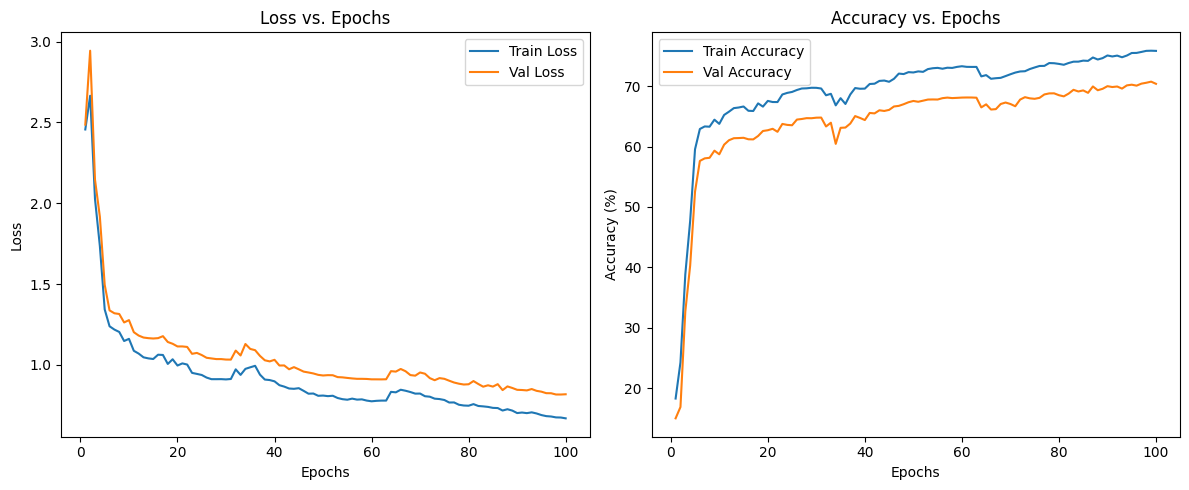

In [10]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100,scheduler)
#mobilenet_v2

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


Epoch 1 | Train Loss:   0.6861 | Train Accuracy:   75.4695% | Train mIOU:   0.6061 | Train mF1:   0.7443 | Train Precision:   0.7342 | Train Recall:   0.7547


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch 1 | Val Loss:   0.8351 | Val Accuracy:   70.1710% | Val mIOU:   0.5361 | Val mF1:   0.6900 | Val Precision:   0.6786 | Val Recall:   0.7017


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 2 | Train Loss:   0.7130 | Train Accuracy:   74.9357% | Train mIOU:   0.6032 | Train mF1:   0.7398 | Train Precision:   0.7304 | Train Recall:   0.7494


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Epoch 2 | Val Loss:   0.8533 | Val Accuracy:   69.8697% | Val mIOU:   0.5361 | Val mF1:   0.6884 | Val Precision:   0.6783 | Val Recall:   0.6987


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 3 | Train Loss:   0.6808 | Train Accuracy:   75.6041% | Train mIOU:   0.6103 | Train mF1:   0.7451 | Train Precision:   0.7344 | Train Recall:   0.7560


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 3 | Val Loss:   0.8184 | Val Accuracy:   70.7762% | Val mIOU:   0.5454 | Val mF1:   0.6965 | Val Precision:   0.6857 | Val Recall:   0.7078


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 4 | Train Loss:   0.7278 | Train Accuracy:   74.4988% | Train mIOU:   0.5899 | Train mF1:   0.7357 | Train Precision:   0.7266 | Train Recall:   0.7450


100%|██████████| 3/3 [00:00<00:00, 16.43it/s]


Epoch 4 | Val Loss:   0.8768 | Val Accuracy:   69.4133% | Val mIOU:   0.5199 | Val mF1:   0.6833 | Val Precision:   0.6729 | Val Recall:   0.6941


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 5 | Train Loss:   0.6852 | Train Accuracy:   75.4286% | Train mIOU:   0.6142 | Train mF1:   0.7444 | Train Precision:   0.7349 | Train Recall:   0.7543


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 5 | Val Loss:   0.8242 | Val Accuracy:   70.2737% | Val mIOU:   0.5479 | Val mF1:   0.6931 | Val Precision:   0.6837 | Val Recall:   0.7027


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 6 | Train Loss:   0.6721 | Train Accuracy:   75.8778% | Train mIOU:   0.6146 | Train mF1:   0.7483 | Train Precision:   0.7381 | Train Recall:   0.7588


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Epoch 6 | Val Loss:   0.8150 | Val Accuracy:   70.8577% | Val mIOU:   0.5492 | Val mF1:   0.6973 | Val Precision:   0.6865 | Val Recall:   0.7086


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 7 | Train Loss:   0.6600 | Train Accuracy:   76.2614% | Train mIOU:   0.6197 | Train mF1:   0.7521 | Train Precision:   0.7419 | Train Recall:   0.7626


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 7 | Val Loss:   0.8052 | Val Accuracy:   71.1590% | Val mIOU:   0.5523 | Val mF1:   0.7003 | Val Precision:   0.6893 | Val Recall:   0.7116


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 8 | Train Loss:   0.6999 | Train Accuracy:   74.9083% | Train mIOU:   0.6087 | Train mF1:   0.7396 | Train Precision:   0.7303 | Train Recall:   0.7491


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


Epoch 8 | Val Loss:   0.8401 | Val Accuracy:   69.6976% | Val mIOU:   0.5410 | Val mF1:   0.6870 | Val Precision:   0.6774 | Val Recall:   0.6970


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 9 | Train Loss:   0.7040 | Train Accuracy:   74.9202% | Train mIOU:   0.6069 | Train mF1:   0.7405 | Train Precision:   0.7320 | Train Recall:   0.7492


100%|██████████| 3/3 [00:00<00:00, 16.26it/s]


Epoch 9 | Val Loss:   0.8512 | Val Accuracy:   69.4049% | Val mIOU:   0.5384 | Val mF1:   0.6861 | Val Precision:   0.6784 | Val Recall:   0.6940


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 10 | Train Loss:   0.6981 | Train Accuracy:   75.1701% | Train mIOU:   0.6034 | Train mF1:   0.7410 | Train Precision:   0.7306 | Train Recall:   0.7517


100%|██████████| 3/3 [00:00<00:00, 15.43it/s]


Epoch 10 | Val Loss:   0.8309 | Val Accuracy:   70.2245% | Val mIOU:   0.5367 | Val mF1:   0.6894 | Val Precision:   0.6770 | Val Recall:   0.7022


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 11 | Train Loss:   0.6921 | Train Accuracy:   75.2882% | Train mIOU:   0.6039 | Train mF1:   0.7419 | Train Precision:   0.7312 | Train Recall:   0.7529


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


Epoch 11 | Val Loss:   0.8243 | Val Accuracy:   70.4146% | Val mIOU:   0.5386 | Val mF1:   0.6916 | Val Precision:   0.6794 | Val Recall:   0.7041


100%|██████████| 12/12 [00:01<00:00,  8.29it/s]


Epoch 12 | Train Loss:   0.6693 | Train Accuracy:   75.8123% | Train mIOU:   0.6167 | Train mF1:   0.7480 | Train Precision:   0.7381 | Train Recall:   0.7581


100%|██████████| 3/3 [00:00<00:00, 16.71it/s]


Epoch 12 | Val Loss:   0.8097 | Val Accuracy:   70.6906% | Val mIOU:   0.5500 | Val mF1:   0.6971 | Val Precision:   0.6876 | Val Recall:   0.7069


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 13 | Train Loss:   0.6592 | Train Accuracy:   76.2678% | Train mIOU:   0.6200 | Train mF1:   0.7522 | Train Precision:   0.7420 | Train Recall:   0.7627


100%|██████████| 3/3 [00:00<00:00, 15.49it/s]


Epoch 13 | Val Loss:   0.7970 | Val Accuracy:   71.2491% | Val mIOU:   0.5539 | Val mF1:   0.7019 | Val Precision:   0.6916 | Val Recall:   0.7125


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 14 | Train Loss:   0.6552 | Train Accuracy:   76.3581% | Train mIOU:   0.6217 | Train mF1:   0.7532 | Train Precision:   0.7431 | Train Recall:   0.7636


100%|██████████| 3/3 [00:00<00:00, 16.27it/s]


Epoch 14 | Val Loss:   0.7901 | Val Accuracy:   71.5075% | Val mIOU:   0.5578 | Val mF1:   0.7047 | Val Precision:   0.6946 | Val Recall:   0.7151


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 15 | Train Loss:   0.6528 | Train Accuracy:   76.4242% | Train mIOU:   0.6228 | Train mF1:   0.7540 | Train Precision:   0.7441 | Train Recall:   0.7642


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 15 | Val Loss:   0.7893 | Val Accuracy:   71.4938% | Val mIOU:   0.5576 | Val mF1:   0.7047 | Val Precision:   0.6947 | Val Recall:   0.7149


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 16 | Train Loss:   0.6776 | Train Accuracy:   75.8274% | Train mIOU:   0.6140 | Train mF1:   0.7487 | Train Precision:   0.7394 | Train Recall:   0.7583


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]


Epoch 16 | Val Loss:   0.8233 | Val Accuracy:   70.8435% | Val mIOU:   0.5470 | Val mF1:   0.6985 | Val Precision:   0.6889 | Val Recall:   0.7084


100%|██████████| 12/12 [00:01<00:00,  7.77it/s]


Epoch 17 | Train Loss:   0.6906 | Train Accuracy:   75.2159% | Train mIOU:   0.6091 | Train mF1:   0.7433 | Train Precision:   0.7347 | Train Recall:   0.7522


100%|██████████| 3/3 [00:00<00:00, 15.57it/s]


Epoch 17 | Val Loss:   0.8259 | Val Accuracy:   70.2698% | Val mIOU:   0.5419 | Val mF1:   0.6921 | Val Precision:   0.6818 | Val Recall:   0.7027


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch 18 | Train Loss:   0.6878 | Train Accuracy:   75.2967% | Train mIOU:   0.6111 | Train mF1:   0.7429 | Train Precision:   0.7331 | Train Recall:   0.7530


100%|██████████| 3/3 [00:00<00:00, 17.29it/s]


Epoch 18 | Val Loss:   0.8290 | Val Accuracy:   69.7927% | Val mIOU:   0.5427 | Val mF1:   0.6900 | Val Precision:   0.6822 | Val Recall:   0.6979


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 19 | Train Loss:   0.6752 | Train Accuracy:   75.6726% | Train mIOU:   0.6153 | Train mF1:   0.7473 | Train Precision:   0.7381 | Train Recall:   0.7567


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 19 | Val Loss:   0.8234 | Val Accuracy:   70.4964% | Val mIOU:   0.5467 | Val mF1:   0.6953 | Val Precision:   0.6859 | Val Recall:   0.7050


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 20 | Train Loss:   0.6936 | Train Accuracy:   75.2257% | Train mIOU:   0.6079 | Train mF1:   0.7449 | Train Precision:   0.7376 | Train Recall:   0.7523


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


Epoch 20 | Val Loss:   0.8405 | Val Accuracy:   69.9175% | Val mIOU:   0.5378 | Val mF1:   0.6910 | Val Precision:   0.6830 | Val Recall:   0.6992


100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 21 | Train Loss:   0.6706 | Train Accuracy:   75.8946% | Train mIOU:   0.6122 | Train mF1:   0.7485 | Train Precision:   0.7384 | Train Recall:   0.7589


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


Epoch 21 | Val Loss:   0.8195 | Val Accuracy:   70.7534% | Val mIOU:   0.5440 | Val mF1:   0.6968 | Val Precision:   0.6863 | Val Recall:   0.7075


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 22 | Train Loss:   0.6613 | Train Accuracy:   76.1897% | Train mIOU:   0.6198 | Train mF1:   0.7523 | Train Precision:   0.7430 | Train Recall:   0.7619


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 22 | Val Loss:   0.8007 | Val Accuracy:   71.2514% | Val mIOU:   0.5553 | Val mF1:   0.7024 | Val Precision:   0.6925 | Val Recall:   0.7125


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch 23 | Train Loss:   0.6490 | Train Accuracy:   76.5448% | Train mIOU:   0.6220 | Train mF1:   0.7556 | Train Precision:   0.7460 | Train Recall:   0.7654


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 23 | Val Loss:   0.7863 | Val Accuracy:   71.6534% | Val mIOU:   0.5552 | Val mF1:   0.7051 | Val Precision:   0.6940 | Val Recall:   0.7165


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 24 | Train Loss:   0.6463 | Train Accuracy:   76.5359% | Train mIOU:   0.6229 | Train mF1:   0.7563 | Train Precision:   0.7475 | Train Recall:   0.7654


100%|██████████| 3/3 [00:00<00:00, 16.87it/s]


Epoch 24 | Val Loss:   0.7877 | Val Accuracy:   71.5639% | Val mIOU:   0.5560 | Val mF1:   0.7049 | Val Precision:   0.6944 | Val Recall:   0.7156


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 25 | Train Loss:   0.6276 | Train Accuracy:   77.0849% | Train mIOU:   0.6342 | Train mF1:   0.7615 | Train Precision:   0.7523 | Train Recall:   0.7708


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch 25 | Val Loss:   0.7778 | Val Accuracy:   71.7869% | Val mIOU:   0.5643 | Val mF1:   0.7080 | Val Precision:   0.6984 | Val Recall:   0.7179


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 26 | Train Loss:   0.6349 | Train Accuracy:   76.8993% | Train mIOU:   0.6288 | Train mF1:   0.7591 | Train Precision:   0.7495 | Train Recall:   0.7690


100%|██████████| 3/3 [00:00<00:00, 15.65it/s]


Epoch 26 | Val Loss:   0.7669 | Val Accuracy:   72.3212% | Val mIOU:   0.5663 | Val mF1:   0.7129 | Val Precision:   0.7029 | Val Recall:   0.7232


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 27 | Train Loss:   0.6195 | Train Accuracy:   77.3305% | Train mIOU:   0.6359 | Train mF1:   0.7639 | Train Precision:   0.7547 | Train Recall:   0.7733


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 27 | Val Loss:   0.7639 | Val Accuracy:   72.3317% | Val mIOU:   0.5689 | Val mF1:   0.7133 | Val Precision:   0.7036 | Val Recall:   0.7233


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 28 | Train Loss:   0.6222 | Train Accuracy:   77.2045% | Train mIOU:   0.6351 | Train mF1:   0.7629 | Train Precision:   0.7541 | Train Recall:   0.7720


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


Epoch 28 | Val Loss:   0.7632 | Val Accuracy:   72.3550% | Val mIOU:   0.5697 | Val mF1:   0.7138 | Val Precision:   0.7043 | Val Recall:   0.7236


100%|██████████| 12/12 [00:01<00:00,  7.92it/s]


Epoch 29 | Train Loss:   0.6217 | Train Accuracy:   77.2521% | Train mIOU:   0.6343 | Train mF1:   0.7627 | Train Precision:   0.7531 | Train Recall:   0.7725


100%|██████████| 3/3 [00:00<00:00, 16.44it/s]


Epoch 29 | Val Loss:   0.7624 | Val Accuracy:   72.3405% | Val mIOU:   0.5680 | Val mF1:   0.7132 | Val Precision:   0.7032 | Val Recall:   0.7234


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 30 | Train Loss:   0.6171 | Train Accuracy:   77.3595% | Train mIOU:   0.6363 | Train mF1:   0.7640 | Train Precision:   0.7546 | Train Recall:   0.7736


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 30 | Val Loss:   0.7628 | Val Accuracy:   72.3226% | Val mIOU:   0.5683 | Val mF1:   0.7131 | Val Precision:   0.7033 | Val Recall:   0.7232


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 31 | Train Loss:   0.6110 | Train Accuracy:   77.6528% | Train mIOU:   0.6404 | Train mF1:   0.7671 | Train Precision:   0.7580 | Train Recall:   0.7765


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 31 | Val Loss:   0.7610 | Val Accuracy:   72.3774% | Val mIOU:   0.5690 | Val mF1:   0.7136 | Val Precision:   0.7037 | Val Recall:   0.7238


100%|██████████| 12/12 [00:01<00:00,  8.27it/s]


Epoch 32 | Train Loss:   0.6485 | Train Accuracy:   76.3601% | Train mIOU:   0.6275 | Train mF1:   0.7551 | Train Precision:   0.7467 | Train Recall:   0.7636


100%|██████████| 3/3 [00:00<00:00, 16.10it/s]


Epoch 32 | Val Loss:   0.8035 | Val Accuracy:   70.9177% | Val mIOU:   0.5567 | Val mF1:   0.7007 | Val Precision:   0.6924 | Val Recall:   0.7092


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 33 | Train Loss:   0.6835 | Train Accuracy:   75.3294% | Train mIOU:   0.6110 | Train mF1:   0.7429 | Train Precision:   0.7327 | Train Recall:   0.7533


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 33 | Val Loss:   0.8180 | Val Accuracy:   70.4051% | Val mIOU:   0.5458 | Val mF1:   0.6932 | Val Precision:   0.6826 | Val Recall:   0.7041


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 34 | Train Loss:   0.6645 | Train Accuracy:   76.0817% | Train mIOU:   0.6129 | Train mF1:   0.7503 | Train Precision:   0.7402 | Train Recall:   0.7608


100%|██████████| 3/3 [00:00<00:00, 15.52it/s]


Epoch 34 | Val Loss:   0.8183 | Val Accuracy:   70.8514% | Val mIOU:   0.5409 | Val mF1:   0.6971 | Val Precision:   0.6861 | Val Recall:   0.7085


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 35 | Train Loss:   0.6664 | Train Accuracy:   75.9614% | Train mIOU:   0.6107 | Train mF1:   0.7504 | Train Precision:   0.7414 | Train Recall:   0.7596


100%|██████████| 3/3 [00:00<00:00, 15.65it/s]


Epoch 35 | Val Loss:   0.8187 | Val Accuracy:   70.5961% | Val mIOU:   0.5378 | Val mF1:   0.6948 | Val Precision:   0.6840 | Val Recall:   0.7060


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 36 | Train Loss:   0.6621 | Train Accuracy:   76.1469% | Train mIOU:   0.6181 | Train mF1:   0.7519 | Train Precision:   0.7425 | Train Recall:   0.7615


100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


Epoch 36 | Val Loss:   0.8074 | Val Accuracy:   71.0277% | Val mIOU:   0.5498 | Val mF1:   0.6999 | Val Precision:   0.6898 | Val Recall:   0.7103


100%|██████████| 12/12 [00:01<00:00,  8.66it/s]


Epoch 37 | Train Loss:   0.6774 | Train Accuracy:   75.7296% | Train mIOU:   0.6124 | Train mF1:   0.7497 | Train Precision:   0.7422 | Train Recall:   0.7573


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


Epoch 37 | Val Loss:   0.8436 | Val Accuracy:   70.4007% | Val mIOU:   0.5411 | Val mF1:   0.6959 | Val Precision:   0.6879 | Val Recall:   0.7040


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 38 | Train Loss:   0.6626 | Train Accuracy:   75.9157% | Train mIOU:   0.6209 | Train mF1:   0.7517 | Train Precision:   0.7444 | Train Recall:   0.7592


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


Epoch 38 | Val Loss:   0.8185 | Val Accuracy:   70.4401% | Val mIOU:   0.5475 | Val mF1:   0.6972 | Val Precision:   0.6901 | Val Recall:   0.7044


100%|██████████| 12/12 [00:01<00:00,  8.30it/s]


Epoch 39 | Train Loss:   0.6611 | Train Accuracy:   76.0485% | Train mIOU:   0.6240 | Train mF1:   0.7530 | Train Precision:   0.7457 | Train Recall:   0.7605


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 39 | Val Loss:   0.8090 | Val Accuracy:   70.5987% | Val mIOU:   0.5539 | Val mF1:   0.6988 | Val Precision:   0.6918 | Val Recall:   0.7060


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 40 | Train Loss:   0.6442 | Train Accuracy:   76.5738% | Train mIOU:   0.6254 | Train mF1:   0.7579 | Train Precision:   0.7502 | Train Recall:   0.7657


100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


Epoch 40 | Val Loss:   0.7938 | Val Accuracy:   71.4344% | Val mIOU:   0.5557 | Val mF1:   0.7056 | Val Precision:   0.6971 | Val Recall:   0.7143


100%|██████████| 12/12 [00:01<00:00,  8.66it/s]


Epoch 41 | Train Loss:   0.6348 | Train Accuracy:   76.8221% | Train mIOU:   0.6248 | Train mF1:   0.7591 | Train Precision:   0.7501 | Train Recall:   0.7682


100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


Epoch 41 | Val Loss:   0.7914 | Val Accuracy:   71.4568% | Val mIOU:   0.5533 | Val mF1:   0.7046 | Val Precision:   0.6949 | Val Recall:   0.7146


100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 42 | Train Loss:   0.6297 | Train Accuracy:   76.9377% | Train mIOU:   0.6286 | Train mF1:   0.7602 | Train Precision:   0.7512 | Train Recall:   0.7694


100%|██████████| 3/3 [00:00<00:00, 16.59it/s]


Epoch 42 | Val Loss:   0.7811 | Val Accuracy:   71.6735% | Val mIOU:   0.5584 | Val mF1:   0.7075 | Val Precision:   0.6985 | Val Recall:   0.7167


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 43 | Train Loss:   0.6271 | Train Accuracy:   77.0409% | Train mIOU:   0.6340 | Train mF1:   0.7615 | Train Precision:   0.7527 | Train Recall:   0.7704


100%|██████████| 3/3 [00:00<00:00, 16.14it/s]


Epoch 43 | Val Loss:   0.7751 | Val Accuracy:   71.7308% | Val mIOU:   0.5626 | Val mF1:   0.7072 | Val Precision:   0.6973 | Val Recall:   0.7173


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 44 | Train Loss:   0.6186 | Train Accuracy:   77.2568% | Train mIOU:   0.6350 | Train mF1:   0.7639 | Train Precision:   0.7554 | Train Recall:   0.7726


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Epoch 44 | Val Loss:   0.7757 | Val Accuracy:   71.9935% | Val mIOU:   0.5643 | Val mF1:   0.7116 | Val Precision:   0.7035 | Val Recall:   0.7199


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 45 | Train Loss:   0.6166 | Train Accuracy:   77.3215% | Train mIOU:   0.6372 | Train mF1:   0.7648 | Train Precision:   0.7566 | Train Recall:   0.7732


100%|██████████| 3/3 [00:00<00:00, 16.44it/s]


Epoch 45 | Val Loss:   0.7587 | Val Accuracy:   72.3067% | Val mIOU:   0.5700 | Val mF1:   0.7133 | Val Precision:   0.7038 | Val Recall:   0.7231


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 46 | Train Loss:   0.6181 | Train Accuracy:   77.3150% | Train mIOU:   0.6338 | Train mF1:   0.7642 | Train Precision:   0.7555 | Train Recall:   0.7731


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 46 | Val Loss:   0.7561 | Val Accuracy:   72.4764% | Val mIOU:   0.5686 | Val mF1:   0.7160 | Val Precision:   0.7075 | Val Recall:   0.7248


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 47 | Train Loss:   0.6040 | Train Accuracy:   77.7191% | Train mIOU:   0.6415 | Train mF1:   0.7690 | Train Precision:   0.7609 | Train Recall:   0.7772


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 47 | Val Loss:   0.7497 | Val Accuracy:   72.5931% | Val mIOU:   0.5717 | Val mF1:   0.7165 | Val Precision:   0.7073 | Val Recall:   0.7259


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 48 | Train Loss:   0.6004 | Train Accuracy:   77.7855% | Train mIOU:   0.6438 | Train mF1:   0.7693 | Train Precision:   0.7610 | Train Recall:   0.7779


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 48 | Val Loss:   0.7426 | Val Accuracy:   72.8007% | Val mIOU:   0.5771 | Val mF1:   0.7186 | Val Precision:   0.7094 | Val Recall:   0.7280


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 49 | Train Loss:   0.5955 | Train Accuracy:   77.9029% | Train mIOU:   0.6455 | Train mF1:   0.7714 | Train Precision:   0.7640 | Train Recall:   0.7790


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


Epoch 49 | Val Loss:   0.7475 | Val Accuracy:   72.7622% | Val mIOU:   0.5761 | Val mF1:   0.7193 | Val Precision:   0.7113 | Val Recall:   0.7276


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 50 | Train Loss:   0.5864 | Train Accuracy:   78.2210% | Train mIOU:   0.6494 | Train mF1:   0.7737 | Train Precision:   0.7653 | Train Recall:   0.7822


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 50 | Val Loss:   0.7407 | Val Accuracy:   72.8601% | Val mIOU:   0.5770 | Val mF1:   0.7188 | Val Precision:   0.7094 | Val Recall:   0.7286


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 51 | Train Loss:   0.5786 | Train Accuracy:   78.4393% | Train mIOU:   0.6524 | Train mF1:   0.7763 | Train Precision:   0.7685 | Train Recall:   0.7844


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 51 | Val Loss:   0.7380 | Val Accuracy:   73.0124% | Val mIOU:   0.5785 | Val mF1:   0.7207 | Val Precision:   0.7116 | Val Recall:   0.7301


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 52 | Train Loss:   0.5880 | Train Accuracy:   78.2432% | Train mIOU:   0.6504 | Train mF1:   0.7747 | Train Precision:   0.7670 | Train Recall:   0.7824


100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


Epoch 52 | Val Loss:   0.7339 | Val Accuracy:   73.1497% | Val mIOU:   0.5812 | Val mF1:   0.7226 | Val Precision:   0.7139 | Val Recall:   0.7315


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 53 | Train Loss:   0.5780 | Train Accuracy:   78.4522% | Train mIOU:   0.6535 | Train mF1:   0.7773 | Train Precision:   0.7703 | Train Recall:   0.7845


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 53 | Val Loss:   0.7304 | Val Accuracy:   73.1840% | Val mIOU:   0.5812 | Val mF1:   0.7228 | Val Precision:   0.7139 | Val Recall:   0.7318


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 54 | Train Loss:   0.5829 | Train Accuracy:   78.2859% | Train mIOU:   0.6489 | Train mF1:   0.7744 | Train Precision:   0.7661 | Train Recall:   0.7829


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


Epoch 54 | Val Loss:   0.7351 | Val Accuracy:   73.0989% | Val mIOU:   0.5779 | Val mF1:   0.7217 | Val Precision:   0.7126 | Val Recall:   0.7310


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 55 | Train Loss:   0.5751 | Train Accuracy:   78.5101% | Train mIOU:   0.6535 | Train mF1:   0.7774 | Train Precision:   0.7698 | Train Recall:   0.7851


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


Epoch 55 | Val Loss:   0.7305 | Val Accuracy:   73.1938% | Val mIOU:   0.5815 | Val mF1:   0.7230 | Val Precision:   0.7142 | Val Recall:   0.7319


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 56 | Train Loss:   0.5727 | Train Accuracy:   78.6058% | Train mIOU:   0.6553 | Train mF1:   0.7784 | Train Precision:   0.7710 | Train Recall:   0.7861


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 56 | Val Loss:   0.7293 | Val Accuracy:   73.2394% | Val mIOU:   0.5824 | Val mF1:   0.7235 | Val Precision:   0.7148 | Val Recall:   0.7324


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 57 | Train Loss:   0.5765 | Train Accuracy:   78.4673% | Train mIOU:   0.6545 | Train mF1:   0.7772 | Train Precision:   0.7699 | Train Recall:   0.7847


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 57 | Val Loss:   0.7273 | Val Accuracy:   73.2889% | Val mIOU:   0.5840 | Val mF1:   0.7246 | Val Precision:   0.7164 | Val Recall:   0.7329


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 58 | Train Loss:   0.5771 | Train Accuracy:   78.4714% | Train mIOU:   0.6525 | Train mF1:   0.7768 | Train Precision:   0.7691 | Train Recall:   0.7847


100%|██████████| 3/3 [00:00<00:00, 16.27it/s]


Epoch 58 | Val Loss:   0.7249 | Val Accuracy:   73.4290% | Val mIOU:   0.5835 | Val mF1:   0.7258 | Val Precision:   0.7175 | Val Recall:   0.7343


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 59 | Train Loss:   0.5756 | Train Accuracy:   78.5669% | Train mIOU:   0.6542 | Train mF1:   0.7781 | Train Precision:   0.7706 | Train Recall:   0.7857


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


Epoch 59 | Val Loss:   0.7254 | Val Accuracy:   73.4014% | Val mIOU:   0.5836 | Val mF1:   0.7253 | Val Precision:   0.7167 | Val Recall:   0.7340


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 60 | Train Loss:   0.5709 | Train Accuracy:   78.6411% | Train mIOU:   0.6553 | Train mF1:   0.7786 | Train Precision:   0.7710 | Train Recall:   0.7864


100%|██████████| 3/3 [00:00<00:00, 16.40it/s]


Epoch 60 | Val Loss:   0.7245 | Val Accuracy:   73.4251% | Val mIOU:   0.5839 | Val mF1:   0.7254 | Val Precision:   0.7168 | Val Recall:   0.7343


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 61 | Train Loss:   0.5685 | Train Accuracy:   78.8020% | Train mIOU:   0.6573 | Train mF1:   0.7803 | Train Precision:   0.7728 | Train Recall:   0.7880


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 61 | Val Loss:   0.7225 | Val Accuracy:   73.4614% | Val mIOU:   0.5845 | Val mF1:   0.7255 | Val Precision:   0.7166 | Val Recall:   0.7346


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 62 | Train Loss:   0.5704 | Train Accuracy:   78.7298% | Train mIOU:   0.6564 | Train mF1:   0.7794 | Train Precision:   0.7717 | Train Recall:   0.7873


100%|██████████| 3/3 [00:00<00:00, 16.44it/s]


Epoch 62 | Val Loss:   0.7224 | Val Accuracy:   73.4578% | Val mIOU:   0.5848 | Val mF1:   0.7257 | Val Precision:   0.7170 | Val Recall:   0.7346


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 63 | Train Loss:   0.5646 | Train Accuracy:   78.8692% | Train mIOU:   0.6587 | Train mF1:   0.7808 | Train Precision:   0.7731 | Train Recall:   0.7887


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 63 | Val Loss:   0.7235 | Val Accuracy:   73.4443% | Val mIOU:   0.5849 | Val mF1:   0.7257 | Val Precision:   0.7171 | Val Recall:   0.7344


100%|██████████| 12/12 [00:01<00:00,  8.65it/s]


Epoch 64 | Train Loss:   0.6023 | Train Accuracy:   77.7262% | Train mIOU:   0.6371 | Train mF1:   0.7691 | Train Precision:   0.7611 | Train Recall:   0.7773


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


Epoch 64 | Val Loss:   0.7531 | Val Accuracy:   72.6022% | Val mIOU:   0.5656 | Val mF1:   0.7164 | Val Precision:   0.7070 | Val Recall:   0.7260


100%|██████████| 12/12 [00:01<00:00,  8.26it/s]


Epoch 65 | Train Loss:   0.6221 | Train Accuracy:   77.0949% | Train mIOU:   0.6318 | Train mF1:   0.7635 | Train Precision:   0.7562 | Train Recall:   0.7709


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 65 | Val Loss:   0.7769 | Val Accuracy:   72.1281% | Val mIOU:   0.5654 | Val mF1:   0.7126 | Val Precision:   0.7042 | Val Recall:   0.7213


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 66 | Train Loss:   0.6245 | Train Accuracy:   76.9652% | Train mIOU:   0.6322 | Train mF1:   0.7624 | Train Precision:   0.7553 | Train Recall:   0.7697


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 66 | Val Loss:   0.7843 | Val Accuracy:   71.6044% | Val mIOU:   0.5617 | Val mF1:   0.7093 | Val Precision:   0.7026 | Val Recall:   0.7160


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 67 | Train Loss:   0.6294 | Train Accuracy:   76.7968% | Train mIOU:   0.6329 | Train mF1:   0.7604 | Train Precision:   0.7530 | Train Recall:   0.7680


100%|██████████| 3/3 [00:00<00:00, 16.27it/s]


Epoch 67 | Val Loss:   0.7790 | Val Accuracy:   71.7033% | Val mIOU:   0.5649 | Val mF1:   0.7093 | Val Precision:   0.7017 | Val Recall:   0.7170


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 68 | Train Loss:   0.6501 | Train Accuracy:   76.2956% | Train mIOU:   0.6260 | Train mF1:   0.7582 | Train Precision:   0.7536 | Train Recall:   0.7630


100%|██████████| 3/3 [00:00<00:00, 15.93it/s]


Epoch 68 | Val Loss:   0.7927 | Val Accuracy:   71.4297% | Val mIOU:   0.5605 | Val mF1:   0.7071 | Val Precision:   0.7000 | Val Recall:   0.7143


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 69 | Train Loss:   0.6476 | Train Accuracy:   76.3890% | Train mIOU:   0.6302 | Train mF1:   0.7567 | Train Precision:   0.7497 | Train Recall:   0.7639


100%|██████████| 3/3 [00:00<00:00, 16.86it/s]


Epoch 69 | Val Loss:   0.7990 | Val Accuracy:   70.8370% | Val mIOU:   0.5589 | Val mF1:   0.7023 | Val Precision:   0.6963 | Val Recall:   0.7084


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 70 | Train Loss:   0.6718 | Train Accuracy:   76.1382% | Train mIOU:   0.6152 | Train mF1:   0.7520 | Train Precision:   0.7428 | Train Recall:   0.7614


100%|██████████| 3/3 [00:00<00:00, 15.55it/s]


Epoch 70 | Val Loss:   0.8111 | Val Accuracy:   71.5258% | Val mIOU:   0.5543 | Val mF1:   0.7057 | Val Precision:   0.6964 | Val Recall:   0.7153


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 71 | Train Loss:   0.6663 | Train Accuracy:   75.4325% | Train mIOU:   0.6248 | Train mF1:   0.7539 | Train Precision:   0.7535 | Train Recall:   0.7543


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 71 | Val Loss:   0.8285 | Val Accuracy:   69.5724% | Val mIOU:   0.5522 | Val mF1:   0.6972 | Val Precision:   0.6988 | Val Recall:   0.6957


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 72 | Train Loss:   0.6195 | Train Accuracy:   77.2907% | Train mIOU:   0.6364 | Train mF1:   0.7657 | Train Precision:   0.7586 | Train Recall:   0.7729


100%|██████████| 3/3 [00:00<00:00, 16.10it/s]


Epoch 72 | Val Loss:   0.7811 | Val Accuracy:   71.9061% | Val mIOU:   0.5651 | Val mF1:   0.7115 | Val Precision:   0.7040 | Val Recall:   0.7191


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 73 | Train Loss:   0.6320 | Train Accuracy:   76.7710% | Train mIOU:   0.6320 | Train mF1:   0.7624 | Train Precision:   0.7571 | Train Recall:   0.7677


100%|██████████| 3/3 [00:00<00:00, 17.09it/s]


Epoch 73 | Val Loss:   0.7882 | Val Accuracy:   71.6551% | Val mIOU:   0.5629 | Val mF1:   0.7120 | Val Precision:   0.7075 | Val Recall:   0.7166


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 74 | Train Loss:   0.6197 | Train Accuracy:   77.2601% | Train mIOU:   0.6346 | Train mF1:   0.7637 | Train Precision:   0.7550 | Train Recall:   0.7726


100%|██████████| 3/3 [00:00<00:00, 16.87it/s]


Epoch 74 | Val Loss:   0.7524 | Val Accuracy:   72.5942% | Val mIOU:   0.5725 | Val mF1:   0.7164 | Val Precision:   0.7071 | Val Recall:   0.7259


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 75 | Train Loss:   0.6243 | Train Accuracy:   76.9036% | Train mIOU:   0.6338 | Train mF1:   0.7621 | Train Precision:   0.7553 | Train Recall:   0.7690


100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


Epoch 75 | Val Loss:   0.7658 | Val Accuracy:   71.7583% | Val mIOU:   0.5669 | Val mF1:   0.7123 | Val Precision:   0.7072 | Val Recall:   0.7176


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


Epoch 76 | Train Loss:   0.6147 | Train Accuracy:   77.3245% | Train mIOU:   0.6372 | Train mF1:   0.7652 | Train Precision:   0.7573 | Train Recall:   0.7732


100%|██████████| 3/3 [00:00<00:00, 15.55it/s]


Epoch 76 | Val Loss:   0.7508 | Val Accuracy:   72.4729% | Val mIOU:   0.5720 | Val mF1:   0.7164 | Val Precision:   0.7082 | Val Recall:   0.7247


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 77 | Train Loss:   0.6134 | Train Accuracy:   77.4598% | Train mIOU:   0.6372 | Train mF1:   0.7682 | Train Precision:   0.7618 | Train Recall:   0.7746


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 77 | Val Loss:   0.7545 | Val Accuracy:   72.7160% | Val mIOU:   0.5730 | Val mF1:   0.7210 | Val Precision:   0.7149 | Val Recall:   0.7272


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 78 | Train Loss:   0.6097 | Train Accuracy:   77.4741% | Train mIOU:   0.6374 | Train mF1:   0.7671 | Train Precision:   0.7596 | Train Recall:   0.7747


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


Epoch 78 | Val Loss:   0.7527 | Val Accuracy:   72.4184% | Val mIOU:   0.5692 | Val mF1:   0.7150 | Val Precision:   0.7061 | Val Recall:   0.7242


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 79 | Train Loss:   0.6071 | Train Accuracy:   77.5098% | Train mIOU:   0.6409 | Train mF1:   0.7685 | Train Precision:   0.7621 | Train Recall:   0.7751


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 79 | Val Loss:   0.7693 | Val Accuracy:   71.9161% | Val mIOU:   0.5672 | Val mF1:   0.7118 | Val Precision:   0.7047 | Val Recall:   0.7192


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 80 | Train Loss:   0.5868 | Train Accuracy:   78.0793% | Train mIOU:   0.6498 | Train mF1:   0.7736 | Train Precision:   0.7666 | Train Recall:   0.7808


100%|██████████| 3/3 [00:00<00:00, 16.28it/s]


Epoch 80 | Val Loss:   0.7473 | Val Accuracy:   72.4381% | Val mIOU:   0.5757 | Val mF1:   0.7175 | Val Precision:   0.7108 | Val Recall:   0.7244


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 81 | Train Loss:   0.6032 | Train Accuracy:   77.5742% | Train mIOU:   0.6419 | Train mF1:   0.7699 | Train Precision:   0.7641 | Train Recall:   0.7757


100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


Epoch 81 | Val Loss:   0.7469 | Val Accuracy:   72.5905% | Val mIOU:   0.5757 | Val mF1:   0.7193 | Val Precision:   0.7128 | Val Recall:   0.7259


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 82 | Train Loss:   0.5916 | Train Accuracy:   78.0007% | Train mIOU:   0.6467 | Train mF1:   0.7725 | Train Precision:   0.7652 | Train Recall:   0.7800


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 82 | Val Loss:   0.7372 | Val Accuracy:   72.9059% | Val mIOU:   0.5789 | Val mF1:   0.7206 | Val Precision:   0.7124 | Val Recall:   0.7291


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 83 | Train Loss:   0.5726 | Train Accuracy:   78.4854% | Train mIOU:   0.6510 | Train mF1:   0.7776 | Train Precision:   0.7705 | Train Recall:   0.7849


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 83 | Val Loss:   0.7254 | Val Accuracy:   73.3064% | Val mIOU:   0.5800 | Val mF1:   0.7249 | Val Precision:   0.7168 | Val Recall:   0.7331


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 84 | Train Loss:   0.5736 | Train Accuracy:   78.4847% | Train mIOU:   0.6490 | Train mF1:   0.7768 | Train Precision:   0.7690 | Train Recall:   0.7848


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 84 | Val Loss:   0.7233 | Val Accuracy:   73.3745% | Val mIOU:   0.5777 | Val mF1:   0.7246 | Val Precision:   0.7157 | Val Recall:   0.7337


100%|██████████| 12/12 [00:01<00:00,  8.65it/s]


Epoch 85 | Train Loss:   0.5735 | Train Accuracy:   78.4740% | Train mIOU:   0.6553 | Train mF1:   0.7787 | Train Precision:   0.7728 | Train Recall:   0.7847


100%|██████████| 3/3 [00:00<00:00, 16.05it/s]


Epoch 85 | Val Loss:   0.7324 | Val Accuracy:   73.0504% | Val mIOU:   0.5825 | Val mF1:   0.7250 | Val Precision:   0.7195 | Val Recall:   0.7305


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 86 | Train Loss:   0.5725 | Train Accuracy:   78.5278% | Train mIOU:   0.6558 | Train mF1:   0.7787 | Train Precision:   0.7723 | Train Recall:   0.7853


100%|██████████| 3/3 [00:00<00:00, 16.43it/s]


Epoch 86 | Val Loss:   0.7375 | Val Accuracy:   72.8034% | Val mIOU:   0.5791 | Val mF1:   0.7217 | Val Precision:   0.7155 | Val Recall:   0.7280


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 87 | Train Loss:   0.5773 | Train Accuracy:   78.3345% | Train mIOU:   0.6526 | Train mF1:   0.7769 | Train Precision:   0.7706 | Train Recall:   0.7833


100%|██████████| 3/3 [00:00<00:00, 15.52it/s]


Epoch 87 | Val Loss:   0.7380 | Val Accuracy:   72.8908% | Val mIOU:   0.5790 | Val mF1:   0.7221 | Val Precision:   0.7155 | Val Recall:   0.7289


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 88 | Train Loss:   0.5755 | Train Accuracy:   78.5832% | Train mIOU:   0.6537 | Train mF1:   0.7796 | Train Precision:   0.7734 | Train Recall:   0.7858


100%|██████████| 3/3 [00:00<00:00, 16.50it/s]


Epoch 88 | Val Loss:   0.7474 | Val Accuracy:   72.9915% | Val mIOU:   0.5775 | Val mF1:   0.7237 | Val Precision:   0.7175 | Val Recall:   0.7299


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 89 | Train Loss:   0.5707 | Train Accuracy:   78.5588% | Train mIOU:   0.6548 | Train mF1:   0.7789 | Train Precision:   0.7723 | Train Recall:   0.7856


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


Epoch 89 | Val Loss:   0.7187 | Val Accuracy:   73.4123% | Val mIOU:   0.5845 | Val mF1:   0.7255 | Val Precision:   0.7170 | Val Recall:   0.7341


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 90 | Train Loss:   0.5646 | Train Accuracy:   78.7842% | Train mIOU:   0.6569 | Train mF1:   0.7809 | Train Precision:   0.7740 | Train Recall:   0.7878


100%|██████████| 3/3 [00:00<00:00, 16.54it/s]


Epoch 90 | Val Loss:   0.7278 | Val Accuracy:   73.2130% | Val mIOU:   0.5804 | Val mF1:   0.7248 | Val Precision:   0.7176 | Val Recall:   0.7321


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 91 | Train Loss:   0.5517 | Train Accuracy:   79.0819% | Train mIOU:   0.6645 | Train mF1:   0.7852 | Train Precision:   0.7797 | Train Recall:   0.7908


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 91 | Val Loss:   0.7040 | Val Accuracy:   73.7588% | Val mIOU:   0.5918 | Val mF1:   0.7307 | Val Precision:   0.7240 | Val Recall:   0.7376


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 92 | Train Loss:   0.5578 | Train Accuracy:   78.9152% | Train mIOU:   0.6579 | Train mF1:   0.7818 | Train Precision:   0.7746 | Train Recall:   0.7892


100%|██████████| 3/3 [00:00<00:00, 16.16it/s]


Epoch 92 | Val Loss:   0.7077 | Val Accuracy:   73.8695% | Val mIOU:   0.5887 | Val mF1:   0.7311 | Val Precision:   0.7237 | Val Recall:   0.7387


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 93 | Train Loss:   0.5501 | Train Accuracy:   79.1665% | Train mIOU:   0.6640 | Train mF1:   0.7852 | Train Precision:   0.7788 | Train Recall:   0.7917


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 93 | Val Loss:   0.7106 | Val Accuracy:   73.6910% | Val mIOU:   0.5885 | Val mF1:   0.7294 | Val Precision:   0.7221 | Val Recall:   0.7369


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 94 | Train Loss:   0.5562 | Train Accuracy:   78.9636% | Train mIOU:   0.6627 | Train mF1:   0.7835 | Train Precision:   0.7774 | Train Recall:   0.7896


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Epoch 94 | Val Loss:   0.7077 | Val Accuracy:   73.6350% | Val mIOU:   0.5909 | Val mF1:   0.7298 | Val Precision:   0.7233 | Val Recall:   0.7364


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 95 | Train Loss:   0.5450 | Train Accuracy:   79.3174% | Train mIOU:   0.6650 | Train mF1:   0.7875 | Train Precision:   0.7818 | Train Recall:   0.7932


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 95 | Val Loss:   0.7044 | Val Accuracy:   73.9144% | Val mIOU:   0.5892 | Val mF1:   0.7323 | Val Precision:   0.7255 | Val Recall:   0.7391


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 96 | Train Loss:   0.5476 | Train Accuracy:   79.2244% | Train mIOU:   0.6653 | Train mF1:   0.7855 | Train Precision:   0.7789 | Train Recall:   0.7922


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


Epoch 96 | Val Loss:   0.7075 | Val Accuracy:   73.7292% | Val mIOU:   0.5910 | Val mF1:   0.7303 | Val Precision:   0.7235 | Val Recall:   0.7373


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 97 | Train Loss:   0.5360 | Train Accuracy:   79.6477% | Train mIOU:   0.6682 | Train mF1:   0.7895 | Train Precision:   0.7827 | Train Recall:   0.7965


100%|██████████| 3/3 [00:00<00:00, 16.50it/s]


Epoch 97 | Val Loss:   0.7024 | Val Accuracy:   73.8711% | Val mIOU:   0.5892 | Val mF1:   0.7305 | Val Precision:   0.7224 | Val Recall:   0.7387


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 98 | Train Loss:   0.5368 | Train Accuracy:   79.5220% | Train mIOU:   0.6689 | Train mF1:   0.7890 | Train Precision:   0.7828 | Train Recall:   0.7952


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 98 | Val Loss:   0.7004 | Val Accuracy:   73.9879% | Val mIOU:   0.5929 | Val mF1:   0.7331 | Val Precision:   0.7265 | Val Recall:   0.7399


100%|██████████| 12/12 [00:01<00:00,  8.30it/s]


Epoch 99 | Train Loss:   0.5401 | Train Accuracy:   79.3724% | Train mIOU:   0.6670 | Train mF1:   0.7875 | Train Precision:   0.7814 | Train Recall:   0.7937


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 99 | Val Loss:   0.6996 | Val Accuracy:   74.0316% | Val mIOU:   0.5940 | Val mF1:   0.7334 | Val Precision:   0.7266 | Val Recall:   0.7403


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 100 | Train Loss:   0.5371 | Train Accuracy:   79.5765% | Train mIOU:   0.6686 | Train mF1:   0.7893 | Train Precision:   0.7829 | Train Recall:   0.7958


100%|██████████| 3/3 [00:00<00:00, 16.12it/s]


Epoch 100 | Val Loss:   0.6999 | Val Accuracy:   73.9907% | Val mIOU:   0.5930 | Val mF1:   0.7331 | Val Precision:   0.7265 | Val Recall:   0.7399


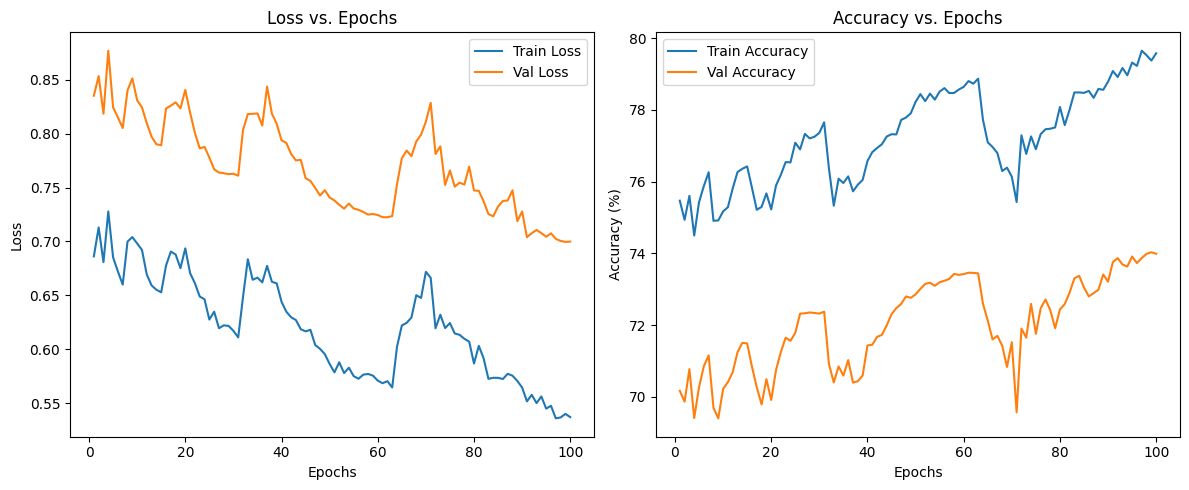

In [11]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100,scheduler)
#mobilenet_v2 - 2.train

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 1 | Train Loss:   0.5498 | Train Accuracy:   79.2072% | Train mIOU:   0.6643 | Train mF1:   0.7851 | Train Precision:   0.7782 | Train Recall:   0.7921


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 1 | Val Loss:   0.7053 | Val Accuracy:   73.8590% | Val mIOU:   0.5917 | Val mF1:   0.7310 | Val Precision:   0.7236 | Val Recall:   0.7386


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 2 | Train Loss:   0.5573 | Train Accuracy:   78.8542% | Train mIOU:   0.6603 | Train mF1:   0.7829 | Train Precision:   0.7774 | Train Recall:   0.7885


100%|██████████| 3/3 [00:00<00:00, 16.46it/s]


Epoch 2 | Val Loss:   0.7306 | Val Accuracy:   73.3078% | Val mIOU:   0.5840 | Val mF1:   0.7274 | Val Precision:   0.7218 | Val Recall:   0.7331


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 3 | Train Loss:   0.5336 | Train Accuracy:   79.5422% | Train mIOU:   0.6706 | Train mF1:   0.7897 | Train Precision:   0.7841 | Train Recall:   0.7954


100%|██████████| 3/3 [00:00<00:00, 15.43it/s]


Epoch 3 | Val Loss:   0.6988 | Val Accuracy:   73.9725% | Val mIOU:   0.5950 | Val mF1:   0.7337 | Val Precision:   0.7278 | Val Recall:   0.7397


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 4 | Train Loss:   0.5741 | Train Accuracy:   78.4055% | Train mIOU:   0.6498 | Train mF1:   0.7782 | Train Precision:   0.7724 | Train Recall:   0.7841


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


Epoch 4 | Val Loss:   0.7376 | Val Accuracy:   72.7833% | Val mIOU:   0.5734 | Val mF1:   0.7203 | Val Precision:   0.7129 | Val Recall:   0.7278


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 5 | Train Loss:   0.5505 | Train Accuracy:   79.1447% | Train mIOU:   0.6645 | Train mF1:   0.7857 | Train Precision:   0.7801 | Train Recall:   0.7914


100%|██████████| 3/3 [00:00<00:00, 15.49it/s]


Epoch 5 | Val Loss:   0.7039 | Val Accuracy:   73.8330% | Val mIOU:   0.5922 | Val mF1:   0.7318 | Val Precision:   0.7253 | Val Recall:   0.7383


100%|██████████| 12/12 [00:01<00:00,  7.67it/s]


Epoch 6 | Train Loss:   0.5311 | Train Accuracy:   79.7412% | Train mIOU:   0.6719 | Train mF1:   0.7914 | Train Precision:   0.7854 | Train Recall:   0.7974


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


Epoch 6 | Val Loss:   0.7007 | Val Accuracy:   74.0377% | Val mIOU:   0.5941 | Val mF1:   0.7339 | Val Precision:   0.7276 | Val Recall:   0.7404


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 7 | Train Loss:   0.5313 | Train Accuracy:   79.7202% | Train mIOU:   0.6718 | Train mF1:   0.7910 | Train Precision:   0.7850 | Train Recall:   0.7972


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 7 | Val Loss:   0.6942 | Val Accuracy:   74.2466% | Val mIOU:   0.5972 | Val mF1:   0.7359 | Val Precision:   0.7294 | Val Recall:   0.7425


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 8 | Train Loss:   0.5617 | Train Accuracy:   78.7752% | Train mIOU:   0.6603 | Train mF1:   0.7822 | Train Precision:   0.7768 | Train Recall:   0.7878


100%|██████████| 3/3 [00:00<00:00, 15.48it/s]


Epoch 8 | Val Loss:   0.7180 | Val Accuracy:   73.3168% | Val mIOU:   0.5868 | Val mF1:   0.7274 | Val Precision:   0.7218 | Val Recall:   0.7332


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 9 | Train Loss:   0.5579 | Train Accuracy:   78.8547% | Train mIOU:   0.6572 | Train mF1:   0.7824 | Train Precision:   0.7764 | Train Recall:   0.7885


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


Epoch 9 | Val Loss:   0.7147 | Val Accuracy:   73.5679% | Val mIOU:   0.5853 | Val mF1:   0.7285 | Val Precision:   0.7214 | Val Recall:   0.7357


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 10 | Train Loss:   0.5551 | Train Accuracy:   78.8888% | Train mIOU:   0.6621 | Train mF1:   0.7827 | Train Precision:   0.7767 | Train Recall:   0.7889


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 10 | Val Loss:   0.7125 | Val Accuracy:   73.2866% | Val mIOU:   0.5868 | Val mF1:   0.7265 | Val Precision:   0.7202 | Val Recall:   0.7329


100%|██████████| 12/12 [00:01<00:00,  7.73it/s]


Epoch 11 | Train Loss:   0.5479 | Train Accuracy:   79.1931% | Train mIOU:   0.6659 | Train mF1:   0.7874 | Train Precision:   0.7828 | Train Recall:   0.7919


100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


Epoch 11 | Val Loss:   0.7154 | Val Accuracy:   73.5872% | Val mIOU:   0.5884 | Val mF1:   0.7305 | Val Precision:   0.7252 | Val Recall:   0.7359


100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


Epoch 12 | Train Loss:   0.5268 | Train Accuracy:   79.8317% | Train mIOU:   0.6725 | Train mF1:   0.7922 | Train Precision:   0.7862 | Train Recall:   0.7983


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 12 | Val Loss:   0.6951 | Val Accuracy:   74.1488% | Val mIOU:   0.5930 | Val mF1:   0.7340 | Val Precision:   0.7267 | Val Recall:   0.7415


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 13 | Train Loss:   0.5351 | Train Accuracy:   79.6136% | Train mIOU:   0.6699 | Train mF1:   0.7902 | Train Precision:   0.7844 | Train Recall:   0.7961


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


Epoch 13 | Val Loss:   0.6866 | Val Accuracy:   74.3832% | Val mIOU:   0.5970 | Val mF1:   0.7370 | Val Precision:   0.7303 | Val Recall:   0.7438


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 14 | Train Loss:   0.5193 | Train Accuracy:   80.0894% | Train mIOU:   0.6771 | Train mF1:   0.7950 | Train Precision:   0.7891 | Train Recall:   0.8009


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 14 | Val Loss:   0.6813 | Val Accuracy:   74.4951% | Val mIOU:   0.6001 | Val mF1:   0.7383 | Val Precision:   0.7318 | Val Recall:   0.7450


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 15 | Train Loss:   0.5194 | Train Accuracy:   80.0545% | Train mIOU:   0.6765 | Train mF1:   0.7946 | Train Precision:   0.7887 | Train Recall:   0.8005


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 15 | Val Loss:   0.6796 | Val Accuracy:   74.5592% | Val mIOU:   0.6003 | Val mF1:   0.7386 | Val Precision:   0.7317 | Val Recall:   0.7456


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 16 | Train Loss:   0.5297 | Train Accuracy:   79.7006% | Train mIOU:   0.6745 | Train mF1:   0.7921 | Train Precision:   0.7873 | Train Recall:   0.7970


100%|██████████| 3/3 [00:00<00:00, 16.15it/s]


Epoch 16 | Val Loss:   0.7068 | Val Accuracy:   73.5845% | Val mIOU:   0.5918 | Val mF1:   0.7315 | Val Precision:   0.7272 | Val Recall:   0.7358


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 17 | Train Loss:   0.5596 | Train Accuracy:   78.7021% | Train mIOU:   0.6612 | Train mF1:   0.7831 | Train Precision:   0.7792 | Train Recall:   0.7870


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 17 | Val Loss:   0.7308 | Val Accuracy:   72.9304% | Val mIOU:   0.5835 | Val mF1:   0.7261 | Val Precision:   0.7229 | Val Recall:   0.7293


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 18 | Train Loss:   0.5678 | Train Accuracy:   78.4696% | Train mIOU:   0.6608 | Train mF1:   0.7823 | Train Precision:   0.7799 | Train Recall:   0.7847


100%|██████████| 3/3 [00:00<00:00, 16.18it/s]


Epoch 18 | Val Loss:   0.7603 | Val Accuracy:   72.1315% | Val mIOU:   0.5769 | Val mF1:   0.7201 | Val Precision:   0.7189 | Val Recall:   0.7213


100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


Epoch 19 | Train Loss:   0.5684 | Train Accuracy:   78.7535% | Train mIOU:   0.6537 | Train mF1:   0.7809 | Train Precision:   0.7743 | Train Recall:   0.7875


100%|██████████| 3/3 [00:00<00:00, 16.17it/s]


Epoch 19 | Val Loss:   0.7383 | Val Accuracy:   73.1609% | Val mIOU:   0.5761 | Val mF1:   0.7244 | Val Precision:   0.7174 | Val Recall:   0.7316


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 20 | Train Loss:   0.5687 | Train Accuracy:   78.2513% | Train mIOU:   0.6582 | Train mF1:   0.7798 | Train Precision:   0.7771 | Train Recall:   0.7825


100%|██████████| 3/3 [00:00<00:00, 16.93it/s]


Epoch 20 | Val Loss:   0.7234 | Val Accuracy:   72.6478% | Val mIOU:   0.5866 | Val mF1:   0.7266 | Val Precision:   0.7268 | Val Recall:   0.7265


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 21 | Train Loss:   0.5504 | Train Accuracy:   79.0596% | Train mIOU:   0.6627 | Train mF1:   0.7845 | Train Precision:   0.7786 | Train Recall:   0.7906


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 21 | Val Loss:   0.6969 | Val Accuracy:   74.0081% | Val mIOU:   0.5925 | Val mF1:   0.7325 | Val Precision:   0.7252 | Val Recall:   0.7401


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 22 | Train Loss:   0.5361 | Train Accuracy:   79.4513% | Train mIOU:   0.6653 | Train mF1:   0.7888 | Train Precision:   0.7831 | Train Recall:   0.7945


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 22 | Val Loss:   0.7043 | Val Accuracy:   73.9384% | Val mIOU:   0.5883 | Val mF1:   0.7330 | Val Precision:   0.7267 | Val Recall:   0.7394


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 23 | Train Loss:   0.5340 | Train Accuracy:   79.6451% | Train mIOU:   0.6679 | Train mF1:   0.7901 | Train Precision:   0.7839 | Train Recall:   0.7965


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


Epoch 23 | Val Loss:   0.6916 | Val Accuracy:   74.2277% | Val mIOU:   0.5928 | Val mF1:   0.7353 | Val Precision:   0.7285 | Val Recall:   0.7423


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 24 | Train Loss:   0.5236 | Train Accuracy:   79.9190% | Train mIOU:   0.6761 | Train mF1:   0.7938 | Train Precision:   0.7886 | Train Recall:   0.7992


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


Epoch 24 | Val Loss:   0.6760 | Val Accuracy:   74.6873% | Val mIOU:   0.6037 | Val mF1:   0.7409 | Val Precision:   0.7350 | Val Recall:   0.7469


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 25 | Train Loss:   0.5169 | Train Accuracy:   80.1164% | Train mIOU:   0.6778 | Train mF1:   0.7957 | Train Precision:   0.7903 | Train Recall:   0.8012


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 25 | Val Loss:   0.6707 | Val Accuracy:   74.9011% | Val mIOU:   0.6057 | Val mF1:   0.7427 | Val Precision:   0.7364 | Val Recall:   0.7490


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 26 | Train Loss:   0.5151 | Train Accuracy:   80.1593% | Train mIOU:   0.6773 | Train mF1:   0.7958 | Train Precision:   0.7901 | Train Recall:   0.8016


100%|██████████| 3/3 [00:00<00:00, 16.50it/s]


Epoch 26 | Val Loss:   0.6705 | Val Accuracy:   74.9501% | Val mIOU:   0.6039 | Val mF1:   0.7436 | Val Precision:   0.7377 | Val Recall:   0.7495


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 27 | Train Loss:   0.5084 | Train Accuracy:   80.4482% | Train mIOU:   0.6825 | Train mF1:   0.7989 | Train Precision:   0.7935 | Train Recall:   0.8045


100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


Epoch 27 | Val Loss:   0.6614 | Val Accuracy:   75.1650% | Val mIOU:   0.6093 | Val mF1:   0.7455 | Val Precision:   0.7394 | Val Recall:   0.7517


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


Epoch 28 | Train Loss:   0.5072 | Train Accuracy:   80.4243% | Train mIOU:   0.6824 | Train mF1:   0.7987 | Train Precision:   0.7933 | Train Recall:   0.8042


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 28 | Val Loss:   0.6619 | Val Accuracy:   75.1620% | Val mIOU:   0.6092 | Val mF1:   0.7455 | Val Precision:   0.7394 | Val Recall:   0.7516


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 29 | Train Loss:   0.5023 | Train Accuracy:   80.5477% | Train mIOU:   0.6841 | Train mF1:   0.8001 | Train Precision:   0.7947 | Train Recall:   0.8055


100%|██████████| 3/3 [00:00<00:00, 16.17it/s]


Epoch 29 | Val Loss:   0.6621 | Val Accuracy:   75.1342% | Val mIOU:   0.6084 | Val mF1:   0.7453 | Val Precision:   0.7393 | Val Recall:   0.7513


100%|██████████| 12/12 [00:01<00:00,  8.18it/s]


Epoch 30 | Train Loss:   0.5103 | Train Accuracy:   80.2956% | Train mIOU:   0.6810 | Train mF1:   0.7975 | Train Precision:   0.7921 | Train Recall:   0.8030


100%|██████████| 3/3 [00:00<00:00, 14.99it/s]


Epoch 30 | Val Loss:   0.6610 | Val Accuracy:   75.1795% | Val mIOU:   0.6095 | Val mF1:   0.7458 | Val Precision:   0.7400 | Val Recall:   0.7518


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 31 | Train Loss:   0.5128 | Train Accuracy:   80.2438% | Train mIOU:   0.6806 | Train mF1:   0.7971 | Train Precision:   0.7919 | Train Recall:   0.8024


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


Epoch 31 | Val Loss:   0.6618 | Val Accuracy:   75.1344% | Val mIOU:   0.6090 | Val mF1:   0.7454 | Val Precision:   0.7396 | Val Recall:   0.7513


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 32 | Train Loss:   0.5227 | Train Accuracy:   79.9783% | Train mIOU:   0.6716 | Train mF1:   0.7937 | Train Precision:   0.7876 | Train Recall:   0.7998


100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


Epoch 32 | Val Loss:   0.6931 | Val Accuracy:   74.2911% | Val mIOU:   0.5923 | Val mF1:   0.7357 | Val Precision:   0.7287 | Val Recall:   0.7429


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 33 | Train Loss:   0.5433 | Train Accuracy:   79.2651% | Train mIOU:   0.6674 | Train mF1:   0.7880 | Train Precision:   0.7834 | Train Recall:   0.7927


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


Epoch 33 | Val Loss:   0.7074 | Val Accuracy:   73.7854% | Val mIOU:   0.5918 | Val mF1:   0.7323 | Val Precision:   0.7268 | Val Recall:   0.7379


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 34 | Train Loss:   0.5560 | Train Accuracy:   78.8377% | Train mIOU:   0.6592 | Train mF1:   0.7829 | Train Precision:   0.7775 | Train Recall:   0.7884


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


Epoch 34 | Val Loss:   0.7053 | Val Accuracy:   73.7848% | Val mIOU:   0.5902 | Val mF1:   0.7314 | Val Precision:   0.7250 | Val Recall:   0.7378


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


Epoch 35 | Train Loss:   0.5499 | Train Accuracy:   79.1229% | Train mIOU:   0.6616 | Train mF1:   0.7853 | Train Precision:   0.7795 | Train Recall:   0.7912


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 35 | Val Loss:   0.7004 | Val Accuracy:   74.0051% | Val mIOU:   0.5920 | Val mF1:   0.7335 | Val Precision:   0.7271 | Val Recall:   0.7401


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 36 | Train Loss:   0.5515 | Train Accuracy:   79.0999% | Train mIOU:   0.6614 | Train mF1:   0.7860 | Train Precision:   0.7811 | Train Recall:   0.7910


100%|██████████| 3/3 [00:00<00:00, 16.26it/s]


Epoch 36 | Val Loss:   0.7099 | Val Accuracy:   73.8677% | Val mIOU:   0.5882 | Val mF1:   0.7331 | Val Precision:   0.7276 | Val Recall:   0.7387


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 37 | Train Loss:   0.5534 | Train Accuracy:   79.0236% | Train mIOU:   0.6611 | Train mF1:   0.7852 | Train Precision:   0.7802 | Train Recall:   0.7902


100%|██████████| 3/3 [00:00<00:00, 16.20it/s]


Epoch 37 | Val Loss:   0.7185 | Val Accuracy:   73.6393% | Val mIOU:   0.5877 | Val mF1:   0.7309 | Val Precision:   0.7255 | Val Recall:   0.7364


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 38 | Train Loss:   0.5464 | Train Accuracy:   79.2556% | Train mIOU:   0.6645 | Train mF1:   0.7870 | Train Precision:   0.7815 | Train Recall:   0.7926


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 38 | Val Loss:   0.7120 | Val Accuracy:   73.5811% | Val mIOU:   0.5884 | Val mF1:   0.7294 | Val Precision:   0.7232 | Val Recall:   0.7358


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 39 | Train Loss:   0.5430 | Train Accuracy:   79.2000% | Train mIOU:   0.6582 | Train mF1:   0.7851 | Train Precision:   0.7783 | Train Recall:   0.7920


100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


Epoch 39 | Val Loss:   0.7028 | Val Accuracy:   74.0458% | Val mIOU:   0.5863 | Val mF1:   0.7337 | Val Precision:   0.7271 | Val Recall:   0.7405


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 40 | Train Loss:   0.5348 | Train Accuracy:   79.5246% | Train mIOU:   0.6692 | Train mF1:   0.7900 | Train Precision:   0.7848 | Train Recall:   0.7952


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


Epoch 40 | Val Loss:   0.6924 | Val Accuracy:   74.2598% | Val mIOU:   0.5959 | Val mF1:   0.7360 | Val Precision:   0.7296 | Val Recall:   0.7426


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 41 | Train Loss:   0.5406 | Train Accuracy:   79.3247% | Train mIOU:   0.6673 | Train mF1:   0.7880 | Train Precision:   0.7828 | Train Recall:   0.7932


100%|██████████| 3/3 [00:00<00:00, 15.44it/s]


Epoch 41 | Val Loss:   0.6851 | Val Accuracy:   74.4459% | Val mIOU:   0.5993 | Val mF1:   0.7382 | Val Precision:   0.7321 | Val Recall:   0.7445


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 42 | Train Loss:   0.5253 | Train Accuracy:   79.7547% | Train mIOU:   0.6758 | Train mF1:   0.7933 | Train Precision:   0.7890 | Train Recall:   0.7975


100%|██████████| 3/3 [00:00<00:00, 16.36it/s]


Epoch 42 | Val Loss:   0.6881 | Val Accuracy:   74.1338% | Val mIOU:   0.5998 | Val mF1:   0.7365 | Val Precision:   0.7317 | Val Recall:   0.7413


100%|██████████| 12/12 [00:01<00:00,  8.77it/s]


Epoch 43 | Train Loss:   0.5150 | Train Accuracy:   80.1493% | Train mIOU:   0.6783 | Train mF1:   0.7969 | Train Precision:   0.7923 | Train Recall:   0.8015


100%|██████████| 3/3 [00:00<00:00, 16.86it/s]


Epoch 43 | Val Loss:   0.6759 | Val Accuracy:   74.6549% | Val mIOU:   0.6026 | Val mF1:   0.7407 | Val Precision:   0.7350 | Val Recall:   0.7465


100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


Epoch 44 | Train Loss:   0.5248 | Train Accuracy:   79.7477% | Train mIOU:   0.6725 | Train mF1:   0.7920 | Train Precision:   0.7866 | Train Recall:   0.7975


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 44 | Val Loss:   0.6851 | Val Accuracy:   74.3527% | Val mIOU:   0.5987 | Val mF1:   0.7379 | Val Precision:   0.7324 | Val Recall:   0.7435


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 45 | Train Loss:   0.5189 | Train Accuracy:   79.9255% | Train mIOU:   0.6773 | Train mF1:   0.7948 | Train Precision:   0.7905 | Train Recall:   0.7993


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


Epoch 45 | Val Loss:   0.6823 | Val Accuracy:   74.3313% | Val mIOU:   0.6014 | Val mF1:   0.7380 | Val Precision:   0.7327 | Val Recall:   0.7433


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch 46 | Train Loss:   0.5128 | Train Accuracy:   80.2147% | Train mIOU:   0.6803 | Train mF1:   0.7983 | Train Precision:   0.7945 | Train Recall:   0.8021


100%|██████████| 3/3 [00:00<00:00, 17.07it/s]


Epoch 46 | Val Loss:   0.6933 | Val Accuracy:   74.4205% | Val mIOU:   0.6013 | Val mF1:   0.7402 | Val Precision:   0.7362 | Val Recall:   0.7442


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 47 | Train Loss:   0.5117 | Train Accuracy:   80.2239% | Train mIOU:   0.6783 | Train mF1:   0.7962 | Train Precision:   0.7903 | Train Recall:   0.8022


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


Epoch 47 | Val Loss:   0.6752 | Val Accuracy:   74.8246% | Val mIOU:   0.6037 | Val mF1:   0.7419 | Val Precision:   0.7357 | Val Recall:   0.7482


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 48 | Train Loss:   0.5072 | Train Accuracy:   80.3511% | Train mIOU:   0.6817 | Train mF1:   0.7982 | Train Precision:   0.7930 | Train Recall:   0.8035


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 48 | Val Loss:   0.6676 | Val Accuracy:   74.8229% | Val mIOU:   0.6058 | Val mF1:   0.7423 | Val Precision:   0.7365 | Val Recall:   0.7482


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 49 | Train Loss:   0.5107 | Train Accuracy:   80.2762% | Train mIOU:   0.6801 | Train mF1:   0.7972 | Train Precision:   0.7917 | Train Recall:   0.8028


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


Epoch 49 | Val Loss:   0.6634 | Val Accuracy:   75.0506% | Val mIOU:   0.6083 | Val mF1:   0.7444 | Val Precision:   0.7385 | Val Recall:   0.7505


100%|██████████| 12/12 [00:01<00:00,  8.63it/s]


Epoch 50 | Train Loss:   0.4946 | Train Accuracy:   80.7864% | Train mIOU:   0.6864 | Train mF1:   0.8018 | Train Precision:   0.7959 | Train Recall:   0.8079


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


Epoch 50 | Val Loss:   0.6596 | Val Accuracy:   75.1784% | Val mIOU:   0.6092 | Val mF1:   0.7451 | Val Precision:   0.7386 | Val Recall:   0.7518


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 51 | Train Loss:   0.5018 | Train Accuracy:   80.5016% | Train mIOU:   0.6819 | Train mF1:   0.8007 | Train Precision:   0.7965 | Train Recall:   0.8050


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Epoch 51 | Val Loss:   0.6753 | Val Accuracy:   74.7842% | Val mIOU:   0.6013 | Val mF1:   0.7424 | Val Precision:   0.7370 | Val Recall:   0.7478


100%|██████████| 12/12 [00:01<00:00,  8.59it/s]


Epoch 52 | Train Loss:   0.4915 | Train Accuracy:   80.8385% | Train mIOU:   0.6896 | Train mF1:   0.8033 | Train Precision:   0.7983 | Train Recall:   0.8084


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


Epoch 52 | Val Loss:   0.6609 | Val Accuracy:   74.9990% | Val mIOU:   0.6086 | Val mF1:   0.7439 | Val Precision:   0.7379 | Val Recall:   0.7500


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 53 | Train Loss:   0.4930 | Train Accuracy:   80.8398% | Train mIOU:   0.6884 | Train mF1:   0.8036 | Train Precision:   0.7989 | Train Recall:   0.8084


100%|██████████| 3/3 [00:00<00:00, 16.52it/s]


Epoch 53 | Val Loss:   0.6594 | Val Accuracy:   75.1748% | Val mIOU:   0.6100 | Val mF1:   0.7464 | Val Precision:   0.7411 | Val Recall:   0.7517


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 54 | Train Loss:   0.4818 | Train Accuracy:   81.1816% | Train mIOU:   0.6941 | Train mF1:   0.8070 | Train Precision:   0.8022 | Train Recall:   0.8118


100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


Epoch 54 | Val Loss:   0.6556 | Val Accuracy:   75.2440% | Val mIOU:   0.6126 | Val mF1:   0.7472 | Val Precision:   0.7420 | Val Recall:   0.7524


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 55 | Train Loss:   0.4868 | Train Accuracy:   80.9940% | Train mIOU:   0.6899 | Train mF1:   0.8048 | Train Precision:   0.7997 | Train Recall:   0.8099


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 55 | Val Loss:   0.6524 | Val Accuracy:   75.4097% | Val mIOU:   0.6120 | Val mF1:   0.7481 | Val Precision:   0.7422 | Val Recall:   0.7541


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 56 | Train Loss:   0.4839 | Train Accuracy:   81.1138% | Train mIOU:   0.6920 | Train mF1:   0.8060 | Train Precision:   0.8010 | Train Recall:   0.8111


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Epoch 56 | Val Loss:   0.6513 | Val Accuracy:   75.4448% | Val mIOU:   0.6127 | Val mF1:   0.7484 | Val Precision:   0.7425 | Val Recall:   0.7544


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 57 | Train Loss:   0.4871 | Train Accuracy:   80.9727% | Train mIOU:   0.6906 | Train mF1:   0.8046 | Train Precision:   0.7996 | Train Recall:   0.8097


100%|██████████| 3/3 [00:00<00:00, 17.01it/s]


Epoch 57 | Val Loss:   0.6510 | Val Accuracy:   75.4516% | Val mIOU:   0.6135 | Val mF1:   0.7486 | Val Precision:   0.7428 | Val Recall:   0.7545


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 58 | Train Loss:   0.4782 | Train Accuracy:   81.3602% | Train mIOU:   0.6956 | Train mF1:   0.8087 | Train Precision:   0.8038 | Train Recall:   0.8136


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 58 | Val Loss:   0.6495 | Val Accuracy:   75.4989% | Val mIOU:   0.6141 | Val mF1:   0.7492 | Val Precision:   0.7434 | Val Recall:   0.7550


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 59 | Train Loss:   0.4819 | Train Accuracy:   81.1910% | Train mIOU:   0.6938 | Train mF1:   0.8071 | Train Precision:   0.8024 | Train Recall:   0.8119


100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


Epoch 59 | Val Loss:   0.6488 | Val Accuracy:   75.5068% | Val mIOU:   0.6152 | Val mF1:   0.7494 | Val Precision:   0.7439 | Val Recall:   0.7551


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 60 | Train Loss:   0.4795 | Train Accuracy:   81.2461% | Train mIOU:   0.6944 | Train mF1:   0.8075 | Train Precision:   0.8026 | Train Recall:   0.8125


100%|██████████| 3/3 [00:00<00:00, 16.50it/s]


Epoch 60 | Val Loss:   0.6485 | Val Accuracy:   75.5504% | Val mIOU:   0.6152 | Val mF1:   0.7497 | Val Precision:   0.7440 | Val Recall:   0.7555


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 61 | Train Loss:   0.4825 | Train Accuracy:   81.1446% | Train mIOU:   0.6929 | Train mF1:   0.8064 | Train Precision:   0.8014 | Train Recall:   0.8114


100%|██████████| 3/3 [00:00<00:00, 15.66it/s]


Epoch 61 | Val Loss:   0.6489 | Val Accuracy:   75.5595% | Val mIOU:   0.6153 | Val mF1:   0.7498 | Val Precision:   0.7440 | Val Recall:   0.7556


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 62 | Train Loss:   0.4812 | Train Accuracy:   81.2036% | Train mIOU:   0.6935 | Train mF1:   0.8071 | Train Precision:   0.8022 | Train Recall:   0.8120


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 62 | Val Loss:   0.6480 | Val Accuracy:   75.5835% | Val mIOU:   0.6152 | Val mF1:   0.7498 | Val Precision:   0.7439 | Val Recall:   0.7558


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch 63 | Train Loss:   0.4838 | Train Accuracy:   81.1034% | Train mIOU:   0.6922 | Train mF1:   0.8059 | Train Precision:   0.8009 | Train Recall:   0.8110


100%|██████████| 3/3 [00:00<00:00, 16.27it/s]


Epoch 63 | Val Loss:   0.6481 | Val Accuracy:   75.5627% | Val mIOU:   0.6154 | Val mF1:   0.7498 | Val Precision:   0.7441 | Val Recall:   0.7556


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 64 | Train Loss:   0.5031 | Train Accuracy:   80.3711% | Train mIOU:   0.6847 | Train mF1:   0.7999 | Train Precision:   0.7961 | Train Recall:   0.8037


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


Epoch 64 | Val Loss:   0.6751 | Val Accuracy:   74.5178% | Val mIOU:   0.6050 | Val mF1:   0.7410 | Val Precision:   0.7368 | Val Recall:   0.7452


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 65 | Train Loss:   0.5169 | Train Accuracy:   80.0367% | Train mIOU:   0.6781 | Train mF1:   0.7960 | Train Precision:   0.7917 | Train Recall:   0.8004


100%|██████████| 3/3 [00:00<00:00, 16.49it/s]


Epoch 65 | Val Loss:   0.6863 | Val Accuracy:   74.4444% | Val mIOU:   0.6018 | Val mF1:   0.7395 | Val Precision:   0.7346 | Val Recall:   0.7444


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 66 | Train Loss:   0.5232 | Train Accuracy:   79.6900% | Train mIOU:   0.6770 | Train mF1:   0.7936 | Train Precision:   0.7904 | Train Recall:   0.7969


100%|██████████| 3/3 [00:00<00:00, 16.77it/s]


Epoch 66 | Val Loss:   0.7016 | Val Accuracy:   73.9370% | Val mIOU:   0.5977 | Val mF1:   0.7355 | Val Precision:   0.7317 | Val Recall:   0.7394


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 67 | Train Loss:   0.5392 | Train Accuracy:   79.3971% | Train mIOU:   0.6694 | Train mF1:   0.7883 | Train Precision:   0.7828 | Train Recall:   0.7940


100%|██████████| 3/3 [00:00<00:00, 15.75it/s]


Epoch 67 | Val Loss:   0.6955 | Val Accuracy:   74.0794% | Val mIOU:   0.5974 | Val mF1:   0.7352 | Val Precision:   0.7298 | Val Recall:   0.7408


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 68 | Train Loss:   0.5219 | Train Accuracy:   79.8267% | Train mIOU:   0.6711 | Train mF1:   0.7932 | Train Precision:   0.7882 | Train Recall:   0.7983


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 68 | Val Loss:   0.6895 | Val Accuracy:   74.2157% | Val mIOU:   0.5933 | Val mF1:   0.7359 | Val Precision:   0.7297 | Val Recall:   0.7422


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch 69 | Train Loss:   0.5305 | Train Accuracy:   79.5672% | Train mIOU:   0.6686 | Train mF1:   0.7893 | Train Precision:   0.7831 | Train Recall:   0.7957


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


Epoch 69 | Val Loss:   0.6953 | Val Accuracy:   74.1667% | Val mIOU:   0.5946 | Val mF1:   0.7345 | Val Precision:   0.7274 | Val Recall:   0.7417


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 70 | Train Loss:   0.5383 | Train Accuracy:   79.2319% | Train mIOU:   0.6693 | Train mF1:   0.7888 | Train Precision:   0.7854 | Train Recall:   0.7923


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 70 | Val Loss:   0.6881 | Val Accuracy:   74.2724% | Val mIOU:   0.6009 | Val mF1:   0.7385 | Val Precision:   0.7343 | Val Recall:   0.7427


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 71 | Train Loss:   0.5439 | Train Accuracy:   79.0645% | Train mIOU:   0.6654 | Train mF1:   0.7863 | Train Precision:   0.7820 | Train Recall:   0.7906


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Epoch 71 | Val Loss:   0.6981 | Val Accuracy:   73.8340% | Val mIOU:   0.5956 | Val mF1:   0.7351 | Val Precision:   0.7319 | Val Recall:   0.7383


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 72 | Train Loss:   0.5506 | Train Accuracy:   79.0470% | Train mIOU:   0.6596 | Train mF1:   0.7848 | Train Precision:   0.7793 | Train Recall:   0.7905


100%|██████████| 3/3 [00:00<00:00, 16.40it/s]


Epoch 72 | Val Loss:   0.7389 | Val Accuracy:   73.1748% | Val mIOU:   0.5795 | Val mF1:   0.7261 | Val Precision:   0.7205 | Val Recall:   0.7317


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 73 | Train Loss:   0.5486 | Train Accuracy:   79.1154% | Train mIOU:   0.6626 | Train mF1:   0.7855 | Train Precision:   0.7799 | Train Recall:   0.7912


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


Epoch 73 | Val Loss:   0.7132 | Val Accuracy:   73.6920% | Val mIOU:   0.5897 | Val mF1:   0.7307 | Val Precision:   0.7247 | Val Recall:   0.7369


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 74 | Train Loss:   0.5324 | Train Accuracy:   79.5517% | Train mIOU:   0.6721 | Train mF1:   0.7917 | Train Precision:   0.7879 | Train Recall:   0.7955


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


Epoch 74 | Val Loss:   0.7025 | Val Accuracy:   73.8821% | Val mIOU:   0.5958 | Val mF1:   0.7354 | Val Precision:   0.7319 | Val Recall:   0.7388


100%|██████████| 12/12 [00:01<00:00,  8.65it/s]


Epoch 75 | Train Loss:   0.5228 | Train Accuracy:   79.8848% | Train mIOU:   0.6709 | Train mF1:   0.7931 | Train Precision:   0.7874 | Train Recall:   0.7988


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


Epoch 75 | Val Loss:   0.6813 | Val Accuracy:   74.4257% | Val mIOU:   0.5971 | Val mF1:   0.7382 | Val Precision:   0.7323 | Val Recall:   0.7443


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 76 | Train Loss:   0.5282 | Train Accuracy:   79.6904% | Train mIOU:   0.6692 | Train mF1:   0.7914 | Train Precision:   0.7859 | Train Recall:   0.7969


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


Epoch 76 | Val Loss:   0.6838 | Val Accuracy:   74.5032% | Val mIOU:   0.5970 | Val mF1:   0.7377 | Val Precision:   0.7305 | Val Recall:   0.7450


100%|██████████| 12/12 [00:01<00:00,  8.73it/s]


Epoch 77 | Train Loss:   0.5170 | Train Accuracy:   80.1072% | Train mIOU:   0.6727 | Train mF1:   0.7957 | Train Precision:   0.7904 | Train Recall:   0.8011


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Epoch 77 | Val Loss:   0.6884 | Val Accuracy:   74.5605% | Val mIOU:   0.5943 | Val mF1:   0.7402 | Val Precision:   0.7348 | Val Recall:   0.7456


100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch 78 | Train Loss:   0.5183 | Train Accuracy:   80.0657% | Train mIOU:   0.6728 | Train mF1:   0.7953 | Train Precision:   0.7899 | Train Recall:   0.8007


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


Epoch 78 | Val Loss:   0.6784 | Val Accuracy:   74.6651% | Val mIOU:   0.5972 | Val mF1:   0.7403 | Val Precision:   0.7340 | Val Recall:   0.7467


100%|██████████| 12/12 [00:01<00:00,  8.63it/s]


Epoch 79 | Train Loss:   0.5213 | Train Accuracy:   79.9517% | Train mIOU:   0.6727 | Train mF1:   0.7940 | Train Precision:   0.7885 | Train Recall:   0.7995


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 79 | Val Loss:   0.6909 | Val Accuracy:   74.2959% | Val mIOU:   0.5942 | Val mF1:   0.7369 | Val Precision:   0.7309 | Val Recall:   0.7430


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 80 | Train Loss:   0.5171 | Train Accuracy:   80.0470% | Train mIOU:   0.6794 | Train mF1:   0.7962 | Train Precision:   0.7919 | Train Recall:   0.8005


100%|██████████| 3/3 [00:00<00:00, 15.93it/s]


Epoch 80 | Val Loss:   0.6730 | Val Accuracy:   74.8160% | Val mIOU:   0.6076 | Val mF1:   0.7435 | Val Precision:   0.7389 | Val Recall:   0.7482


100%|██████████| 12/12 [00:01<00:00,  8.63it/s]


Epoch 81 | Train Loss:   0.5051 | Train Accuracy:   80.5194% | Train mIOU:   0.6836 | Train mF1:   0.8005 | Train Precision:   0.7958 | Train Recall:   0.8052


100%|██████████| 3/3 [00:00<00:00, 16.24it/s]


Epoch 81 | Val Loss:   0.6659 | Val Accuracy:   75.2048% | Val mIOU:   0.6101 | Val mF1:   0.7470 | Val Precision:   0.7421 | Val Recall:   0.7520


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 82 | Train Loss:   0.5033 | Train Accuracy:   80.5475% | Train mIOU:   0.6819 | Train mF1:   0.8004 | Train Precision:   0.7954 | Train Recall:   0.8055


100%|██████████| 3/3 [00:00<00:00, 16.36it/s]


Epoch 82 | Val Loss:   0.6616 | Val Accuracy:   75.2043% | Val mIOU:   0.6086 | Val mF1:   0.7463 | Val Precision:   0.7407 | Val Recall:   0.7520


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 83 | Train Loss:   0.5039 | Train Accuracy:   80.4469% | Train mIOU:   0.6850 | Train mF1:   0.8003 | Train Precision:   0.7961 | Train Recall:   0.8045


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 83 | Val Loss:   0.6714 | Val Accuracy:   74.8982% | Val mIOU:   0.6086 | Val mF1:   0.7445 | Val Precision:   0.7401 | Val Recall:   0.7490


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 84 | Train Loss:   0.4992 | Train Accuracy:   80.4822% | Train mIOU:   0.6832 | Train mF1:   0.7997 | Train Precision:   0.7947 | Train Recall:   0.8048


100%|██████████| 3/3 [00:00<00:00, 16.87it/s]


Epoch 84 | Val Loss:   0.6582 | Val Accuracy:   75.1624% | Val mIOU:   0.6097 | Val mF1:   0.7464 | Val Precision:   0.7412 | Val Recall:   0.7516


100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch 85 | Train Loss:   0.5063 | Train Accuracy:   80.2921% | Train mIOU:   0.6836 | Train mF1:   0.7995 | Train Precision:   0.7960 | Train Recall:   0.8029


100%|██████████| 3/3 [00:00<00:00, 15.39it/s]


Epoch 85 | Val Loss:   0.6706 | Val Accuracy:   74.7780% | Val mIOU:   0.6089 | Val mF1:   0.7445 | Val Precision:   0.7412 | Val Recall:   0.7478


100%|██████████| 12/12 [00:01<00:00,  8.69it/s]


Epoch 86 | Train Loss:   0.4948 | Train Accuracy:   80.7345% | Train mIOU:   0.6865 | Train mF1:   0.8023 | Train Precision:   0.7973 | Train Recall:   0.8073


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


Epoch 86 | Val Loss:   0.6567 | Val Accuracy:   75.2434% | Val mIOU:   0.6106 | Val mF1:   0.7466 | Val Precision:   0.7409 | Val Recall:   0.7524


100%|██████████| 12/12 [00:01<00:00,  8.74it/s]


Epoch 87 | Train Loss:   0.4920 | Train Accuracy:   80.7952% | Train mIOU:   0.6869 | Train mF1:   0.8031 | Train Precision:   0.7982 | Train Recall:   0.8080


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


Epoch 87 | Val Loss:   0.6596 | Val Accuracy:   75.2651% | Val mIOU:   0.6100 | Val mF1:   0.7474 | Val Precision:   0.7423 | Val Recall:   0.7527


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 88 | Train Loss:   0.4900 | Train Accuracy:   80.8387% | Train mIOU:   0.6888 | Train mF1:   0.8039 | Train Precision:   0.7995 | Train Recall:   0.8084


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


Epoch 88 | Val Loss:   0.6608 | Val Accuracy:   75.2490% | Val mIOU:   0.6130 | Val mF1:   0.7484 | Val Precision:   0.7444 | Val Recall:   0.7525


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 89 | Train Loss:   0.4968 | Train Accuracy:   80.3500% | Train mIOU:   0.6885 | Train mF1:   0.8030 | Train Precision:   0.8024 | Train Recall:   0.8035


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Epoch 89 | Val Loss:   0.6671 | Val Accuracy:   74.4815% | Val mIOU:   0.6094 | Val mF1:   0.7451 | Val Precision:   0.7455 | Val Recall:   0.7448


100%|██████████| 12/12 [00:01<00:00,  8.59it/s]


Epoch 90 | Train Loss:   0.4837 | Train Accuracy:   81.0914% | Train mIOU:   0.6894 | Train mF1:   0.8055 | Train Precision:   0.8001 | Train Recall:   0.8109


100%|██████████| 3/3 [00:00<00:00, 16.20it/s]


Epoch 90 | Val Loss:   0.6481 | Val Accuracy:   75.5935% | Val mIOU:   0.6120 | Val mF1:   0.7491 | Val Precision:   0.7423 | Val Recall:   0.7559


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 91 | Train Loss:   0.4899 | Train Accuracy:   80.7887% | Train mIOU:   0.6854 | Train mF1:   0.8036 | Train Precision:   0.7994 | Train Recall:   0.8079


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


Epoch 91 | Val Loss:   0.6568 | Val Accuracy:   75.3735% | Val mIOU:   0.6083 | Val mF1:   0.7487 | Val Precision:   0.7438 | Val Recall:   0.7537


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 92 | Train Loss:   0.4786 | Train Accuracy:   81.2206% | Train mIOU:   0.6934 | Train mF1:   0.8069 | Train Precision:   0.8017 | Train Recall:   0.8122


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 92 | Val Loss:   0.6450 | Val Accuracy:   75.5418% | Val mIOU:   0.6148 | Val mF1:   0.7495 | Val Precision:   0.7438 | Val Recall:   0.7554


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 93 | Train Loss:   0.4796 | Train Accuracy:   81.1801% | Train mIOU:   0.6937 | Train mF1:   0.8073 | Train Precision:   0.8029 | Train Recall:   0.8118


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 93 | Val Loss:   0.6455 | Val Accuracy:   75.5935% | Val mIOU:   0.6167 | Val mF1:   0.7510 | Val Precision:   0.7461 | Val Recall:   0.7559


100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch 94 | Train Loss:   0.4796 | Train Accuracy:   81.1439% | Train mIOU:   0.6919 | Train mF1:   0.8077 | Train Precision:   0.8041 | Train Recall:   0.8114


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


Epoch 94 | Val Loss:   0.6530 | Val Accuracy:   75.6100% | Val mIOU:   0.6139 | Val mF1:   0.7521 | Val Precision:   0.7482 | Val Recall:   0.7561


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 95 | Train Loss:   0.4786 | Train Accuracy:   81.1971% | Train mIOU:   0.6930 | Train mF1:   0.8069 | Train Precision:   0.8019 | Train Recall:   0.8120


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


Epoch 95 | Val Loss:   0.6398 | Val Accuracy:   75.9236% | Val mIOU:   0.6189 | Val mF1:   0.7536 | Val Precision:   0.7480 | Val Recall:   0.7592


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 96 | Train Loss:   0.4787 | Train Accuracy:   81.1909% | Train mIOU:   0.6910 | Train mF1:   0.8063 | Train Precision:   0.8007 | Train Recall:   0.8119


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 96 | Val Loss:   0.6383 | Val Accuracy:   75.9716% | Val mIOU:   0.6178 | Val mF1:   0.7529 | Val Precision:   0.7462 | Val Recall:   0.7597


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 97 | Train Loss:   0.4673 | Train Accuracy:   81.6465% | Train mIOU:   0.7010 | Train mF1:   0.8124 | Train Precision:   0.8084 | Train Recall:   0.8165


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 97 | Val Loss:   0.6400 | Val Accuracy:   75.7795% | Val mIOU:   0.6199 | Val mF1:   0.7533 | Val Precision:   0.7488 | Val Recall:   0.7578


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 98 | Train Loss:   0.4687 | Train Accuracy:   81.5285% | Train mIOU:   0.6999 | Train mF1:   0.8114 | Train Precision:   0.8076 | Train Recall:   0.8153


100%|██████████| 3/3 [00:00<00:00, 15.93it/s]


Epoch 98 | Val Loss:   0.6411 | Val Accuracy:   75.8462% | Val mIOU:   0.6211 | Val mF1:   0.7543 | Val Precision:   0.7501 | Val Recall:   0.7585


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


Epoch 99 | Train Loss:   0.4695 | Train Accuracy:   81.4759% | Train mIOU:   0.6980 | Train mF1:   0.8101 | Train Precision:   0.8056 | Train Recall:   0.8148


100%|██████████| 3/3 [00:00<00:00, 16.56it/s]


Epoch 99 | Val Loss:   0.6355 | Val Accuracy:   76.0110% | Val mIOU:   0.6216 | Val mF1:   0.7551 | Val Precision:   0.7502 | Val Recall:   0.7601


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 100 | Train Loss:   0.4604 | Train Accuracy:   81.8055% | Train mIOU:   0.7035 | Train mF1:   0.8141 | Train Precision:   0.8103 | Train Recall:   0.8181


100%|██████████| 3/3 [00:00<00:00, 16.08it/s]


Epoch 100 | Val Loss:   0.6393 | Val Accuracy:   75.8446% | Val mIOU:   0.6207 | Val mF1:   0.7542 | Val Precision:   0.7500 | Val Recall:   0.7584


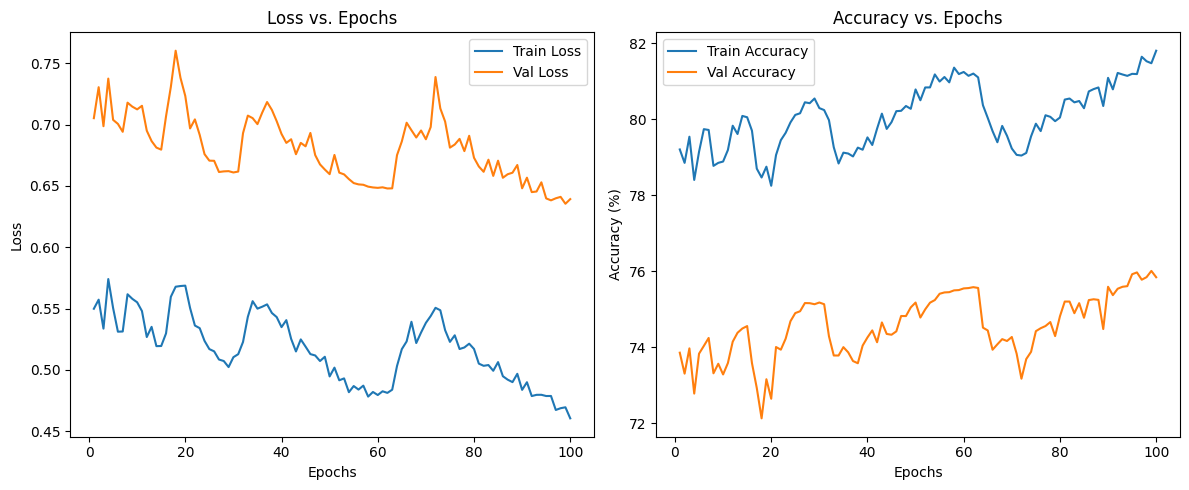

In [12]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100,scheduler)
#mobilenet_v2 - 3.train

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 1 | Train Loss:   0.4674 | Train Accuracy:   81.5405% | Train mIOU:   0.6987 | Train mF1:   0.8110 | Train Precision:   0.8067 | Train Recall:   0.8154


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


Epoch 1 | Val Loss:   0.6438 | Val Accuracy:   75.7198% | Val mIOU:   0.6167 | Val mF1:   0.7517 | Val Precision:   0.7463 | Val Recall:   0.7572


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 2 | Train Loss:   0.4848 | Train Accuracy:   81.0206% | Train mIOU:   0.6876 | Train mF1:   0.8056 | Train Precision:   0.8009 | Train Recall:   0.8102


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


Epoch 2 | Val Loss:   0.6496 | Val Accuracy:   75.5257% | Val mIOU:   0.6107 | Val mF1:   0.7496 | Val Precision:   0.7439 | Val Recall:   0.7553


100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch 3 | Train Loss:   0.4760 | Train Accuracy:   81.2316% | Train mIOU:   0.6969 | Train mF1:   0.8090 | Train Precision:   0.8056 | Train Recall:   0.8123


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]


Epoch 3 | Val Loss:   0.6418 | Val Accuracy:   75.6479% | Val mIOU:   0.6196 | Val mF1:   0.7531 | Val Precision:   0.7498 | Val Recall:   0.7565


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 4 | Train Loss:   0.4886 | Train Accuracy:   80.8788% | Train mIOU:   0.6856 | Train mF1:   0.8042 | Train Precision:   0.7997 | Train Recall:   0.8088


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 4 | Val Loss:   0.6655 | Val Accuracy:   75.4301% | Val mIOU:   0.6092 | Val mF1:   0.7488 | Val Precision:   0.7434 | Val Recall:   0.7543


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 5 | Train Loss:   0.4821 | Train Accuracy:   81.1304% | Train mIOU:   0.6909 | Train mF1:   0.8068 | Train Precision:   0.8024 | Train Recall:   0.8113


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 5 | Val Loss:   0.6650 | Val Accuracy:   75.2241% | Val mIOU:   0.6084 | Val mF1:   0.7478 | Val Precision:   0.7434 | Val Recall:   0.7522


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 6 | Train Loss:   0.4738 | Train Accuracy:   81.3707% | Train mIOU:   0.6971 | Train mF1:   0.8094 | Train Precision:   0.8051 | Train Recall:   0.8137


100%|██████████| 3/3 [00:00<00:00, 15.95it/s]


Epoch 6 | Val Loss:   0.6344 | Val Accuracy:   76.0638% | Val mIOU:   0.6230 | Val mF1:   0.7557 | Val Precision:   0.7508 | Val Recall:   0.7606


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 7 | Train Loss:   0.4723 | Train Accuracy:   81.4400% | Train mIOU:   0.6974 | Train mF1:   0.8098 | Train Precision:   0.8052 | Train Recall:   0.8144


100%|██████████| 3/3 [00:00<00:00, 16.82it/s]


Epoch 7 | Val Loss:   0.6307 | Val Accuracy:   76.1910% | Val mIOU:   0.6236 | Val mF1:   0.7567 | Val Precision:   0.7516 | Val Recall:   0.7619


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 8 | Train Loss:   0.4808 | Train Accuracy:   81.1558% | Train mIOU:   0.6896 | Train mF1:   0.8066 | Train Precision:   0.8018 | Train Recall:   0.8116


100%|██████████| 3/3 [00:00<00:00, 17.10it/s]


Epoch 8 | Val Loss:   0.6544 | Val Accuracy:   75.5353% | Val mIOU:   0.6102 | Val mF1:   0.7493 | Val Precision:   0.7434 | Val Recall:   0.7554


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 9 | Train Loss:   0.5037 | Train Accuracy:   80.3745% | Train mIOU:   0.6808 | Train mF1:   0.8002 | Train Precision:   0.7966 | Train Recall:   0.8037


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 9 | Val Loss:   0.6768 | Val Accuracy:   74.7611% | Val mIOU:   0.6031 | Val mF1:   0.7435 | Val Precision:   0.7394 | Val Recall:   0.7476


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 10 | Train Loss:   0.5062 | Train Accuracy:   80.2430% | Train mIOU:   0.6792 | Train mF1:   0.7981 | Train Precision:   0.7939 | Train Recall:   0.8024


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


Epoch 10 | Val Loss:   0.6871 | Val Accuracy:   74.5747% | Val mIOU:   0.5998 | Val mF1:   0.7422 | Val Precision:   0.7388 | Val Recall:   0.7457


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch 11 | Train Loss:   0.4857 | Train Accuracy:   80.9937% | Train mIOU:   0.6892 | Train mF1:   0.8058 | Train Precision:   0.8017 | Train Recall:   0.8099


100%|██████████| 3/3 [00:00<00:00, 16.17it/s]


Epoch 11 | Val Loss:   0.6469 | Val Accuracy:   75.4854% | Val mIOU:   0.6112 | Val mF1:   0.7482 | Val Precision:   0.7417 | Val Recall:   0.7549


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 12 | Train Loss:   0.4761 | Train Accuracy:   81.2419% | Train mIOU:   0.6946 | Train mF1:   0.8079 | Train Precision:   0.8034 | Train Recall:   0.8124


100%|██████████| 3/3 [00:00<00:00, 16.20it/s]


Epoch 12 | Val Loss:   0.6395 | Val Accuracy:   75.7796% | Val mIOU:   0.6188 | Val mF1:   0.7528 | Val Precision:   0.7478 | Val Recall:   0.7578


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 13 | Train Loss:   0.4632 | Train Accuracy:   81.7292% | Train mIOU:   0.7016 | Train mF1:   0.8132 | Train Precision:   0.8092 | Train Recall:   0.8173


100%|██████████| 3/3 [00:00<00:00, 16.14it/s]


Epoch 13 | Val Loss:   0.6316 | Val Accuracy:   75.9353% | Val mIOU:   0.6211 | Val mF1:   0.7546 | Val Precision:   0.7500 | Val Recall:   0.7594


100%|██████████| 12/12 [00:01<00:00,  8.74it/s]


Epoch 14 | Train Loss:   0.4638 | Train Accuracy:   81.6568% | Train mIOU:   0.7014 | Train mF1:   0.8125 | Train Precision:   0.8085 | Train Recall:   0.8166


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


Epoch 14 | Val Loss:   0.6290 | Val Accuracy:   76.1115% | Val mIOU:   0.6232 | Val mF1:   0.7565 | Val Precision:   0.7520 | Val Recall:   0.7611


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 15 | Train Loss:   0.4569 | Train Accuracy:   81.9270% | Train mIOU:   0.7042 | Train mF1:   0.8149 | Train Precision:   0.8106 | Train Recall:   0.8193


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 15 | Val Loss:   0.6286 | Val Accuracy:   76.1289% | Val mIOU:   0.6225 | Val mF1:   0.7563 | Val Precision:   0.7513 | Val Recall:   0.7613


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 16 | Train Loss:   0.4777 | Train Accuracy:   81.1469% | Train mIOU:   0.6958 | Train mF1:   0.8084 | Train Precision:   0.8054 | Train Recall:   0.8115


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


Epoch 16 | Val Loss:   0.6472 | Val Accuracy:   75.6284% | Val mIOU:   0.6191 | Val mF1:   0.7534 | Val Precision:   0.7506 | Val Recall:   0.7563


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 17 | Train Loss:   0.4817 | Train Accuracy:   81.0909% | Train mIOU:   0.6925 | Train mF1:   0.8066 | Train Precision:   0.8023 | Train Recall:   0.8109


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


Epoch 17 | Val Loss:   0.6472 | Val Accuracy:   75.6996% | Val mIOU:   0.6179 | Val mF1:   0.7520 | Val Precision:   0.7470 | Val Recall:   0.7570


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 18 | Train Loss:   0.5180 | Train Accuracy:   79.7900% | Train mIOU:   0.6784 | Train mF1:   0.7956 | Train Precision:   0.7933 | Train Recall:   0.7979


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 18 | Val Loss:   0.6951 | Val Accuracy:   73.9246% | Val mIOU:   0.6001 | Val mF1:   0.7380 | Val Precision:   0.7367 | Val Recall:   0.7392


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 19 | Train Loss:   0.5512 | Train Accuracy:   78.8166% | Train mIOU:   0.6667 | Train mF1:   0.7884 | Train Precision:   0.7887 | Train Recall:   0.7882


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 19 | Val Loss:   0.7432 | Val Accuracy:   72.3316% | Val mIOU:   0.5815 | Val mF1:   0.7254 | Val Precision:   0.7274 | Val Recall:   0.7233


100%|██████████| 12/12 [00:01<00:00,  8.66it/s]


Epoch 20 | Train Loss:   0.5117 | Train Accuracy:   80.2110% | Train mIOU:   0.6789 | Train mF1:   0.7976 | Train Precision:   0.7931 | Train Recall:   0.8021


100%|██████████| 3/3 [00:00<00:00, 16.71it/s]


Epoch 20 | Val Loss:   0.6781 | Val Accuracy:   74.8730% | Val mIOU:   0.6029 | Val mF1:   0.7436 | Val Precision:   0.7386 | Val Recall:   0.7487


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


Epoch 21 | Train Loss:   0.4955 | Train Accuracy:   80.6629% | Train mIOU:   0.6872 | Train mF1:   0.8026 | Train Precision:   0.7987 | Train Recall:   0.8066


100%|██████████| 3/3 [00:00<00:00, 16.10it/s]


Epoch 21 | Val Loss:   0.6605 | Val Accuracy:   75.3743% | Val mIOU:   0.6134 | Val mF1:   0.7499 | Val Precision:   0.7461 | Val Recall:   0.7537


100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch 22 | Train Loss:   0.4785 | Train Accuracy:   81.2233% | Train mIOU:   0.6935 | Train mF1:   0.8077 | Train Precision:   0.8032 | Train Recall:   0.8122


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 22 | Val Loss:   0.6492 | Val Accuracy:   75.7444% | Val mIOU:   0.6160 | Val mF1:   0.7526 | Val Precision:   0.7478 | Val Recall:   0.7574


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 23 | Train Loss:   0.4852 | Train Accuracy:   80.9544% | Train mIOU:   0.6904 | Train mF1:   0.8056 | Train Precision:   0.8017 | Train Recall:   0.8095


100%|██████████| 3/3 [00:00<00:00, 16.94it/s]


Epoch 23 | Val Loss:   0.6410 | Val Accuracy:   75.7953% | Val mIOU:   0.6178 | Val mF1:   0.7527 | Val Precision:   0.7476 | Val Recall:   0.7580


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 24 | Train Loss:   0.4670 | Train Accuracy:   81.5574% | Train mIOU:   0.6978 | Train mF1:   0.8109 | Train Precision:   0.8062 | Train Recall:   0.8156


100%|██████████| 3/3 [00:00<00:00, 16.95it/s]


Epoch 24 | Val Loss:   0.6302 | Val Accuracy:   76.1427% | Val mIOU:   0.6220 | Val mF1:   0.7561 | Val Precision:   0.7509 | Val Recall:   0.7614


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 25 | Train Loss:   0.4660 | Train Accuracy:   81.6177% | Train mIOU:   0.6994 | Train mF1:   0.8115 | Train Precision:   0.8068 | Train Recall:   0.8162


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 25 | Val Loss:   0.6222 | Val Accuracy:   76.4736% | Val mIOU:   0.6267 | Val mF1:   0.7593 | Val Precision:   0.7539 | Val Recall:   0.7647


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 26 | Train Loss:   0.4656 | Train Accuracy:   81.5652% | Train mIOU:   0.7001 | Train mF1:   0.8118 | Train Precision:   0.8080 | Train Recall:   0.8157


100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


Epoch 26 | Val Loss:   0.6258 | Val Accuracy:   76.2537% | Val mIOU:   0.6264 | Val mF1:   0.7587 | Val Precision:   0.7548 | Val Recall:   0.7625


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch 27 | Train Loss:   0.4616 | Train Accuracy:   81.7962% | Train mIOU:   0.7014 | Train mF1:   0.8134 | Train Precision:   0.8089 | Train Recall:   0.8180


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


Epoch 27 | Val Loss:   0.6186 | Val Accuracy:   76.5978% | Val mIOU:   0.6279 | Val mF1:   0.7610 | Val Precision:   0.7561 | Val Recall:   0.7660


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 28 | Train Loss:   0.4511 | Train Accuracy:   82.0787% | Train mIOU:   0.7068 | Train mF1:   0.8168 | Train Precision:   0.8128 | Train Recall:   0.8208


100%|██████████| 3/3 [00:00<00:00, 16.64it/s]


Epoch 28 | Val Loss:   0.6151 | Val Accuracy:   76.6597% | Val mIOU:   0.6300 | Val mF1:   0.7618 | Val Precision:   0.7570 | Val Recall:   0.7666


100%|██████████| 12/12 [00:01<00:00,  8.65it/s]


Epoch 29 | Train Loss:   0.4471 | Train Accuracy:   82.1958% | Train mIOU:   0.7080 | Train mF1:   0.8175 | Train Precision:   0.8131 | Train Recall:   0.8220


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


Epoch 29 | Val Loss:   0.6161 | Val Accuracy:   76.6309% | Val mIOU:   0.6293 | Val mF1:   0.7614 | Val Precision:   0.7565 | Val Recall:   0.7663


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 30 | Train Loss:   0.4468 | Train Accuracy:   82.2424% | Train mIOU:   0.7085 | Train mF1:   0.8181 | Train Precision:   0.8138 | Train Recall:   0.8224


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


Epoch 30 | Val Loss:   0.6158 | Val Accuracy:   76.6687% | Val mIOU:   0.6298 | Val mF1:   0.7619 | Val Precision:   0.7572 | Val Recall:   0.7667


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 31 | Train Loss:   0.4543 | Train Accuracy:   81.9810% | Train mIOU:   0.7048 | Train mF1:   0.8155 | Train Precision:   0.8113 | Train Recall:   0.8198


100%|██████████| 3/3 [00:00<00:00, 16.56it/s]


Epoch 31 | Val Loss:   0.6153 | Val Accuracy:   76.6793% | Val mIOU:   0.6301 | Val mF1:   0.7620 | Val Precision:   0.7573 | Val Recall:   0.7668


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 32 | Train Loss:   0.4665 | Train Accuracy:   81.5068% | Train mIOU:   0.6990 | Train mF1:   0.8112 | Train Precision:   0.8073 | Train Recall:   0.8151


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


Epoch 32 | Val Loss:   0.6433 | Val Accuracy:   75.7177% | Val mIOU:   0.6186 | Val mF1:   0.7530 | Val Precision:   0.7488 | Val Recall:   0.7572


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 33 | Train Loss:   0.4836 | Train Accuracy:   80.9931% | Train mIOU:   0.6894 | Train mF1:   0.8060 | Train Precision:   0.8020 | Train Recall:   0.8099


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 33 | Val Loss:   0.6481 | Val Accuracy:   75.5052% | Val mIOU:   0.6119 | Val mF1:   0.7506 | Val Precision:   0.7463 | Val Recall:   0.7551


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 34 | Train Loss:   0.4703 | Train Accuracy:   81.3472% | Train mIOU:   0.6914 | Train mF1:   0.8087 | Train Precision:   0.8040 | Train Recall:   0.8135


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]


Epoch 34 | Val Loss:   0.6409 | Val Accuracy:   75.8503% | Val mIOU:   0.6130 | Val mF1:   0.7521 | Val Precision:   0.7458 | Val Recall:   0.7585


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 35 | Train Loss:   0.4799 | Train Accuracy:   81.1218% | Train mIOU:   0.6890 | Train mF1:   0.8059 | Train Precision:   0.8006 | Train Recall:   0.8112


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


Epoch 35 | Val Loss:   0.6498 | Val Accuracy:   75.6672% | Val mIOU:   0.6122 | Val mF1:   0.7507 | Val Precision:   0.7449 | Val Recall:   0.7567


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 36 | Train Loss:   0.4919 | Train Accuracy:   80.7581% | Train mIOU:   0.6878 | Train mF1:   0.8034 | Train Precision:   0.7992 | Train Recall:   0.8076


100%|██████████| 3/3 [00:00<00:00, 16.08it/s]


Epoch 36 | Val Loss:   0.6485 | Val Accuracy:   75.7636% | Val mIOU:   0.6169 | Val mF1:   0.7529 | Val Precision:   0.7482 | Val Recall:   0.7576


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 37 | Train Loss:   0.4938 | Train Accuracy:   80.6868% | Train mIOU:   0.6847 | Train mF1:   0.8025 | Train Precision:   0.7982 | Train Recall:   0.8069


100%|██████████| 3/3 [00:00<00:00, 16.67it/s]


Epoch 37 | Val Loss:   0.6695 | Val Accuracy:   75.1767% | Val mIOU:   0.6067 | Val mF1:   0.7463 | Val Precision:   0.7409 | Val Recall:   0.7518


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 38 | Train Loss:   0.4935 | Train Accuracy:   80.6482% | Train mIOU:   0.6857 | Train mF1:   0.8024 | Train Precision:   0.7984 | Train Recall:   0.8065


100%|██████████| 3/3 [00:00<00:00, 16.73it/s]


Epoch 38 | Val Loss:   0.6555 | Val Accuracy:   75.3453% | Val mIOU:   0.6139 | Val mF1:   0.7490 | Val Precision:   0.7447 | Val Recall:   0.7535


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 39 | Train Loss:   0.4955 | Train Accuracy:   80.6294% | Train mIOU:   0.6876 | Train mF1:   0.8028 | Train Precision:   0.7994 | Train Recall:   0.8063


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


Epoch 39 | Val Loss:   0.6599 | Val Accuracy:   75.2556% | Val mIOU:   0.6143 | Val mF1:   0.7499 | Val Precision:   0.7473 | Val Recall:   0.7526


100%|██████████| 12/12 [00:01<00:00,  8.74it/s]


Epoch 40 | Train Loss:   0.4850 | Train Accuracy:   80.9195% | Train mIOU:   0.6930 | Train mF1:   0.8067 | Train Precision:   0.8042 | Train Recall:   0.8092


100%|██████████| 3/3 [00:00<00:00, 17.04it/s]


Epoch 40 | Val Loss:   0.6516 | Val Accuracy:   75.4304% | Val mIOU:   0.6173 | Val mF1:   0.7519 | Val Precision:   0.7495 | Val Recall:   0.7543


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 41 | Train Loss:   0.4823 | Train Accuracy:   81.0250% | Train mIOU:   0.6917 | Train mF1:   0.8061 | Train Precision:   0.8020 | Train Recall:   0.8103


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 41 | Val Loss:   0.6384 | Val Accuracy:   75.9544% | Val mIOU:   0.6199 | Val mF1:   0.7548 | Val Precision:   0.7502 | Val Recall:   0.7595


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 42 | Train Loss:   0.4774 | Train Accuracy:   81.2058% | Train mIOU:   0.6940 | Train mF1:   0.8075 | Train Precision:   0.8031 | Train Recall:   0.8121


100%|██████████| 3/3 [00:00<00:00, 15.45it/s]


Epoch 42 | Val Loss:   0.6432 | Val Accuracy:   75.6671% | Val mIOU:   0.6167 | Val mF1:   0.7513 | Val Precision:   0.7461 | Val Recall:   0.7567


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 43 | Train Loss:   0.4706 | Train Accuracy:   81.4469% | Train mIOU:   0.6976 | Train mF1:   0.8105 | Train Precision:   0.8067 | Train Recall:   0.8145


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


Epoch 43 | Val Loss:   0.6331 | Val Accuracy:   76.2263% | Val mIOU:   0.6232 | Val mF1:   0.7574 | Val Precision:   0.7526 | Val Recall:   0.7623


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 44 | Train Loss:   0.4661 | Train Accuracy:   81.5608% | Train mIOU:   0.6977 | Train mF1:   0.8113 | Train Precision:   0.8071 | Train Recall:   0.8156


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


Epoch 44 | Val Loss:   0.6448 | Val Accuracy:   75.9244% | Val mIOU:   0.6177 | Val mF1:   0.7547 | Val Precision:   0.7502 | Val Recall:   0.7592


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 45 | Train Loss:   0.4726 | Train Accuracy:   81.2667% | Train mIOU:   0.6966 | Train mF1:   0.8092 | Train Precision:   0.8057 | Train Recall:   0.8127


100%|██████████| 3/3 [00:00<00:00, 16.08it/s]


Epoch 45 | Val Loss:   0.6289 | Val Accuracy:   76.2271% | Val mIOU:   0.6262 | Val mF1:   0.7587 | Val Precision:   0.7551 | Val Recall:   0.7623


100%|██████████| 12/12 [00:01<00:00,  8.76it/s]


Epoch 46 | Train Loss:   0.4581 | Train Accuracy:   81.7796% | Train mIOU:   0.7047 | Train mF1:   0.8146 | Train Precision:   0.8114 | Train Recall:   0.8178


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 46 | Val Loss:   0.6294 | Val Accuracy:   76.0693% | Val mIOU:   0.6257 | Val mF1:   0.7577 | Val Precision:   0.7548 | Val Recall:   0.7607


100%|██████████| 12/12 [00:01<00:00,  8.73it/s]


Epoch 47 | Train Loss:   0.4614 | Train Accuracy:   81.6654% | Train mIOU:   0.7030 | Train mF1:   0.8135 | Train Precision:   0.8103 | Train Recall:   0.8167


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


Epoch 47 | Val Loss:   0.6295 | Val Accuracy:   76.1191% | Val mIOU:   0.6267 | Val mF1:   0.7587 | Val Precision:   0.7562 | Val Recall:   0.7612


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 48 | Train Loss:   0.4542 | Train Accuracy:   81.8970% | Train mIOU:   0.7052 | Train mF1:   0.8155 | Train Precision:   0.8120 | Train Recall:   0.8190


100%|██████████| 3/3 [00:00<00:00, 15.21it/s]


Epoch 48 | Val Loss:   0.6150 | Val Accuracy:   76.6177% | Val mIOU:   0.6303 | Val mF1:   0.7619 | Val Precision:   0.7578 | Val Recall:   0.7662


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 49 | Train Loss:   0.4569 | Train Accuracy:   81.8538% | Train mIOU:   0.7045 | Train mF1:   0.8147 | Train Precision:   0.8109 | Train Recall:   0.8185


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 49 | Val Loss:   0.6165 | Val Accuracy:   76.5545% | Val mIOU:   0.6306 | Val mF1:   0.7614 | Val Precision:   0.7573 | Val Recall:   0.7655


100%|██████████| 12/12 [00:01<00:00,  8.59it/s]


Epoch 50 | Train Loss:   0.4419 | Train Accuracy:   82.3793% | Train mIOU:   0.7099 | Train mF1:   0.8197 | Train Precision:   0.8157 | Train Recall:   0.8238


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


Epoch 50 | Val Loss:   0.6178 | Val Accuracy:   76.5811% | Val mIOU:   0.6289 | Val mF1:   0.7612 | Val Precision:   0.7566 | Val Recall:   0.7658


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 51 | Train Loss:   0.4429 | Train Accuracy:   82.3152% | Train mIOU:   0.7108 | Train mF1:   0.8195 | Train Precision:   0.8159 | Train Recall:   0.8232


100%|██████████| 3/3 [00:00<00:00, 16.91it/s]


Epoch 51 | Val Loss:   0.6167 | Val Accuracy:   76.6752% | Val mIOU:   0.6319 | Val mF1:   0.7631 | Val Precision:   0.7595 | Val Recall:   0.7668


100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch 52 | Train Loss:   0.4396 | Train Accuracy:   82.4385% | Train mIOU:   0.7114 | Train mF1:   0.8203 | Train Precision:   0.8163 | Train Recall:   0.8244


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 52 | Val Loss:   0.6119 | Val Accuracy:   76.8469% | Val mIOU:   0.6324 | Val mF1:   0.7636 | Val Precision:   0.7589 | Val Recall:   0.7685


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 53 | Train Loss:   0.4394 | Train Accuracy:   82.4359% | Train mIOU:   0.7116 | Train mF1:   0.8203 | Train Precision:   0.8163 | Train Recall:   0.8244


100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


Epoch 53 | Val Loss:   0.6109 | Val Accuracy:   76.9359% | Val mIOU:   0.6339 | Val mF1:   0.7646 | Val Precision:   0.7600 | Val Recall:   0.7694


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 54 | Train Loss:   0.4411 | Train Accuracy:   82.4062% | Train mIOU:   0.7123 | Train mF1:   0.8204 | Train Precision:   0.8167 | Train Recall:   0.8241


100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


Epoch 54 | Val Loss:   0.6080 | Val Accuracy:   76.9002% | Val mIOU:   0.6352 | Val mF1:   0.7648 | Val Precision:   0.7606 | Val Recall:   0.7690


100%|██████████| 12/12 [00:01<00:00,  8.66it/s]


Epoch 55 | Train Loss:   0.4305 | Train Accuracy:   82.7291% | Train mIOU:   0.7161 | Train mF1:   0.8234 | Train Precision:   0.8196 | Train Recall:   0.8273


100%|██████████| 3/3 [00:00<00:00, 16.85it/s]


Epoch 55 | Val Loss:   0.6085 | Val Accuracy:   77.0053% | Val mIOU:   0.6352 | Val mF1:   0.7656 | Val Precision:   0.7613 | Val Recall:   0.7701


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 56 | Train Loss:   0.4404 | Train Accuracy:   82.4361% | Train mIOU:   0.7129 | Train mF1:   0.8208 | Train Precision:   0.8174 | Train Recall:   0.8244


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 56 | Val Loss:   0.6051 | Val Accuracy:   77.0576% | Val mIOU:   0.6367 | Val mF1:   0.7663 | Val Precision:   0.7621 | Val Recall:   0.7706


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 57 | Train Loss:   0.4286 | Train Accuracy:   82.8089% | Train mIOU:   0.7185 | Train mF1:   0.8249 | Train Precision:   0.8217 | Train Recall:   0.8281


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Epoch 57 | Val Loss:   0.6050 | Val Accuracy:   77.0355% | Val mIOU:   0.6371 | Val mF1:   0.7665 | Val Precision:   0.7628 | Val Recall:   0.7704


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 58 | Train Loss:   0.4407 | Train Accuracy:   82.3670% | Train mIOU:   0.7108 | Train mF1:   0.8197 | Train Precision:   0.8157 | Train Recall:   0.8237


100%|██████████| 3/3 [00:00<00:00, 17.52it/s]


Epoch 58 | Val Loss:   0.6035 | Val Accuracy:   77.1612% | Val mIOU:   0.6370 | Val mF1:   0.7670 | Val Precision:   0.7624 | Val Recall:   0.7716


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 59 | Train Loss:   0.4314 | Train Accuracy:   82.6554% | Train mIOU:   0.7153 | Train mF1:   0.8225 | Train Precision:   0.8185 | Train Recall:   0.8266


100%|██████████| 3/3 [00:00<00:00, 17.20it/s]


Epoch 59 | Val Loss:   0.6026 | Val Accuracy:   77.1553% | Val mIOU:   0.6372 | Val mF1:   0.7670 | Val Precision:   0.7625 | Val Recall:   0.7716


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 60 | Train Loss:   0.4399 | Train Accuracy:   82.3860% | Train mIOU:   0.7116 | Train mF1:   0.8201 | Train Precision:   0.8164 | Train Recall:   0.8239


100%|██████████| 3/3 [00:00<00:00, 16.51it/s]


Epoch 60 | Val Loss:   0.6020 | Val Accuracy:   77.1743% | Val mIOU:   0.6376 | Val mF1:   0.7672 | Val Precision:   0.7628 | Val Recall:   0.7717


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 61 | Train Loss:   0.4358 | Train Accuracy:   82.5250% | Train mIOU:   0.7138 | Train mF1:   0.8214 | Train Precision:   0.8176 | Train Recall:   0.8252


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch 61 | Val Loss:   0.6021 | Val Accuracy:   77.1533% | Val mIOU:   0.6377 | Val mF1:   0.7671 | Val Precision:   0.7627 | Val Recall:   0.7715


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 62 | Train Loss:   0.4307 | Train Accuracy:   82.7446% | Train mIOU:   0.7169 | Train mF1:   0.8237 | Train Precision:   0.8199 | Train Recall:   0.8274


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 62 | Val Loss:   0.6026 | Val Accuracy:   77.1648% | Val mIOU:   0.6378 | Val mF1:   0.7673 | Val Precision:   0.7631 | Val Recall:   0.7716


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 63 | Train Loss:   0.4339 | Train Accuracy:   82.6202% | Train mIOU:   0.7151 | Train mF1:   0.8224 | Train Precision:   0.8186 | Train Recall:   0.8262


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


Epoch 63 | Val Loss:   0.6027 | Val Accuracy:   77.1636% | Val mIOU:   0.6376 | Val mF1:   0.7672 | Val Precision:   0.7629 | Val Recall:   0.7716


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 64 | Train Loss:   0.4563 | Train Accuracy:   81.8824% | Train mIOU:   0.7040 | Train mF1:   0.8156 | Train Precision:   0.8124 | Train Recall:   0.8188


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Epoch 64 | Val Loss:   0.6370 | Val Accuracy:   76.1392% | Val mIOU:   0.6243 | Val mF1:   0.7578 | Val Precision:   0.7542 | Val Recall:   0.7614


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch 65 | Train Loss:   0.4617 | Train Accuracy:   81.6689% | Train mIOU:   0.7038 | Train mF1:   0.8145 | Train Precision:   0.8124 | Train Recall:   0.8167


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


Epoch 65 | Val Loss:   0.6395 | Val Accuracy:   75.6850% | Val mIOU:   0.6223 | Val mF1:   0.7550 | Val Precision:   0.7532 | Val Recall:   0.7568


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 66 | Train Loss:   0.4757 | Train Accuracy:   81.1777% | Train mIOU:   0.6948 | Train mF1:   0.8089 | Train Precision:   0.8061 | Train Recall:   0.8118


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


Epoch 66 | Val Loss:   0.6523 | Val Accuracy:   75.5102% | Val mIOU:   0.6171 | Val mF1:   0.7528 | Val Precision:   0.7505 | Val Recall:   0.7551


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 67 | Train Loss:   0.4962 | Train Accuracy:   80.5463% | Train mIOU:   0.6878 | Train mF1:   0.8039 | Train Precision:   0.8023 | Train Recall:   0.8055


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


Epoch 67 | Val Loss:   0.6607 | Val Accuracy:   74.9372% | Val mIOU:   0.6100 | Val mF1:   0.7474 | Val Precision:   0.7454 | Val Recall:   0.7494


100%|██████████| 12/12 [00:01<00:00,  8.10it/s]


Epoch 68 | Train Loss:   0.4867 | Train Accuracy:   80.8910% | Train mIOU:   0.6859 | Train mF1:   0.8040 | Train Precision:   0.7991 | Train Recall:   0.8089


100%|██████████| 3/3 [00:00<00:00, 16.20it/s]


Epoch 68 | Val Loss:   0.6471 | Val Accuracy:   75.8587% | Val mIOU:   0.6150 | Val mF1:   0.7528 | Val Precision:   0.7470 | Val Recall:   0.7586


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 69 | Train Loss:   0.4895 | Train Accuracy:   80.8157% | Train mIOU:   0.6904 | Train mF1:   0.8056 | Train Precision:   0.8031 | Train Recall:   0.8082


100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


Epoch 69 | Val Loss:   0.6693 | Val Accuracy:   75.0231% | Val mIOU:   0.6112 | Val mF1:   0.7472 | Val Precision:   0.7443 | Val Recall:   0.7502


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 70 | Train Loss:   0.4901 | Train Accuracy:   80.7223% | Train mIOU:   0.6850 | Train mF1:   0.8034 | Train Precision:   0.7996 | Train Recall:   0.8072


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 70 | Val Loss:   0.6794 | Val Accuracy:   74.8053% | Val mIOU:   0.6028 | Val mF1:   0.7433 | Val Precision:   0.7385 | Val Recall:   0.7481


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 71 | Train Loss:   0.4807 | Train Accuracy:   80.9736% | Train mIOU:   0.6921 | Train mF1:   0.8063 | Train Precision:   0.8029 | Train Recall:   0.8097


100%|██████████| 3/3 [00:00<00:00, 16.24it/s]


Epoch 71 | Val Loss:   0.6415 | Val Accuracy:   75.7704% | Val mIOU:   0.6199 | Val mF1:   0.7535 | Val Precision:   0.7494 | Val Recall:   0.7577


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 72 | Train Loss:   0.4938 | Train Accuracy:   80.6890% | Train mIOU:   0.6874 | Train mF1:   0.8036 | Train Precision:   0.8004 | Train Recall:   0.8069


100%|██████████| 3/3 [00:00<00:00, 16.88it/s]


Epoch 72 | Val Loss:   0.6633 | Val Accuracy:   75.3743% | Val mIOU:   0.6132 | Val mF1:   0.7503 | Val Precision:   0.7469 | Val Recall:   0.7537


100%|██████████| 12/12 [00:01<00:00,  8.49it/s]


Epoch 73 | Train Loss:   0.4868 | Train Accuracy:   80.9428% | Train mIOU:   0.6877 | Train mF1:   0.8045 | Train Precision:   0.7996 | Train Recall:   0.8094


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 73 | Val Loss:   0.6535 | Val Accuracy:   75.7924% | Val mIOU:   0.6162 | Val mF1:   0.7525 | Val Precision:   0.7471 | Val Recall:   0.7579


100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch 74 | Train Loss:   0.4840 | Train Accuracy:   80.9218% | Train mIOU:   0.6948 | Train mF1:   0.8080 | Train Precision:   0.8068 | Train Recall:   0.8092


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 74 | Val Loss:   0.6499 | Val Accuracy:   75.3109% | Val mIOU:   0.6173 | Val mF1:   0.7521 | Val Precision:   0.7511 | Val Recall:   0.7531


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 75 | Train Loss:   0.4861 | Train Accuracy:   80.6682% | Train mIOU:   0.6904 | Train mF1:   0.8050 | Train Precision:   0.8033 | Train Recall:   0.8067


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 75 | Val Loss:   0.6698 | Val Accuracy:   74.7789% | Val mIOU:   0.6092 | Val mF1:   0.7472 | Val Precision:   0.7466 | Val Recall:   0.7478


100%|██████████| 12/12 [00:01<00:00,  8.16it/s]


Epoch 76 | Train Loss:   0.4875 | Train Accuracy:   80.9198% | Train mIOU:   0.6857 | Train mF1:   0.8041 | Train Precision:   0.7991 | Train Recall:   0.8092


100%|██████████| 3/3 [00:00<00:00, 16.20it/s]


Epoch 76 | Val Loss:   0.6572 | Val Accuracy:   75.4355% | Val mIOU:   0.6079 | Val mF1:   0.7479 | Val Precision:   0.7416 | Val Recall:   0.7544


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 77 | Train Loss:   0.4837 | Train Accuracy:   80.9900% | Train mIOU:   0.6911 | Train mF1:   0.8057 | Train Precision:   0.8015 | Train Recall:   0.8099


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 77 | Val Loss:   0.6501 | Val Accuracy:   75.5632% | Val mIOU:   0.6156 | Val mF1:   0.7510 | Val Precision:   0.7464 | Val Recall:   0.7556


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 78 | Train Loss:   0.4773 | Train Accuracy:   81.2408% | Train mIOU:   0.6952 | Train mF1:   0.8092 | Train Precision:   0.8061 | Train Recall:   0.8124


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 78 | Val Loss:   0.6563 | Val Accuracy:   75.3191% | Val mIOU:   0.6130 | Val mF1:   0.7502 | Val Precision:   0.7472 | Val Recall:   0.7532


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 79 | Train Loss:   0.4767 | Train Accuracy:   81.1969% | Train mIOU:   0.6965 | Train mF1:   0.8090 | Train Precision:   0.8060 | Train Recall:   0.8120


100%|██████████| 3/3 [00:00<00:00, 17.19it/s]


Epoch 79 | Val Loss:   0.6445 | Val Accuracy:   75.6033% | Val mIOU:   0.6190 | Val mF1:   0.7531 | Val Precision:   0.7501 | Val Recall:   0.7560


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 80 | Train Loss:   0.4765 | Train Accuracy:   81.1468% | Train mIOU:   0.6950 | Train mF1:   0.8083 | Train Precision:   0.8051 | Train Recall:   0.8115


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 80 | Val Loss:   0.6436 | Val Accuracy:   75.6998% | Val mIOU:   0.6188 | Val mF1:   0.7537 | Val Precision:   0.7503 | Val Recall:   0.7570


100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch 81 | Train Loss:   0.4735 | Train Accuracy:   81.2761% | Train mIOU:   0.6983 | Train mF1:   0.8106 | Train Precision:   0.8084 | Train Recall:   0.8128


100%|██████████| 3/3 [00:00<00:00, 17.35it/s]


Epoch 81 | Val Loss:   0.6405 | Val Accuracy:   75.7599% | Val mIOU:   0.6224 | Val mF1:   0.7556 | Val Precision:   0.7536 | Val Recall:   0.7576


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 82 | Train Loss:   0.4583 | Train Accuracy:   81.6537% | Train mIOU:   0.7034 | Train mF1:   0.8137 | Train Precision:   0.8109 | Train Recall:   0.8165


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Epoch 82 | Val Loss:   0.6332 | Val Accuracy:   75.8736% | Val mIOU:   0.6237 | Val mF1:   0.7561 | Val Precision:   0.7534 | Val Recall:   0.7587


100%|██████████| 12/12 [00:01<00:00,  8.63it/s]


Epoch 83 | Train Loss:   0.4601 | Train Accuracy:   81.7213% | Train mIOU:   0.7050 | Train mF1:   0.8152 | Train Precision:   0.8132 | Train Recall:   0.8172


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


Epoch 83 | Val Loss:   0.6297 | Val Accuracy:   76.0554% | Val mIOU:   0.6250 | Val mF1:   0.7575 | Val Precision:   0.7545 | Val Recall:   0.7606


100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Epoch 84 | Train Loss:   0.4587 | Train Accuracy:   81.7886% | Train mIOU:   0.6999 | Train mF1:   0.8133 | Train Precision:   0.8087 | Train Recall:   0.8179


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


Epoch 84 | Val Loss:   0.6332 | Val Accuracy:   76.3666% | Val mIOU:   0.6226 | Val mF1:   0.7586 | Val Precision:   0.7537 | Val Recall:   0.7637


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 85 | Train Loss:   0.4600 | Train Accuracy:   81.7016% | Train mIOU:   0.7015 | Train mF1:   0.8130 | Train Precision:   0.8090 | Train Recall:   0.8170


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 85 | Val Loss:   0.6295 | Val Accuracy:   76.1851% | Val mIOU:   0.6239 | Val mF1:   0.7567 | Val Precision:   0.7515 | Val Recall:   0.7619


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 86 | Train Loss:   0.4462 | Train Accuracy:   82.1772% | Train mIOU:   0.7076 | Train mF1:   0.8176 | Train Precision:   0.8135 | Train Recall:   0.8218


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Epoch 86 | Val Loss:   0.6151 | Val Accuracy:   76.6000% | Val mIOU:   0.6285 | Val mF1:   0.7610 | Val Precision:   0.7561 | Val Recall:   0.7660


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 87 | Train Loss:   0.4478 | Train Accuracy:   82.1107% | Train mIOU:   0.7063 | Train mF1:   0.8173 | Train Precision:   0.8135 | Train Recall:   0.8211


100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


Epoch 87 | Val Loss:   0.6294 | Val Accuracy:   76.4304% | Val mIOU:   0.6258 | Val mF1:   0.7606 | Val Precision:   0.7570 | Val Recall:   0.7643


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 88 | Train Loss:   0.4517 | Train Accuracy:   81.9836% | Train mIOU:   0.7062 | Train mF1:   0.8163 | Train Precision:   0.8127 | Train Recall:   0.8198


100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


Epoch 88 | Val Loss:   0.6266 | Val Accuracy:   76.2148% | Val mIOU:   0.6257 | Val mF1:   0.7584 | Val Precision:   0.7546 | Val Recall:   0.7621


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch 89 | Train Loss:   0.4466 | Train Accuracy:   82.1563% | Train mIOU:   0.7096 | Train mF1:   0.8186 | Train Precision:   0.8157 | Train Recall:   0.8216


100%|██████████| 3/3 [00:00<00:00, 17.40it/s]


Epoch 89 | Val Loss:   0.6153 | Val Accuracy:   76.6278% | Val mIOU:   0.6327 | Val mF1:   0.7633 | Val Precision:   0.7603 | Val Recall:   0.7663


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 90 | Train Loss:   0.4458 | Train Accuracy:   82.1628% | Train mIOU:   0.7087 | Train mF1:   0.8179 | Train Precision:   0.8141 | Train Recall:   0.8216


100%|██████████| 3/3 [00:00<00:00, 15.47it/s]


Epoch 90 | Val Loss:   0.6098 | Val Accuracy:   76.7542% | Val mIOU:   0.6320 | Val mF1:   0.7627 | Val Precision:   0.7579 | Val Recall:   0.7675


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 91 | Train Loss:   0.4430 | Train Accuracy:   82.3323% | Train mIOU:   0.7111 | Train mF1:   0.8201 | Train Precision:   0.8169 | Train Recall:   0.8233


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 91 | Val Loss:   0.6219 | Val Accuracy:   76.5898% | Val mIOU:   0.6298 | Val mF1:   0.7620 | Val Precision:   0.7582 | Val Recall:   0.7659


100%|██████████| 12/12 [00:01<00:00,  8.68it/s]


Epoch 92 | Train Loss:   0.4392 | Train Accuracy:   82.4158% | Train mIOU:   0.7121 | Train mF1:   0.8208 | Train Precision:   0.8174 | Train Recall:   0.8242


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 92 | Val Loss:   0.6152 | Val Accuracy:   76.7834% | Val mIOU:   0.6318 | Val mF1:   0.7637 | Val Precision:   0.7596 | Val Recall:   0.7678


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 93 | Train Loss:   0.4412 | Train Accuracy:   82.3557% | Train mIOU:   0.7125 | Train mF1:   0.8207 | Train Precision:   0.8178 | Train Recall:   0.8236


100%|██████████| 3/3 [00:00<00:00, 15.65it/s]


Epoch 93 | Val Loss:   0.6198 | Val Accuracy:   76.5763% | Val mIOU:   0.6303 | Val mF1:   0.7622 | Val Precision:   0.7587 | Val Recall:   0.7658


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 94 | Train Loss:   0.4287 | Train Accuracy:   82.8165% | Train mIOU:   0.7162 | Train mF1:   0.8246 | Train Precision:   0.8210 | Train Recall:   0.8282


100%|██████████| 3/3 [00:00<00:00, 17.26it/s]


Epoch 94 | Val Loss:   0.6230 | Val Accuracy:   76.6258% | Val mIOU:   0.6289 | Val mF1:   0.7622 | Val Precision:   0.7581 | Val Recall:   0.7663


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 95 | Train Loss:   0.4362 | Train Accuracy:   82.4297% | Train mIOU:   0.7116 | Train mF1:   0.8204 | Train Precision:   0.8165 | Train Recall:   0.8243


100%|██████████| 3/3 [00:00<00:00, 16.39it/s]


Epoch 95 | Val Loss:   0.6071 | Val Accuracy:   76.8651% | Val mIOU:   0.6330 | Val mF1:   0.7639 | Val Precision:   0.7592 | Val Recall:   0.7687


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 96 | Train Loss:   0.4348 | Train Accuracy:   82.5335% | Train mIOU:   0.7143 | Train mF1:   0.8221 | Train Precision:   0.8189 | Train Recall:   0.8253


100%|██████████| 3/3 [00:00<00:00, 15.31it/s]


Epoch 96 | Val Loss:   0.6066 | Val Accuracy:   76.8984% | Val mIOU:   0.6351 | Val mF1:   0.7655 | Val Precision:   0.7620 | Val Recall:   0.7690


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 97 | Train Loss:   0.4347 | Train Accuracy:   82.5618% | Train mIOU:   0.7148 | Train mF1:   0.8226 | Train Precision:   0.8197 | Train Recall:   0.8256


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


Epoch 97 | Val Loss:   0.6075 | Val Accuracy:   77.0150% | Val mIOU:   0.6360 | Val mF1:   0.7667 | Val Precision:   0.7633 | Val Recall:   0.7702


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 98 | Train Loss:   0.4275 | Train Accuracy:   82.7993% | Train mIOU:   0.7184 | Train mF1:   0.8250 | Train Precision:   0.8220 | Train Recall:   0.8280


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


Epoch 98 | Val Loss:   0.6057 | Val Accuracy:   77.0264% | Val mIOU:   0.6363 | Val mF1:   0.7668 | Val Precision:   0.7634 | Val Recall:   0.7703


100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch 99 | Train Loss:   0.4258 | Train Accuracy:   82.8553% | Train mIOU:   0.7176 | Train mF1:   0.8250 | Train Precision:   0.8214 | Train Recall:   0.8286


100%|██████████| 3/3 [00:00<00:00, 17.22it/s]


Epoch 99 | Val Loss:   0.5982 | Val Accuracy:   77.2463% | Val mIOU:   0.6371 | Val mF1:   0.7678 | Val Precision:   0.7632 | Val Recall:   0.7725


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 100 | Train Loss:   0.4260 | Train Accuracy:   82.7885% | Train mIOU:   0.7181 | Train mF1:   0.8246 | Train Precision:   0.8214 | Train Recall:   0.8279


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


Epoch 100 | Val Loss:   0.5979 | Val Accuracy:   77.2579% | Val mIOU:   0.6394 | Val mF1:   0.7688 | Val Precision:   0.7651 | Val Recall:   0.7726


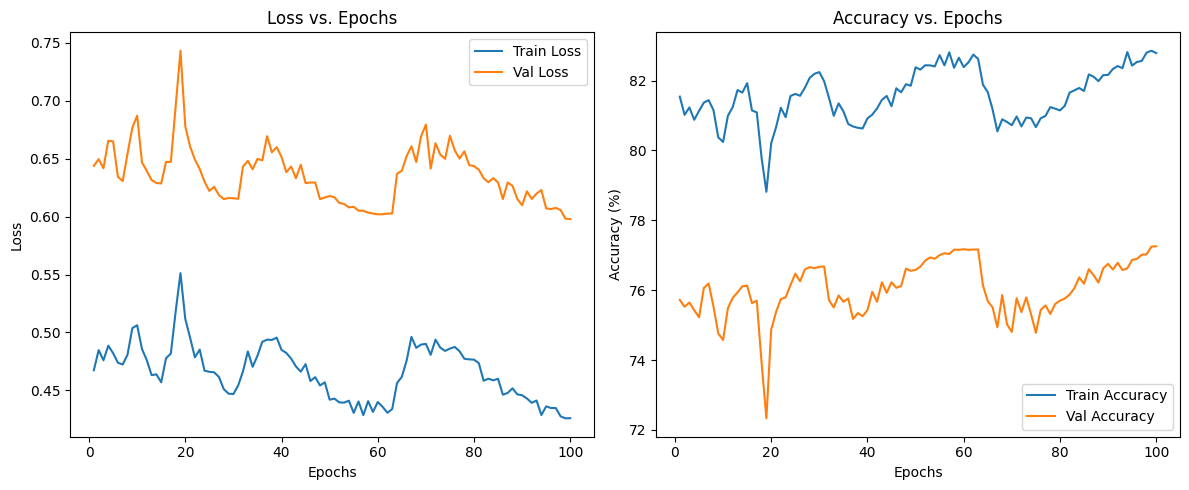

In [13]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100,scheduler)
#mobilenet_v2 - 4.train

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  7.47it/s]


Epoch 1 | Train Loss:   2.7231 | Train Accuracy:   18.0512% | Train mIOU:   0.0609 | Train mF1:   0.1689 | Train Precision:   0.1587 | Train Recall:   0.1805


100%|██████████| 3/3 [00:00<00:00, 11.20it/s]


Epoch 1 | Val Loss:   2.8364 | Val Accuracy:   12.7305% | Val mIOU:   0.0361 | Val mF1:   0.1410 | Val Precision:   0.1579 | Val Recall:   0.1273


100%|██████████| 12/12 [00:01<00:00,  8.24it/s]


Epoch 2 | Train Loss:   2.8851 | Train Accuracy:   17.2036% | Train mIOU:   0.0591 | Train mF1:   0.1687 | Train Precision:   0.1654 | Train Recall:   0.1720


100%|██████████| 3/3 [00:00<00:00, 16.44it/s]


Epoch 2 | Val Loss:   3.0263 | Val Accuracy:   12.4460% | Val mIOU:   0.0344 | Val mF1:   0.1486 | Val Precision:   0.1842 | Val Recall:   0.1245


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 3 | Train Loss:   2.6630 | Train Accuracy:   18.6972% | Train mIOU:   0.0704 | Train mF1:   0.2027 | Train Precision:   0.2212 | Train Recall:   0.1870


100%|██████████| 3/3 [00:00<00:00, 15.37it/s]


Epoch 3 | Val Loss:   2.8458 | Val Accuracy:   12.2716% | Val mIOU:   0.0404 | Val mF1:   0.1672 | Val Precision:   0.2622 | Val Recall:   0.1227


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Epoch 4 | Train Loss:   2.4150 | Train Accuracy:   23.8071% | Train mIOU:   0.1074 | Train mF1:   0.2690 | Train Precision:   0.3092 | Train Recall:   0.2381


100%|██████████| 3/3 [00:00<00:00, 15.75it/s]


Epoch 4 | Val Loss:   2.5864 | Val Accuracy:   15.6333% | Val mIOU:   0.0711 | Val mF1:   0.2064 | Val Precision:   0.3035 | Val Recall:   0.1563


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 5 | Train Loss:   2.2520 | Train Accuracy:   31.0269% | Train mIOU:   0.1713 | Train mF1:   0.3385 | Train Precision:   0.3723 | Train Recall:   0.3103


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


Epoch 5 | Val Loss:   2.4197 | Val Accuracy:   22.2555% | Val mIOU:   0.1249 | Val mF1:   0.2720 | Val Precision:   0.3498 | Val Recall:   0.2226


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 6 | Train Loss:   2.1407 | Train Accuracy:   35.4172% | Train mIOU:   0.2177 | Train mF1:   0.3767 | Train Precision:   0.4022 | Train Recall:   0.3542


100%|██████████| 3/3 [00:00<00:00, 16.05it/s]


Epoch 6 | Val Loss:   2.3395 | Val Accuracy:   26.2820% | Val mIOU:   0.1614 | Val mF1:   0.3064 | Val Precision:   0.3673 | Val Recall:   0.2628


100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 7 | Train Loss:   2.1308 | Train Accuracy:   36.5510% | Train mIOU:   0.2294 | Train mF1:   0.3850 | Train Precision:   0.4068 | Train Recall:   0.3655


100%|██████████| 3/3 [00:00<00:00, 16.08it/s]


Epoch 7 | Val Loss:   2.3187 | Val Accuracy:   27.5459% | Val mIOU:   0.1717 | Val mF1:   0.3166 | Val Precision:   0.3721 | Val Recall:   0.2755


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 8 | Train Loss:   2.0249 | Train Accuracy:   42.8652% | Train mIOU:   0.2751 | Train mF1:   0.4260 | Train Precision:   0.4234 | Train Recall:   0.4287


100%|██████████| 3/3 [00:00<00:00, 17.27it/s]


Epoch 8 | Val Loss:   2.2326 | Val Accuracy:   34.2093% | Val mIOU:   0.2171 | Val mF1:   0.3629 | Val Precision:   0.3865 | Val Recall:   0.3421


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 9 | Train Loss:   1.9189 | Train Accuracy:   48.1869% | Train mIOU:   0.3144 | Train mF1:   0.4599 | Train Precision:   0.4398 | Train Recall:   0.4819


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Epoch 9 | Val Loss:   2.1067 | Val Accuracy:   40.9823% | Val mIOU:   0.2622 | Val mF1:   0.4038 | Val Precision:   0.3980 | Val Recall:   0.4098


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Epoch 10 | Train Loss:   1.8540 | Train Accuracy:   50.6003% | Train mIOU:   0.3296 | Train mF1:   0.4750 | Train Precision:   0.4475 | Train Recall:   0.5060


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 10 | Val Loss:   2.0464 | Val Accuracy:   43.1098% | Val mIOU:   0.2678 | Val mF1:   0.4146 | Val Precision:   0.3993 | Val Recall:   0.4311


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 11 | Train Loss:   1.8195 | Train Accuracy:   51.9061% | Train mIOU:   0.3357 | Train mF1:   0.4813 | Train Precision:   0.4486 | Train Recall:   0.5191


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 11 | Val Loss:   2.0064 | Val Accuracy:   44.9011% | Val mIOU:   0.2788 | Val mF1:   0.4263 | Val Precision:   0.4058 | Val Recall:   0.4490


100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 12 | Train Loss:   1.7832 | Train Accuracy:   53.1597% | Train mIOU:   0.3440 | Train mF1:   0.4898 | Train Precision:   0.4541 | Train Recall:   0.5316


100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


Epoch 12 | Val Loss:   1.9670 | Val Accuracy:   46.4491% | Val mIOU:   0.2859 | Val mF1:   0.4347 | Val Precision:   0.4084 | Val Recall:   0.4645


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 13 | Train Loss:   1.7650 | Train Accuracy:   53.8089% | Train mIOU:   0.3504 | Train mF1:   0.4931 | Train Precision:   0.4551 | Train Recall:   0.5381


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 13 | Val Loss:   1.9601 | Val Accuracy:   46.8282% | Val mIOU:   0.2890 | Val mF1:   0.4371 | Val Precision:   0.4098 | Val Recall:   0.4683


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 14 | Train Loss:   1.7615 | Train Accuracy:   54.0467% | Train mIOU:   0.3502 | Train mF1:   0.4951 | Train Precision:   0.4567 | Train Recall:   0.5405


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch 14 | Val Loss:   1.9539 | Val Accuracy:   46.9850% | Val mIOU:   0.2889 | Val mF1:   0.4378 | Val Precision:   0.4098 | Val Recall:   0.4699


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Epoch 15 | Train Loss:   1.7650 | Train Accuracy:   53.6688% | Train mIOU:   0.3470 | Train mF1:   0.4916 | Train Precision:   0.4534 | Train Recall:   0.5367


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


Epoch 15 | Val Loss:   1.9554 | Val Accuracy:   46.9745% | Val mIOU:   0.2890 | Val mF1:   0.4376 | Val Precision:   0.4096 | Val Recall:   0.4697


100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch 16 | Train Loss:   1.7100 | Train Accuracy:   55.0963% | Train mIOU:   0.3562 | Train mF1:   0.5021 | Train Precision:   0.4612 | Train Recall:   0.5510


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 16 | Val Loss:   1.8784 | Val Accuracy:   48.8360% | Val mIOU:   0.2980 | Val mF1:   0.4472 | Val Precision:   0.4124 | Val Recall:   0.4884


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 17 | Train Loss:   1.6720 | Train Accuracy:   55.2971% | Train mIOU:   0.3559 | Train mF1:   0.5018 | Train Precision:   0.4594 | Train Recall:   0.5530


100%|██████████| 3/3 [00:00<00:00, 16.08it/s]


Epoch 17 | Val Loss:   1.8454 | Val Accuracy:   49.2131% | Val mIOU:   0.3012 | Val mF1:   0.4483 | Val Precision:   0.4117 | Val Recall:   0.4921


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 18 | Train Loss:   1.6115 | Train Accuracy:   56.9985% | Train mIOU:   0.3723 | Train mF1:   0.5147 | Train Precision:   0.4692 | Train Recall:   0.5700


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Epoch 18 | Val Loss:   1.7812 | Val Accuracy:   51.1217% | Val mIOU:   0.3148 | Val mF1:   0.4621 | Val Precision:   0.4215 | Val Recall:   0.5112


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 19 | Train Loss:   1.5849 | Train Accuracy:   57.5852% | Train mIOU:   0.3782 | Train mF1:   0.5230 | Train Precision:   0.4790 | Train Recall:   0.5759


100%|██████████| 3/3 [00:00<00:00, 16.70it/s]


Epoch 19 | Val Loss:   1.7556 | Val Accuracy:   51.6957% | Val mIOU:   0.3192 | Val mF1:   0.4646 | Val Precision:   0.4218 | Val Recall:   0.5170


100%|██████████| 12/12 [00:01<00:00,  8.22it/s]


Epoch 20 | Train Loss:   1.5516 | Train Accuracy:   58.3714% | Train mIOU:   0.3870 | Train mF1:   0.5309 | Train Precision:   0.4868 | Train Recall:   0.5837


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


Epoch 20 | Val Loss:   1.7303 | Val Accuracy:   52.1013% | Val mIOU:   0.3255 | Val mF1:   0.4719 | Val Precision:   0.4312 | Val Recall:   0.5210


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 21 | Train Loss:   1.5208 | Train Accuracy:   59.3988% | Train mIOU:   0.3983 | Train mF1:   0.5421 | Train Precision:   0.4985 | Train Recall:   0.5940


100%|██████████| 3/3 [00:00<00:00, 15.95it/s]


Epoch 21 | Val Loss:   1.6970 | Val Accuracy:   53.4851% | Val mIOU:   0.3388 | Val mF1:   0.4836 | Val Precision:   0.4412 | Val Recall:   0.5349


100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch 22 | Train Loss:   1.4845 | Train Accuracy:   60.3799% | Train mIOU:   0.4079 | Train mF1:   0.5495 | Train Precision:   0.5041 | Train Recall:   0.6038


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 22 | Val Loss:   1.6552 | Val Accuracy:   54.3476% | Val mIOU:   0.3423 | Val mF1:   0.4926 | Val Precision:   0.4505 | Val Recall:   0.5435


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 23 | Train Loss:   1.4701 | Train Accuracy:   60.4782% | Train mIOU:   0.4088 | Train mF1:   0.5545 | Train Precision:   0.5120 | Train Recall:   0.6048


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 23 | Val Loss:   1.6379 | Val Accuracy:   54.6813% | Val mIOU:   0.3451 | Val mF1:   0.4987 | Val Precision:   0.4583 | Val Recall:   0.5468


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 24 | Train Loss:   1.4467 | Train Accuracy:   61.1192% | Train mIOU:   0.4164 | Train mF1:   0.5609 | Train Precision:   0.5183 | Train Recall:   0.6112


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


Epoch 24 | Val Loss:   1.6144 | Val Accuracy:   55.1609% | Val mIOU:   0.3499 | Val mF1:   0.5057 | Val Precision:   0.4669 | Val Recall:   0.5516


100%|██████████| 12/12 [00:01<00:00,  8.30it/s]


Epoch 25 | Train Loss:   1.4336 | Train Accuracy:   61.1878% | Train mIOU:   0.4168 | Train mF1:   0.5643 | Train Precision:   0.5236 | Train Recall:   0.6119


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Epoch 25 | Val Loss:   1.5998 | Val Accuracy:   55.4575% | Val mIOU:   0.3537 | Val mF1:   0.5131 | Val Precision:   0.4773 | Val Recall:   0.5546


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 26 | Train Loss:   1.4218 | Train Accuracy:   61.5985% | Train mIOU:   0.4233 | Train mF1:   0.5682 | Train Precision:   0.5272 | Train Recall:   0.6160


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 26 | Val Loss:   1.5923 | Val Accuracy:   55.6250% | Val mIOU:   0.3561 | Val mF1:   0.5152 | Val Precision:   0.4798 | Val Recall:   0.5562


100%|██████████| 12/12 [00:01<00:00,  8.26it/s]


Epoch 27 | Train Loss:   1.4215 | Train Accuracy:   61.6285% | Train mIOU:   0.4209 | Train mF1:   0.5645 | Train Precision:   0.5207 | Train Recall:   0.6163


100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


Epoch 27 | Val Loss:   1.5924 | Val Accuracy:   55.6127% | Val mIOU:   0.3563 | Val mF1:   0.5165 | Val Precision:   0.4821 | Val Recall:   0.5561


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 28 | Train Loss:   1.4082 | Train Accuracy:   61.9139% | Train mIOU:   0.4256 | Train mF1:   0.5734 | Train Precision:   0.5339 | Train Recall:   0.6191


100%|██████████| 3/3 [00:00<00:00, 16.63it/s]


Epoch 28 | Val Loss:   1.5845 | Val Accuracy:   55.7438% | Val mIOU:   0.3570 | Val mF1:   0.5171 | Val Precision:   0.4823 | Val Recall:   0.5574


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 29 | Train Loss:   1.4133 | Train Accuracy:   61.7868% | Train mIOU:   0.4242 | Train mF1:   0.5699 | Train Precision:   0.5288 | Train Recall:   0.6179


100%|██████████| 3/3 [00:00<00:00, 16.73it/s]


Epoch 29 | Val Loss:   1.5820 | Val Accuracy:   55.8117% | Val mIOU:   0.3580 | Val mF1:   0.5178 | Val Precision:   0.4829 | Val Recall:   0.5581


100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 30 | Train Loss:   1.4075 | Train Accuracy:   62.0091% | Train mIOU:   0.4268 | Train mF1:   0.5707 | Train Precision:   0.5285 | Train Recall:   0.6201


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


Epoch 30 | Val Loss:   1.5777 | Val Accuracy:   55.9147% | Val mIOU:   0.3580 | Val mF1:   0.5171 | Val Precision:   0.4810 | Val Recall:   0.5591


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch 31 | Train Loss:   1.4145 | Train Accuracy:   61.6778% | Train mIOU:   0.4235 | Train mF1:   0.5715 | Train Precision:   0.5324 | Train Recall:   0.6168


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 31 | Val Loss:   1.5817 | Val Accuracy:   55.8043% | Val mIOU:   0.3578 | Val mF1:   0.5167 | Val Precision:   0.4811 | Val Recall:   0.5580


100%|██████████| 12/12 [00:01<00:00,  8.25it/s]


Epoch 32 | Train Loss:   1.3853 | Train Accuracy:   62.4950% | Train mIOU:   0.4327 | Train mF1:   0.5788 | Train Precision:   0.5390 | Train Recall:   0.6250


100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


Epoch 32 | Val Loss:   1.5539 | Val Accuracy:   56.1689% | Val mIOU:   0.3615 | Val mF1:   0.5193 | Val Precision:   0.4829 | Val Recall:   0.5617


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 33 | Train Loss:   1.3578 | Train Accuracy:   62.9912% | Train mIOU:   0.4385 | Train mF1:   0.5851 | Train Precision:   0.5462 | Train Recall:   0.6299


100%|██████████| 3/3 [00:00<00:00, 16.09it/s]


Epoch 33 | Val Loss:   1.5273 | Val Accuracy:   56.4061% | Val mIOU:   0.3625 | Val mF1:   0.5201 | Val Precision:   0.4825 | Val Recall:   0.5641


100%|██████████| 12/12 [00:01<00:00,  8.24it/s]


Epoch 34 | Train Loss:   1.3498 | Train Accuracy:   63.1119% | Train mIOU:   0.4407 | Train mF1:   0.5854 | Train Precision:   0.5459 | Train Recall:   0.6311


100%|██████████| 3/3 [00:00<00:00, 16.28it/s]


Epoch 34 | Val Loss:   1.5293 | Val Accuracy:   56.1135% | Val mIOU:   0.3644 | Val mF1:   0.5184 | Val Precision:   0.4817 | Val Recall:   0.5611


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


Epoch 35 | Train Loss:   1.3188 | Train Accuracy:   63.6076% | Train mIOU:   0.4456 | Train mF1:   0.5888 | Train Precision:   0.5481 | Train Recall:   0.6361


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 35 | Val Loss:   1.4846 | Val Accuracy:   57.1032% | Val mIOU:   0.3698 | Val mF1:   0.5247 | Val Precision:   0.4853 | Val Recall:   0.5710


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 36 | Train Loss:   1.2974 | Train Accuracy:   63.8566% | Train mIOU:   0.4501 | Train mF1:   0.5917 | Train Precision:   0.5513 | Train Recall:   0.6386


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Epoch 36 | Val Loss:   1.4615 | Val Accuracy:   57.8631% | Val mIOU:   0.3816 | Val mF1:   0.5295 | Val Precision:   0.4880 | Val Recall:   0.5786


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 37 | Train Loss:   1.2657 | Train Accuracy:   64.3645% | Train mIOU:   0.4559 | Train mF1:   0.5975 | Train Precision:   0.5575 | Train Recall:   0.6436


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


Epoch 37 | Val Loss:   1.4269 | Val Accuracy:   58.5563% | Val mIOU:   0.3884 | Val mF1:   0.5358 | Val Precision:   0.4939 | Val Recall:   0.5856


100%|██████████| 12/12 [00:01<00:00,  8.24it/s]


Epoch 38 | Train Loss:   1.2574 | Train Accuracy:   64.3551% | Train mIOU:   0.4522 | Train mF1:   0.5937 | Train Precision:   0.5510 | Train Recall:   0.6436


100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


Epoch 38 | Val Loss:   1.4170 | Val Accuracy:   58.4164% | Val mIOU:   0.3836 | Val mF1:   0.5377 | Val Precision:   0.4980 | Val Recall:   0.5842


100%|██████████| 12/12 [00:01<00:00,  8.35it/s]


Epoch 39 | Train Loss:   1.2343 | Train Accuracy:   64.7587% | Train mIOU:   0.4602 | Train mF1:   0.5988 | Train Precision:   0.5568 | Train Recall:   0.6476


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


Epoch 39 | Val Loss:   1.4003 | Val Accuracy:   58.5320% | Val mIOU:   0.3860 | Val mF1:   0.5340 | Val Precision:   0.4910 | Val Recall:   0.5853


100%|██████████| 12/12 [00:01<00:00,  8.27it/s]


Epoch 40 | Train Loss:   1.2346 | Train Accuracy:   64.8101% | Train mIOU:   0.4590 | Train mF1:   0.5993 | Train Precision:   0.5573 | Train Recall:   0.6481


100%|██████████| 3/3 [00:00<00:00, 16.09it/s]


Epoch 40 | Val Loss:   1.3914 | Val Accuracy:   58.7783% | Val mIOU:   0.3885 | Val mF1:   0.5348 | Val Precision:   0.4906 | Val Recall:   0.5878


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 41 | Train Loss:   1.2140 | Train Accuracy:   65.2362% | Train mIOU:   0.4649 | Train mF1:   0.6028 | Train Precision:   0.5602 | Train Recall:   0.6524


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Epoch 41 | Val Loss:   1.3795 | Val Accuracy:   59.0243% | Val mIOU:   0.3905 | Val mF1:   0.5394 | Val Precision:   0.4966 | Val Recall:   0.5902


100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 42 | Train Loss:   1.2047 | Train Accuracy:   65.5623% | Train mIOU:   0.4676 | Train mF1:   0.6054 | Train Precision:   0.5623 | Train Recall:   0.6556


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 42 | Val Loss:   1.3657 | Val Accuracy:   59.4578% | Val mIOU:   0.3969 | Val mF1:   0.5436 | Val Precision:   0.5006 | Val Recall:   0.5946


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 43 | Train Loss:   1.1885 | Train Accuracy:   65.8711% | Train mIOU:   0.4717 | Train mF1:   0.6093 | Train Precision:   0.5668 | Train Recall:   0.6587


100%|██████████| 3/3 [00:00<00:00, 15.75it/s]


Epoch 43 | Val Loss:   1.3550 | Val Accuracy:   59.4783% | Val mIOU:   0.3979 | Val mF1:   0.5420 | Val Precision:   0.4978 | Val Recall:   0.5948


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 44 | Train Loss:   1.1757 | Train Accuracy:   66.1466% | Train mIOU:   0.4761 | Train mF1:   0.6127 | Train Precision:   0.5707 | Train Recall:   0.6615


100%|██████████| 3/3 [00:00<00:00, 15.69it/s]


Epoch 44 | Val Loss:   1.3401 | Val Accuracy:   59.7478% | Val mIOU:   0.4008 | Val mF1:   0.5438 | Val Precision:   0.4989 | Val Recall:   0.5975


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


Epoch 45 | Train Loss:   1.1667 | Train Accuracy:   66.1596% | Train mIOU:   0.4769 | Train mF1:   0.6117 | Train Precision:   0.5688 | Train Recall:   0.6616


100%|██████████| 3/3 [00:00<00:00, 16.56it/s]


Epoch 45 | Val Loss:   1.3290 | Val Accuracy:   59.9115% | Val mIOU:   0.4037 | Val mF1:   0.5452 | Val Precision:   0.5002 | Val Recall:   0.5991


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 46 | Train Loss:   1.1571 | Train Accuracy:   66.1645% | Train mIOU:   0.4752 | Train mF1:   0.6123 | Train Precision:   0.5698 | Train Recall:   0.6616


100%|██████████| 3/3 [00:00<00:00, 15.34it/s]


Epoch 46 | Val Loss:   1.3192 | Val Accuracy:   59.8985% | Val mIOU:   0.4000 | Val mF1:   0.5430 | Val Precision:   0.4966 | Val Recall:   0.5990


100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 47 | Train Loss:   1.1511 | Train Accuracy:   66.4167% | Train mIOU:   0.4784 | Train mF1:   0.6140 | Train Precision:   0.5708 | Train Recall:   0.6642


100%|██████████| 3/3 [00:00<00:00, 16.28it/s]


Epoch 47 | Val Loss:   1.3131 | Val Accuracy:   60.0775% | Val mIOU:   0.4023 | Val mF1:   0.5450 | Val Precision:   0.4987 | Val Recall:   0.6008


100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 48 | Train Loss:   1.1501 | Train Accuracy:   66.5487% | Train mIOU:   0.4804 | Train mF1:   0.6172 | Train Precision:   0.5754 | Train Recall:   0.6655


100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


Epoch 48 | Val Loss:   1.3075 | Val Accuracy:   60.3380% | Val mIOU:   0.4072 | Val mF1:   0.5485 | Val Precision:   0.5028 | Val Recall:   0.6034


100%|██████████| 12/12 [00:01<00:00,  8.37it/s]


Epoch 49 | Train Loss:   1.1385 | Train Accuracy:   66.6815% | Train mIOU:   0.4817 | Train mF1:   0.6173 | Train Precision:   0.5746 | Train Recall:   0.6668


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


Epoch 49 | Val Loss:   1.3015 | Val Accuracy:   60.4160% | Val mIOU:   0.4072 | Val mF1:   0.5497 | Val Precision:   0.5043 | Val Recall:   0.6042


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch 50 | Train Loss:   1.1363 | Train Accuracy:   66.7639% | Train mIOU:   0.4814 | Train mF1:   0.6181 | Train Precision:   0.5754 | Train Recall:   0.6676


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 50 | Val Loss:   1.3008 | Val Accuracy:   60.3230% | Val mIOU:   0.4056 | Val mF1:   0.5488 | Val Precision:   0.5034 | Val Recall:   0.6032


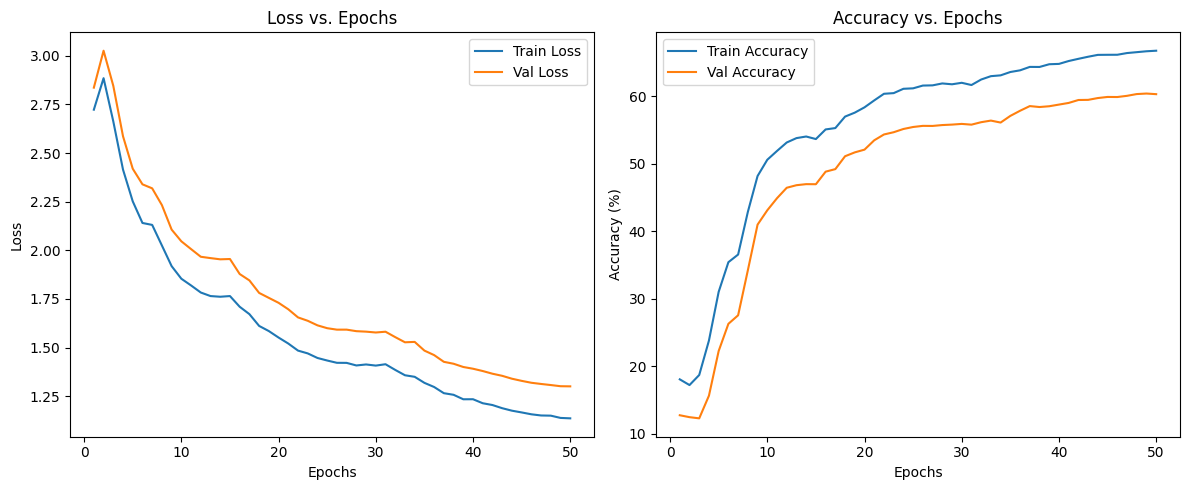

In [26]:
train_0(model_unet, train_dataloader, val_dataloader, criterion, optimizer,50,scheduler)
#mobilenetv2

In [ ]:
train_0(model_unet, train_dataloader, val_dataloader, criterion, optimizer,50,scheduler)
#mobilenetv2 2.train

In [17]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Define the Unet++ model with ResNet-101 encoder
model_unet = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2",         # use ResNet-101 as the encoder
    encoder_weights="imagenet",       # use pre-trained weights on ImageNet
    in_channels=6,                    # number of input channels (MSI + SAR)
    classes=14                        # number of output classes (for segmentation)
)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unet = model_unet.to(device)

loss_fn = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=1e-3)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=1e-8)


In [ ]:
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=1e-4)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  7.82it/s]


Epoch 1 | Train Loss:   2.8416 | Train Accuracy:   18.8169% | Train mIOU:   0.0780 | Train mF1:   0.1832 | Train Precision:   0.1786 | Train Recall:   0.1882


100%|██████████| 3/3 [00:00<00:00,  9.04it/s]


Epoch 1 | Val Loss:   3.0727 | Val Accuracy:   13.6700% | Val mIOU:   0.0586 | Val mF1:   0.1564 | Val Precision:   0.1826 | Val Recall:   0.1367


100%|██████████| 12/12 [00:01<00:00,  8.85it/s]


Epoch 2 | Train Loss:   5.0009 | Train Accuracy:   23.5549% | Train mIOU:   0.0632 | Train mF1:   0.2428 | Train Precision:   0.2504 | Train Recall:   0.2355


100%|██████████| 3/3 [00:00<00:00, 15.69it/s]


Epoch 2 | Val Loss:   5.5090 | Val Accuracy:   17.0774% | Val mIOU:   0.0362 | Val mF1:   0.1882 | Val Precision:   0.2095 | Val Recall:   0.1708


100%|██████████| 12/12 [00:01<00:00,  9.03it/s]


Epoch 3 | Train Loss:   2.5388 | Train Accuracy:   36.0196% | Train mIOU:   0.1679 | Train mF1:   0.3627 | Train Precision:   0.3653 | Train Recall:   0.3602


100%|██████████| 3/3 [00:00<00:00, 15.61it/s]


Epoch 3 | Val Loss:   2.6491 | Val Accuracy:   30.4887% | Val mIOU:   0.1250 | Val mF1:   0.3075 | Val Precision:   0.3102 | Val Recall:   0.3049


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 4 | Train Loss:   1.6933 | Train Accuracy:   48.5509% | Train mIOU:   0.2751 | Train mF1:   0.4566 | Train Precision:   0.4309 | Train Recall:   0.4855


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 4 | Val Loss:   1.7620 | Val Accuracy:   46.1994% | Val mIOU:   0.2550 | Val mF1:   0.4325 | Val Precision:   0.4065 | Val Recall:   0.4620


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch 5 | Train Loss:   1.2309 | Train Accuracy:   62.0111% | Train mIOU:   0.4214 | Train mF1:   0.5649 | Train Precision:   0.5187 | Train Recall:   0.6201


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 5 | Val Loss:   1.3451 | Val Accuracy:   56.4573% | Val mIOU:   0.3605 | Val mF1:   0.5082 | Val Precision:   0.4621 | Val Recall:   0.5646


100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 6 | Train Loss:   1.1789 | Train Accuracy:   63.2624% | Train mIOU:   0.4390 | Train mF1:   0.5827 | Train Precision:   0.5401 | Train Recall:   0.6326


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Epoch 6 | Val Loss:   1.2966 | Val Accuracy:   57.3104% | Val mIOU:   0.3732 | Val mF1:   0.5211 | Val Precision:   0.4777 | Val Recall:   0.5731


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 7 | Train Loss:   1.1375 | Train Accuracy:   64.4536% | Train mIOU:   0.4519 | Train mF1:   0.5974 | Train Precision:   0.5566 | Train Recall:   0.6445


100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


Epoch 7 | Val Loss:   1.2534 | Val Accuracy:   58.9506% | Val mIOU:   0.3889 | Val mF1:   0.5381 | Val Precision:   0.4949 | Val Recall:   0.5895


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 8 | Train Loss:   1.0887 | Train Accuracy:   65.5153% | Train mIOU:   0.4644 | Train mF1:   0.6051 | Train Precision:   0.5621 | Train Recall:   0.6552


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


Epoch 8 | Val Loss:   1.2023 | Val Accuracy:   60.0725% | Val mIOU:   0.3952 | Val mF1:   0.5460 | Val Precision:   0.5003 | Val Recall:   0.6007


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 9 | Train Loss:   1.0646 | Train Accuracy:   65.8114% | Train mIOU:   0.4791 | Train mF1:   0.6225 | Train Precision:   0.5905 | Train Recall:   0.6581


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


Epoch 9 | Val Loss:   1.1780 | Val Accuracy:   61.2540% | Val mIOU:   0.4162 | Val mF1:   0.5654 | Val Precision:   0.5250 | Val Recall:   0.6125


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 10 | Train Loss:   1.0351 | Train Accuracy:   66.8380% | Train mIOU:   0.4826 | Train mF1:   0.6243 | Train Precision:   0.5857 | Train Recall:   0.6684


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 10 | Val Loss:   1.1631 | Val Accuracy:   61.0635% | Val mIOU:   0.4111 | Val mF1:   0.5655 | Val Precision:   0.5265 | Val Recall:   0.6106


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 11 | Train Loss:   1.0394 | Train Accuracy:   66.5955% | Train mIOU:   0.4889 | Train mF1:   0.6267 | Train Precision:   0.5918 | Train Recall:   0.6660


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 11 | Val Loss:   1.1547 | Val Accuracy:   61.7371% | Val mIOU:   0.4234 | Val mF1:   0.5719 | Val Precision:   0.5326 | Val Recall:   0.6174


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 12 | Train Loss:   1.0535 | Train Accuracy:   66.4795% | Train mIOU:   0.4839 | Train mF1:   0.6308 | Train Precision:   0.6001 | Train Recall:   0.6648


100%|██████████| 3/3 [00:00<00:00, 17.11it/s]


Epoch 12 | Val Loss:   1.1927 | Val Accuracy:   60.5841% | Val mIOU:   0.4122 | Val mF1:   0.5732 | Val Precision:   0.5439 | Val Recall:   0.6058


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 13 | Train Loss:   0.9852 | Train Accuracy:   67.9742% | Train mIOU:   0.4995 | Train mF1:   0.6484 | Train Precision:   0.6198 | Train Recall:   0.6797


100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


Epoch 13 | Val Loss:   1.1101 | Val Accuracy:   62.6274% | Val mIOU:   0.4296 | Val mF1:   0.5961 | Val Precision:   0.5687 | Val Recall:   0.6263


100%|██████████| 12/12 [00:01<00:00,  8.91it/s]


Epoch 14 | Train Loss:   0.9876 | Train Accuracy:   68.0009% | Train mIOU:   0.5010 | Train mF1:   0.6510 | Train Precision:   0.6243 | Train Recall:   0.6800


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 14 | Val Loss:   1.1317 | Val Accuracy:   62.2000% | Val mIOU:   0.4286 | Val mF1:   0.5893 | Val Precision:   0.5599 | Val Recall:   0.6220


100%|██████████| 12/12 [00:01<00:00,  8.95it/s]


Epoch 15 | Train Loss:   0.9750 | Train Accuracy:   68.1407% | Train mIOU:   0.4990 | Train mF1:   0.6522 | Train Precision:   0.6255 | Train Recall:   0.6814


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


Epoch 15 | Val Loss:   1.1182 | Val Accuracy:   62.5812% | Val mIOU:   0.4292 | Val mF1:   0.5985 | Val Precision:   0.5734 | Val Recall:   0.6258


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 16 | Train Loss:   0.9514 | Train Accuracy:   68.8676% | Train mIOU:   0.5092 | Train mF1:   0.6531 | Train Precision:   0.6210 | Train Recall:   0.6887


100%|██████████| 3/3 [00:00<00:00, 15.40it/s]


Epoch 16 | Val Loss:   1.0896 | Val Accuracy:   63.3308% | Val mIOU:   0.4394 | Val mF1:   0.5977 | Val Precision:   0.5659 | Val Recall:   0.6333


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 17 | Train Loss:   0.9390 | Train Accuracy:   69.1901% | Train mIOU:   0.5174 | Train mF1:   0.6634 | Train Precision:   0.6371 | Train Recall:   0.6919


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 17 | Val Loss:   1.0776 | Val Accuracy:   63.5631% | Val mIOU:   0.4454 | Val mF1:   0.6063 | Val Precision:   0.5795 | Val Recall:   0.6356


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch 18 | Train Loss:   0.9311 | Train Accuracy:   69.2417% | Train mIOU:   0.5121 | Train mF1:   0.6638 | Train Precision:   0.6375 | Train Recall:   0.6924


100%|██████████| 3/3 [00:00<00:00, 16.12it/s]


Epoch 18 | Val Loss:   1.0735 | Val Accuracy:   63.5350% | Val mIOU:   0.4419 | Val mF1:   0.6099 | Val Precision:   0.5865 | Val Recall:   0.6354


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 19 | Train Loss:   0.9131 | Train Accuracy:   70.0306% | Train mIOU:   0.5265 | Train mF1:   0.6736 | Train Precision:   0.6488 | Train Recall:   0.7003


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 19 | Val Loss:   1.0569 | Val Accuracy:   64.2433% | Val mIOU:   0.4545 | Val mF1:   0.6145 | Val Precision:   0.5889 | Val Recall:   0.6424


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 20 | Train Loss:   0.8930 | Train Accuracy:   70.1392% | Train mIOU:   0.5272 | Train mF1:   0.6768 | Train Precision:   0.6539 | Train Recall:   0.7014


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 20 | Val Loss:   1.0471 | Val Accuracy:   63.9126% | Val mIOU:   0.4511 | Val mF1:   0.6145 | Val Precision:   0.5918 | Val Recall:   0.6391


100%|██████████| 12/12 [00:01<00:00,  8.86it/s]


Epoch 21 | Train Loss:   0.8976 | Train Accuracy:   69.9342% | Train mIOU:   0.5241 | Train mF1:   0.6731 | Train Precision:   0.6487 | Train Recall:   0.6993


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 21 | Val Loss:   1.0596 | Val Accuracy:   64.0118% | Val mIOU:   0.4511 | Val mF1:   0.6165 | Val Precision:   0.5946 | Val Recall:   0.6401


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


Epoch 22 | Train Loss:   0.8695 | Train Accuracy:   70.8225% | Train mIOU:   0.5365 | Train mF1:   0.6845 | Train Precision:   0.6624 | Train Recall:   0.7082


100%|██████████| 3/3 [00:00<00:00, 16.31it/s]


Epoch 22 | Val Loss:   1.0226 | Val Accuracy:   65.0030% | Val mIOU:   0.4632 | Val mF1:   0.6293 | Val Precision:   0.6099 | Val Recall:   0.6500


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Epoch 23 | Train Loss:   0.8708 | Train Accuracy:   70.9128% | Train mIOU:   0.5344 | Train mF1:   0.6836 | Train Precision:   0.6598 | Train Recall:   0.7091


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 23 | Val Loss:   1.0245 | Val Accuracy:   65.2903% | Val mIOU:   0.4621 | Val mF1:   0.6274 | Val Precision:   0.6037 | Val Recall:   0.6529


100%|██████████| 12/12 [00:01<00:00,  9.01it/s]


Epoch 24 | Train Loss:   0.9227 | Train Accuracy:   69.4319% | Train mIOU:   0.5164 | Train mF1:   0.6698 | Train Precision:   0.6469 | Train Recall:   0.6943


100%|██████████| 3/3 [00:00<00:00, 15.57it/s]


Epoch 24 | Val Loss:   1.0481 | Val Accuracy:   64.2895% | Val mIOU:   0.4470 | Val mF1:   0.6215 | Val Precision:   0.6014 | Val Recall:   0.6429


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 25 | Train Loss:   0.8823 | Train Accuracy:   70.2531% | Train mIOU:   0.5352 | Train mF1:   0.6825 | Train Precision:   0.6636 | Train Recall:   0.7025


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


Epoch 25 | Val Loss:   1.0439 | Val Accuracy:   64.1273% | Val mIOU:   0.4578 | Val mF1:   0.6250 | Val Precision:   0.6095 | Val Recall:   0.6413


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 26 | Train Loss:   0.8987 | Train Accuracy:   69.6626% | Train mIOU:   0.5262 | Train mF1:   0.6765 | Train Precision:   0.6576 | Train Recall:   0.6966


100%|██████████| 3/3 [00:00<00:00, 15.84it/s]


Epoch 26 | Val Loss:   1.0598 | Val Accuracy:   63.4070% | Val mIOU:   0.4540 | Val mF1:   0.6208 | Val Precision:   0.6081 | Val Recall:   0.6341


100%|██████████| 12/12 [00:01<00:00,  9.17it/s]


Epoch 27 | Train Loss:   0.8651 | Train Accuracy:   70.7630% | Train mIOU:   0.5407 | Train mF1:   0.6923 | Train Precision:   0.6776 | Train Recall:   0.7076


100%|██████████| 3/3 [00:00<00:00, 15.50it/s]


Epoch 27 | Val Loss:   1.0033 | Val Accuracy:   65.2589% | Val mIOU:   0.4699 | Val mF1:   0.6358 | Val Precision:   0.6198 | Val Recall:   0.6526


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 28 | Train Loss:   0.8497 | Train Accuracy:   71.1704% | Train mIOU:   0.5425 | Train mF1:   0.6898 | Train Precision:   0.6693 | Train Recall:   0.7117


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 28 | Val Loss:   0.9970 | Val Accuracy:   65.0742% | Val mIOU:   0.4673 | Val mF1:   0.6314 | Val Precision:   0.6131 | Val Recall:   0.6507


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 29 | Train Loss:   0.8311 | Train Accuracy:   71.6551% | Train mIOU:   0.5543 | Train mF1:   0.6952 | Train Precision:   0.6750 | Train Recall:   0.7166


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Epoch 29 | Val Loss:   0.9844 | Val Accuracy:   65.6774% | Val mIOU:   0.4812 | Val mF1:   0.6385 | Val Precision:   0.6212 | Val Recall:   0.6568


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 30 | Train Loss:   0.8102 | Train Accuracy:   72.4826% | Train mIOU:   0.5653 | Train mF1:   0.7075 | Train Precision:   0.6910 | Train Recall:   0.7248


100%|██████████| 3/3 [00:00<00:00, 15.69it/s]


Epoch 30 | Val Loss:   0.9609 | Val Accuracy:   66.8518% | Val mIOU:   0.4938 | Val mF1:   0.6518 | Val Precision:   0.6359 | Val Recall:   0.6685


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 31 | Train Loss:   0.8086 | Train Accuracy:   72.3336% | Train mIOU:   0.5600 | Train mF1:   0.7032 | Train Precision:   0.6842 | Train Recall:   0.7233


100%|██████████| 3/3 [00:00<00:00, 15.53it/s]


Epoch 31 | Val Loss:   0.9703 | Val Accuracy:   66.5104% | Val mIOU:   0.4885 | Val mF1:   0.6462 | Val Precision:   0.6284 | Val Recall:   0.6651


100%|██████████| 12/12 [00:01<00:00,  9.39it/s]


Epoch 32 | Train Loss:   0.8097 | Train Accuracy:   72.2523% | Train mIOU:   0.5649 | Train mF1:   0.7074 | Train Precision:   0.6930 | Train Recall:   0.7225


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 32 | Val Loss:   0.9888 | Val Accuracy:   65.6549% | Val mIOU:   0.4833 | Val mF1:   0.6456 | Val Precision:   0.6350 | Val Recall:   0.6565


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 33 | Train Loss:   0.7927 | Train Accuracy:   72.7189% | Train mIOU:   0.5665 | Train mF1:   0.7077 | Train Precision:   0.6892 | Train Recall:   0.7272


100%|██████████| 3/3 [00:00<00:00, 16.71it/s]


Epoch 33 | Val Loss:   0.9683 | Val Accuracy:   66.1968% | Val mIOU:   0.4841 | Val mF1:   0.6425 | Val Precision:   0.6242 | Val Recall:   0.6620


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 34 | Train Loss:   0.7852 | Train Accuracy:   72.7985% | Train mIOU:   0.5713 | Train mF1:   0.7114 | Train Precision:   0.6955 | Train Recall:   0.7280


100%|██████████| 3/3 [00:00<00:00, 16.49it/s]


Epoch 34 | Val Loss:   0.9538 | Val Accuracy:   66.6504% | Val mIOU:   0.4944 | Val mF1:   0.6507 | Val Precision:   0.6357 | Val Recall:   0.6665


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 35 | Train Loss:   0.7936 | Train Accuracy:   72.6742% | Train mIOU:   0.5673 | Train mF1:   0.7112 | Train Precision:   0.6964 | Train Recall:   0.7267


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 35 | Val Loss:   0.9634 | Val Accuracy:   66.3532% | Val mIOU:   0.4864 | Val mF1:   0.6470 | Val Precision:   0.6314 | Val Recall:   0.6635


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 36 | Train Loss:   0.7760 | Train Accuracy:   73.1183% | Train mIOU:   0.5761 | Train mF1:   0.7145 | Train Precision:   0.6985 | Train Recall:   0.7312


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 36 | Val Loss:   0.9465 | Val Accuracy:   66.8465% | Val mIOU:   0.4991 | Val mF1:   0.6519 | Val Precision:   0.6361 | Val Recall:   0.6685


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 37 | Train Loss:   0.7700 | Train Accuracy:   73.3067% | Train mIOU:   0.5807 | Train mF1:   0.7191 | Train Precision:   0.7056 | Train Recall:   0.7331


100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Epoch 37 | Val Loss:   0.9407 | Val Accuracy:   67.0648% | Val mIOU:   0.5028 | Val mF1:   0.6581 | Val Precision:   0.6460 | Val Recall:   0.6706


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch 38 | Train Loss:   0.7512 | Train Accuracy:   74.0845% | Train mIOU:   0.5818 | Train mF1:   0.7232 | Train Precision:   0.7064 | Train Recall:   0.7408


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 38 | Val Loss:   0.9256 | Val Accuracy:   67.6895% | Val mIOU:   0.4992 | Val mF1:   0.6596 | Val Precision:   0.6432 | Val Recall:   0.6769


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 39 | Train Loss:   0.7483 | Train Accuracy:   74.1239% | Train mIOU:   0.5829 | Train mF1:   0.7246 | Train Precision:   0.7086 | Train Recall:   0.7412


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 39 | Val Loss:   0.9216 | Val Accuracy:   67.7982% | Val mIOU:   0.4994 | Val mF1:   0.6600 | Val Precision:   0.6430 | Val Recall:   0.6780


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 40 | Train Loss:   0.7509 | Train Accuracy:   73.7497% | Train mIOU:   0.5786 | Train mF1:   0.7223 | Train Precision:   0.7077 | Train Recall:   0.7375


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 40 | Val Loss:   0.9287 | Val Accuracy:   67.3933% | Val mIOU:   0.4977 | Val mF1:   0.6584 | Val Precision:   0.6436 | Val Recall:   0.6739


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 41 | Train Loss:   0.7464 | Train Accuracy:   74.0247% | Train mIOU:   0.5831 | Train mF1:   0.7240 | Train Precision:   0.7084 | Train Recall:   0.7402


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 41 | Val Loss:   0.9229 | Val Accuracy:   67.6743% | Val mIOU:   0.5062 | Val mF1:   0.6624 | Val Precision:   0.6487 | Val Recall:   0.6767


100%|██████████| 12/12 [00:01<00:00,  8.78it/s]


Epoch 42 | Train Loss:   0.7146 | Train Accuracy:   74.9719% | Train mIOU:   0.5986 | Train mF1:   0.7369 | Train Precision:   0.7245 | Train Recall:   0.7497


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


Epoch 42 | Val Loss:   0.8826 | Val Accuracy:   68.8069% | Val mIOU:   0.5186 | Val mF1:   0.6745 | Val Precision:   0.6614 | Val Recall:   0.6881


100%|██████████| 12/12 [00:01<00:00,  9.03it/s]


Epoch 43 | Train Loss:   0.7037 | Train Accuracy:   75.2859% | Train mIOU:   0.6004 | Train mF1:   0.7399 | Train Precision:   0.7273 | Train Recall:   0.7529


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 43 | Val Loss:   0.8868 | Val Accuracy:   68.5284% | Val mIOU:   0.5118 | Val mF1:   0.6709 | Val Precision:   0.6572 | Val Recall:   0.6853


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 44 | Train Loss:   0.6976 | Train Accuracy:   75.4062% | Train mIOU:   0.6088 | Train mF1:   0.7411 | Train Precision:   0.7286 | Train Recall:   0.7541


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


Epoch 44 | Val Loss:   0.8838 | Val Accuracy:   68.8803% | Val mIOU:   0.5254 | Val mF1:   0.6758 | Val Precision:   0.6633 | Val Recall:   0.6888


100%|██████████| 12/12 [00:01<00:00,  9.09it/s]


Epoch 45 | Train Loss:   0.7248 | Train Accuracy:   74.6358% | Train mIOU:   0.5947 | Train mF1:   0.7323 | Train Precision:   0.7188 | Train Recall:   0.7464


100%|██████████| 3/3 [00:00<00:00, 17.13it/s]


Epoch 45 | Val Loss:   0.9069 | Val Accuracy:   67.9988% | Val mIOU:   0.5085 | Val mF1:   0.6654 | Val Precision:   0.6514 | Val Recall:   0.6800


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 46 | Train Loss:   0.7137 | Train Accuracy:   74.7837% | Train mIOU:   0.6010 | Train mF1:   0.7353 | Train Precision:   0.7233 | Train Recall:   0.7478


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 46 | Val Loss:   0.9024 | Val Accuracy:   67.8977% | Val mIOU:   0.5133 | Val mF1:   0.6671 | Val Precision:   0.6556 | Val Recall:   0.6790


100%|██████████| 12/12 [00:01<00:00,  9.50it/s]


Epoch 47 | Train Loss:   0.7212 | Train Accuracy:   74.7374% | Train mIOU:   0.6006 | Train mF1:   0.7343 | Train Precision:   0.7217 | Train Recall:   0.7474


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


Epoch 47 | Val Loss:   0.9031 | Val Accuracy:   68.2367% | Val mIOU:   0.5170 | Val mF1:   0.6700 | Val Precision:   0.6581 | Val Recall:   0.6824


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 48 | Train Loss:   0.6963 | Train Accuracy:   75.5340% | Train mIOU:   0.6054 | Train mF1:   0.7434 | Train Precision:   0.7319 | Train Recall:   0.7553


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Epoch 48 | Val Loss:   0.8830 | Val Accuracy:   69.0464% | Val mIOU:   0.5204 | Val mF1:   0.6766 | Val Precision:   0.6633 | Val Recall:   0.6905


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 49 | Train Loss:   0.7221 | Train Accuracy:   74.8079% | Train mIOU:   0.6073 | Train mF1:   0.7388 | Train Precision:   0.7297 | Train Recall:   0.7481


100%|██████████| 3/3 [00:00<00:00, 16.52it/s]


Epoch 49 | Val Loss:   0.9143 | Val Accuracy:   68.1016% | Val mIOU:   0.5234 | Val mF1:   0.6716 | Val Precision:   0.6625 | Val Recall:   0.6810


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 50 | Train Loss:   0.6940 | Train Accuracy:   75.6254% | Train mIOU:   0.6092 | Train mF1:   0.7445 | Train Precision:   0.7331 | Train Recall:   0.7563


100%|██████████| 3/3 [00:00<00:00, 16.24it/s]


Epoch 50 | Val Loss:   0.8749 | Val Accuracy:   69.0066% | Val mIOU:   0.5247 | Val mF1:   0.6768 | Val Precision:   0.6640 | Val Recall:   0.6901


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 51 | Train Loss:   0.6919 | Train Accuracy:   75.5417% | Train mIOU:   0.6147 | Train mF1:   0.7445 | Train Precision:   0.7339 | Train Recall:   0.7554


100%|██████████| 3/3 [00:00<00:00, 15.30it/s]


Epoch 51 | Val Loss:   0.8864 | Val Accuracy:   68.1946% | Val mIOU:   0.5240 | Val mF1:   0.6717 | Val Precision:   0.6618 | Val Recall:   0.6819


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 52 | Train Loss:   0.6809 | Train Accuracy:   75.8623% | Train mIOU:   0.6107 | Train mF1:   0.7472 | Train Precision:   0.7362 | Train Recall:   0.7586


100%|██████████| 3/3 [00:00<00:00, 16.49it/s]


Epoch 52 | Val Loss:   0.8627 | Val Accuracy:   69.2761% | Val mIOU:   0.5241 | Val mF1:   0.6802 | Val Precision:   0.6680 | Val Recall:   0.6928


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 53 | Train Loss:   0.6644 | Train Accuracy:   76.3881% | Train mIOU:   0.6199 | Train mF1:   0.7521 | Train Precision:   0.7407 | Train Recall:   0.7639


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 53 | Val Loss:   0.8613 | Val Accuracy:   69.3065% | Val mIOU:   0.5301 | Val mF1:   0.6802 | Val Precision:   0.6678 | Val Recall:   0.6931


100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 54 | Train Loss:   0.6675 | Train Accuracy:   76.1906% | Train mIOU:   0.6184 | Train mF1:   0.7511 | Train Precision:   0.7407 | Train Recall:   0.7619


100%|██████████| 3/3 [00:00<00:00, 14.81it/s]


Epoch 54 | Val Loss:   0.8651 | Val Accuracy:   68.9820% | Val mIOU:   0.5267 | Val mF1:   0.6776 | Val Precision:   0.6659 | Val Recall:   0.6898


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 55 | Train Loss:   0.6738 | Train Accuracy:   76.0978% | Train mIOU:   0.6143 | Train mF1:   0.7485 | Train Precision:   0.7365 | Train Recall:   0.7610


100%|██████████| 3/3 [00:00<00:00, 16.64it/s]


Epoch 55 | Val Loss:   0.8776 | Val Accuracy:   69.1559% | Val mIOU:   0.5252 | Val mF1:   0.6776 | Val Precision:   0.6642 | Val Recall:   0.6916


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 56 | Train Loss:   0.6525 | Train Accuracy:   76.6327% | Train mIOU:   0.6208 | Train mF1:   0.7540 | Train Precision:   0.7421 | Train Recall:   0.7663


100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


Epoch 56 | Val Loss:   0.8545 | Val Accuracy:   69.8336% | Val mIOU:   0.5327 | Val mF1:   0.6848 | Val Precision:   0.6718 | Val Recall:   0.6983


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 57 | Train Loss:   0.6406 | Train Accuracy:   76.9905% | Train mIOU:   0.6287 | Train mF1:   0.7586 | Train Precision:   0.7476 | Train Recall:   0.7699


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


Epoch 57 | Val Loss:   0.8410 | Val Accuracy:   69.9817% | Val mIOU:   0.5384 | Val mF1:   0.6877 | Val Precision:   0.6759 | Val Recall:   0.6998


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 58 | Train Loss:   0.6564 | Train Accuracy:   76.5480% | Train mIOU:   0.6283 | Train mF1:   0.7565 | Train Precision:   0.7476 | Train Recall:   0.7655


100%|██████████| 3/3 [00:00<00:00, 16.36it/s]


Epoch 58 | Val Loss:   0.8518 | Val Accuracy:   69.9474% | Val mIOU:   0.5417 | Val mF1:   0.6890 | Val Precision:   0.6788 | Val Recall:   0.6995


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 59 | Train Loss:   0.6440 | Train Accuracy:   76.9032% | Train mIOU:   0.6234 | Train mF1:   0.7589 | Train Precision:   0.7491 | Train Recall:   0.7690


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 59 | Val Loss:   0.8559 | Val Accuracy:   69.9803% | Val mIOU:   0.5309 | Val mF1:   0.6884 | Val Precision:   0.6773 | Val Recall:   0.6998


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 60 | Train Loss:   0.6260 | Train Accuracy:   77.5089% | Train mIOU:   0.6353 | Train mF1:   0.7649 | Train Precision:   0.7549 | Train Recall:   0.7751


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 60 | Val Loss:   0.8276 | Val Accuracy:   70.4530% | Val mIOU:   0.5426 | Val mF1:   0.6912 | Val Precision:   0.6783 | Val Recall:   0.7045


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Epoch 61 | Train Loss:   0.6279 | Train Accuracy:   77.2673% | Train mIOU:   0.6386 | Train mF1:   0.7630 | Train Precision:   0.7536 | Train Recall:   0.7727


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Epoch 61 | Val Loss:   0.8377 | Val Accuracy:   70.0436% | Val mIOU:   0.5460 | Val mF1:   0.6901 | Val Precision:   0.6800 | Val Recall:   0.7004


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch 62 | Train Loss:   0.6314 | Train Accuracy:   77.2230% | Train mIOU:   0.6353 | Train mF1:   0.7632 | Train Precision:   0.7545 | Train Recall:   0.7722


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


Epoch 62 | Val Loss:   0.8394 | Val Accuracy:   70.3294% | Val mIOU:   0.5460 | Val mF1:   0.6926 | Val Precision:   0.6821 | Val Recall:   0.7033


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 63 | Train Loss:   0.6251 | Train Accuracy:   77.4490% | Train mIOU:   0.6371 | Train mF1:   0.7647 | Train Precision:   0.7551 | Train Recall:   0.7745


100%|██████████| 3/3 [00:00<00:00, 16.59it/s]


Epoch 63 | Val Loss:   0.8368 | Val Accuracy:   70.3516% | Val mIOU:   0.5430 | Val mF1:   0.6928 | Val Precision:   0.6823 | Val Recall:   0.7035


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 64 | Train Loss:   0.6256 | Train Accuracy:   76.9487% | Train mIOU:   0.6392 | Train mF1:   0.7627 | Train Precision:   0.7561 | Train Recall:   0.7695


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 64 | Val Loss:   0.8336 | Val Accuracy:   69.6053% | Val mIOU:   0.5445 | Val mF1:   0.6900 | Val Precision:   0.6840 | Val Recall:   0.6961


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 65 | Train Loss:   0.6389 | Train Accuracy:   76.8785% | Train mIOU:   0.6322 | Train mF1:   0.7611 | Train Precision:   0.7536 | Train Recall:   0.7688


100%|██████████| 3/3 [00:00<00:00, 15.50it/s]


Epoch 65 | Val Loss:   0.8392 | Val Accuracy:   70.0140% | Val mIOU:   0.5435 | Val mF1:   0.6906 | Val Precision:   0.6813 | Val Recall:   0.7001


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 66 | Train Loss:   0.6357 | Train Accuracy:   76.8018% | Train mIOU:   0.6359 | Train mF1:   0.7612 | Train Precision:   0.7544 | Train Recall:   0.7680


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 66 | Val Loss:   0.8350 | Val Accuracy:   69.6939% | Val mIOU:   0.5460 | Val mF1:   0.6901 | Val Precision:   0.6834 | Val Recall:   0.6969


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 67 | Train Loss:   0.6166 | Train Accuracy:   77.6592% | Train mIOU:   0.6365 | Train mF1:   0.7666 | Train Precision:   0.7569 | Train Recall:   0.7766


100%|██████████| 3/3 [00:00<00:00, 15.42it/s]


Epoch 67 | Val Loss:   0.8249 | Val Accuracy:   70.8337% | Val mIOU:   0.5450 | Val mF1:   0.6967 | Val Precision:   0.6855 | Val Recall:   0.7083


100%|██████████| 12/12 [00:01<00:00,  8.88it/s]


Epoch 68 | Train Loss:   0.6095 | Train Accuracy:   77.7998% | Train mIOU:   0.6418 | Train mF1:   0.7674 | Train Precision:   0.7570 | Train Recall:   0.7780


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


Epoch 68 | Val Loss:   0.8204 | Val Accuracy:   70.6170% | Val mIOU:   0.5493 | Val mF1:   0.6945 | Val Precision:   0.6832 | Val Recall:   0.7062


100%|██████████| 12/12 [00:01<00:00,  9.38it/s]


Epoch 69 | Train Loss:   0.6111 | Train Accuracy:   77.7217% | Train mIOU:   0.6382 | Train mF1:   0.7669 | Train Precision:   0.7569 | Train Recall:   0.7772


100%|██████████| 3/3 [00:00<00:00, 16.73it/s]


Epoch 69 | Val Loss:   0.8288 | Val Accuracy:   70.4000% | Val mIOU:   0.5424 | Val mF1:   0.6924 | Val Precision:   0.6812 | Val Recall:   0.7040


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 70 | Train Loss:   0.6033 | Train Accuracy:   78.0198% | Train mIOU:   0.6427 | Train mF1:   0.7710 | Train Precision:   0.7620 | Train Recall:   0.7802


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 70 | Val Loss:   0.8177 | Val Accuracy:   70.9857% | Val mIOU:   0.5489 | Val mF1:   0.6991 | Val Precision:   0.6888 | Val Recall:   0.7099


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 71 | Train Loss:   0.5912 | Train Accuracy:   78.3984% | Train mIOU:   0.6487 | Train mF1:   0.7745 | Train Precision:   0.7652 | Train Recall:   0.7840


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Epoch 71 | Val Loss:   0.7977 | Val Accuracy:   71.7328% | Val mIOU:   0.5594 | Val mF1:   0.7066 | Val Precision:   0.6962 | Val Recall:   0.7173


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 72 | Train Loss:   0.5926 | Train Accuracy:   78.2713% | Train mIOU:   0.6480 | Train mF1:   0.7743 | Train Precision:   0.7661 | Train Recall:   0.7827


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 72 | Val Loss:   0.7991 | Val Accuracy:   71.5056% | Val mIOU:   0.5580 | Val mF1:   0.7047 | Val Precision:   0.6947 | Val Recall:   0.7151


100%|██████████| 12/12 [00:01<00:00,  9.03it/s]


Epoch 73 | Train Loss:   0.5927 | Train Accuracy:   78.0946% | Train mIOU:   0.6508 | Train mF1:   0.7739 | Train Precision:   0.7669 | Train Recall:   0.7809


100%|██████████| 3/3 [00:00<00:00, 15.51it/s]


Epoch 73 | Val Loss:   0.8186 | Val Accuracy:   70.6848% | Val mIOU:   0.5541 | Val mF1:   0.7012 | Val Precision:   0.6956 | Val Recall:   0.7068


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 74 | Train Loss:   0.5779 | Train Accuracy:   78.6617% | Train mIOU:   0.6585 | Train mF1:   0.7782 | Train Precision:   0.7700 | Train Recall:   0.7866


100%|██████████| 3/3 [00:00<00:00, 16.39it/s]


Epoch 74 | Val Loss:   0.8000 | Val Accuracy:   71.1769% | Val mIOU:   0.5618 | Val mF1:   0.7029 | Val Precision:   0.6943 | Val Recall:   0.7118


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 75 | Train Loss:   0.5801 | Train Accuracy:   78.7106% | Train mIOU:   0.6559 | Train mF1:   0.7777 | Train Precision:   0.7684 | Train Recall:   0.7871


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 75 | Val Loss:   0.8104 | Val Accuracy:   71.1296% | Val mIOU:   0.5569 | Val mF1:   0.7008 | Val Precision:   0.6905 | Val Recall:   0.7113


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 76 | Train Loss:   0.5765 | Train Accuracy:   78.7883% | Train mIOU:   0.6538 | Train mF1:   0.7790 | Train Precision:   0.7703 | Train Recall:   0.7879


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 76 | Val Loss:   0.7996 | Val Accuracy:   71.7102% | Val mIOU:   0.5585 | Val mF1:   0.7056 | Val Precision:   0.6944 | Val Recall:   0.7171


100%|██████████| 12/12 [00:01<00:00,  9.09it/s]


Epoch 77 | Train Loss:   0.5753 | Train Accuracy:   78.6933% | Train mIOU:   0.6603 | Train mF1:   0.7805 | Train Precision:   0.7742 | Train Recall:   0.7869


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 77 | Val Loss:   0.8020 | Val Accuracy:   71.4353% | Val mIOU:   0.5639 | Val mF1:   0.7074 | Val Precision:   0.7005 | Val Recall:   0.7144


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 78 | Train Loss:   0.5637 | Train Accuracy:   79.1148% | Train mIOU:   0.6617 | Train mF1:   0.7826 | Train Precision:   0.7742 | Train Recall:   0.7911


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


Epoch 78 | Val Loss:   0.7801 | Val Accuracy:   71.9813% | Val mIOU:   0.5662 | Val mF1:   0.7101 | Val Precision:   0.7007 | Val Recall:   0.7198


100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Epoch 79 | Train Loss:   0.5714 | Train Accuracy:   78.8495% | Train mIOU:   0.6519 | Train mF1:   0.7798 | Train Precision:   0.7712 | Train Recall:   0.7885


100%|██████████| 3/3 [00:00<00:00, 15.28it/s]


Epoch 79 | Val Loss:   0.8048 | Val Accuracy:   71.4647% | Val mIOU:   0.5522 | Val mF1:   0.7038 | Val Precision:   0.6934 | Val Recall:   0.7146


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 80 | Train Loss:   0.5558 | Train Accuracy:   79.2707% | Train mIOU:   0.6675 | Train mF1:   0.7855 | Train Precision:   0.7784 | Train Recall:   0.7927


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 80 | Val Loss:   0.7900 | Val Accuracy:   71.4590% | Val mIOU:   0.5663 | Val mF1:   0.7068 | Val Precision:   0.6992 | Val Recall:   0.7146


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 81 | Train Loss:   0.5586 | Train Accuracy:   79.2457% | Train mIOU:   0.6601 | Train mF1:   0.7827 | Train Precision:   0.7731 | Train Recall:   0.7925


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 81 | Val Loss:   0.7778 | Val Accuracy:   72.2946% | Val mIOU:   0.5676 | Val mF1:   0.7117 | Val Precision:   0.7007 | Val Recall:   0.7229


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 82 | Train Loss:   0.5548 | Train Accuracy:   79.3533% | Train mIOU:   0.6639 | Train mF1:   0.7853 | Train Precision:   0.7771 | Train Recall:   0.7935


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 82 | Val Loss:   0.7836 | Val Accuracy:   71.8779% | Val mIOU:   0.5654 | Val mF1:   0.7094 | Val Precision:   0.7003 | Val Recall:   0.7188


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 83 | Train Loss:   0.5512 | Train Accuracy:   79.4478% | Train mIOU:   0.6639 | Train mF1:   0.7853 | Train Precision:   0.7763 | Train Recall:   0.7945


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 83 | Val Loss:   0.7758 | Val Accuracy:   72.0261% | Val mIOU:   0.5664 | Val mF1:   0.7094 | Val Precision:   0.6990 | Val Recall:   0.7203


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 84 | Train Loss:   0.5525 | Train Accuracy:   79.2566% | Train mIOU:   0.6677 | Train mF1:   0.7858 | Train Precision:   0.7792 | Train Recall:   0.7926


100%|██████████| 3/3 [00:00<00:00, 16.43it/s]


Epoch 84 | Val Loss:   0.7782 | Val Accuracy:   71.7804% | Val mIOU:   0.5689 | Val mF1:   0.7106 | Val Precision:   0.7036 | Val Recall:   0.7178


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 85 | Train Loss:   0.5403 | Train Accuracy:   79.7468% | Train mIOU:   0.6704 | Train mF1:   0.7890 | Train Precision:   0.7808 | Train Recall:   0.7975


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch 85 | Val Loss:   0.7674 | Val Accuracy:   72.4442% | Val mIOU:   0.5736 | Val mF1:   0.7147 | Val Precision:   0.7052 | Val Recall:   0.7244


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 86 | Train Loss:   0.5429 | Train Accuracy:   79.6391% | Train mIOU:   0.6715 | Train mF1:   0.7894 | Train Precision:   0.7825 | Train Recall:   0.7964


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


Epoch 86 | Val Loss:   0.7776 | Val Accuracy:   72.0819% | Val mIOU:   0.5716 | Val mF1:   0.7130 | Val Precision:   0.7054 | Val Recall:   0.7208


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch 87 | Train Loss:   0.5459 | Train Accuracy:   79.5101% | Train mIOU:   0.6663 | Train mF1:   0.7868 | Train Precision:   0.7787 | Train Recall:   0.7951


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 87 | Val Loss:   0.7706 | Val Accuracy:   72.1149% | Val mIOU:   0.5677 | Val mF1:   0.7125 | Val Precision:   0.7041 | Val Recall:   0.7211


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 88 | Train Loss:   0.5486 | Train Accuracy:   79.4206% | Train mIOU:   0.6638 | Train mF1:   0.7864 | Train Precision:   0.7787 | Train Recall:   0.7942


100%|██████████| 3/3 [00:00<00:00, 16.54it/s]


Epoch 88 | Val Loss:   0.7915 | Val Accuracy:   71.8071% | Val mIOU:   0.5627 | Val mF1:   0.7108 | Val Precision:   0.7037 | Val Recall:   0.7181


100%|██████████| 12/12 [00:01<00:00,  9.01it/s]


Epoch 89 | Train Loss:   0.5335 | Train Accuracy:   79.8708% | Train mIOU:   0.6666 | Train mF1:   0.7900 | Train Precision:   0.7815 | Train Recall:   0.7987


100%|██████████| 3/3 [00:00<00:00, 16.82it/s]


Epoch 89 | Val Loss:   0.7560 | Val Accuracy:   72.7801% | Val mIOU:   0.5704 | Val mF1:   0.7168 | Val Precision:   0.7062 | Val Recall:   0.7278


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 90 | Train Loss:   0.5323 | Train Accuracy:   79.9948% | Train mIOU:   0.6749 | Train mF1:   0.7923 | Train Precision:   0.7847 | Train Recall:   0.7999


100%|██████████| 3/3 [00:00<00:00, 15.41it/s]


Epoch 90 | Val Loss:   0.7618 | Val Accuracy:   72.6019% | Val mIOU:   0.5767 | Val mF1:   0.7175 | Val Precision:   0.7093 | Val Recall:   0.7260


100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 91 | Train Loss:   0.5320 | Train Accuracy:   80.0054% | Train mIOU:   0.6746 | Train mF1:   0.7936 | Train Precision:   0.7872 | Train Recall:   0.8001


100%|██████████| 3/3 [00:00<00:00, 15.75it/s]


Epoch 91 | Val Loss:   0.7725 | Val Accuracy:   72.4146% | Val mIOU:   0.5732 | Val mF1:   0.7173 | Val Precision:   0.7105 | Val Recall:   0.7241


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Epoch 92 | Train Loss:   0.5285 | Train Accuracy:   80.0995% | Train mIOU:   0.6755 | Train mF1:   0.7934 | Train Precision:   0.7860 | Train Recall:   0.8010


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 92 | Val Loss:   0.7620 | Val Accuracy:   72.5017% | Val mIOU:   0.5746 | Val mF1:   0.7178 | Val Precision:   0.7108 | Val Recall:   0.7250


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 93 | Train Loss:   0.5415 | Train Accuracy:   79.7309% | Train mIOU:   0.6685 | Train mF1:   0.7902 | Train Precision:   0.7832 | Train Recall:   0.7973


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


Epoch 93 | Val Loss:   0.7708 | Val Accuracy:   72.4323% | Val mIOU:   0.5701 | Val mF1:   0.7169 | Val Precision:   0.7095 | Val Recall:   0.7243


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 94 | Train Loss:   0.5371 | Train Accuracy:   79.7108% | Train mIOU:   0.6754 | Train mF1:   0.7925 | Train Precision:   0.7879 | Train Recall:   0.7971


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 94 | Val Loss:   0.7712 | Val Accuracy:   71.9591% | Val mIOU:   0.5742 | Val mF1:   0.7150 | Val Precision:   0.7105 | Val Recall:   0.7196


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 95 | Train Loss:   0.5310 | Train Accuracy:   79.9748% | Train mIOU:   0.6790 | Train mF1:   0.7950 | Train Precision:   0.7903 | Train Recall:   0.7997


100%|██████████| 3/3 [00:00<00:00, 15.51it/s]


Epoch 95 | Val Loss:   0.7707 | Val Accuracy:   72.1943% | Val mIOU:   0.5762 | Val mF1:   0.7184 | Val Precision:   0.7149 | Val Recall:   0.7219


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 96 | Train Loss:   0.5205 | Train Accuracy:   80.3180% | Train mIOU:   0.6785 | Train mF1:   0.7959 | Train Precision:   0.7888 | Train Recall:   0.8032


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


Epoch 96 | Val Loss:   0.7442 | Val Accuracy:   73.0884% | Val mIOU:   0.5825 | Val mF1:   0.7216 | Val Precision:   0.7125 | Val Recall:   0.7309


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Epoch 97 | Train Loss:   0.5157 | Train Accuracy:   80.4442% | Train mIOU:   0.6797 | Train mF1:   0.7985 | Train Precision:   0.7926 | Train Recall:   0.8044


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 97 | Val Loss:   0.7422 | Val Accuracy:   73.3694% | Val mIOU:   0.5830 | Val mF1:   0.7256 | Val Precision:   0.7177 | Val Recall:   0.7337


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 98 | Train Loss:   0.5074 | Train Accuracy:   80.6456% | Train mIOU:   0.6868 | Train mF1:   0.8008 | Train Precision:   0.7951 | Train Recall:   0.8065


100%|██████████| 3/3 [00:00<00:00, 15.47it/s]


Epoch 98 | Val Loss:   0.7328 | Val Accuracy:   73.2069% | Val mIOU:   0.5870 | Val mF1:   0.7262 | Val Precision:   0.7204 | Val Recall:   0.7321


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 99 | Train Loss:   0.5148 | Train Accuracy:   80.4668% | Train mIOU:   0.6825 | Train mF1:   0.7997 | Train Precision:   0.7948 | Train Recall:   0.8047


100%|██████████| 3/3 [00:00<00:00, 16.17it/s]


Epoch 99 | Val Loss:   0.7629 | Val Accuracy:   72.8829% | Val mIOU:   0.5794 | Val mF1:   0.7228 | Val Precision:   0.7168 | Val Recall:   0.7288


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 100 | Train Loss:   0.5065 | Train Accuracy:   80.5784% | Train mIOU:   0.6890 | Train mF1:   0.8016 | Train Precision:   0.7974 | Train Recall:   0.8058


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 100 | Val Loss:   0.7349 | Val Accuracy:   72.7450% | Val mIOU:   0.5876 | Val mF1:   0.7248 | Val Precision:   0.7222 | Val Recall:   0.7275


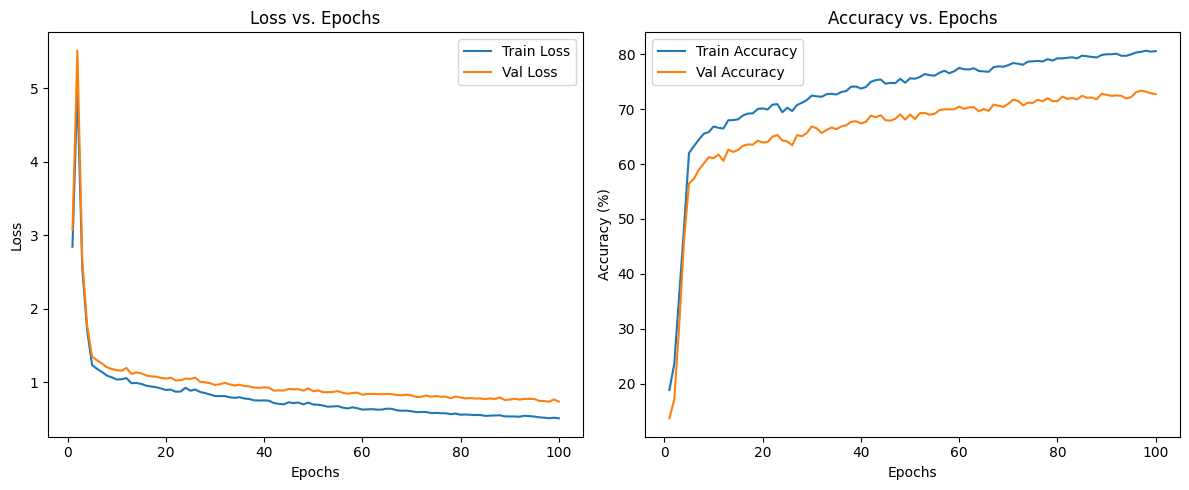

In [18]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 1 | Train Loss:   0.5032 | Train Accuracy:   80.8736% | Train mIOU:   0.6884 | Train mF1:   0.8032 | Train Precision:   0.7978 | Train Recall:   0.8087


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Epoch 1 | Val Loss:   0.7378 | Val Accuracy:   73.3295% | Val mIOU:   0.5860 | Val mF1:   0.7261 | Val Precision:   0.7191 | Val Recall:   0.7333


100%|██████████| 12/12 [00:01<00:00,  8.92it/s]


Epoch 2 | Train Loss:   0.4976 | Train Accuracy:   81.0072% | Train mIOU:   0.6916 | Train mF1:   0.8049 | Train Precision:   0.7998 | Train Recall:   0.8101


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 2 | Val Loss:   0.7371 | Val Accuracy:   73.2736% | Val mIOU:   0.5887 | Val mF1:   0.7276 | Val Precision:   0.7225 | Val Recall:   0.7327


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 3 | Train Loss:   0.5005 | Train Accuracy:   80.9412% | Train mIOU:   0.6905 | Train mF1:   0.8041 | Train Precision:   0.7989 | Train Recall:   0.8094


100%|██████████| 3/3 [00:00<00:00, 16.31it/s]


Epoch 3 | Val Loss:   0.7473 | Val Accuracy:   72.9395% | Val mIOU:   0.5839 | Val mF1:   0.7238 | Val Precision:   0.7183 | Val Recall:   0.7294


100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 4 | Train Loss:   0.4912 | Train Accuracy:   81.2689% | Train mIOU:   0.6939 | Train mF1:   0.8074 | Train Precision:   0.8022 | Train Recall:   0.8127


100%|██████████| 3/3 [00:00<00:00, 16.51it/s]


Epoch 4 | Val Loss:   0.7330 | Val Accuracy:   73.3828% | Val mIOU:   0.5880 | Val mF1:   0.7272 | Val Precision:   0.7208 | Val Recall:   0.7338


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 5 | Train Loss:   0.4876 | Train Accuracy:   81.3297% | Train mIOU:   0.6985 | Train mF1:   0.8090 | Train Precision:   0.8047 | Train Recall:   0.8133


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 5 | Val Loss:   0.7315 | Val Accuracy:   73.2937% | Val mIOU:   0.5918 | Val mF1:   0.7288 | Val Precision:   0.7247 | Val Recall:   0.7329


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 6 | Train Loss:   0.4781 | Train Accuracy:   81.5955% | Train mIOU:   0.6979 | Train mF1:   0.8111 | Train Precision:   0.8064 | Train Recall:   0.8160


100%|██████████| 3/3 [00:00<00:00, 15.84it/s]


Epoch 6 | Val Loss:   0.7251 | Val Accuracy:   73.7183% | Val mIOU:   0.5897 | Val mF1:   0.7314 | Val Precision:   0.7258 | Val Recall:   0.7372


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 7 | Train Loss:   0.4855 | Train Accuracy:   81.0223% | Train mIOU:   0.6973 | Train mF1:   0.8083 | Train Precision:   0.8063 | Train Recall:   0.8102


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


Epoch 7 | Val Loss:   0.7303 | Val Accuracy:   72.7895% | Val mIOU:   0.5879 | Val mF1:   0.7273 | Val Precision:   0.7267 | Val Recall:   0.7279


100%|██████████| 12/12 [00:01<00:00,  9.09it/s]


Epoch 8 | Train Loss:   0.4874 | Train Accuracy:   81.2687% | Train mIOU:   0.6898 | Train mF1:   0.8065 | Train Precision:   0.8004 | Train Recall:   0.8127


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


Epoch 8 | Val Loss:   0.7338 | Val Accuracy:   73.4532% | Val mIOU:   0.5833 | Val mF1:   0.7260 | Val Precision:   0.7176 | Val Recall:   0.7345


100%|██████████| 12/12 [00:01<00:00,  9.30it/s]


Epoch 9 | Train Loss:   0.4833 | Train Accuracy:   81.4672% | Train mIOU:   0.6962 | Train mF1:   0.8091 | Train Precision:   0.8037 | Train Recall:   0.8147


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 9 | Val Loss:   0.7294 | Val Accuracy:   73.6089% | Val mIOU:   0.5900 | Val mF1:   0.7293 | Val Precision:   0.7227 | Val Recall:   0.7361


100%|██████████| 12/12 [00:01<00:00,  8.92it/s]


Epoch 10 | Train Loss:   0.4924 | Train Accuracy:   81.2046% | Train mIOU:   0.6915 | Train mF1:   0.8055 | Train Precision:   0.7991 | Train Recall:   0.8120


100%|██████████| 3/3 [00:00<00:00, 15.86it/s]


Epoch 10 | Val Loss:   0.7426 | Val Accuracy:   73.3653% | Val mIOU:   0.5861 | Val mF1:   0.7256 | Val Precision:   0.7178 | Val Recall:   0.7337


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 11 | Train Loss:   0.4865 | Train Accuracy:   81.2532% | Train mIOU:   0.6993 | Train mF1:   0.8096 | Train Precision:   0.8068 | Train Recall:   0.8125


100%|██████████| 3/3 [00:00<00:00, 16.77it/s]


Epoch 11 | Val Loss:   0.7363 | Val Accuracy:   72.8982% | Val mIOU:   0.5900 | Val mF1:   0.7275 | Val Precision:   0.7260 | Val Recall:   0.7290


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 12 | Train Loss:   0.4945 | Train Accuracy:   80.8403% | Train mIOU:   0.6945 | Train mF1:   0.8077 | Train Precision:   0.8070 | Train Recall:   0.8084


100%|██████████| 3/3 [00:00<00:00, 16.40it/s]


Epoch 12 | Val Loss:   0.7526 | Val Accuracy:   72.4720% | Val mIOU:   0.5840 | Val mF1:   0.7254 | Val Precision:   0.7260 | Val Recall:   0.7247


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 13 | Train Loss:   0.4906 | Train Accuracy:   81.1531% | Train mIOU:   0.6872 | Train mF1:   0.8060 | Train Precision:   0.8006 | Train Recall:   0.8115


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


Epoch 13 | Val Loss:   0.7441 | Val Accuracy:   73.4359% | Val mIOU:   0.5807 | Val mF1:   0.7276 | Val Precision:   0.7209 | Val Recall:   0.7344


100%|██████████| 12/12 [00:01<00:00,  9.03it/s]


Epoch 14 | Train Loss:   0.4771 | Train Accuracy:   81.6459% | Train mIOU:   0.7004 | Train mF1:   0.8121 | Train Precision:   0.8077 | Train Recall:   0.8165


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 14 | Val Loss:   0.7306 | Val Accuracy:   73.5537% | Val mIOU:   0.5908 | Val mF1:   0.7296 | Val Precision:   0.7238 | Val Recall:   0.7355


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 15 | Train Loss:   0.4705 | Train Accuracy:   81.8976% | Train mIOU:   0.7054 | Train mF1:   0.8146 | Train Precision:   0.8103 | Train Recall:   0.8190


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 15 | Val Loss:   0.7163 | Val Accuracy:   73.8057% | Val mIOU:   0.5978 | Val mF1:   0.7340 | Val Precision:   0.7300 | Val Recall:   0.7381


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 16 | Train Loss:   0.4725 | Train Accuracy:   81.6159% | Train mIOU:   0.7046 | Train mF1:   0.8140 | Train Precision:   0.8119 | Train Recall:   0.8162


100%|██████████| 3/3 [00:00<00:00, 15.59it/s]


Epoch 16 | Val Loss:   0.7208 | Val Accuracy:   73.2120% | Val mIOU:   0.5933 | Val mF1:   0.7309 | Val Precision:   0.7297 | Val Recall:   0.7321


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 17 | Train Loss:   0.4533 | Train Accuracy:   82.4019% | Train mIOU:   0.7086 | Train mF1:   0.8186 | Train Precision:   0.8133 | Train Recall:   0.8240


100%|██████████| 3/3 [00:00<00:00, 15.35it/s]


Epoch 17 | Val Loss:   0.7024 | Val Accuracy:   74.4863% | Val mIOU:   0.5993 | Val mF1:   0.7371 | Val Precision:   0.7295 | Val Recall:   0.7449


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 18 | Train Loss:   0.4557 | Train Accuracy:   82.3304% | Train mIOU:   0.7090 | Train mF1:   0.8189 | Train Precision:   0.8146 | Train Recall:   0.8233


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 18 | Val Loss:   0.7091 | Val Accuracy:   74.3579% | Val mIOU:   0.5994 | Val mF1:   0.7374 | Val Precision:   0.7313 | Val Recall:   0.7436


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 19 | Train Loss:   0.4520 | Train Accuracy:   82.4608% | Train mIOU:   0.7134 | Train mF1:   0.8206 | Train Precision:   0.8167 | Train Recall:   0.8246


100%|██████████| 3/3 [00:00<00:00, 16.26it/s]


Epoch 19 | Val Loss:   0.7032 | Val Accuracy:   74.3220% | Val mIOU:   0.6027 | Val mF1:   0.7388 | Val Precision:   0.7344 | Val Recall:   0.7432


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 20 | Train Loss:   0.4606 | Train Accuracy:   82.1246% | Train mIOU:   0.7048 | Train mF1:   0.8167 | Train Precision:   0.8122 | Train Recall:   0.8212


100%|██████████| 3/3 [00:00<00:00, 15.53it/s]


Epoch 20 | Val Loss:   0.7236 | Val Accuracy:   73.8373% | Val mIOU:   0.5915 | Val mF1:   0.7326 | Val Precision:   0.7269 | Val Recall:   0.7384


100%|██████████| 12/12 [00:01<00:00,  8.95it/s]


Epoch 21 | Train Loss:   0.4550 | Train Accuracy:   82.3335% | Train mIOU:   0.7076 | Train mF1:   0.8181 | Train Precision:   0.8130 | Train Recall:   0.8233


100%|██████████| 3/3 [00:00<00:00, 15.55it/s]


Epoch 21 | Val Loss:   0.7117 | Val Accuracy:   74.0043% | Val mIOU:   0.5943 | Val mF1:   0.7325 | Val Precision:   0.7250 | Val Recall:   0.7400


100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 22 | Train Loss:   0.4552 | Train Accuracy:   82.3970% | Train mIOU:   0.7081 | Train mF1:   0.8192 | Train Precision:   0.8144 | Train Recall:   0.8240


100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


Epoch 22 | Val Loss:   0.7212 | Val Accuracy:   74.2966% | Val mIOU:   0.5956 | Val mF1:   0.7359 | Val Precision:   0.7289 | Val Recall:   0.7430


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 23 | Train Loss:   0.4416 | Train Accuracy:   82.7441% | Train mIOU:   0.7150 | Train mF1:   0.8225 | Train Precision:   0.8177 | Train Recall:   0.8274


100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


Epoch 23 | Val Loss:   0.7064 | Val Accuracy:   74.5461% | Val mIOU:   0.6024 | Val mF1:   0.7385 | Val Precision:   0.7317 | Val Recall:   0.7455


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 24 | Train Loss:   0.4547 | Train Accuracy:   82.3343% | Train mIOU:   0.7126 | Train mF1:   0.8212 | Train Precision:   0.8191 | Train Recall:   0.8233


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 24 | Val Loss:   0.7255 | Val Accuracy:   74.3284% | Val mIOU:   0.6034 | Val mF1:   0.7407 | Val Precision:   0.7381 | Val Recall:   0.7433


100%|██████████| 12/12 [00:01<00:00,  9.26it/s]


Epoch 25 | Train Loss:   0.4469 | Train Accuracy:   82.6313% | Train mIOU:   0.7169 | Train mF1:   0.8232 | Train Precision:   0.8200 | Train Recall:   0.8263


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


Epoch 25 | Val Loss:   0.7034 | Val Accuracy:   74.0525% | Val mIOU:   0.6016 | Val mF1:   0.7372 | Val Precision:   0.7339 | Val Recall:   0.7405


100%|██████████| 12/12 [00:01<00:00,  8.93it/s]


Epoch 26 | Train Loss:   0.4398 | Train Accuracy:   82.7874% | Train mIOU:   0.7177 | Train mF1:   0.8238 | Train Precision:   0.8199 | Train Recall:   0.8279


100%|██████████| 3/3 [00:00<00:00, 16.15it/s]


Epoch 26 | Val Loss:   0.7015 | Val Accuracy:   74.2826% | Val mIOU:   0.6033 | Val mF1:   0.7380 | Val Precision:   0.7333 | Val Recall:   0.7428


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 27 | Train Loss:   0.4363 | Train Accuracy:   82.9441% | Train mIOU:   0.7187 | Train mF1:   0.8253 | Train Precision:   0.8212 | Train Recall:   0.8294


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 27 | Val Loss:   0.7041 | Val Accuracy:   74.7181% | Val mIOU:   0.6055 | Val mF1:   0.7422 | Val Precision:   0.7373 | Val Recall:   0.7472


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 28 | Train Loss:   0.4269 | Train Accuracy:   83.1094% | Train mIOU:   0.7248 | Train mF1:   0.8292 | Train Precision:   0.8273 | Train Recall:   0.8311


100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


Epoch 28 | Val Loss:   0.6963 | Val Accuracy:   74.4201% | Val mIOU:   0.6069 | Val mF1:   0.7423 | Val Precision:   0.7403 | Val Recall:   0.7442


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 29 | Train Loss:   0.4242 | Train Accuracy:   83.3517% | Train mIOU:   0.7268 | Train mF1:   0.8303 | Train Precision:   0.8272 | Train Recall:   0.8335


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 29 | Val Loss:   0.6835 | Val Accuracy:   74.8025% | Val mIOU:   0.6089 | Val mF1:   0.7436 | Val Precision:   0.7393 | Val Recall:   0.7480


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 30 | Train Loss:   0.4229 | Train Accuracy:   83.3890% | Train mIOU:   0.7257 | Train mF1:   0.8300 | Train Precision:   0.8261 | Train Recall:   0.8339


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Epoch 30 | Val Loss:   0.6855 | Val Accuracy:   74.9227% | Val mIOU:   0.6090 | Val mF1:   0.7437 | Val Precision:   0.7382 | Val Recall:   0.7492


100%|██████████| 12/12 [00:01<00:00,  8.95it/s]


Epoch 31 | Train Loss:   0.4248 | Train Accuracy:   83.2245% | Train mIOU:   0.7240 | Train mF1:   0.8289 | Train Precision:   0.8256 | Train Recall:   0.8322


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


Epoch 31 | Val Loss:   0.6948 | Val Accuracy:   74.9699% | Val mIOU:   0.6096 | Val mF1:   0.7453 | Val Precision:   0.7410 | Val Recall:   0.7497


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 32 | Train Loss:   0.4340 | Train Accuracy:   82.9519% | Train mIOU:   0.7156 | Train mF1:   0.8251 | Train Precision:   0.8207 | Train Recall:   0.8295


100%|██████████| 3/3 [00:00<00:00, 16.40it/s]


Epoch 32 | Val Loss:   0.6977 | Val Accuracy:   74.9784% | Val mIOU:   0.6052 | Val mF1:   0.7445 | Val Precision:   0.7392 | Val Recall:   0.7498


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 33 | Train Loss:   0.4277 | Train Accuracy:   83.1069% | Train mIOU:   0.7240 | Train mF1:   0.8289 | Train Precision:   0.8266 | Train Recall:   0.8311


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 33 | Val Loss:   0.6939 | Val Accuracy:   74.6619% | Val mIOU:   0.6090 | Val mF1:   0.7444 | Val Precision:   0.7421 | Val Recall:   0.7466


100%|██████████| 12/12 [00:01<00:00,  8.98it/s]


Epoch 34 | Train Loss:   0.4331 | Train Accuracy:   82.9813% | Train mIOU:   0.7212 | Train mF1:   0.8276 | Train Precision:   0.8255 | Train Recall:   0.8298


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 34 | Val Loss:   0.7197 | Val Accuracy:   74.0933% | Val mIOU:   0.6000 | Val mF1:   0.7387 | Val Precision:   0.7366 | Val Recall:   0.7409


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 35 | Train Loss:   0.4268 | Train Accuracy:   83.2160% | Train mIOU:   0.7250 | Train mF1:   0.8306 | Train Precision:   0.8290 | Train Recall:   0.8322


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 35 | Val Loss:   0.6944 | Val Accuracy:   74.8016% | Val mIOU:   0.6096 | Val mF1:   0.7462 | Val Precision:   0.7444 | Val Recall:   0.7480


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 36 | Train Loss:   0.4144 | Train Accuracy:   83.6193% | Train mIOU:   0.7275 | Train mF1:   0.8329 | Train Precision:   0.8296 | Train Recall:   0.8362


100%|██████████| 3/3 [00:00<00:00, 15.66it/s]


Epoch 36 | Val Loss:   0.6733 | Val Accuracy:   75.5075% | Val mIOU:   0.6142 | Val mF1:   0.7493 | Val Precision:   0.7436 | Val Recall:   0.7551


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 37 | Train Loss:   0.4153 | Train Accuracy:   83.5920% | Train mIOU:   0.7273 | Train mF1:   0.8326 | Train Precision:   0.8293 | Train Recall:   0.8359


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


Epoch 37 | Val Loss:   0.6937 | Val Accuracy:   74.9603% | Val mIOU:   0.6068 | Val mF1:   0.7444 | Val Precision:   0.7392 | Val Recall:   0.7496


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 38 | Train Loss:   0.4045 | Train Accuracy:   83.9850% | Train mIOU:   0.7348 | Train mF1:   0.8371 | Train Precision:   0.8343 | Train Recall:   0.8399


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 38 | Val Loss:   0.6762 | Val Accuracy:   75.2394% | Val mIOU:   0.6143 | Val mF1:   0.7492 | Val Precision:   0.7460 | Val Recall:   0.7524


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


Epoch 39 | Train Loss:   0.4037 | Train Accuracy:   83.9584% | Train mIOU:   0.7357 | Train mF1:   0.8375 | Train Precision:   0.8355 | Train Recall:   0.8396


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


Epoch 39 | Val Loss:   0.6776 | Val Accuracy:   75.4644% | Val mIOU:   0.6177 | Val mF1:   0.7516 | Val Precision:   0.7485 | Val Recall:   0.7546


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 40 | Train Loss:   0.4240 | Train Accuracy:   83.2356% | Train mIOU:   0.7255 | Train mF1:   0.8308 | Train Precision:   0.8292 | Train Recall:   0.8324


100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


Epoch 40 | Val Loss:   0.6993 | Val Accuracy:   74.5834% | Val mIOU:   0.6081 | Val mF1:   0.7433 | Val Precision:   0.7407 | Val Recall:   0.7458


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


Epoch 41 | Train Loss:   0.4114 | Train Accuracy:   83.6697% | Train mIOU:   0.7343 | Train mF1:   0.8375 | Train Precision:   0.8382 | Train Recall:   0.8367


100%|██████████| 3/3 [00:00<00:00, 15.69it/s]


Epoch 41 | Val Loss:   0.6861 | Val Accuracy:   74.7787% | Val mIOU:   0.6128 | Val mF1:   0.7498 | Val Precision:   0.7519 | Val Recall:   0.7478


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 42 | Train Loss:   0.4051 | Train Accuracy:   83.9267% | Train mIOU:   0.7376 | Train mF1:   0.8391 | Train Precision:   0.8389 | Train Recall:   0.8393


100%|██████████| 3/3 [00:00<00:00, 15.31it/s]


Epoch 42 | Val Loss:   0.6796 | Val Accuracy:   74.6978% | Val mIOU:   0.6127 | Val mF1:   0.7473 | Val Precision:   0.7476 | Val Recall:   0.7470


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 43 | Train Loss:   0.4040 | Train Accuracy:   83.9523% | Train mIOU:   0.7339 | Train mF1:   0.8373 | Train Precision:   0.8352 | Train Recall:   0.8395


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 43 | Val Loss:   0.6945 | Val Accuracy:   75.3049% | Val mIOU:   0.6132 | Val mF1:   0.7503 | Val Precision:   0.7476 | Val Recall:   0.7530


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 44 | Train Loss:   0.3934 | Train Accuracy:   84.2551% | Train mIOU:   0.7376 | Train mF1:   0.8393 | Train Precision:   0.8361 | Train Recall:   0.8426


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Epoch 44 | Val Loss:   0.6714 | Val Accuracy:   75.6965% | Val mIOU:   0.6188 | Val mF1:   0.7520 | Val Precision:   0.7472 | Val Recall:   0.7570


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 45 | Train Loss:   0.4042 | Train Accuracy:   83.6932% | Train mIOU:   0.7348 | Train mF1:   0.8389 | Train Precision:   0.8409 | Train Recall:   0.8369


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


Epoch 45 | Val Loss:   0.6865 | Val Accuracy:   74.5811% | Val mIOU:   0.6106 | Val mF1:   0.7489 | Val Precision:   0.7520 | Val Recall:   0.7458


100%|██████████| 12/12 [00:01<00:00,  9.38it/s]


Epoch 46 | Train Loss:   0.3957 | Train Accuracy:   84.2795% | Train mIOU:   0.7404 | Train mF1:   0.8411 | Train Precision:   0.8395 | Train Recall:   0.8428


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 46 | Val Loss:   0.6862 | Val Accuracy:   75.3255% | Val mIOU:   0.6167 | Val mF1:   0.7521 | Val Precision:   0.7510 | Val Recall:   0.7533


100%|██████████| 12/12 [00:01<00:00,  8.91it/s]


Epoch 47 | Train Loss:   0.3977 | Train Accuracy:   84.0595% | Train mIOU:   0.7334 | Train mF1:   0.8379 | Train Precision:   0.8351 | Train Recall:   0.8406


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Epoch 47 | Val Loss:   0.6722 | Val Accuracy:   75.8767% | Val mIOU:   0.6191 | Val mF1:   0.7539 | Val Precision:   0.7491 | Val Recall:   0.7588


100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch 48 | Train Loss:   0.4010 | Train Accuracy:   83.9929% | Train mIOU:   0.7322 | Train mF1:   0.8370 | Train Precision:   0.8342 | Train Recall:   0.8399


100%|██████████| 3/3 [00:00<00:00, 15.48it/s]


Epoch 48 | Val Loss:   0.6770 | Val Accuracy:   75.6024% | Val mIOU:   0.6156 | Val mF1:   0.7516 | Val Precision:   0.7472 | Val Recall:   0.7560


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 49 | Train Loss:   0.3869 | Train Accuracy:   84.5531% | Train mIOU:   0.7437 | Train mF1:   0.8435 | Train Precision:   0.8414 | Train Recall:   0.8455


100%|██████████| 3/3 [00:00<00:00, 15.35it/s]


Epoch 49 | Val Loss:   0.6540 | Val Accuracy:   76.0651% | Val mIOU:   0.6262 | Val mF1:   0.7582 | Val Precision:   0.7557 | Val Recall:   0.7607


100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 50 | Train Loss:   0.3913 | Train Accuracy:   84.4018% | Train mIOU:   0.7423 | Train mF1:   0.8428 | Train Precision:   0.8416 | Train Recall:   0.8440


100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Epoch 50 | Val Loss:   0.6799 | Val Accuracy:   75.4368% | Val mIOU:   0.6182 | Val mF1:   0.7533 | Val Precision:   0.7522 | Val Recall:   0.7544


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 51 | Train Loss:   0.3868 | Train Accuracy:   84.6630% | Train mIOU:   0.7459 | Train mF1:   0.8455 | Train Precision:   0.8444 | Train Recall:   0.8466


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Epoch 51 | Val Loss:   0.6597 | Val Accuracy:   75.7521% | Val mIOU:   0.6227 | Val mF1:   0.7563 | Val Precision:   0.7552 | Val Recall:   0.7575


100%|██████████| 12/12 [00:01<00:00,  8.97it/s]


Epoch 52 | Train Loss:   0.3904 | Train Accuracy:   84.2434% | Train mIOU:   0.7430 | Train mF1:   0.8448 | Train Precision:   0.8472 | Train Recall:   0.8424


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]


Epoch 52 | Val Loss:   0.6711 | Val Accuracy:   74.8862% | Val mIOU:   0.6150 | Val mF1:   0.7522 | Val Precision:   0.7555 | Val Recall:   0.7489


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 53 | Train Loss:   0.3861 | Train Accuracy:   84.6382% | Train mIOU:   0.7458 | Train mF1:   0.8453 | Train Precision:   0.8441 | Train Recall:   0.8464


100%|██████████| 3/3 [00:00<00:00, 16.28it/s]


Epoch 53 | Val Loss:   0.6684 | Val Accuracy:   75.8113% | Val mIOU:   0.6235 | Val mF1:   0.7572 | Val Precision:   0.7563 | Val Recall:   0.7581


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 54 | Train Loss:   0.3919 | Train Accuracy:   84.2966% | Train mIOU:   0.7429 | Train mF1:   0.8441 | Train Precision:   0.8452 | Train Recall:   0.8430


100%|██████████| 3/3 [00:00<00:00, 16.76it/s]


Epoch 54 | Val Loss:   0.6759 | Val Accuracy:   74.8723% | Val mIOU:   0.6153 | Val mF1:   0.7514 | Val Precision:   0.7542 | Val Recall:   0.7487


100%|██████████| 12/12 [00:01<00:00,  8.91it/s]


Epoch 55 | Train Loss:   0.3887 | Train Accuracy:   84.4418% | Train mIOU:   0.7455 | Train mF1:   0.8460 | Train Precision:   0.8475 | Train Recall:   0.8444


100%|██████████| 3/3 [00:00<00:00, 16.87it/s]


Epoch 55 | Val Loss:   0.6630 | Val Accuracy:   75.3150% | Val mIOU:   0.6208 | Val mF1:   0.7559 | Val Precision:   0.7586 | Val Recall:   0.7531


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 56 | Train Loss:   0.3831 | Train Accuracy:   84.6269% | Train mIOU:   0.7475 | Train mF1:   0.8476 | Train Precision:   0.8490 | Train Recall:   0.8463


100%|██████████| 3/3 [00:00<00:00, 15.27it/s]


Epoch 56 | Val Loss:   0.6641 | Val Accuracy:   75.5075% | Val mIOU:   0.6217 | Val mF1:   0.7571 | Val Precision:   0.7591 | Val Recall:   0.7551


100%|██████████| 12/12 [00:01<00:00,  9.01it/s]


Epoch 57 | Train Loss:   0.3806 | Train Accuracy:   84.8141% | Train mIOU:   0.7487 | Train mF1:   0.8477 | Train Precision:   0.8472 | Train Recall:   0.8481


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 57 | Val Loss:   0.6556 | Val Accuracy:   75.9647% | Val mIOU:   0.6264 | Val mF1:   0.7591 | Val Precision:   0.7585 | Val Recall:   0.7596


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 58 | Train Loss:   0.3784 | Train Accuracy:   84.8707% | Train mIOU:   0.7509 | Train mF1:   0.8498 | Train Precision:   0.8508 | Train Recall:   0.8487


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 58 | Val Loss:   0.6686 | Val Accuracy:   75.5823% | Val mIOU:   0.6237 | Val mF1:   0.7586 | Val Precision:   0.7615 | Val Recall:   0.7558


100%|██████████| 12/12 [00:01<00:00,  9.17it/s]


Epoch 59 | Train Loss:   0.3896 | Train Accuracy:   84.4413% | Train mIOU:   0.7464 | Train mF1:   0.8468 | Train Precision:   0.8493 | Train Recall:   0.8444


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 59 | Val Loss:   0.6759 | Val Accuracy:   75.2705% | Val mIOU:   0.6222 | Val mF1:   0.7577 | Val Precision:   0.7628 | Val Recall:   0.7527


100%|██████████| 12/12 [00:01<00:00,  9.39it/s]


Epoch 60 | Train Loss:   0.3694 | Train Accuracy:   85.2082% | Train mIOU:   0.7525 | Train mF1:   0.8502 | Train Precision:   0.8484 | Train Recall:   0.8521


100%|██████████| 3/3 [00:00<00:00, 15.57it/s]


Epoch 60 | Val Loss:   0.6492 | Val Accuracy:   76.3565% | Val mIOU:   0.6284 | Val mF1:   0.7612 | Val Precision:   0.7589 | Val Recall:   0.7636


100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 61 | Train Loss:   0.3631 | Train Accuracy:   85.4096% | Train mIOU:   0.7571 | Train mF1:   0.8534 | Train Precision:   0.8527 | Train Recall:   0.8541


100%|██████████| 3/3 [00:00<00:00, 16.51it/s]


Epoch 61 | Val Loss:   0.6436 | Val Accuracy:   76.4406% | Val mIOU:   0.6312 | Val mF1:   0.7625 | Val Precision:   0.7606 | Val Recall:   0.7644


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


Epoch 62 | Train Loss:   0.3642 | Train Accuracy:   85.3429% | Train mIOU:   0.7547 | Train mF1:   0.8517 | Train Precision:   0.8500 | Train Recall:   0.8534


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 62 | Val Loss:   0.6489 | Val Accuracy:   76.5079% | Val mIOU:   0.6305 | Val mF1:   0.7625 | Val Precision:   0.7600 | Val Recall:   0.7651


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 63 | Train Loss:   0.3705 | Train Accuracy:   85.1697% | Train mIOU:   0.7515 | Train mF1:   0.8499 | Train Precision:   0.8482 | Train Recall:   0.8517


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


Epoch 63 | Val Loss:   0.6592 | Val Accuracy:   76.1912% | Val mIOU:   0.6253 | Val mF1:   0.7596 | Val Precision:   0.7573 | Val Recall:   0.7619


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 64 | Train Loss:   0.3644 | Train Accuracy:   85.4532% | Train mIOU:   0.7578 | Train mF1:   0.8541 | Train Precision:   0.8536 | Train Recall:   0.8545


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 64 | Val Loss:   0.6653 | Val Accuracy:   76.0163% | Val mIOU:   0.6275 | Val mF1:   0.7604 | Val Precision:   0.7607 | Val Recall:   0.7602


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 65 | Train Loss:   0.3587 | Train Accuracy:   85.6257% | Train mIOU:   0.7585 | Train mF1:   0.8547 | Train Precision:   0.8532 | Train Recall:   0.8563


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 65 | Val Loss:   0.6476 | Val Accuracy:   76.4128% | Val mIOU:   0.6296 | Val mF1:   0.7618 | Val Precision:   0.7594 | Val Recall:   0.7641


100%|██████████| 12/12 [00:01<00:00,  9.30it/s]


Epoch 66 | Train Loss:   0.3650 | Train Accuracy:   85.3001% | Train mIOU:   0.7517 | Train mF1:   0.8507 | Train Precision:   0.8483 | Train Recall:   0.8530


100%|██████████| 3/3 [00:00<00:00, 16.16it/s]


Epoch 66 | Val Loss:   0.6606 | Val Accuracy:   76.6462% | Val mIOU:   0.6271 | Val mF1:   0.7625 | Val Precision:   0.7586 | Val Recall:   0.7665


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 67 | Train Loss:   0.3588 | Train Accuracy:   85.5696% | Train mIOU:   0.7610 | Train mF1:   0.8571 | Train Precision:   0.8585 | Train Recall:   0.8557


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 67 | Val Loss:   0.6522 | Val Accuracy:   75.7519% | Val mIOU:   0.6264 | Val mF1:   0.7607 | Val Precision:   0.7639 | Val Recall:   0.7575


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 68 | Train Loss:   0.3615 | Train Accuracy:   85.5398% | Train mIOU:   0.7566 | Train mF1:   0.8533 | Train Precision:   0.8512 | Train Recall:   0.8554


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 68 | Val Loss:   0.6643 | Val Accuracy:   76.5530% | Val mIOU:   0.6292 | Val mF1:   0.7614 | Val Precision:   0.7573 | Val Recall:   0.7655


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 69 | Train Loss:   0.3639 | Train Accuracy:   85.3717% | Train mIOU:   0.7534 | Train mF1:   0.8513 | Train Precision:   0.8490 | Train Recall:   0.8537


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Epoch 69 | Val Loss:   0.6644 | Val Accuracy:   76.3887% | Val mIOU:   0.6275 | Val mF1:   0.7603 | Val Precision:   0.7568 | Val Recall:   0.7639


100%|██████████| 12/12 [00:01<00:00,  9.29it/s]


Epoch 70 | Train Loss:   0.3631 | Train Accuracy:   85.4352% | Train mIOU:   0.7570 | Train mF1:   0.8537 | Train Precision:   0.8531 | Train Recall:   0.8544


100%|██████████| 3/3 [00:00<00:00, 15.33it/s]


Epoch 70 | Val Loss:   0.6549 | Val Accuracy:   76.3845% | Val mIOU:   0.6300 | Val mF1:   0.7627 | Val Precision:   0.7615 | Val Recall:   0.7638


100%|██████████| 12/12 [00:01<00:00,  8.94it/s]


Epoch 71 | Train Loss:   0.3505 | Train Accuracy:   85.9078% | Train mIOU:   0.7643 | Train mF1:   0.8589 | Train Precision:   0.8587 | Train Recall:   0.8591


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 71 | Val Loss:   0.6466 | Val Accuracy:   76.4467% | Val mIOU:   0.6323 | Val mF1:   0.7643 | Val Precision:   0.7641 | Val Recall:   0.7645


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 72 | Train Loss:   0.3460 | Train Accuracy:   86.1129% | Train mIOU:   0.7665 | Train mF1:   0.8603 | Train Precision:   0.8595 | Train Recall:   0.8611


100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Epoch 72 | Val Loss:   0.6349 | Val Accuracy:   76.7214% | Val mIOU:   0.6352 | Val mF1:   0.7665 | Val Precision:   0.7657 | Val Recall:   0.7672


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 73 | Train Loss:   0.3552 | Train Accuracy:   85.7943% | Train mIOU:   0.7638 | Train mF1:   0.8591 | Train Precision:   0.8602 | Train Recall:   0.8579


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 73 | Val Loss:   0.6700 | Val Accuracy:   76.0197% | Val mIOU:   0.6273 | Val mF1:   0.7622 | Val Precision:   0.7643 | Val Recall:   0.7602


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 74 | Train Loss:   0.3433 | Train Accuracy:   86.1761% | Train mIOU:   0.7695 | Train mF1:   0.8634 | Train Precision:   0.8651 | Train Recall:   0.8618


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


Epoch 74 | Val Loss:   0.6408 | Val Accuracy:   76.6171% | Val mIOU:   0.6360 | Val mF1:   0.7688 | Val Precision:   0.7715 | Val Recall:   0.7662


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 75 | Train Loss:   0.3462 | Train Accuracy:   86.0940% | Train mIOU:   0.7678 | Train mF1:   0.8611 | Train Precision:   0.8613 | Train Recall:   0.8609


100%|██████████| 3/3 [00:00<00:00, 16.28it/s]


Epoch 75 | Val Loss:   0.6428 | Val Accuracy:   76.5051% | Val mIOU:   0.6347 | Val mF1:   0.7657 | Val Precision:   0.7663 | Val Recall:   0.7651


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 76 | Train Loss:   0.3600 | Train Accuracy:   85.3928% | Train mIOU:   0.7611 | Train mF1:   0.8592 | Train Precision:   0.8645 | Train Recall:   0.8539


100%|██████████| 3/3 [00:00<00:00, 16.16it/s]


Epoch 76 | Val Loss:   0.6546 | Val Accuracy:   75.3804% | Val mIOU:   0.6257 | Val mF1:   0.7629 | Val Precision:   0.7722 | Val Recall:   0.7538


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 77 | Train Loss:   0.3510 | Train Accuracy:   85.9368% | Train mIOU:   0.7642 | Train mF1:   0.8593 | Train Precision:   0.8592 | Train Recall:   0.8594


100%|██████████| 3/3 [00:00<00:00, 15.45it/s]


Epoch 77 | Val Loss:   0.6500 | Val Accuracy:   76.5276% | Val mIOU:   0.6344 | Val mF1:   0.7663 | Val Precision:   0.7674 | Val Recall:   0.7653


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 78 | Train Loss:   0.3562 | Train Accuracy:   85.7189% | Train mIOU:   0.7588 | Train mF1:   0.8557 | Train Precision:   0.8541 | Train Recall:   0.8572


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 78 | Val Loss:   0.6686 | Val Accuracy:   76.6606% | Val mIOU:   0.6307 | Val mF1:   0.7642 | Val Precision:   0.7617 | Val Recall:   0.7666


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 79 | Train Loss:   0.3654 | Train Accuracy:   85.3854% | Train mIOU:   0.7541 | Train mF1:   0.8524 | Train Precision:   0.8510 | Train Recall:   0.8539


100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


Epoch 79 | Val Loss:   0.6581 | Val Accuracy:   76.5701% | Val mIOU:   0.6294 | Val mF1:   0.7623 | Val Precision:   0.7589 | Val Recall:   0.7657


100%|██████████| 12/12 [00:01<00:00,  8.94it/s]


Epoch 80 | Train Loss:   0.3504 | Train Accuracy:   85.9243% | Train mIOU:   0.7643 | Train mF1:   0.8588 | Train Precision:   0.8583 | Train Recall:   0.8592


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 80 | Val Loss:   0.6362 | Val Accuracy:   76.7404% | Val mIOU:   0.6363 | Val mF1:   0.7672 | Val Precision:   0.7670 | Val Recall:   0.7674


100%|██████████| 12/12 [00:01<00:00,  8.26it/s]


Epoch 81 | Train Loss:   0.3552 | Train Accuracy:   85.6717% | Train mIOU:   0.7571 | Train mF1:   0.8545 | Train Precision:   0.8523 | Train Recall:   0.8567


100%|██████████| 3/3 [00:00<00:00, 15.84it/s]


Epoch 81 | Val Loss:   0.6558 | Val Accuracy:   76.8890% | Val mIOU:   0.6326 | Val mF1:   0.7644 | Val Precision:   0.7600 | Val Recall:   0.7689


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 82 | Train Loss:   0.3437 | Train Accuracy:   86.2447% | Train mIOU:   0.7688 | Train mF1:   0.8621 | Train Precision:   0.8618 | Train Recall:   0.8624


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


Epoch 82 | Val Loss:   0.6392 | Val Accuracy:   77.0053% | Val mIOU:   0.6388 | Val mF1:   0.7694 | Val Precision:   0.7687 | Val Recall:   0.7701


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch 83 | Train Loss:   0.3460 | Train Accuracy:   86.1481% | Train mIOU:   0.7656 | Train mF1:   0.8601 | Train Precision:   0.8588 | Train Recall:   0.8615


100%|██████████| 3/3 [00:00<00:00, 17.50it/s]


Epoch 83 | Val Loss:   0.6389 | Val Accuracy:   76.8023% | Val mIOU:   0.6355 | Val mF1:   0.7664 | Val Precision:   0.7649 | Val Recall:   0.7680


100%|██████████| 12/12 [00:01<00:00,  8.90it/s]


Epoch 84 | Train Loss:   0.3418 | Train Accuracy:   86.2978% | Train mIOU:   0.7687 | Train mF1:   0.8620 | Train Precision:   0.8611 | Train Recall:   0.8630


100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Epoch 84 | Val Loss:   0.6308 | Val Accuracy:   77.1531% | Val mIOU:   0.6404 | Val mF1:   0.7699 | Val Precision:   0.7683 | Val Recall:   0.7715


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch 85 | Train Loss:   0.3574 | Train Accuracy:   85.7489% | Train mIOU:   0.7638 | Train mF1:   0.8605 | Train Precision:   0.8635 | Train Recall:   0.8575


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


Epoch 85 | Val Loss:   0.6771 | Val Accuracy:   75.5706% | Val mIOU:   0.6244 | Val mF1:   0.7620 | Val Precision:   0.7683 | Val Recall:   0.7557


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 86 | Train Loss:   0.3320 | Train Accuracy:   86.6444% | Train mIOU:   0.7749 | Train mF1:   0.8665 | Train Precision:   0.8666 | Train Recall:   0.8664


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


Epoch 86 | Val Loss:   0.6267 | Val Accuracy:   77.2938% | Val mIOU:   0.6435 | Val mF1:   0.7734 | Val Precision:   0.7739 | Val Recall:   0.7729


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 87 | Train Loss:   0.3324 | Train Accuracy:   86.5961% | Train mIOU:   0.7750 | Train mF1:   0.8674 | Train Precision:   0.8688 | Train Recall:   0.8660


100%|██████████| 3/3 [00:00<00:00, 16.86it/s]


Epoch 87 | Val Loss:   0.6291 | Val Accuracy:   76.9658% | Val mIOU:   0.6400 | Val mF1:   0.7718 | Val Precision:   0.7739 | Val Recall:   0.7697


100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 88 | Train Loss:   0.3312 | Train Accuracy:   86.7129% | Train mIOU:   0.7741 | Train mF1:   0.8661 | Train Precision:   0.8651 | Train Recall:   0.8671


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 88 | Val Loss:   0.6331 | Val Accuracy:   77.4980% | Val mIOU:   0.6429 | Val mF1:   0.7736 | Val Precision:   0.7723 | Val Recall:   0.7750


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 89 | Train Loss:   0.3407 | Train Accuracy:   86.3173% | Train mIOU:   0.7706 | Train mF1:   0.8641 | Train Precision:   0.8650 | Train Recall:   0.8632


100%|██████████| 3/3 [00:00<00:00, 16.49it/s]


Epoch 89 | Val Loss:   0.6440 | Val Accuracy:   77.0649% | Val mIOU:   0.6403 | Val mF1:   0.7711 | Val Precision:   0.7715 | Val Recall:   0.7706


100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 90 | Train Loss:   0.3343 | Train Accuracy:   86.6161% | Train mIOU:   0.7751 | Train mF1:   0.8672 | Train Precision:   0.8683 | Train Recall:   0.8662


100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


Epoch 90 | Val Loss:   0.6309 | Val Accuracy:   77.1009% | Val mIOU:   0.6411 | Val mF1:   0.7725 | Val Precision:   0.7740 | Val Recall:   0.7710


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 91 | Train Loss:   0.3438 | Train Accuracy:   86.2792% | Train mIOU:   0.7698 | Train mF1:   0.8641 | Train Precision:   0.8654 | Train Recall:   0.8628


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Epoch 91 | Val Loss:   0.6498 | Val Accuracy:   76.6248% | Val mIOU:   0.6336 | Val mF1:   0.7680 | Val Precision:   0.7698 | Val Recall:   0.7662


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 92 | Train Loss:   0.3393 | Train Accuracy:   86.3647% | Train mIOU:   0.7694 | Train mF1:   0.8626 | Train Precision:   0.8615 | Train Recall:   0.8636


100%|██████████| 3/3 [00:00<00:00, 16.80it/s]


Epoch 92 | Val Loss:   0.6413 | Val Accuracy:   77.0238% | Val mIOU:   0.6380 | Val mF1:   0.7689 | Val Precision:   0.7675 | Val Recall:   0.7702


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 93 | Train Loss:   0.3446 | Train Accuracy:   86.2214% | Train mIOU:   0.7677 | Train mF1:   0.8624 | Train Precision:   0.8625 | Train Recall:   0.8622


100%|██████████| 3/3 [00:00<00:00, 14.09it/s]


Epoch 93 | Val Loss:   0.6552 | Val Accuracy:   76.9704% | Val mIOU:   0.6374 | Val mF1:   0.7698 | Val Precision:   0.7699 | Val Recall:   0.7697


100%|██████████| 12/12 [00:01<00:00,  8.88it/s]


Epoch 94 | Train Loss:   0.3400 | Train Accuracy:   86.3990% | Train mIOU:   0.7723 | Train mF1:   0.8659 | Train Precision:   0.8677 | Train Recall:   0.8640


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Epoch 94 | Val Loss:   0.6361 | Val Accuracy:   76.5260% | Val mIOU:   0.6355 | Val mF1:   0.7684 | Val Precision:   0.7715 | Val Recall:   0.7653


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 95 | Train Loss:   0.3304 | Train Accuracy:   86.7110% | Train mIOU:   0.7756 | Train mF1:   0.8679 | Train Precision:   0.8688 | Train Recall:   0.8671


100%|██████████| 3/3 [00:00<00:00, 16.20it/s]


Epoch 95 | Val Loss:   0.6318 | Val Accuracy:   77.0068% | Val mIOU:   0.6402 | Val mF1:   0.7719 | Val Precision:   0.7737 | Val Recall:   0.7701


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 96 | Train Loss:   0.3272 | Train Accuracy:   86.7763% | Train mIOU:   0.7758 | Train mF1:   0.8672 | Train Precision:   0.8667 | Train Recall:   0.8678


100%|██████████| 3/3 [00:00<00:00, 16.14it/s]


Epoch 96 | Val Loss:   0.6279 | Val Accuracy:   77.5800% | Val mIOU:   0.6460 | Val mF1:   0.7741 | Val Precision:   0.7724 | Val Recall:   0.7758


100%|██████████| 12/12 [00:01<00:00,  9.26it/s]


Epoch 97 | Train Loss:   0.3340 | Train Accuracy:   86.5908% | Train mIOU:   0.7726 | Train mF1:   0.8652 | Train Precision:   0.8644 | Train Recall:   0.8659


100%|██████████| 3/3 [00:00<00:00, 15.52it/s]


Epoch 97 | Val Loss:   0.6555 | Val Accuracy:   77.2581% | Val mIOU:   0.6404 | Val mF1:   0.7709 | Val Precision:   0.7692 | Val Recall:   0.7726


100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 98 | Train Loss:   0.3242 | Train Accuracy:   87.0211% | Train mIOU:   0.7794 | Train mF1:   0.8699 | Train Precision:   0.8696 | Train Recall:   0.8702


100%|██████████| 3/3 [00:00<00:00, 16.32it/s]


Epoch 98 | Val Loss:   0.6251 | Val Accuracy:   77.4392% | Val mIOU:   0.6439 | Val mF1:   0.7743 | Val Precision:   0.7742 | Val Recall:   0.7744


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 99 | Train Loss:   0.3287 | Train Accuracy:   86.8308% | Train mIOU:   0.7774 | Train mF1:   0.8685 | Train Precision:   0.8687 | Train Recall:   0.8683


100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


Epoch 99 | Val Loss:   0.6366 | Val Accuracy:   76.9609% | Val mIOU:   0.6393 | Val mF1:   0.7692 | Val Precision:   0.7689 | Val Recall:   0.7696


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 100 | Train Loss:   0.3237 | Train Accuracy:   87.0462% | Train mIOU:   0.7793 | Train mF1:   0.8699 | Train Precision:   0.8693 | Train Recall:   0.8705


100%|██████████| 3/3 [00:00<00:00, 15.61it/s]


Epoch 100 | Val Loss:   0.6238 | Val Accuracy:   77.7530% | Val mIOU:   0.6469 | Val mF1:   0.7763 | Val Precision:   0.7751 | Val Recall:   0.7775


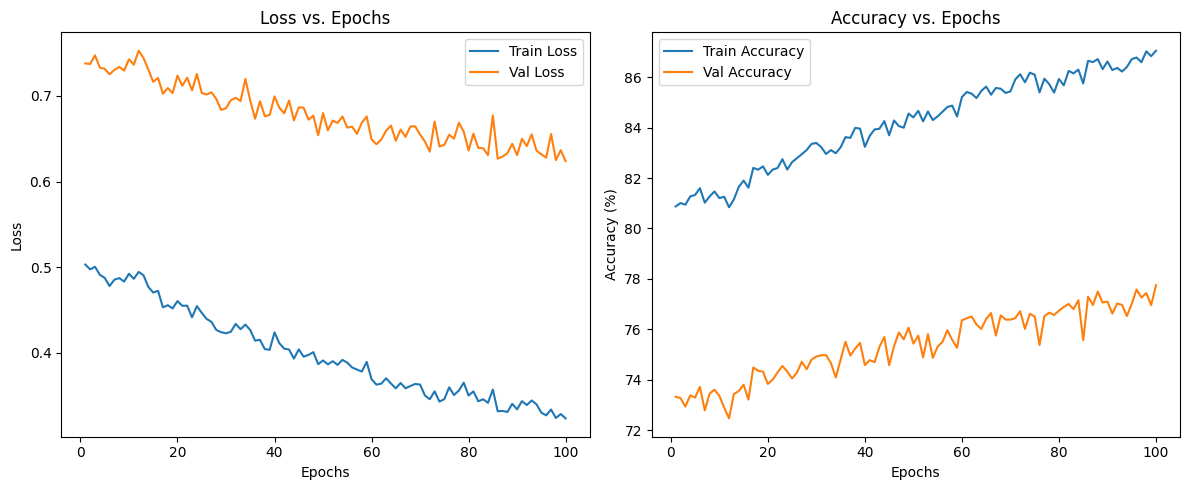

In [19]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100)

In [20]:
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=1e-5)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 1 | Train Loss:   0.3105 | Train Accuracy:   87.5368% | Train mIOU:   0.7878 | Train mF1:   0.8755 | Train Precision:   0.8756 | Train Recall:   0.8754


100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Epoch 1 | Val Loss:   0.6104 | Val Accuracy:   77.9851% | Val mIOU:   0.6516 | Val mF1:   0.7800 | Val Precision:   0.7801 | Val Recall:   0.7799


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 2 | Train Loss:   0.3091 | Train Accuracy:   87.5936% | Train mIOU:   0.7890 | Train mF1:   0.8761 | Train Precision:   0.8763 | Train Recall:   0.8759


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 2 | Val Loss:   0.6061 | Val Accuracy:   78.0445% | Val mIOU:   0.6528 | Val mF1:   0.7807 | Val Precision:   0.7810 | Val Recall:   0.7804


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 3 | Train Loss:   0.3046 | Train Accuracy:   87.7722% | Train mIOU:   0.7915 | Train mF1:   0.8778 | Train Precision:   0.8779 | Train Recall:   0.8777


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


Epoch 3 | Val Loss:   0.6036 | Val Accuracy:   78.1437% | Val mIOU:   0.6538 | Val mF1:   0.7813 | Val Precision:   0.7812 | Val Recall:   0.7814


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 4 | Train Loss:   0.3031 | Train Accuracy:   87.8387% | Train mIOU:   0.7924 | Train mF1:   0.8784 | Train Precision:   0.8784 | Train Recall:   0.8784


100%|██████████| 3/3 [00:00<00:00, 16.05it/s]


Epoch 4 | Val Loss:   0.6020 | Val Accuracy:   78.1980% | Val mIOU:   0.6545 | Val mF1:   0.7818 | Val Precision:   0.7816 | Val Recall:   0.7820


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 5 | Train Loss:   0.3031 | Train Accuracy:   87.8461% | Train mIOU:   0.7926 | Train mF1:   0.8784 | Train Precision:   0.8784 | Train Recall:   0.8785


100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


Epoch 5 | Val Loss:   0.6001 | Val Accuracy:   78.2493% | Val mIOU:   0.6550 | Val mF1:   0.7821 | Val Precision:   0.7818 | Val Recall:   0.7825


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 6 | Train Loss:   0.3017 | Train Accuracy:   87.8750% | Train mIOU:   0.7929 | Train mF1:   0.8785 | Train Precision:   0.8783 | Train Recall:   0.8788


100%|██████████| 3/3 [00:00<00:00, 16.56it/s]


Epoch 6 | Val Loss:   0.5992 | Val Accuracy:   78.2959% | Val mIOU:   0.6554 | Val mF1:   0.7823 | Val Precision:   0.7817 | Val Recall:   0.7830


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 7 | Train Loss:   0.3012 | Train Accuracy:   87.8814% | Train mIOU:   0.7931 | Train mF1:   0.8787 | Train Precision:   0.8785 | Train Recall:   0.8788


100%|██████████| 3/3 [00:00<00:00, 14.86it/s]


Epoch 7 | Val Loss:   0.5975 | Val Accuracy:   78.3228% | Val mIOU:   0.6558 | Val mF1:   0.7825 | Val Precision:   0.7818 | Val Recall:   0.7832


100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 8 | Train Loss:   0.3004 | Train Accuracy:   87.9194% | Train mIOU:   0.7935 | Train mF1:   0.8789 | Train Precision:   0.8786 | Train Recall:   0.8792


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


Epoch 8 | Val Loss:   0.5964 | Val Accuracy:   78.3573% | Val mIOU:   0.6562 | Val mF1:   0.7828 | Val Precision:   0.7819 | Val Recall:   0.7836


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 9 | Train Loss:   0.2995 | Train Accuracy:   87.9487% | Train mIOU:   0.7941 | Train mF1:   0.8794 | Train Precision:   0.8793 | Train Recall:   0.8795


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch 9 | Val Loss:   0.5965 | Val Accuracy:   78.3431% | Val mIOU:   0.6562 | Val mF1:   0.7830 | Val Precision:   0.7826 | Val Recall:   0.7834


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 10 | Train Loss:   0.2987 | Train Accuracy:   88.0206% | Train mIOU:   0.7952 | Train mF1:   0.8801 | Train Precision:   0.8801 | Train Recall:   0.8802


100%|██████████| 3/3 [00:00<00:00, 15.93it/s]


Epoch 10 | Val Loss:   0.5960 | Val Accuracy:   78.3883% | Val mIOU:   0.6569 | Val mF1:   0.7834 | Val Precision:   0.7830 | Val Recall:   0.7839


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 11 | Train Loss:   0.2982 | Train Accuracy:   88.0224% | Train mIOU:   0.7951 | Train mF1:   0.8801 | Train Precision:   0.8799 | Train Recall:   0.8802


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 11 | Val Loss:   0.5959 | Val Accuracy:   78.3731% | Val mIOU:   0.6564 | Val mF1:   0.7831 | Val Precision:   0.7826 | Val Recall:   0.7837


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 12 | Train Loss:   0.2969 | Train Accuracy:   88.0918% | Train mIOU:   0.7962 | Train mF1:   0.8809 | Train Precision:   0.8808 | Train Recall:   0.8809


100%|██████████| 3/3 [00:00<00:00, 15.37it/s]


Epoch 12 | Val Loss:   0.5946 | Val Accuracy:   78.4035% | Val mIOU:   0.6569 | Val mF1:   0.7834 | Val Precision:   0.7828 | Val Recall:   0.7840


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 13 | Train Loss:   0.2974 | Train Accuracy:   88.0432% | Train mIOU:   0.7955 | Train mF1:   0.8803 | Train Precision:   0.8802 | Train Recall:   0.8804


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


Epoch 13 | Val Loss:   0.5952 | Val Accuracy:   78.4157% | Val mIOU:   0.6570 | Val mF1:   0.7836 | Val Precision:   0.7830 | Val Recall:   0.7842


100%|██████████| 12/12 [00:01<00:00,  8.94it/s]


Epoch 14 | Train Loss:   0.2964 | Train Accuracy:   88.0636% | Train mIOU:   0.7957 | Train mF1:   0.8803 | Train Precision:   0.8800 | Train Recall:   0.8806


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


Epoch 14 | Val Loss:   0.5933 | Val Accuracy:   78.4377% | Val mIOU:   0.6571 | Val mF1:   0.7836 | Val Precision:   0.7828 | Val Recall:   0.7844


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Epoch 15 | Train Loss:   0.2942 | Train Accuracy:   88.1647% | Train mIOU:   0.7972 | Train mF1:   0.8815 | Train Precision:   0.8814 | Train Recall:   0.8816


100%|██████████| 3/3 [00:00<00:00, 15.65it/s]


Epoch 15 | Val Loss:   0.5934 | Val Accuracy:   78.4392% | Val mIOU:   0.6575 | Val mF1:   0.7839 | Val Precision:   0.7833 | Val Recall:   0.7844


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 16 | Train Loss:   0.2940 | Train Accuracy:   88.1987% | Train mIOU:   0.7978 | Train mF1:   0.8819 | Train Precision:   0.8818 | Train Recall:   0.8820


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


Epoch 16 | Val Loss:   0.5937 | Val Accuracy:   78.4464% | Val mIOU:   0.6576 | Val mF1:   0.7840 | Val Precision:   0.7835 | Val Recall:   0.7845


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 17 | Train Loss:   0.2930 | Train Accuracy:   88.2445% | Train mIOU:   0.7986 | Train mF1:   0.8824 | Train Precision:   0.8824 | Train Recall:   0.8824


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 17 | Val Loss:   0.5928 | Val Accuracy:   78.4625% | Val mIOU:   0.6576 | Val mF1:   0.7841 | Val Precision:   0.7836 | Val Recall:   0.7846


100%|██████████| 12/12 [00:01<00:00,  8.89it/s]


Epoch 18 | Train Loss:   0.2935 | Train Accuracy:   88.2125% | Train mIOU:   0.7982 | Train mF1:   0.8820 | Train Precision:   0.8819 | Train Recall:   0.8821


100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


Epoch 18 | Val Loss:   0.5926 | Val Accuracy:   78.4775% | Val mIOU:   0.6579 | Val mF1:   0.7843 | Val Precision:   0.7838 | Val Recall:   0.7848


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 19 | Train Loss:   0.2933 | Train Accuracy:   88.2313% | Train mIOU:   0.7983 | Train mF1:   0.8822 | Train Precision:   0.8820 | Train Recall:   0.8823


100%|██████████| 3/3 [00:00<00:00, 16.32it/s]


Epoch 19 | Val Loss:   0.5914 | Val Accuracy:   78.4951% | Val mIOU:   0.6580 | Val mF1:   0.7843 | Val Precision:   0.7837 | Val Recall:   0.7850


100%|██████████| 12/12 [00:01<00:00,  8.96it/s]


Epoch 20 | Train Loss:   0.2920 | Train Accuracy:   88.2743% | Train mIOU:   0.7991 | Train mF1:   0.8827 | Train Precision:   0.8827 | Train Recall:   0.8827


100%|██████████| 3/3 [00:00<00:00, 16.73it/s]


Epoch 20 | Val Loss:   0.5925 | Val Accuracy:   78.4673% | Val mIOU:   0.6578 | Val mF1:   0.7843 | Val Precision:   0.7839 | Val Recall:   0.7847


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 21 | Train Loss:   0.2926 | Train Accuracy:   88.2716% | Train mIOU:   0.7989 | Train mF1:   0.8826 | Train Precision:   0.8825 | Train Recall:   0.8827


100%|██████████| 3/3 [00:00<00:00, 15.84it/s]


Epoch 21 | Val Loss:   0.5910 | Val Accuracy:   78.5089% | Val mIOU:   0.6584 | Val mF1:   0.7845 | Val Precision:   0.7839 | Val Recall:   0.7851


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 22 | Train Loss:   0.2908 | Train Accuracy:   88.3347% | Train mIOU:   0.8000 | Train mF1:   0.8833 | Train Precision:   0.8833 | Train Recall:   0.8833


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 22 | Val Loss:   0.5923 | Val Accuracy:   78.4936% | Val mIOU:   0.6582 | Val mF1:   0.7845 | Val Precision:   0.7841 | Val Recall:   0.7849


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 23 | Train Loss:   0.2922 | Train Accuracy:   88.2893% | Train mIOU:   0.7993 | Train mF1:   0.8828 | Train Precision:   0.8828 | Train Recall:   0.8829


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 23 | Val Loss:   0.5922 | Val Accuracy:   78.4821% | Val mIOU:   0.6581 | Val mF1:   0.7843 | Val Precision:   0.7838 | Val Recall:   0.7848


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 24 | Train Loss:   0.2904 | Train Accuracy:   88.3180% | Train mIOU:   0.7997 | Train mF1:   0.8831 | Train Precision:   0.8830 | Train Recall:   0.8832


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 24 | Val Loss:   0.5911 | Val Accuracy:   78.5295% | Val mIOU:   0.6587 | Val mF1:   0.7847 | Val Precision:   0.7841 | Val Recall:   0.7853


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 25 | Train Loss:   0.2898 | Train Accuracy:   88.3658% | Train mIOU:   0.8005 | Train mF1:   0.8837 | Train Precision:   0.8837 | Train Recall:   0.8837


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 25 | Val Loss:   0.5911 | Val Accuracy:   78.5338% | Val mIOU:   0.6588 | Val mF1:   0.7850 | Val Precision:   0.7846 | Val Recall:   0.7853


100%|██████████| 12/12 [00:01<00:00,  8.98it/s]


Epoch 26 | Train Loss:   0.2913 | Train Accuracy:   88.3116% | Train mIOU:   0.7997 | Train mF1:   0.8831 | Train Precision:   0.8831 | Train Recall:   0.8831


100%|██████████| 3/3 [00:00<00:00, 15.59it/s]


Epoch 26 | Val Loss:   0.5904 | Val Accuracy:   78.5297% | Val mIOU:   0.6588 | Val mF1:   0.7848 | Val Precision:   0.7844 | Val Recall:   0.7853


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Epoch 27 | Train Loss:   0.2904 | Train Accuracy:   88.3317% | Train mIOU:   0.7999 | Train mF1:   0.8832 | Train Precision:   0.8832 | Train Recall:   0.8833


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 27 | Val Loss:   0.5914 | Val Accuracy:   78.5252% | Val mIOU:   0.6587 | Val mF1:   0.7848 | Val Precision:   0.7844 | Val Recall:   0.7853


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 28 | Train Loss:   0.2899 | Train Accuracy:   88.3816% | Train mIOU:   0.8008 | Train mF1:   0.8838 | Train Precision:   0.8838 | Train Recall:   0.8838


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


Epoch 28 | Val Loss:   0.5914 | Val Accuracy:   78.5475% | Val mIOU:   0.6589 | Val mF1:   0.7849 | Val Precision:   0.7844 | Val Recall:   0.7855


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 29 | Train Loss:   0.2889 | Train Accuracy:   88.3957% | Train mIOU:   0.8010 | Train mF1:   0.8840 | Train Precision:   0.8840 | Train Recall:   0.8840


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Epoch 29 | Val Loss:   0.5916 | Val Accuracy:   78.5361% | Val mIOU:   0.6589 | Val mF1:   0.7850 | Val Precision:   0.7845 | Val Recall:   0.7854


100%|██████████| 12/12 [00:01<00:00,  9.25it/s]


Epoch 30 | Train Loss:   0.2879 | Train Accuracy:   88.4381% | Train mIOU:   0.8013 | Train mF1:   0.8841 | Train Precision:   0.8838 | Train Recall:   0.8844


100%|██████████| 3/3 [00:00<00:00, 16.29it/s]


Epoch 30 | Val Loss:   0.5899 | Val Accuracy:   78.5787% | Val mIOU:   0.6590 | Val mF1:   0.7849 | Val Precision:   0.7839 | Val Recall:   0.7858


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


Epoch 31 | Train Loss:   0.2893 | Train Accuracy:   88.3627% | Train mIOU:   0.8003 | Train mF1:   0.8836 | Train Precision:   0.8835 | Train Recall:   0.8836


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 31 | Val Loss:   0.5897 | Val Accuracy:   78.5747% | Val mIOU:   0.6592 | Val mF1:   0.7851 | Val Precision:   0.7845 | Val Recall:   0.7857


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 32 | Train Loss:   0.2870 | Train Accuracy:   88.4715% | Train mIOU:   0.8021 | Train mF1:   0.8847 | Train Precision:   0.8847 | Train Recall:   0.8847


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 32 | Val Loss:   0.5898 | Val Accuracy:   78.6042% | Val mIOU:   0.6597 | Val mF1:   0.7855 | Val Precision:   0.7849 | Val Recall:   0.7860


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 33 | Train Loss:   0.2895 | Train Accuracy:   88.3790% | Train mIOU:   0.8008 | Train mF1:   0.8838 | Train Precision:   0.8837 | Train Recall:   0.8838


100%|██████████| 3/3 [00:00<00:00, 16.08it/s]


Epoch 33 | Val Loss:   0.5902 | Val Accuracy:   78.5936% | Val mIOU:   0.6594 | Val mF1:   0.7853 | Val Precision:   0.7847 | Val Recall:   0.7859


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 34 | Train Loss:   0.2874 | Train Accuracy:   88.4550% | Train mIOU:   0.8019 | Train mF1:   0.8846 | Train Precision:   0.8846 | Train Recall:   0.8846


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


Epoch 34 | Val Loss:   0.5889 | Val Accuracy:   78.6101% | Val mIOU:   0.6598 | Val mF1:   0.7855 | Val Precision:   0.7850 | Val Recall:   0.7861


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 35 | Train Loss:   0.2877 | Train Accuracy:   88.4391% | Train mIOU:   0.8017 | Train mF1:   0.8843 | Train Precision:   0.8843 | Train Recall:   0.8844


100%|██████████| 3/3 [00:00<00:00, 15.61it/s]


Epoch 35 | Val Loss:   0.5884 | Val Accuracy:   78.6224% | Val mIOU:   0.6600 | Val mF1:   0.7856 | Val Precision:   0.7851 | Val Recall:   0.7862


100%|██████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 36 | Train Loss:   0.2849 | Train Accuracy:   88.5745% | Train mIOU:   0.8036 | Train mF1:   0.8857 | Train Precision:   0.8857 | Train Recall:   0.8857


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Epoch 36 | Val Loss:   0.5887 | Val Accuracy:   78.6182% | Val mIOU:   0.6600 | Val mF1:   0.7856 | Val Precision:   0.7851 | Val Recall:   0.7862


100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Epoch 37 | Train Loss:   0.2852 | Train Accuracy:   88.5572% | Train mIOU:   0.8034 | Train mF1:   0.8855 | Train Precision:   0.8855 | Train Recall:   0.8856


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


Epoch 37 | Val Loss:   0.5895 | Val Accuracy:   78.5912% | Val mIOU:   0.6595 | Val mF1:   0.7854 | Val Precision:   0.7849 | Val Recall:   0.7859


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 38 | Train Loss:   0.2854 | Train Accuracy:   88.5489% | Train mIOU:   0.8033 | Train mF1:   0.8855 | Train Precision:   0.8855 | Train Recall:   0.8855


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


Epoch 38 | Val Loss:   0.5902 | Val Accuracy:   78.6280% | Val mIOU:   0.6599 | Val mF1:   0.7857 | Val Precision:   0.7851 | Val Recall:   0.7863


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


Epoch 39 | Train Loss:   0.2845 | Train Accuracy:   88.5783% | Train mIOU:   0.8039 | Train mF1:   0.8858 | Train Precision:   0.8858 | Train Recall:   0.8858


100%|██████████| 3/3 [00:00<00:00, 16.39it/s]


Epoch 39 | Val Loss:   0.5904 | Val Accuracy:   78.6231% | Val mIOU:   0.6598 | Val mF1:   0.7856 | Val Precision:   0.7850 | Val Recall:   0.7862


100%|██████████| 12/12 [00:01<00:00,  9.03it/s]


Epoch 40 | Train Loss:   0.2858 | Train Accuracy:   88.5219% | Train mIOU:   0.8029 | Train mF1:   0.8852 | Train Precision:   0.8852 | Train Recall:   0.8852


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 40 | Val Loss:   0.5897 | Val Accuracy:   78.6263% | Val mIOU:   0.6599 | Val mF1:   0.7858 | Val Precision:   0.7852 | Val Recall:   0.7863


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 41 | Train Loss:   0.2855 | Train Accuracy:   88.5607% | Train mIOU:   0.8034 | Train mF1:   0.8855 | Train Precision:   0.8854 | Train Recall:   0.8856


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


Epoch 41 | Val Loss:   0.5884 | Val Accuracy:   78.6405% | Val mIOU:   0.6601 | Val mF1:   0.7857 | Val Precision:   0.7851 | Val Recall:   0.7864


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 42 | Train Loss:   0.2861 | Train Accuracy:   88.4925% | Train mIOU:   0.8025 | Train mF1:   0.8849 | Train Precision:   0.8848 | Train Recall:   0.8849


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


Epoch 42 | Val Loss:   0.5888 | Val Accuracy:   78.6140% | Val mIOU:   0.6598 | Val mF1:   0.7856 | Val Precision:   0.7850 | Val Recall:   0.7861


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 43 | Train Loss:   0.2843 | Train Accuracy:   88.6107% | Train mIOU:   0.8044 | Train mF1:   0.8862 | Train Precision:   0.8863 | Train Recall:   0.8861


100%|██████████| 3/3 [00:00<00:00, 16.46it/s]


Epoch 43 | Val Loss:   0.5890 | Val Accuracy:   78.6286% | Val mIOU:   0.6602 | Val mF1:   0.7859 | Val Precision:   0.7856 | Val Recall:   0.7863


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 44 | Train Loss:   0.2857 | Train Accuracy:   88.5030% | Train mIOU:   0.8027 | Train mF1:   0.8850 | Train Precision:   0.8850 | Train Recall:   0.8850


100%|██████████| 3/3 [00:00<00:00, 15.40it/s]


Epoch 44 | Val Loss:   0.5887 | Val Accuracy:   78.6357% | Val mIOU:   0.6602 | Val mF1:   0.7858 | Val Precision:   0.7852 | Val Recall:   0.7864


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 45 | Train Loss:   0.2835 | Train Accuracy:   88.6361% | Train mIOU:   0.8046 | Train mF1:   0.8864 | Train Precision:   0.8865 | Train Recall:   0.8864


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 45 | Val Loss:   0.5878 | Val Accuracy:   78.6623% | Val mIOU:   0.6605 | Val mF1:   0.7861 | Val Precision:   0.7856 | Val Recall:   0.7866


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 46 | Train Loss:   0.2824 | Train Accuracy:   88.6379% | Train mIOU:   0.8047 | Train mF1:   0.8864 | Train Precision:   0.8864 | Train Recall:   0.8864


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]


Epoch 46 | Val Loss:   0.5886 | Val Accuracy:   78.6421% | Val mIOU:   0.6602 | Val mF1:   0.7860 | Val Precision:   0.7855 | Val Recall:   0.7864


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 47 | Train Loss:   0.2825 | Train Accuracy:   88.6511% | Train mIOU:   0.8050 | Train mF1:   0.8865 | Train Precision:   0.8866 | Train Recall:   0.8865


100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


Epoch 47 | Val Loss:   0.5887 | Val Accuracy:   78.6475% | Val mIOU:   0.6605 | Val mF1:   0.7860 | Val Precision:   0.7856 | Val Recall:   0.7865


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 48 | Train Loss:   0.2819 | Train Accuracy:   88.6747% | Train mIOU:   0.8052 | Train mF1:   0.8867 | Train Precision:   0.8866 | Train Recall:   0.8867


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 48 | Val Loss:   0.5892 | Val Accuracy:   78.6601% | Val mIOU:   0.6604 | Val mF1:   0.7860 | Val Precision:   0.7853 | Val Recall:   0.7866


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 49 | Train Loss:   0.2824 | Train Accuracy:   88.6607% | Train mIOU:   0.8050 | Train mF1:   0.8866 | Train Precision:   0.8867 | Train Recall:   0.8866


100%|██████████| 3/3 [00:00<00:00, 16.05it/s]


Epoch 49 | Val Loss:   0.5889 | Val Accuracy:   78.6660% | Val mIOU:   0.6606 | Val mF1:   0.7862 | Val Precision:   0.7857 | Val Recall:   0.7867


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 50 | Train Loss:   0.2830 | Train Accuracy:   88.6233% | Train mIOU:   0.8045 | Train mF1:   0.8862 | Train Precision:   0.8862 | Train Recall:   0.8862


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Epoch 50 | Val Loss:   0.5887 | Val Accuracy:   78.6845% | Val mIOU:   0.6608 | Val mF1:   0.7863 | Val Precision:   0.7859 | Val Recall:   0.7868


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 51 | Train Loss:   0.2819 | Train Accuracy:   88.7276% | Train mIOU:   0.8060 | Train mF1:   0.8872 | Train Precision:   0.8872 | Train Recall:   0.8873


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


Epoch 51 | Val Loss:   0.5885 | Val Accuracy:   78.6884% | Val mIOU:   0.6608 | Val mF1:   0.7863 | Val Precision:   0.7857 | Val Recall:   0.7869


100%|██████████| 12/12 [00:01<00:00,  8.93it/s]


Epoch 52 | Train Loss:   0.2803 | Train Accuracy:   88.7469% | Train mIOU:   0.8061 | Train mF1:   0.8874 | Train Precision:   0.8873 | Train Recall:   0.8875


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 52 | Val Loss:   0.5881 | Val Accuracy:   78.7033% | Val mIOU:   0.6609 | Val mF1:   0.7864 | Val Precision:   0.7857 | Val Recall:   0.7870


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 53 | Train Loss:   0.2820 | Train Accuracy:   88.6495% | Train mIOU:   0.8048 | Train mF1:   0.8864 | Train Precision:   0.8864 | Train Recall:   0.8865


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 53 | Val Loss:   0.5890 | Val Accuracy:   78.6712% | Val mIOU:   0.6605 | Val mF1:   0.7861 | Val Precision:   0.7855 | Val Recall:   0.7867


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


Epoch 54 | Train Loss:   0.2818 | Train Accuracy:   88.7081% | Train mIOU:   0.8059 | Train mF1:   0.8872 | Train Precision:   0.8873 | Train Recall:   0.8871


100%|██████████| 3/3 [00:00<00:00, 15.30it/s]


Epoch 54 | Val Loss:   0.5884 | Val Accuracy:   78.6780% | Val mIOU:   0.6609 | Val mF1:   0.7864 | Val Precision:   0.7860 | Val Recall:   0.7868


100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 55 | Train Loss:   0.2820 | Train Accuracy:   88.7209% | Train mIOU:   0.8061 | Train mF1:   0.8874 | Train Precision:   0.8876 | Train Recall:   0.8872


100%|██████████| 3/3 [00:00<00:00, 15.51it/s]


Epoch 55 | Val Loss:   0.5872 | Val Accuracy:   78.6743% | Val mIOU:   0.6611 | Val mF1:   0.7865 | Val Precision:   0.7864 | Val Recall:   0.7867


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 56 | Train Loss:   0.2823 | Train Accuracy:   88.6824% | Train mIOU:   0.8056 | Train mF1:   0.8870 | Train Precision:   0.8871 | Train Recall:   0.8868


100%|██████████| 3/3 [00:00<00:00, 16.12it/s]


Epoch 56 | Val Loss:   0.5896 | Val Accuracy:   78.6549% | Val mIOU:   0.6606 | Val mF1:   0.7863 | Val Precision:   0.7860 | Val Recall:   0.7865


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 57 | Train Loss:   0.2809 | Train Accuracy:   88.7473% | Train mIOU:   0.8064 | Train mF1:   0.8876 | Train Precision:   0.8877 | Train Recall:   0.8875


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Epoch 57 | Val Loss:   0.5870 | Val Accuracy:   78.6620% | Val mIOU:   0.6606 | Val mF1:   0.7862 | Val Precision:   0.7857 | Val Recall:   0.7866


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 58 | Train Loss:   0.2826 | Train Accuracy:   88.6501% | Train mIOU:   0.8049 | Train mF1:   0.8864 | Train Precision:   0.8863 | Train Recall:   0.8865


100%|██████████| 3/3 [00:00<00:00, 16.19it/s]


Epoch 58 | Val Loss:   0.5878 | Val Accuracy:   78.6653% | Val mIOU:   0.6605 | Val mF1:   0.7861 | Val Precision:   0.7856 | Val Recall:   0.7867


100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


Epoch 59 | Train Loss:   0.2798 | Train Accuracy:   88.7972% | Train mIOU:   0.8072 | Train mF1:   0.8881 | Train Precision:   0.8882 | Train Recall:   0.8880


100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


Epoch 59 | Val Loss:   0.5875 | Val Accuracy:   78.6921% | Val mIOU:   0.6611 | Val mF1:   0.7865 | Val Precision:   0.7860 | Val Recall:   0.7869


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 60 | Train Loss:   0.2806 | Train Accuracy:   88.7471% | Train mIOU:   0.8065 | Train mF1:   0.8875 | Train Precision:   0.8876 | Train Recall:   0.8875


100%|██████████| 3/3 [00:00<00:00, 16.50it/s]


Epoch 60 | Val Loss:   0.5865 | Val Accuracy:   78.7291% | Val mIOU:   0.6615 | Val mF1:   0.7868 | Val Precision:   0.7863 | Val Recall:   0.7873


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch 61 | Train Loss:   0.2809 | Train Accuracy:   88.7158% | Train mIOU:   0.8058 | Train mF1:   0.8872 | Train Precision:   0.8872 | Train Recall:   0.8872


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


Epoch 61 | Val Loss:   0.5895 | Val Accuracy:   78.6969% | Val mIOU:   0.6609 | Val mF1:   0.7864 | Val Precision:   0.7859 | Val Recall:   0.7870


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 62 | Train Loss:   0.2805 | Train Accuracy:   88.7251% | Train mIOU:   0.8059 | Train mF1:   0.8873 | Train Precision:   0.8873 | Train Recall:   0.8873


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 62 | Val Loss:   0.5883 | Val Accuracy:   78.7220% | Val mIOU:   0.6612 | Val mF1:   0.7866 | Val Precision:   0.7860 | Val Recall:   0.7872


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 63 | Train Loss:   0.2819 | Train Accuracy:   88.6426% | Train mIOU:   0.8049 | Train mF1:   0.8864 | Train Precision:   0.8864 | Train Recall:   0.8864


100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


Epoch 63 | Val Loss:   0.5877 | Val Accuracy:   78.6975% | Val mIOU:   0.6609 | Val mF1:   0.7864 | Val Precision:   0.7858 | Val Recall:   0.7870


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 64 | Train Loss:   0.2810 | Train Accuracy:   88.7321% | Train mIOU:   0.8062 | Train mF1:   0.8874 | Train Precision:   0.8875 | Train Recall:   0.8873


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 64 | Val Loss:   0.5880 | Val Accuracy:   78.7167% | Val mIOU:   0.6613 | Val mF1:   0.7868 | Val Precision:   0.7864 | Val Recall:   0.7872


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 65 | Train Loss:   0.2796 | Train Accuracy:   88.7843% | Train mIOU:   0.8069 | Train mF1:   0.8879 | Train Precision:   0.8880 | Train Recall:   0.8878


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 65 | Val Loss:   0.5892 | Val Accuracy:   78.7338% | Val mIOU:   0.6613 | Val mF1:   0.7868 | Val Precision:   0.7863 | Val Recall:   0.7873


100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 66 | Train Loss:   0.2809 | Train Accuracy:   88.7530% | Train mIOU:   0.8067 | Train mF1:   0.8878 | Train Precision:   0.8880 | Train Recall:   0.8875


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 66 | Val Loss:   0.5877 | Val Accuracy:   78.6918% | Val mIOU:   0.6614 | Val mF1:   0.7867 | Val Precision:   0.7864 | Val Recall:   0.7869


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 67 | Train Loss:   0.2790 | Train Accuracy:   88.8225% | Train mIOU:   0.8076 | Train mF1:   0.8883 | Train Precision:   0.8884 | Train Recall:   0.8882


100%|██████████| 3/3 [00:00<00:00, 16.80it/s]


Epoch 67 | Val Loss:   0.5888 | Val Accuracy:   78.7100% | Val mIOU:   0.6613 | Val mF1:   0.7867 | Val Precision:   0.7863 | Val Recall:   0.7871


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 68 | Train Loss:   0.2820 | Train Accuracy:   88.6866% | Train mIOU:   0.8055 | Train mF1:   0.8868 | Train Precision:   0.8868 | Train Recall:   0.8869


100%|██████████| 3/3 [00:00<00:00, 15.32it/s]


Epoch 68 | Val Loss:   0.5880 | Val Accuracy:   78.7233% | Val mIOU:   0.6613 | Val mF1:   0.7868 | Val Precision:   0.7863 | Val Recall:   0.7872


100%|██████████| 12/12 [00:01<00:00,  9.01it/s]


Epoch 69 | Train Loss:   0.2795 | Train Accuracy:   88.7916% | Train mIOU:   0.8072 | Train mF1:   0.8880 | Train Precision:   0.8882 | Train Recall:   0.8879


100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


Epoch 69 | Val Loss:   0.5891 | Val Accuracy:   78.6918% | Val mIOU:   0.6610 | Val mF1:   0.7866 | Val Precision:   0.7864 | Val Recall:   0.7869


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 70 | Train Loss:   0.2794 | Train Accuracy:   88.7978% | Train mIOU:   0.8072 | Train mF1:   0.8881 | Train Precision:   0.8881 | Train Recall:   0.8880


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


Epoch 70 | Val Loss:   0.5872 | Val Accuracy:   78.7399% | Val mIOU:   0.6617 | Val mF1:   0.7870 | Val Precision:   0.7865 | Val Recall:   0.7874


100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 71 | Train Loss:   0.2791 | Train Accuracy:   88.8024% | Train mIOU:   0.8073 | Train mF1:   0.8881 | Train Precision:   0.8881 | Train Recall:   0.8880


100%|██████████| 3/3 [00:00<00:00, 16.14it/s]


Epoch 71 | Val Loss:   0.5879 | Val Accuracy:   78.7275% | Val mIOU:   0.6614 | Val mF1:   0.7867 | Val Precision:   0.7862 | Val Recall:   0.7873


100%|██████████| 12/12 [00:01<00:00,  9.15it/s]


Epoch 72 | Train Loss:   0.2793 | Train Accuracy:   88.8009% | Train mIOU:   0.8073 | Train mF1:   0.8881 | Train Precision:   0.8882 | Train Recall:   0.8880


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 72 | Val Loss:   0.5888 | Val Accuracy:   78.7104% | Val mIOU:   0.6613 | Val mF1:   0.7867 | Val Precision:   0.7863 | Val Recall:   0.7871


100%|██████████| 12/12 [00:01<00:00,  9.09it/s]


Epoch 73 | Train Loss:   0.2782 | Train Accuracy:   88.8329% | Train mIOU:   0.8077 | Train mF1:   0.8884 | Train Precision:   0.8885 | Train Recall:   0.8883


100%|██████████| 3/3 [00:00<00:00, 16.30it/s]


Epoch 73 | Val Loss:   0.5896 | Val Accuracy:   78.7033% | Val mIOU:   0.6611 | Val mF1:   0.7866 | Val Precision:   0.7862 | Val Recall:   0.7870


100%|██████████| 12/12 [00:01<00:00,  9.17it/s]


Epoch 74 | Train Loss:   0.2774 | Train Accuracy:   88.8969% | Train mIOU:   0.8086 | Train mF1:   0.8890 | Train Precision:   0.8890 | Train Recall:   0.8890


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Epoch 74 | Val Loss:   0.5882 | Val Accuracy:   78.7333% | Val mIOU:   0.6614 | Val mF1:   0.7868 | Val Precision:   0.7863 | Val Recall:   0.7873


100%|██████████| 12/12 [00:01<00:00,  8.94it/s]


Epoch 75 | Train Loss:   0.2766 | Train Accuracy:   88.9226% | Train mIOU:   0.8090 | Train mF1:   0.8893 | Train Precision:   0.8894 | Train Recall:   0.8892


100%|██████████| 3/3 [00:00<00:00, 16.31it/s]


Epoch 75 | Val Loss:   0.5893 | Val Accuracy:   78.7179% | Val mIOU:   0.6613 | Val mF1:   0.7868 | Val Precision:   0.7865 | Val Recall:   0.7872


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 76 | Train Loss:   0.2791 | Train Accuracy:   88.8081% | Train mIOU:   0.8074 | Train mF1:   0.8882 | Train Precision:   0.8883 | Train Recall:   0.8881


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 76 | Val Loss:   0.5881 | Val Accuracy:   78.7163% | Val mIOU:   0.6614 | Val mF1:   0.7869 | Val Precision:   0.7866 | Val Recall:   0.7872


100%|██████████| 12/12 [00:01<00:00,  8.89it/s]


Epoch 77 | Train Loss:   0.2784 | Train Accuracy:   88.8417% | Train mIOU:   0.8079 | Train mF1:   0.8885 | Train Precision:   0.8887 | Train Recall:   0.8884


100%|██████████| 3/3 [00:00<00:00, 15.57it/s]


Epoch 77 | Val Loss:   0.5877 | Val Accuracy:   78.7268% | Val mIOU:   0.6615 | Val mF1:   0.7869 | Val Precision:   0.7865 | Val Recall:   0.7873


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 78 | Train Loss:   0.2781 | Train Accuracy:   88.8500% | Train mIOU:   0.8079 | Train mF1:   0.8885 | Train Precision:   0.8886 | Train Recall:   0.8885


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


Epoch 78 | Val Loss:   0.5877 | Val Accuracy:   78.7733% | Val mIOU:   0.6619 | Val mF1:   0.7872 | Val Precision:   0.7866 | Val Recall:   0.7877


100%|██████████| 12/12 [00:01<00:00,  8.86it/s]


Epoch 79 | Train Loss:   0.2774 | Train Accuracy:   88.8938% | Train mIOU:   0.8088 | Train mF1:   0.8891 | Train Precision:   0.8892 | Train Recall:   0.8889


100%|██████████| 3/3 [00:00<00:00, 15.59it/s]


Epoch 79 | Val Loss:   0.5871 | Val Accuracy:   78.7399% | Val mIOU:   0.6618 | Val mF1:   0.7870 | Val Precision:   0.7866 | Val Recall:   0.7874


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 80 | Train Loss:   0.2793 | Train Accuracy:   88.7793% | Train mIOU:   0.8069 | Train mF1:   0.8879 | Train Precision:   0.8880 | Train Recall:   0.8878


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 80 | Val Loss:   0.5879 | Val Accuracy:   78.7045% | Val mIOU:   0.6613 | Val mF1:   0.7867 | Val Precision:   0.7864 | Val Recall:   0.7870


100%|██████████| 12/12 [00:01<00:00,  9.05it/s]


Epoch 81 | Train Loss:   0.2758 | Train Accuracy:   88.9417% | Train mIOU:   0.8093 | Train mF1:   0.8894 | Train Precision:   0.8894 | Train Recall:   0.8894


100%|██████████| 3/3 [00:00<00:00, 15.47it/s]


Epoch 81 | Val Loss:   0.5884 | Val Accuracy:   78.7508% | Val mIOU:   0.6617 | Val mF1:   0.7869 | Val Precision:   0.7864 | Val Recall:   0.7875


100%|██████████| 12/12 [00:01<00:00,  9.07it/s]


Epoch 82 | Train Loss:   0.2773 | Train Accuracy:   88.8821% | Train mIOU:   0.8083 | Train mF1:   0.8888 | Train Precision:   0.8888 | Train Recall:   0.8888


100%|██████████| 3/3 [00:00<00:00, 16.14it/s]


Epoch 82 | Val Loss:   0.5871 | Val Accuracy:   78.7759% | Val mIOU:   0.6620 | Val mF1:   0.7873 | Val Precision:   0.7868 | Val Recall:   0.7878


100%|██████████| 12/12 [00:01<00:00,  9.01it/s]


Epoch 83 | Train Loss:   0.2759 | Train Accuracy:   88.9644% | Train mIOU:   0.8097 | Train mF1:   0.8898 | Train Precision:   0.8899 | Train Recall:   0.8896


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


Epoch 83 | Val Loss:   0.5864 | Val Accuracy:   78.7581% | Val mIOU:   0.6619 | Val mF1:   0.7872 | Val Precision:   0.7869 | Val Recall:   0.7876


100%|██████████| 12/12 [00:01<00:00,  9.09it/s]


Epoch 84 | Train Loss:   0.2768 | Train Accuracy:   88.9238% | Train mIOU:   0.8091 | Train mF1:   0.8894 | Train Precision:   0.8895 | Train Recall:   0.8892


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 84 | Val Loss:   0.5886 | Val Accuracy:   78.7501% | Val mIOU:   0.6617 | Val mF1:   0.7872 | Val Precision:   0.7868 | Val Recall:   0.7875


100%|██████████| 12/12 [00:01<00:00,  9.12it/s]


Epoch 85 | Train Loss:   0.2766 | Train Accuracy:   88.9251% | Train mIOU:   0.8091 | Train mF1:   0.8893 | Train Precision:   0.8893 | Train Recall:   0.8893


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 85 | Val Loss:   0.5870 | Val Accuracy:   78.7736% | Val mIOU:   0.6620 | Val mF1:   0.7872 | Val Precision:   0.7867 | Val Recall:   0.7877


100%|██████████| 12/12 [00:01<00:00,  9.04it/s]


Epoch 86 | Train Loss:   0.2772 | Train Accuracy:   88.8972% | Train mIOU:   0.8087 | Train mF1:   0.8891 | Train Precision:   0.8892 | Train Recall:   0.8890


100%|██████████| 3/3 [00:00<00:00, 16.49it/s]


Epoch 86 | Val Loss:   0.5883 | Val Accuracy:   78.7771% | Val mIOU:   0.6621 | Val mF1:   0.7874 | Val Precision:   0.7870 | Val Recall:   0.7878


100%|██████████| 12/12 [00:01<00:00,  9.26it/s]


Epoch 87 | Train Loss:   0.2768 | Train Accuracy:   88.9110% | Train mIOU:   0.8089 | Train mF1:   0.8892 | Train Precision:   0.8892 | Train Recall:   0.8891


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]


Epoch 87 | Val Loss:   0.5882 | Val Accuracy:   78.7775% | Val mIOU:   0.6621 | Val mF1:   0.7874 | Val Precision:   0.7869 | Val Recall:   0.7878


100%|██████████| 12/12 [00:01<00:00,  8.94it/s]


Epoch 88 | Train Loss:   0.2775 | Train Accuracy:   88.8674% | Train mIOU:   0.8083 | Train mF1:   0.8889 | Train Precision:   0.8892 | Train Recall:   0.8887


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 88 | Val Loss:   0.5878 | Val Accuracy:   78.7214% | Val mIOU:   0.6618 | Val mF1:   0.7872 | Val Precision:   0.7871 | Val Recall:   0.7872


100%|██████████| 12/12 [00:01<00:00,  9.17it/s]


Epoch 89 | Train Loss:   0.2748 | Train Accuracy:   88.9756% | Train mIOU:   0.8101 | Train mF1:   0.8899 | Train Precision:   0.8900 | Train Recall:   0.8898


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


Epoch 89 | Val Loss:   0.5872 | Val Accuracy:   78.7882% | Val mIOU:   0.6625 | Val mF1:   0.7876 | Val Precision:   0.7873 | Val Recall:   0.7879


100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


Epoch 90 | Train Loss:   0.2764 | Train Accuracy:   88.9298% | Train mIOU:   0.8092 | Train mF1:   0.8894 | Train Precision:   0.8895 | Train Recall:   0.8893


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 90 | Val Loss:   0.5882 | Val Accuracy:   78.7815% | Val mIOU:   0.6622 | Val mF1:   0.7874 | Val Precision:   0.7870 | Val Recall:   0.7878


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 91 | Train Loss:   0.2755 | Train Accuracy:   88.9682% | Train mIOU:   0.8098 | Train mF1:   0.8898 | Train Precision:   0.8898 | Train Recall:   0.8897


100%|██████████| 3/3 [00:00<00:00, 15.50it/s]


Epoch 91 | Val Loss:   0.5882 | Val Accuracy:   78.7939% | Val mIOU:   0.6623 | Val mF1:   0.7876 | Val Precision:   0.7873 | Val Recall:   0.7879


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 92 | Train Loss:   0.2763 | Train Accuracy:   88.9308% | Train mIOU:   0.8092 | Train mF1:   0.8895 | Train Precision:   0.8897 | Train Recall:   0.8893


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 92 | Val Loss:   0.5879 | Val Accuracy:   78.7528% | Val mIOU:   0.6620 | Val mF1:   0.7874 | Val Precision:   0.7872 | Val Recall:   0.7875


100%|██████████| 12/12 [00:01<00:00,  9.13it/s]


Epoch 93 | Train Loss:   0.2742 | Train Accuracy:   89.0000% | Train mIOU:   0.8102 | Train mF1:   0.8901 | Train Precision:   0.8901 | Train Recall:   0.8900


100%|██████████| 3/3 [00:00<00:00, 16.18it/s]


Epoch 93 | Val Loss:   0.5886 | Val Accuracy:   78.7762% | Val mIOU:   0.6621 | Val mF1:   0.7874 | Val Precision:   0.7871 | Val Recall:   0.7878


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


Epoch 94 | Train Loss:   0.2764 | Train Accuracy:   88.9110% | Train mIOU:   0.8089 | Train mF1:   0.8891 | Train Precision:   0.8892 | Train Recall:   0.8891


100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


Epoch 94 | Val Loss:   0.5890 | Val Accuracy:   78.7478% | Val mIOU:   0.6618 | Val mF1:   0.7870 | Val Precision:   0.7866 | Val Recall:   0.7875


100%|██████████| 12/12 [00:01<00:00,  9.03it/s]


Epoch 95 | Train Loss:   0.2749 | Train Accuracy:   88.9816% | Train mIOU:   0.8100 | Train mF1:   0.8899 | Train Precision:   0.8899 | Train Recall:   0.8898


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 95 | Val Loss:   0.5894 | Val Accuracy:   78.7860% | Val mIOU:   0.6622 | Val mF1:   0.7874 | Val Precision:   0.7869 | Val Recall:   0.7879


100%|██████████| 12/12 [00:01<00:00,  9.11it/s]


Epoch 96 | Train Loss:   0.2751 | Train Accuracy:   88.9698% | Train mIOU:   0.8098 | Train mF1:   0.8898 | Train Precision:   0.8899 | Train Recall:   0.8897


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 96 | Val Loss:   0.5883 | Val Accuracy:   78.7715% | Val mIOU:   0.6622 | Val mF1:   0.7874 | Val Precision:   0.7871 | Val Recall:   0.7877


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


Epoch 97 | Train Loss:   0.2756 | Train Accuracy:   88.9517% | Train mIOU:   0.8095 | Train mF1:   0.8896 | Train Precision:   0.8897 | Train Recall:   0.8895


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 97 | Val Loss:   0.5875 | Val Accuracy:   78.7834% | Val mIOU:   0.6622 | Val mF1:   0.7874 | Val Precision:   0.7869 | Val Recall:   0.7878


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 98 | Train Loss:   0.2745 | Train Accuracy:   88.9925% | Train mIOU:   0.8101 | Train mF1:   0.8899 | Train Precision:   0.8899 | Train Recall:   0.8899


100%|██████████| 3/3 [00:00<00:00, 15.44it/s]


Epoch 98 | Val Loss:   0.5878 | Val Accuracy:   78.8263% | Val mIOU:   0.6626 | Val mF1:   0.7877 | Val Precision:   0.7872 | Val Recall:   0.7883


100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 99 | Train Loss:   0.2760 | Train Accuracy:   88.9508% | Train mIOU:   0.8097 | Train mF1:   0.8897 | Train Precision:   0.8898 | Train Recall:   0.8895


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 99 | Val Loss:   0.5876 | Val Accuracy:   78.7835% | Val mIOU:   0.6623 | Val mF1:   0.7875 | Val Precision:   0.7871 | Val Recall:   0.7878


100%|██████████| 12/12 [00:01<00:00,  9.06it/s]


Epoch 100 | Train Loss:   0.2737 | Train Accuracy:   89.0215% | Train mIOU:   0.8106 | Train mF1:   0.8903 | Train Precision:   0.8904 | Train Recall:   0.8902


100%|██████████| 3/3 [00:00<00:00, 15.59it/s]


Epoch 100 | Val Loss:   0.5871 | Val Accuracy:   78.8200% | Val mIOU:   0.6626 | Val mF1:   0.7877 | Val Precision:   0.7872 | Val Recall:   0.7882


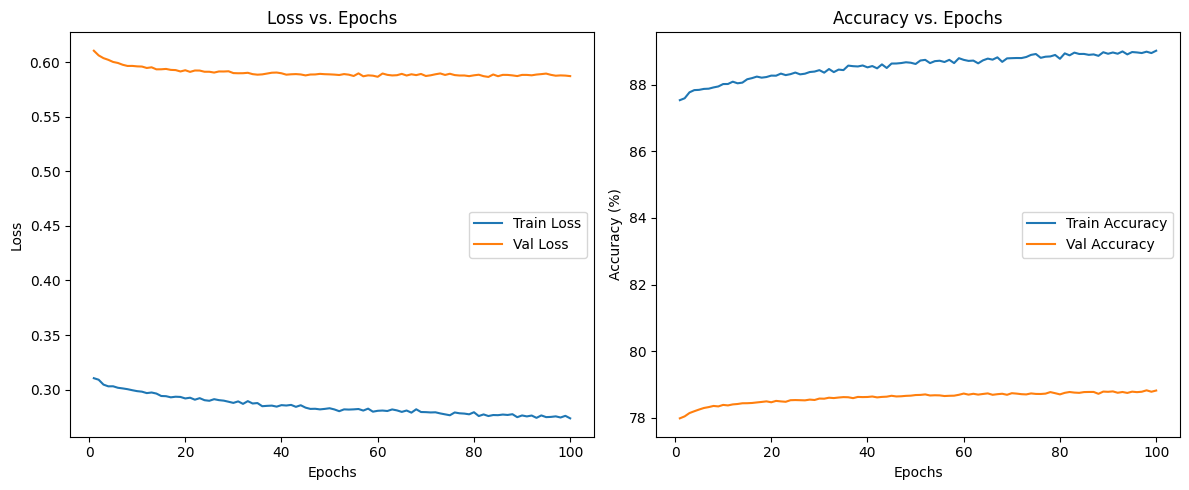

In [21]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100)

In [ ]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100,scheduler)
#resnet101

In [ ]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,100,scheduler)
#efficient-b0

In [24]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Define the Unet++ model with ResNet-101 encoder
model_unet = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2",         # use ResNet-101 as the encoder
    encoder_weights="imagenet",       # use pre-trained weights on ImageNet
    in_channels=6,                    # number of input channels (MSI + SAR)
    classes=14                        # number of output classes (for segmentation)
)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unet = model_unet.to(device)

loss_fn = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-3)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=1e-8)


  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  9.59it/s]


Epoch 1 | Train Loss:   23.2031 | Train Accuracy:   4.2640% | Train mIOU:   0.0124 | Train mF1:   0.0463 | Train Precision:   0.0507 | Train Recall:   0.0426


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 1 | Val Loss:   23.1966 | Val Accuracy:   2.4739% | Val mIOU:   0.0068 | Val mF1:   0.0313 | Val Precision:   0.0424 | Val Recall:   0.0247


100%|██████████| 12/12 [00:01<00:00,  9.39it/s]


Epoch 2 | Train Loss:   5.0298 | Train Accuracy:   11.3869% | Train mIOU:   0.0249 | Train mF1:   0.1005 | Train Precision:   0.0899 | Train Recall:   0.1139


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 2 | Val Loss:   5.0321 | Val Accuracy:   4.2121% | Val mIOU:   0.0105 | Val mF1:   0.0606 | Val Precision:   0.1082 | Val Recall:   0.0421


100%|██████████| 12/12 [00:01<00:00,  9.47it/s]


Epoch 3 | Train Loss:   1.9403 | Train Accuracy:   42.0515% | Train mIOU:   0.2194 | Train mF1:   0.4122 | Train Precision:   0.4043 | Train Recall:   0.4205


100%|██████████| 3/3 [00:00<00:00, 17.00it/s]


Epoch 3 | Val Loss:   2.1693 | Val Accuracy:   33.3761% | Val mIOU:   0.1553 | Val mF1:   0.3498 | Val Precision:   0.3675 | Val Recall:   0.3338


100%|██████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch 4 | Train Loss:   1.4481 | Train Accuracy:   55.1759% | Train mIOU:   0.3370 | Train mF1:   0.5179 | Train Precision:   0.4879 | Train Recall:   0.5518


100%|██████████| 3/3 [00:00<00:00, 16.14it/s]


Epoch 4 | Val Loss:   1.5989 | Val Accuracy:   48.0334% | Val mIOU:   0.2633 | Val mF1:   0.4534 | Val Precision:   0.4293 | Val Recall:   0.4803


100%|██████████| 12/12 [00:01<00:00,  9.25it/s]


Epoch 5 | Train Loss:   1.2626 | Train Accuracy:   61.2450% | Train mIOU:   0.4067 | Train mF1:   0.5689 | Train Precision:   0.5311 | Train Recall:   0.6124


100%|██████████| 3/3 [00:00<00:00, 16.43it/s]


Epoch 5 | Val Loss:   1.3624 | Val Accuracy:   56.3167% | Val mIOU:   0.3490 | Val mF1:   0.5180 | Val Precision:   0.4796 | Val Recall:   0.5632


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 6 | Train Loss:   1.1409 | Train Accuracy:   65.0196% | Train mIOU:   0.4587 | Train mF1:   0.6001 | Train Precision:   0.5572 | Train Recall:   0.6502


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 6 | Val Loss:   1.2794 | Val Accuracy:   58.6596% | Val mIOU:   0.3850 | Val mF1:   0.5389 | Val Precision:   0.4984 | Val Recall:   0.5866


100%|██████████| 12/12 [00:01<00:00,  9.41it/s]


Epoch 7 | Train Loss:   1.1047 | Train Accuracy:   65.1533% | Train mIOU:   0.4560 | Train mF1:   0.5958 | Train Precision:   0.5489 | Train Recall:   0.6515


100%|██████████| 3/3 [00:00<00:00, 16.36it/s]


Epoch 7 | Val Loss:   1.2691 | Val Accuracy:   57.7183% | Val mIOU:   0.3691 | Val mF1:   0.5200 | Val Precision:   0.4731 | Val Recall:   0.5772


100%|██████████| 12/12 [00:01<00:00,  9.42it/s]


Epoch 8 | Train Loss:   1.0099 | Train Accuracy:   67.8242% | Train mIOU:   0.4929 | Train mF1:   0.6347 | Train Precision:   0.5964 | Train Recall:   0.6782


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


Epoch 8 | Val Loss:   1.1483 | Val Accuracy:   61.6502% | Val mIOU:   0.4196 | Val mF1:   0.5720 | Val Precision:   0.5335 | Val Recall:   0.6165


100%|██████████| 12/12 [00:01<00:00,  9.61it/s]


Epoch 9 | Train Loss:   0.9820 | Train Accuracy:   68.2547% | Train mIOU:   0.4916 | Train mF1:   0.6299 | Train Precision:   0.5849 | Train Recall:   0.6825


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 9 | Val Loss:   1.1577 | Val Accuracy:   61.2252% | Val mIOU:   0.4094 | Val mF1:   0.5619 | Val Precision:   0.5192 | Val Recall:   0.6123


100%|██████████| 12/12 [00:01<00:00,  9.53it/s]


Epoch 10 | Train Loss:   0.9351 | Train Accuracy:   69.3077% | Train mIOU:   0.5051 | Train mF1:   0.6462 | Train Precision:   0.6053 | Train Recall:   0.6931


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Epoch 10 | Val Loss:   1.0955 | Val Accuracy:   62.9137% | Val mIOU:   0.4283 | Val mF1:   0.5760 | Val Precision:   0.5311 | Val Recall:   0.6291


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 11 | Train Loss:   0.9499 | Train Accuracy:   69.0605% | Train mIOU:   0.5073 | Train mF1:   0.6522 | Train Precision:   0.6178 | Train Recall:   0.6906


100%|██████████| 3/3 [00:00<00:00, 16.24it/s]


Epoch 11 | Val Loss:   1.1062 | Val Accuracy:   62.9459% | Val mIOU:   0.4323 | Val mF1:   0.5944 | Val Precision:   0.5631 | Val Recall:   0.6295


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 12 | Train Loss:   0.8901 | Train Accuracy:   70.1129% | Train mIOU:   0.5151 | Train mF1:   0.6633 | Train Precision:   0.6293 | Train Recall:   0.7011


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


Epoch 12 | Val Loss:   1.0690 | Val Accuracy:   63.2355% | Val mIOU:   0.4312 | Val mF1:   0.5904 | Val Precision:   0.5536 | Val Recall:   0.6324


100%|██████████| 12/12 [00:01<00:00,  9.47it/s]


Epoch 13 | Train Loss:   0.8685 | Train Accuracy:   70.7425% | Train mIOU:   0.5306 | Train mF1:   0.6786 | Train Precision:   0.6519 | Train Recall:   0.7074


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 13 | Val Loss:   1.0558 | Val Accuracy:   63.7789% | Val mIOU:   0.4459 | Val mF1:   0.6053 | Val Precision:   0.5759 | Val Recall:   0.6378


100%|██████████| 12/12 [00:01<00:00,  9.66it/s]


Epoch 14 | Train Loss:   0.8236 | Train Accuracy:   71.7597% | Train mIOU:   0.5516 | Train mF1:   0.6933 | Train Precision:   0.6705 | Train Recall:   0.7176


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


Epoch 14 | Val Loss:   1.0065 | Val Accuracy:   64.9430% | Val mIOU:   0.4694 | Val mF1:   0.6230 | Val Precision:   0.5987 | Val Recall:   0.6494


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 15 | Train Loss:   0.8192 | Train Accuracy:   72.1655% | Train mIOU:   0.5601 | Train mF1:   0.7017 | Train Precision:   0.6827 | Train Recall:   0.7217


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Epoch 15 | Val Loss:   1.0045 | Val Accuracy:   65.4672% | Val mIOU:   0.4786 | Val mF1:   0.6338 | Val Precision:   0.6143 | Val Recall:   0.6547


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 16 | Train Loss:   0.7717 | Train Accuracy:   73.2254% | Train mIOU:   0.5731 | Train mF1:   0.7141 | Train Precision:   0.6969 | Train Recall:   0.7323


100%|██████████| 3/3 [00:00<00:00, 15.59it/s]


Epoch 16 | Val Loss:   0.9641 | Val Accuracy:   66.1646% | Val mIOU:   0.4867 | Val mF1:   0.6423 | Val Precision:   0.6240 | Val Recall:   0.6616


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 17 | Train Loss:   0.7549 | Train Accuracy:   74.5170% | Train mIOU:   0.5952 | Train mF1:   0.7301 | Train Precision:   0.7156 | Train Recall:   0.7452


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


Epoch 17 | Val Loss:   0.9486 | Val Accuracy:   67.5370% | Val mIOU:   0.5074 | Val mF1:   0.6587 | Val Precision:   0.6429 | Val Recall:   0.6754


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 18 | Train Loss:   0.7333 | Train Accuracy:   74.6250% | Train mIOU:   0.5887 | Train mF1:   0.7313 | Train Precision:   0.7169 | Train Recall:   0.7462


100%|██████████| 3/3 [00:00<00:00, 16.56it/s]


Epoch 18 | Val Loss:   0.9366 | Val Accuracy:   67.4081% | Val mIOU:   0.4976 | Val mF1:   0.6566 | Val Precision:   0.6401 | Val Recall:   0.6741


100%|██████████| 12/12 [00:01<00:00,  9.32it/s]


Epoch 19 | Train Loss:   0.7344 | Train Accuracy:   75.1107% | Train mIOU:   0.5961 | Train mF1:   0.7345 | Train Precision:   0.7187 | Train Recall:   0.7511


100%|██████████| 3/3 [00:00<00:00, 15.85it/s]


Epoch 19 | Val Loss:   0.9603 | Val Accuracy:   67.2433% | Val mIOU:   0.4970 | Val mF1:   0.6544 | Val Precision:   0.6373 | Val Recall:   0.6724


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


Epoch 20 | Train Loss:   0.7210 | Train Accuracy:   75.0189% | Train mIOU:   0.6082 | Train mF1:   0.7399 | Train Precision:   0.7299 | Train Recall:   0.7502


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Epoch 20 | Val Loss:   0.9450 | Val Accuracy:   67.0311% | Val mIOU:   0.5117 | Val mF1:   0.6622 | Val Precision:   0.6543 | Val Recall:   0.6703


100%|██████████| 12/12 [00:01<00:00,  9.47it/s]


Epoch 21 | Train Loss:   0.7727 | Train Accuracy:   73.0145% | Train mIOU:   0.5925 | Train mF1:   0.7274 | Train Precision:   0.7247 | Train Recall:   0.7301


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


Epoch 21 | Val Loss:   1.0029 | Val Accuracy:   64.9013% | Val mIOU:   0.4958 | Val mF1:   0.6469 | Val Precision:   0.6448 | Val Recall:   0.6490


100%|██████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 22 | Train Loss:   0.6719 | Train Accuracy:   76.8453% | Train mIOU:   0.6255 | Train mF1:   0.7557 | Train Precision:   0.7434 | Train Recall:   0.7685


100%|██████████| 3/3 [00:00<00:00, 16.77it/s]


Epoch 22 | Val Loss:   0.8982 | Val Accuracy:   69.0369% | Val mIOU:   0.5238 | Val mF1:   0.6755 | Val Precision:   0.6613 | Val Recall:   0.6904


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 23 | Train Loss:   0.6487 | Train Accuracy:   77.7473% | Train mIOU:   0.6446 | Train mF1:   0.7673 | Train Precision:   0.7574 | Train Recall:   0.7775


100%|██████████| 3/3 [00:00<00:00, 15.65it/s]


Epoch 23 | Val Loss:   0.8795 | Val Accuracy:   69.3196% | Val mIOU:   0.5377 | Val mF1:   0.6836 | Val Precision:   0.6744 | Val Recall:   0.6932


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


Epoch 24 | Train Loss:   0.7068 | Train Accuracy:   75.1082% | Train mIOU:   0.6145 | Train mF1:   0.7480 | Train Precision:   0.7450 | Train Recall:   0.7511


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 24 | Val Loss:   0.9187 | Val Accuracy:   67.5361% | Val mIOU:   0.5199 | Val mF1:   0.6694 | Val Precision:   0.6636 | Val Recall:   0.6754


100%|██████████| 12/12 [00:01<00:00,  9.50it/s]


Epoch 25 | Train Loss:   0.6308 | Train Accuracy:   78.0434% | Train mIOU:   0.6440 | Train mF1:   0.7694 | Train Precision:   0.7587 | Train Recall:   0.7804


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 25 | Val Loss:   0.8748 | Val Accuracy:   69.6715% | Val mIOU:   0.5370 | Val mF1:   0.6851 | Val Precision:   0.6740 | Val Recall:   0.6967


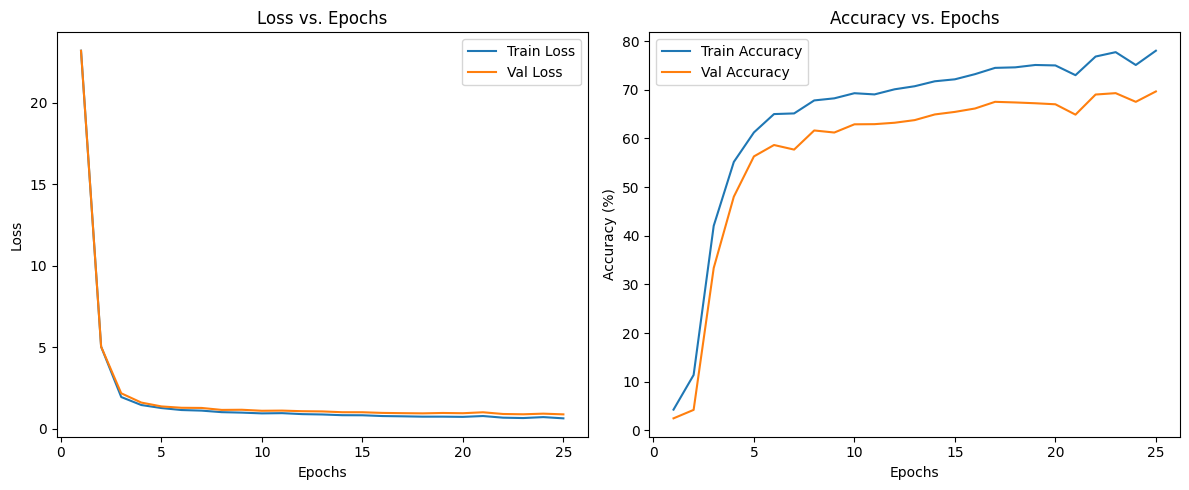

In [25]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,25)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 1 | Train Loss:   0.5957 | Train Accuracy:   79.0807% | Train mIOU:   0.6607 | Train mF1:   0.7805 | Train Precision:   0.7704 | Train Recall:   0.7908


100%|██████████| 3/3 [00:00<00:00, 15.55it/s]


Epoch 1 | Val Loss:   0.8359 | Val Accuracy:   70.6053% | Val mIOU:   0.5519 | Val mF1:   0.6960 | Val Precision:   0.6862 | Val Recall:   0.7061


100%|██████████| 12/12 [00:01<00:00,  9.58it/s]


Epoch 2 | Train Loss:   0.5778 | Train Accuracy:   79.4467% | Train mIOU:   0.6693 | Train mF1:   0.7860 | Train Precision:   0.7778 | Train Recall:   0.7945


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]


Epoch 2 | Val Loss:   0.8325 | Val Accuracy:   70.5784% | Val mIOU:   0.5542 | Val mF1:   0.6984 | Val Precision:   0.6912 | Val Recall:   0.7058


100%|██████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 3 | Train Loss:   0.5788 | Train Accuracy:   79.5910% | Train mIOU:   0.6638 | Train mF1:   0.7855 | Train Precision:   0.7754 | Train Recall:   0.7959


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 3 | Val Loss:   0.8380 | Val Accuracy:   70.8315% | Val mIOU:   0.5497 | Val mF1:   0.6971 | Val Precision:   0.6862 | Val Recall:   0.7083


100%|██████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch 4 | Train Loss:   0.5493 | Train Accuracy:   80.3965% | Train mIOU:   0.6830 | Train mF1:   0.7960 | Train Precision:   0.7882 | Train Recall:   0.8040


100%|██████████| 3/3 [00:00<00:00, 15.65it/s]


Epoch 4 | Val Loss:   0.8104 | Val Accuracy:   71.3695% | Val mIOU:   0.5661 | Val mF1:   0.7063 | Val Precision:   0.6990 | Val Recall:   0.7137


100%|██████████| 12/12 [00:01<00:00,  9.46it/s]


Epoch 5 | Train Loss:   0.5574 | Train Accuracy:   80.0444% | Train mIOU:   0.6730 | Train mF1:   0.7912 | Train Precision:   0.7822 | Train Recall:   0.8004


100%|██████████| 3/3 [00:00<00:00, 16.79it/s]


Epoch 5 | Val Loss:   0.8285 | Val Accuracy:   71.2579% | Val mIOU:   0.5570 | Val mF1:   0.7023 | Val Precision:   0.6924 | Val Recall:   0.7126


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 6 | Train Loss:   0.5205 | Train Accuracy:   81.1343% | Train mIOU:   0.6902 | Train mF1:   0.8030 | Train Precision:   0.7947 | Train Recall:   0.8113


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 6 | Val Loss:   0.7906 | Val Accuracy:   72.2356% | Val mIOU:   0.5728 | Val mF1:   0.7132 | Val Precision:   0.7042 | Val Recall:   0.7224


100%|██████████| 12/12 [00:01<00:00,  9.61it/s]


Epoch 7 | Train Loss:   0.5259 | Train Accuracy:   80.6922% | Train mIOU:   0.6787 | Train mF1:   0.7986 | Train Precision:   0.7905 | Train Recall:   0.8069


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 7 | Val Loss:   0.8052 | Val Accuracy:   72.0069% | Val mIOU:   0.5636 | Val mF1:   0.7093 | Val Precision:   0.6988 | Val Recall:   0.7201


100%|██████████| 12/12 [00:01<00:00,  9.42it/s]


Epoch 8 | Train Loss:   0.5075 | Train Accuracy:   81.5181% | Train mIOU:   0.6989 | Train mF1:   0.8089 | Train Precision:   0.8028 | Train Recall:   0.8152


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 8 | Val Loss:   0.7891 | Val Accuracy:   72.0385% | Val mIOU:   0.5760 | Val mF1:   0.7175 | Val Precision:   0.7146 | Val Recall:   0.7204


100%|██████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch 9 | Train Loss:   0.4900 | Train Accuracy:   81.9544% | Train mIOU:   0.7022 | Train mF1:   0.8127 | Train Precision:   0.8061 | Train Recall:   0.8195


100%|██████████| 3/3 [00:00<00:00, 15.86it/s]


Epoch 9 | Val Loss:   0.7805 | Val Accuracy:   72.4747% | Val mIOU:   0.5767 | Val mF1:   0.7179 | Val Precision:   0.7113 | Val Recall:   0.7247


100%|██████████| 12/12 [00:01<00:00,  9.50it/s]


Epoch 10 | Train Loss:   0.4804 | Train Accuracy:   82.3573% | Train mIOU:   0.7113 | Train mF1:   0.8183 | Train Precision:   0.8132 | Train Recall:   0.8236


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 10 | Val Loss:   0.7694 | Val Accuracy:   72.7351% | Val mIOU:   0.5827 | Val mF1:   0.7216 | Val Precision:   0.7160 | Val Recall:   0.7274


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 11 | Train Loss:   0.4790 | Train Accuracy:   82.2069% | Train mIOU:   0.7060 | Train mF1:   0.8172 | Train Precision:   0.8124 | Train Recall:   0.8221


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


Epoch 11 | Val Loss:   0.7696 | Val Accuracy:   72.9613% | Val mIOU:   0.5831 | Val mF1:   0.7238 | Val Precision:   0.7180 | Val Recall:   0.7296


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 12 | Train Loss:   0.4656 | Train Accuracy:   82.6710% | Train mIOU:   0.7103 | Train mF1:   0.8206 | Train Precision:   0.8145 | Train Recall:   0.8267


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


Epoch 12 | Val Loss:   0.7566 | Val Accuracy:   73.5421% | Val mIOU:   0.5860 | Val mF1:   0.7270 | Val Precision:   0.7187 | Val Recall:   0.7354


100%|██████████| 12/12 [00:01<00:00,  9.49it/s]


Epoch 13 | Train Loss:   0.4425 | Train Accuracy:   83.5119% | Train mIOU:   0.7276 | Train mF1:   0.8315 | Train Precision:   0.8278 | Train Recall:   0.8351


100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


Epoch 13 | Val Loss:   0.7377 | Val Accuracy:   73.7054% | Val mIOU:   0.5972 | Val mF1:   0.7346 | Val Precision:   0.7321 | Val Recall:   0.7371


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 14 | Train Loss:   0.4306 | Train Accuracy:   83.9727% | Train mIOU:   0.7339 | Train mF1:   0.8360 | Train Precision:   0.8323 | Train Recall:   0.8397


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 14 | Val Loss:   0.7351 | Val Accuracy:   73.6971% | Val mIOU:   0.5974 | Val mF1:   0.7340 | Val Precision:   0.7311 | Val Recall:   0.7370


100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Epoch 15 | Train Loss:   0.4261 | Train Accuracy:   84.1819% | Train mIOU:   0.7380 | Train mF1:   0.8398 | Train Precision:   0.8377 | Train Recall:   0.8418


100%|██████████| 3/3 [00:00<00:00, 16.55it/s]


Epoch 15 | Val Loss:   0.7347 | Val Accuracy:   73.8607% | Val mIOU:   0.5997 | Val mF1:   0.7382 | Val Precision:   0.7378 | Val Recall:   0.7386


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 16 | Train Loss:   0.4293 | Train Accuracy:   83.9955% | Train mIOU:   0.7348 | Train mF1:   0.8378 | Train Precision:   0.8357 | Train Recall:   0.8400


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 16 | Val Loss:   0.7457 | Val Accuracy:   73.6706% | Val mIOU:   0.5958 | Val mF1:   0.7350 | Val Precision:   0.7332 | Val Recall:   0.7367


100%|██████████| 12/12 [00:01<00:00,  9.39it/s]


Epoch 17 | Train Loss:   0.4134 | Train Accuracy:   84.5005% | Train mIOU:   0.7404 | Train mF1:   0.8420 | Train Precision:   0.8390 | Train Recall:   0.8450


100%|██████████| 3/3 [00:00<00:00, 16.17it/s]


Epoch 17 | Val Loss:   0.7264 | Val Accuracy:   74.6684% | Val mIOU:   0.6044 | Val mF1:   0.7426 | Val Precision:   0.7385 | Val Recall:   0.7467


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


Epoch 18 | Train Loss:   0.4061 | Train Accuracy:   84.7239% | Train mIOU:   0.7459 | Train mF1:   0.8457 | Train Precision:   0.8442 | Train Recall:   0.8472


100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


Epoch 18 | Val Loss:   0.7290 | Val Accuracy:   74.3077% | Val mIOU:   0.6045 | Val mF1:   0.7420 | Val Precision:   0.7410 | Val Recall:   0.7431


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 19 | Train Loss:   0.4005 | Train Accuracy:   84.9175% | Train mIOU:   0.7515 | Train mF1:   0.8506 | Train Precision:   0.8521 | Train Recall:   0.8492


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 19 | Val Loss:   0.7408 | Val Accuracy:   73.9866% | Val mIOU:   0.6041 | Val mF1:   0.7432 | Val Precision:   0.7466 | Val Recall:   0.7399


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 20 | Train Loss:   0.3805 | Train Accuracy:   85.7125% | Train mIOU:   0.7602 | Train mF1:   0.8555 | Train Precision:   0.8539 | Train Recall:   0.8571


100%|██████████| 3/3 [00:00<00:00, 16.26it/s]


Epoch 20 | Val Loss:   0.7171 | Val Accuracy:   74.6791% | Val mIOU:   0.6099 | Val mF1:   0.7463 | Val Precision:   0.7458 | Val Recall:   0.7468


100%|██████████| 12/12 [00:01<00:00,  9.28it/s]


Epoch 21 | Train Loss:   0.3686 | Train Accuracy:   86.0201% | Train mIOU:   0.7670 | Train mF1:   0.8609 | Train Precision:   0.8617 | Train Recall:   0.8602


100%|██████████| 3/3 [00:00<00:00, 15.60it/s]


Epoch 21 | Val Loss:   0.7103 | Val Accuracy:   74.8367% | Val mIOU:   0.6134 | Val mF1:   0.7508 | Val Precision:   0.7532 | Val Recall:   0.7484


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 22 | Train Loss:   0.3614 | Train Accuracy:   86.2240% | Train mIOU:   0.7659 | Train mF1:   0.8601 | Train Precision:   0.8580 | Train Recall:   0.8622


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Epoch 22 | Val Loss:   0.6915 | Val Accuracy:   75.5226% | Val mIOU:   0.6188 | Val mF1:   0.7526 | Val Precision:   0.7499 | Val Recall:   0.7552


100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


Epoch 23 | Train Loss:   0.3533 | Train Accuracy:   86.6756% | Train mIOU:   0.7762 | Train mF1:   0.8674 | Train Precision:   0.8681 | Train Recall:   0.8668


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 23 | Val Loss:   0.6950 | Val Accuracy:   75.4911% | Val mIOU:   0.6201 | Val mF1:   0.7565 | Val Precision:   0.7581 | Val Recall:   0.7549


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 24 | Train Loss:   0.3408 | Train Accuracy:   87.0394% | Train mIOU:   0.7776 | Train mF1:   0.8685 | Train Precision:   0.8666 | Train Recall:   0.8704


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 24 | Val Loss:   0.6801 | Val Accuracy:   76.1876% | Val mIOU:   0.6255 | Val mF1:   0.7590 | Val Precision:   0.7561 | Val Recall:   0.7619


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 25 | Train Loss:   0.3302 | Train Accuracy:   87.4679% | Train mIOU:   0.7860 | Train mF1:   0.8737 | Train Precision:   0.8728 | Train Recall:   0.8747


100%|██████████| 3/3 [00:00<00:00, 15.86it/s]


Epoch 25 | Val Loss:   0.6907 | Val Accuracy:   76.2308% | Val mIOU:   0.6274 | Val mF1:   0.7610 | Val Precision:   0.7597 | Val Recall:   0.7623


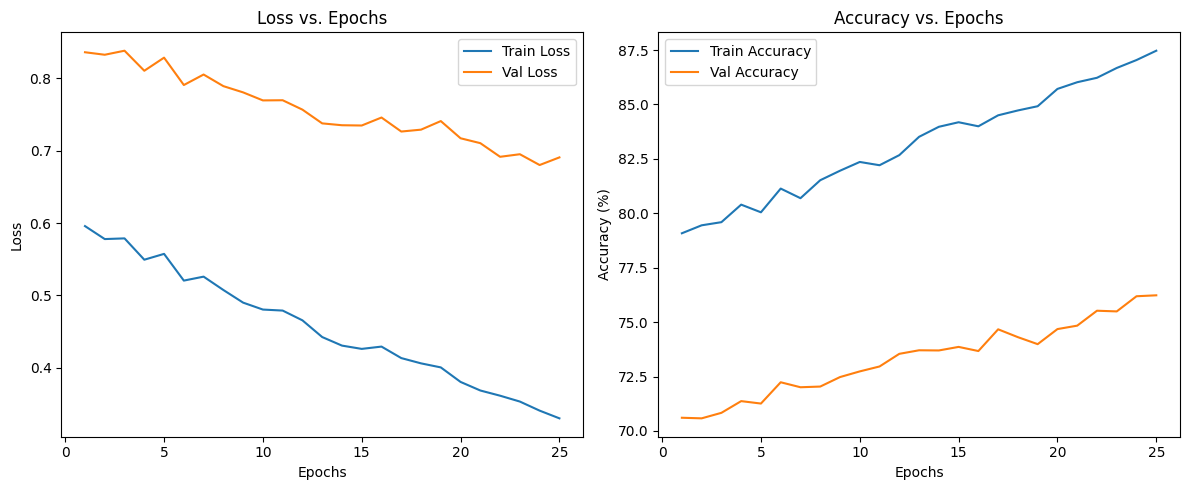

In [26]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,25)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  9.49it/s]


Epoch 1 | Train Loss:   0.3490 | Train Accuracy:   86.6574% | Train mIOU:   0.7775 | Train mF1:   0.8697 | Train Precision:   0.8728 | Train Recall:   0.8666


100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


Epoch 1 | Val Loss:   0.6893 | Val Accuracy:   75.4587% | Val mIOU:   0.6241 | Val mF1:   0.7605 | Val Precision:   0.7665 | Val Recall:   0.7546


100%|██████████| 12/12 [00:01<00:00,  9.42it/s]


Epoch 2 | Train Loss:   0.3348 | Train Accuracy:   87.3870% | Train mIOU:   0.7852 | Train mF1:   0.8739 | Train Precision:   0.8740 | Train Recall:   0.8739


100%|██████████| 3/3 [00:00<00:00, 15.69it/s]


Epoch 2 | Val Loss:   0.6879 | Val Accuracy:   75.7280% | Val mIOU:   0.6252 | Val mF1:   0.7590 | Val Precision:   0.7607 | Val Recall:   0.7573


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 3 | Train Loss:   0.3262 | Train Accuracy:   87.6309% | Train mIOU:   0.7874 | Train mF1:   0.8757 | Train Precision:   0.8750 | Train Recall:   0.8763


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 3 | Val Loss:   0.6937 | Val Accuracy:   76.1067% | Val mIOU:   0.6246 | Val mF1:   0.7609 | Val Precision:   0.7608 | Val Recall:   0.7611


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 4 | Train Loss:   0.3133 | Train Accuracy:   88.0745% | Train mIOU:   0.7945 | Train mF1:   0.8799 | Train Precision:   0.8790 | Train Recall:   0.8807


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 4 | Val Loss:   0.6596 | Val Accuracy:   77.1270% | Val mIOU:   0.6391 | Val mF1:   0.7697 | Val Precision:   0.7681 | Val Recall:   0.7713


100%|██████████| 12/12 [00:01<00:00,  9.26it/s]


Epoch 5 | Train Loss:   0.3003 | Train Accuracy:   88.6340% | Train mIOU:   0.8054 | Train mF1:   0.8876 | Train Precision:   0.8889 | Train Recall:   0.8863


100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


Epoch 5 | Val Loss:   0.6507 | Val Accuracy:   77.0080% | Val mIOU:   0.6421 | Val mF1:   0.7730 | Val Precision:   0.7759 | Val Recall:   0.7701


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


Epoch 6 | Train Loss:   0.3046 | Train Accuracy:   88.4299% | Train mIOU:   0.7989 | Train mF1:   0.8838 | Train Precision:   0.8832 | Train Recall:   0.8843


100%|██████████| 3/3 [00:00<00:00, 15.52it/s]


Epoch 6 | Val Loss:   0.6649 | Val Accuracy:   77.3428% | Val mIOU:   0.6386 | Val mF1:   0.7717 | Val Precision:   0.7699 | Val Recall:   0.7734


100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


Epoch 7 | Train Loss:   0.2932 | Train Accuracy:   88.8635% | Train mIOU:   0.8075 | Train mF1:   0.8893 | Train Precision:   0.8900 | Train Recall:   0.8886


100%|██████████| 3/3 [00:00<00:00, 15.95it/s]


Epoch 7 | Val Loss:   0.6472 | Val Accuracy:   77.4983% | Val mIOU:   0.6450 | Val mF1:   0.7754 | Val Precision:   0.7758 | Val Recall:   0.7750


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


Epoch 8 | Train Loss:   0.2960 | Train Accuracy:   88.6571% | Train mIOU:   0.8024 | Train mF1:   0.8860 | Train Precision:   0.8854 | Train Recall:   0.8866


100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Epoch 8 | Val Loss:   0.6606 | Val Accuracy:   77.5464% | Val mIOU:   0.6421 | Val mF1:   0.7736 | Val Precision:   0.7718 | Val Recall:   0.7755


100%|██████████| 12/12 [00:01<00:00,  9.63it/s]


Epoch 9 | Train Loss:   0.2900 | Train Accuracy:   89.0799% | Train mIOU:   0.8098 | Train mF1:   0.8907 | Train Precision:   0.8906 | Train Recall:   0.8908


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 9 | Val Loss:   0.6630 | Val Accuracy:   77.3851% | Val mIOU:   0.6432 | Val mF1:   0.7743 | Val Precision:   0.7748 | Val Recall:   0.7739


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 10 | Train Loss:   0.2691 | Train Accuracy:   89.7196% | Train mIOU:   0.8193 | Train mF1:   0.8969 | Train Precision:   0.8966 | Train Recall:   0.8972


100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Epoch 10 | Val Loss:   0.6414 | Val Accuracy:   78.1416% | Val mIOU:   0.6502 | Val mF1:   0.7802 | Val Precision:   0.7789 | Val Recall:   0.7814


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 11 | Train Loss:   0.2562 | Train Accuracy:   90.2323% | Train mIOU:   0.8267 | Train mF1:   0.9016 | Train Precision:   0.9008 | Train Recall:   0.9023


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 11 | Val Loss:   0.6245 | Val Accuracy:   78.7951% | Val mIOU:   0.6582 | Val mF1:   0.7858 | Val Precision:   0.7836 | Val Recall:   0.7880


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 12 | Train Loss:   0.2711 | Train Accuracy:   89.6442% | Train mIOU:   0.8166 | Train mF1:   0.8961 | Train Precision:   0.8959 | Train Recall:   0.8964


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 12 | Val Loss:   0.6574 | Val Accuracy:   78.2113% | Val mIOU:   0.6487 | Val mF1:   0.7810 | Val Precision:   0.7798 | Val Recall:   0.7821


100%|██████████| 12/12 [00:01<00:00,  9.57it/s]


Epoch 13 | Train Loss:   0.2658 | Train Accuracy:   89.9712% | Train mIOU:   0.8238 | Train mF1:   0.8998 | Train Precision:   0.8999 | Train Recall:   0.8997


100%|██████████| 3/3 [00:00<00:00, 16.46it/s]


Epoch 13 | Val Loss:   0.6623 | Val Accuracy:   78.1133% | Val mIOU:   0.6506 | Val mF1:   0.7805 | Val Precision:   0.7799 | Val Recall:   0.7811


100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Epoch 14 | Train Loss:   0.2653 | Train Accuracy:   89.8729% | Train mIOU:   0.8206 | Train mF1:   0.8985 | Train Precision:   0.8982 | Train Recall:   0.8987


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 14 | Val Loss:   0.6669 | Val Accuracy:   77.8974% | Val mIOU:   0.6455 | Val mF1:   0.7781 | Val Precision:   0.7771 | Val Recall:   0.7790


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 15 | Train Loss:   0.2549 | Train Accuracy:   90.4247% | Train mIOU:   0.8314 | Train mF1:   0.9052 | Train Precision:   0.9061 | Train Recall:   0.9042


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


Epoch 15 | Val Loss:   0.6347 | Val Accuracy:   78.6838% | Val mIOU:   0.6608 | Val mF1:   0.7882 | Val Precision:   0.7896 | Val Recall:   0.7868


100%|██████████| 12/12 [00:01<00:00,  9.46it/s]


Epoch 16 | Train Loss:   0.2461 | Train Accuracy:   90.7692% | Train mIOU:   0.8361 | Train mF1:   0.9081 | Train Precision:   0.9086 | Train Recall:   0.9077


100%|██████████| 3/3 [00:00<00:00, 16.26it/s]


Epoch 16 | Val Loss:   0.6350 | Val Accuracy:   78.6977% | Val mIOU:   0.6598 | Val mF1:   0.7879 | Val Precision:   0.7889 | Val Recall:   0.7870


100%|██████████| 12/12 [00:01<00:00,  9.41it/s]


Epoch 17 | Train Loss:   0.2386 | Train Accuracy:   91.0506% | Train mIOU:   0.8413 | Train mF1:   0.9114 | Train Precision:   0.9123 | Train Recall:   0.9105


100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


Epoch 17 | Val Loss:   0.6176 | Val Accuracy:   79.0977% | Val mIOU:   0.6651 | Val mF1:   0.7915 | Val Precision:   0.7920 | Val Recall:   0.7910


100%|██████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 18 | Train Loss:   0.2297 | Train Accuracy:   91.3481% | Train mIOU:   0.8451 | Train mF1:   0.9137 | Train Precision:   0.9139 | Train Recall:   0.9135


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 18 | Val Loss:   0.6153 | Val Accuracy:   79.4603% | Val mIOU:   0.6685 | Val mF1:   0.7941 | Val Precision:   0.7936 | Val Recall:   0.7946


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 19 | Train Loss:   0.2269 | Train Accuracy:   91.5017% | Train mIOU:   0.8484 | Train mF1:   0.9162 | Train Precision:   0.9174 | Train Recall:   0.9150


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Epoch 19 | Val Loss:   0.6256 | Val Accuracy:   79.1901% | Val mIOU:   0.6669 | Val mF1:   0.7941 | Val Precision:   0.7964 | Val Recall:   0.7919


100%|██████████| 12/12 [00:01<00:00,  9.66it/s]


Epoch 20 | Train Loss:   0.2187 | Train Accuracy:   91.9173% | Train mIOU:   0.8552 | Train mF1:   0.9200 | Train Precision:   0.9208 | Train Recall:   0.9192


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 20 | Val Loss:   0.6160 | Val Accuracy:   79.4052% | Val mIOU:   0.6708 | Val mF1:   0.7958 | Val Precision:   0.7976 | Val Recall:   0.7941


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


Epoch 21 | Train Loss:   0.2167 | Train Accuracy:   91.8850% | Train mIOU:   0.8534 | Train mF1:   0.9187 | Train Precision:   0.9186 | Train Recall:   0.9189


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 21 | Val Loss:   0.6157 | Val Accuracy:   79.8076% | Val mIOU:   0.6721 | Val mF1:   0.7974 | Val Precision:   0.7968 | Val Recall:   0.7981


100%|██████████| 12/12 [00:01<00:00,  9.42it/s]


Epoch 22 | Train Loss:   0.2128 | Train Accuracy:   92.0249% | Train mIOU:   0.8563 | Train mF1:   0.9204 | Train Precision:   0.9206 | Train Recall:   0.9202


100%|██████████| 3/3 [00:00<00:00, 16.22it/s]


Epoch 22 | Val Loss:   0.6153 | Val Accuracy:   79.8872% | Val mIOU:   0.6748 | Val mF1:   0.7983 | Val Precision:   0.7977 | Val Recall:   0.7989


100%|██████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 23 | Train Loss:   0.2046 | Train Accuracy:   92.3773% | Train mIOU:   0.8622 | Train mF1:   0.9246 | Train Precision:   0.9254 | Train Recall:   0.9238


100%|██████████| 3/3 [00:00<00:00, 15.89it/s]


Epoch 23 | Val Loss:   0.6114 | Val Accuracy:   79.9379% | Val mIOU:   0.6754 | Val mF1:   0.8005 | Val Precision:   0.8016 | Val Recall:   0.7994


100%|██████████| 12/12 [00:01<00:00,  9.50it/s]


Epoch 24 | Train Loss:   0.2051 | Train Accuracy:   92.3940% | Train mIOU:   0.8625 | Train mF1:   0.9245 | Train Precision:   0.9251 | Train Recall:   0.9239


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 24 | Val Loss:   0.6112 | Val Accuracy:   80.0110% | Val mIOU:   0.6773 | Val mF1:   0.8008 | Val Precision:   0.8015 | Val Recall:   0.8001


100%|██████████| 12/12 [00:01<00:00,  9.32it/s]


Epoch 25 | Train Loss:   0.2014 | Train Accuracy:   92.4617% | Train mIOU:   0.8631 | Train mF1:   0.9246 | Train Precision:   0.9245 | Train Recall:   0.9246


100%|██████████| 3/3 [00:00<00:00, 16.52it/s]


Epoch 25 | Val Loss:   0.6160 | Val Accuracy:   80.2458% | Val mIOU:   0.6790 | Val mF1:   0.8016 | Val Precision:   0.8007 | Val Recall:   0.8025


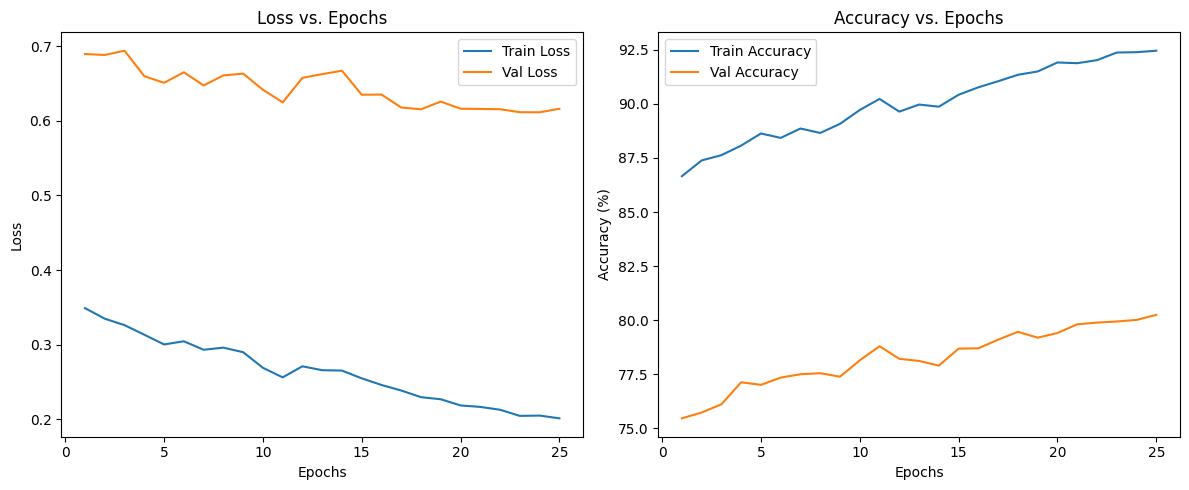

In [27]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,25)

In [40]:
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-4)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  9.64it/s]


Epoch 1 | Train Loss:   0.1794 | Train Accuracy:   93.5481% | Train mIOU:   0.8819 | Train mF1:   0.9360 | Train Precision:   0.9365 | Train Recall:   0.9355


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Epoch 1 | Val Loss:   0.5845 | Val Accuracy:   81.0087% | Val mIOU:   0.6903 | Val mF1:   0.8104 | Val Precision:   0.8107 | Val Recall:   0.8101


100%|██████████| 12/12 [00:01<00:00,  9.56it/s]


Epoch 2 | Train Loss:   0.1726 | Train Accuracy:   93.8883% | Train mIOU:   0.8875 | Train mF1:   0.9392 | Train Precision:   0.9395 | Train Recall:   0.9389


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 2 | Val Loss:   0.5840 | Val Accuracy:   81.1555% | Val mIOU:   0.6915 | Val mF1:   0.8115 | Val Precision:   0.8114 | Val Recall:   0.8116


100%|██████████| 12/12 [00:01<00:00,  9.78it/s]


Epoch 3 | Train Loss:   0.1693 | Train Accuracy:   93.9905% | Train mIOU:   0.8892 | Train mF1:   0.9401 | Train Precision:   0.9403 | Train Recall:   0.9399


100%|██████████| 3/3 [00:00<00:00, 15.63it/s]


Epoch 3 | Val Loss:   0.5847 | Val Accuracy:   81.3090% | Val mIOU:   0.6934 | Val mF1:   0.8125 | Val Precision:   0.8120 | Val Recall:   0.8131


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 4 | Train Loss:   0.1797 | Train Accuracy:   93.4263% | Train mIOU:   0.8799 | Train mF1:   0.9353 | Train Precision:   0.9363 | Train Recall:   0.9343


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


Epoch 4 | Val Loss:   0.6136 | Val Accuracy:   80.4643% | Val mIOU:   0.6824 | Val mF1:   0.8064 | Val Precision:   0.8081 | Val Recall:   0.8046


100%|██████████| 12/12 [00:01<00:00,  9.46it/s]


Epoch 5 | Train Loss:   0.1678 | Train Accuracy:   94.0751% | Train mIOU:   0.8907 | Train mF1:   0.9411 | Train Precision:   0.9414 | Train Recall:   0.9408


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


Epoch 5 | Val Loss:   0.5853 | Val Accuracy:   81.3222% | Val mIOU:   0.6935 | Val mF1:   0.8129 | Val Precision:   0.8126 | Val Recall:   0.8132


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 6 | Train Loss:   0.1659 | Train Accuracy:   94.1719% | Train mIOU:   0.8923 | Train mF1:   0.9420 | Train Precision:   0.9422 | Train Recall:   0.9417


100%|██████████| 3/3 [00:00<00:00, 15.95it/s]


Epoch 6 | Val Loss:   0.5854 | Val Accuracy:   81.2725% | Val mIOU:   0.6931 | Val mF1:   0.8125 | Val Precision:   0.8123 | Val Recall:   0.8127


100%|██████████| 12/12 [00:01<00:00,  9.41it/s]


Epoch 7 | Train Loss:   0.1636 | Train Accuracy:   94.2783% | Train mIOU:   0.8941 | Train mF1:   0.9430 | Train Precision:   0.9433 | Train Recall:   0.9428


100%|██████████| 3/3 [00:00<00:00, 16.54it/s]


Epoch 7 | Val Loss:   0.5867 | Val Accuracy:   81.3117% | Val mIOU:   0.6935 | Val mF1:   0.8127 | Val Precision:   0.8123 | Val Recall:   0.8131


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 8 | Train Loss:   0.1621 | Train Accuracy:   94.3313% | Train mIOU:   0.8950 | Train mF1:   0.9435 | Train Precision:   0.9437 | Train Recall:   0.9433


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


Epoch 8 | Val Loss:   0.5906 | Val Accuracy:   81.3130% | Val mIOU:   0.6934 | Val mF1:   0.8126 | Val Precision:   0.8121 | Val Recall:   0.8131


100%|██████████| 12/12 [00:01<00:00,  9.18it/s]


Epoch 9 | Train Loss:   0.1613 | Train Accuracy:   94.3714% | Train mIOU:   0.8958 | Train mF1:   0.9441 | Train Precision:   0.9445 | Train Recall:   0.9437


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 9 | Val Loss:   0.5907 | Val Accuracy:   81.2859% | Val mIOU:   0.6930 | Val mF1:   0.8128 | Val Precision:   0.8127 | Val Recall:   0.8129


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 10 | Train Loss:   0.1595 | Train Accuracy:   94.4519% | Train mIOU:   0.8972 | Train mF1:   0.9449 | Train Precision:   0.9452 | Train Recall:   0.9445


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


Epoch 10 | Val Loss:   0.5900 | Val Accuracy:   81.3446% | Val mIOU:   0.6940 | Val mF1:   0.8132 | Val Precision:   0.8130 | Val Recall:   0.8134


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 11 | Train Loss:   0.1577 | Train Accuracy:   94.5053% | Train mIOU:   0.8980 | Train mF1:   0.9453 | Train Precision:   0.9455 | Train Recall:   0.9451


100%|██████████| 3/3 [00:00<00:00, 15.47it/s]


Epoch 11 | Val Loss:   0.5946 | Val Accuracy:   81.3483% | Val mIOU:   0.6938 | Val mF1:   0.8131 | Val Precision:   0.8128 | Val Recall:   0.8135


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 12 | Train Loss:   0.1577 | Train Accuracy:   94.5193% | Train mIOU:   0.8983 | Train mF1:   0.9455 | Train Precision:   0.9459 | Train Recall:   0.9452


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 12 | Val Loss:   0.5987 | Val Accuracy:   81.2215% | Val mIOU:   0.6921 | Val mF1:   0.8121 | Val Precision:   0.8120 | Val Recall:   0.8122


100%|██████████| 12/12 [00:01<00:00,  9.39it/s]


Epoch 13 | Train Loss:   0.1570 | Train Accuracy:   94.5371% | Train mIOU:   0.8987 | Train mF1:   0.9457 | Train Precision:   0.9461 | Train Recall:   0.9454


100%|██████████| 3/3 [00:00<00:00, 15.55it/s]


Epoch 13 | Val Loss:   0.5913 | Val Accuracy:   81.4127% | Val mIOU:   0.6951 | Val mF1:   0.8138 | Val Precision:   0.8134 | Val Recall:   0.8141


100%|██████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 14 | Train Loss:   0.1555 | Train Accuracy:   94.5995% | Train mIOU:   0.8997 | Train mF1:   0.9464 | Train Precision:   0.9468 | Train Recall:   0.9460


100%|██████████| 3/3 [00:00<00:00, 16.11it/s]


Epoch 14 | Val Loss:   0.5951 | Val Accuracy:   81.3192% | Val mIOU:   0.6938 | Val mF1:   0.8131 | Val Precision:   0.8130 | Val Recall:   0.8132


100%|██████████| 12/12 [00:01<00:00,  9.51it/s]


Epoch 15 | Train Loss:   0.1546 | Train Accuracy:   94.6269% | Train mIOU:   0.9001 | Train mF1:   0.9466 | Train Precision:   0.9468 | Train Recall:   0.9463


100%|██████████| 3/3 [00:00<00:00, 16.14it/s]


Epoch 15 | Val Loss:   0.5984 | Val Accuracy:   81.3410% | Val mIOU:   0.6936 | Val mF1:   0.8132 | Val Precision:   0.8129 | Val Recall:   0.8134


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 16 | Train Loss:   0.1558 | Train Accuracy:   94.5440% | Train mIOU:   0.8988 | Train mF1:   0.9458 | Train Precision:   0.9461 | Train Recall:   0.9454


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Epoch 16 | Val Loss:   0.5980 | Val Accuracy:   81.3905% | Val mIOU:   0.6943 | Val mF1:   0.8134 | Val Precision:   0.8129 | Val Recall:   0.8139


100%|██████████| 12/12 [00:01<00:00,  9.38it/s]


Epoch 17 | Train Loss:   0.1534 | Train Accuracy:   94.6508% | Train mIOU:   0.9005 | Train mF1:   0.9467 | Train Precision:   0.9470 | Train Recall:   0.9465


100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


Epoch 17 | Val Loss:   0.5990 | Val Accuracy:   81.4391% | Val mIOU:   0.6949 | Val mF1:   0.8141 | Val Precision:   0.8138 | Val Recall:   0.8144


100%|██████████| 12/12 [00:01<00:00,  9.33it/s]


Epoch 18 | Train Loss:   0.1522 | Train Accuracy:   94.7034% | Train mIOU:   0.9015 | Train mF1:   0.9473 | Train Precision:   0.9476 | Train Recall:   0.9470


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 18 | Val Loss:   0.6044 | Val Accuracy:   81.2866% | Val mIOU:   0.6930 | Val mF1:   0.8126 | Val Precision:   0.8124 | Val Recall:   0.8129


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


Epoch 19 | Train Loss:   0.1521 | Train Accuracy:   94.6998% | Train mIOU:   0.9015 | Train mF1:   0.9473 | Train Precision:   0.9475 | Train Recall:   0.9470


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 19 | Val Loss:   0.6012 | Val Accuracy:   81.4284% | Val mIOU:   0.6950 | Val mF1:   0.8140 | Val Precision:   0.8137 | Val Recall:   0.8143


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


Epoch 20 | Train Loss:   0.1509 | Train Accuracy:   94.7609% | Train mIOU:   0.9025 | Train mF1:   0.9480 | Train Precision:   0.9484 | Train Recall:   0.9476


100%|██████████| 3/3 [00:00<00:00, 15.86it/s]


Epoch 20 | Val Loss:   0.6026 | Val Accuracy:   81.3398% | Val mIOU:   0.6935 | Val mF1:   0.8133 | Val Precision:   0.8132 | Val Recall:   0.8134


100%|██████████| 12/12 [00:01<00:00,  8.36it/s]


Epoch 21 | Train Loss:   0.1490 | Train Accuracy:   94.8658% | Train mIOU:   0.9042 | Train mF1:   0.9488 | Train Precision:   0.9490 | Train Recall:   0.9487


100%|██████████| 3/3 [00:00<00:00, 15.27it/s]


Epoch 21 | Val Loss:   0.6059 | Val Accuracy:   81.3535% | Val mIOU:   0.6934 | Val mF1:   0.8130 | Val Precision:   0.8125 | Val Recall:   0.8135


100%|██████████| 12/12 [00:01<00:00,  9.51it/s]


Epoch 22 | Train Loss:   0.1487 | Train Accuracy:   94.8621% | Train mIOU:   0.9043 | Train mF1:   0.9490 | Train Precision:   0.9494 | Train Recall:   0.9486


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 22 | Val Loss:   0.6041 | Val Accuracy:   81.3455% | Val mIOU:   0.6938 | Val mF1:   0.8135 | Val Precision:   0.8135 | Val Recall:   0.8135


100%|██████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch 23 | Train Loss:   0.1472 | Train Accuracy:   94.9180% | Train mIOU:   0.9052 | Train mF1:   0.9495 | Train Precision:   0.9497 | Train Recall:   0.9492


100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


Epoch 23 | Val Loss:   0.6075 | Val Accuracy:   81.3508% | Val mIOU:   0.6939 | Val mF1:   0.8133 | Val Precision:   0.8132 | Val Recall:   0.8135


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 24 | Train Loss:   0.1465 | Train Accuracy:   94.9402% | Train mIOU:   0.9056 | Train mF1:   0.9497 | Train Precision:   0.9500 | Train Recall:   0.9494


100%|██████████| 3/3 [00:00<00:00, 17.25it/s]


Epoch 24 | Val Loss:   0.6056 | Val Accuracy:   81.4121% | Val mIOU:   0.6948 | Val mF1:   0.8139 | Val Precision:   0.8137 | Val Recall:   0.8141


100%|██████████| 12/12 [00:01<00:00,  9.68it/s]


Epoch 25 | Train Loss:   0.1476 | Train Accuracy:   94.8446% | Train mIOU:   0.9039 | Train mF1:   0.9488 | Train Precision:   0.9492 | Train Recall:   0.9484


100%|██████████| 3/3 [00:00<00:00, 15.41it/s]


Epoch 25 | Val Loss:   0.6088 | Val Accuracy:   81.4183% | Val mIOU:   0.6947 | Val mF1:   0.8140 | Val Precision:   0.8139 | Val Recall:   0.8142


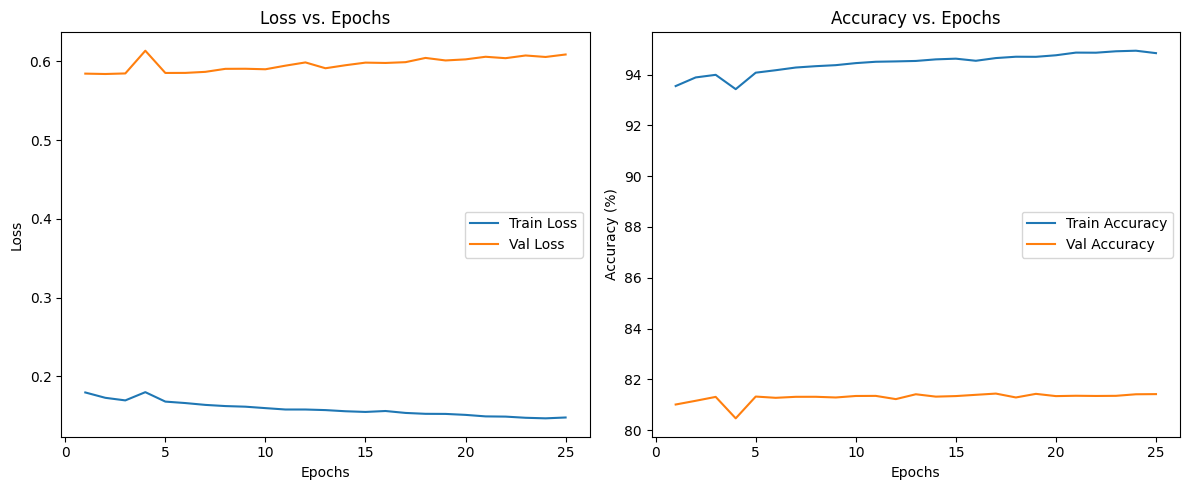

In [29]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,25)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 1 | Train Loss:   0.1474 | Train Accuracy:   94.8886% | Train mIOU:   0.9047 | Train mF1:   0.9493 | Train Precision:   0.9497 | Train Recall:   0.9489


100%|██████████| 3/3 [00:00<00:00, 16.74it/s]


Epoch 1 | Val Loss:   0.6051 | Val Accuracy:   81.4382% | Val mIOU:   0.6949 | Val mF1:   0.8143 | Val Precision:   0.8142 | Val Recall:   0.8144


100%|██████████| 12/12 [00:01<00:00,  9.29it/s]


Epoch 2 | Train Loss:   0.1465 | Train Accuracy:   94.9358% | Train mIOU:   0.9055 | Train mF1:   0.9497 | Train Precision:   0.9501 | Train Recall:   0.9494


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 2 | Val Loss:   0.6041 | Val Accuracy:   81.4561% | Val mIOU:   0.6953 | Val mF1:   0.8145 | Val Precision:   0.8144 | Val Recall:   0.8146


100%|██████████| 12/12 [00:01<00:00,  9.41it/s]


Epoch 3 | Train Loss:   0.1456 | Train Accuracy:   94.9868% | Train mIOU:   0.9064 | Train mF1:   0.9502 | Train Precision:   0.9505 | Train Recall:   0.9499


100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


Epoch 3 | Val Loss:   0.6041 | Val Accuracy:   81.4494% | Val mIOU:   0.6951 | Val mF1:   0.8144 | Val Precision:   0.8143 | Val Recall:   0.8145


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch 4 | Train Loss:   0.1454 | Train Accuracy:   95.0105% | Train mIOU:   0.9068 | Train mF1:   0.9504 | Train Precision:   0.9508 | Train Recall:   0.9501


100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


Epoch 4 | Val Loss:   0.6048 | Val Accuracy:   81.4301% | Val mIOU:   0.6951 | Val mF1:   0.8142 | Val Precision:   0.8141 | Val Recall:   0.8143


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 5 | Train Loss:   0.1446 | Train Accuracy:   95.0331% | Train mIOU:   0.9071 | Train mF1:   0.9506 | Train Precision:   0.9508 | Train Recall:   0.9503


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


Epoch 5 | Val Loss:   0.6060 | Val Accuracy:   81.4744% | Val mIOU:   0.6953 | Val mF1:   0.8144 | Val Precision:   0.8141 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 6 | Train Loss:   0.1445 | Train Accuracy:   95.0485% | Train mIOU:   0.9075 | Train mF1:   0.9508 | Train Precision:   0.9510 | Train Recall:   0.9505


100%|██████████| 3/3 [00:00<00:00, 16.28it/s]


Epoch 6 | Val Loss:   0.6079 | Val Accuracy:   81.4175% | Val mIOU:   0.6946 | Val mF1:   0.8140 | Val Precision:   0.8138 | Val Recall:   0.8142


100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Epoch 7 | Train Loss:   0.1443 | Train Accuracy:   95.0591% | Train mIOU:   0.9077 | Train mF1:   0.9509 | Train Precision:   0.9511 | Train Recall:   0.9506


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 7 | Val Loss:   0.6068 | Val Accuracy:   81.4726% | Val mIOU:   0.6954 | Val mF1:   0.8144 | Val Precision:   0.8142 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.56it/s]


Epoch 8 | Train Loss:   0.1438 | Train Accuracy:   95.0776% | Train mIOU:   0.9080 | Train mF1:   0.9510 | Train Precision:   0.9513 | Train Recall:   0.9508


100%|██████████| 3/3 [00:00<00:00, 16.70it/s]


Epoch 8 | Val Loss:   0.6065 | Val Accuracy:   81.4741% | Val mIOU:   0.6954 | Val mF1:   0.8144 | Val Precision:   0.8140 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.29it/s]


Epoch 9 | Train Loss:   0.1438 | Train Accuracy:   95.0866% | Train mIOU:   0.9081 | Train mF1:   0.9511 | Train Precision:   0.9513 | Train Recall:   0.9509


100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


Epoch 9 | Val Loss:   0.6090 | Val Accuracy:   81.4195% | Val mIOU:   0.6946 | Val mF1:   0.8139 | Val Precision:   0.8136 | Val Recall:   0.8142


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 10 | Train Loss:   0.1436 | Train Accuracy:   95.0853% | Train mIOU:   0.9081 | Train mF1:   0.9511 | Train Precision:   0.9514 | Train Recall:   0.9509


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


Epoch 10 | Val Loss:   0.6067 | Val Accuracy:   81.4779% | Val mIOU:   0.6955 | Val mF1:   0.8145 | Val Precision:   0.8143 | Val Recall:   0.8148


100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


Epoch 11 | Train Loss:   0.1443 | Train Accuracy:   95.0562% | Train mIOU:   0.9076 | Train mF1:   0.9509 | Train Precision:   0.9513 | Train Recall:   0.9506


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 11 | Val Loss:   0.6035 | Val Accuracy:   81.5118% | Val mIOU:   0.6961 | Val mF1:   0.8149 | Val Precision:   0.8147 | Val Recall:   0.8151


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 12 | Train Loss:   0.1434 | Train Accuracy:   95.0913% | Train mIOU:   0.9082 | Train mF1:   0.9512 | Train Precision:   0.9515 | Train Recall:   0.9509


100%|██████████| 3/3 [00:00<00:00, 16.44it/s]


Epoch 12 | Val Loss:   0.6091 | Val Accuracy:   81.4468% | Val mIOU:   0.6951 | Val mF1:   0.8142 | Val Precision:   0.8140 | Val Recall:   0.8145


100%|██████████| 12/12 [00:01<00:00,  9.32it/s]


Epoch 13 | Train Loss:   0.1436 | Train Accuracy:   95.0867% | Train mIOU:   0.9082 | Train mF1:   0.9512 | Train Precision:   0.9515 | Train Recall:   0.9509


100%|██████████| 3/3 [00:00<00:00, 15.47it/s]


Epoch 13 | Val Loss:   0.6074 | Val Accuracy:   81.4448% | Val mIOU:   0.6950 | Val mF1:   0.8142 | Val Precision:   0.8140 | Val Recall:   0.8144


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 14 | Train Loss:   0.1432 | Train Accuracy:   95.1034% | Train mIOU:   0.9084 | Train mF1:   0.9513 | Train Precision:   0.9515 | Train Recall:   0.9510


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 14 | Val Loss:   0.6111 | Val Accuracy:   81.4027% | Val mIOU:   0.6944 | Val mF1:   0.8138 | Val Precision:   0.8136 | Val Recall:   0.8140


100%|██████████| 12/12 [00:01<00:00,  9.39it/s]


Epoch 15 | Train Loss:   0.1429 | Train Accuracy:   95.1046% | Train mIOU:   0.9084 | Train mF1:   0.9513 | Train Precision:   0.9516 | Train Recall:   0.9510


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 15 | Val Loss:   0.6086 | Val Accuracy:   81.4517% | Val mIOU:   0.6951 | Val mF1:   0.8142 | Val Precision:   0.8139 | Val Recall:   0.8145


100%|██████████| 12/12 [00:01<00:00,  9.41it/s]


Epoch 16 | Train Loss:   0.1429 | Train Accuracy:   95.1208% | Train mIOU:   0.9088 | Train mF1:   0.9515 | Train Precision:   0.9518 | Train Recall:   0.9512


100%|██████████| 3/3 [00:00<00:00, 15.52it/s]


Epoch 16 | Val Loss:   0.6059 | Val Accuracy:   81.4712% | Val mIOU:   0.6954 | Val mF1:   0.8144 | Val Precision:   0.8141 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.47it/s]


Epoch 17 | Train Loss:   0.1428 | Train Accuracy:   95.1332% | Train mIOU:   0.9090 | Train mF1:   0.9516 | Train Precision:   0.9518 | Train Recall:   0.9513


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 17 | Val Loss:   0.6058 | Val Accuracy:   81.4645% | Val mIOU:   0.6952 | Val mF1:   0.8142 | Val Precision:   0.8137 | Val Recall:   0.8146


100%|██████████| 12/12 [00:01<00:00,  9.26it/s]


Epoch 18 | Train Loss:   0.1426 | Train Accuracy:   95.1422% | Train mIOU:   0.9091 | Train mF1:   0.9517 | Train Precision:   0.9519 | Train Recall:   0.9514


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 18 | Val Loss:   0.6062 | Val Accuracy:   81.4677% | Val mIOU:   0.6951 | Val mF1:   0.8142 | Val Precision:   0.8137 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.47it/s]


Epoch 19 | Train Loss:   0.1432 | Train Accuracy:   95.1130% | Train mIOU:   0.9086 | Train mF1:   0.9515 | Train Precision:   0.9518 | Train Recall:   0.9511


100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


Epoch 19 | Val Loss:   0.6042 | Val Accuracy:   81.5158% | Val mIOU:   0.6961 | Val mF1:   0.8149 | Val Precision:   0.8146 | Val Recall:   0.8152


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 20 | Train Loss:   0.1429 | Train Accuracy:   95.1171% | Train mIOU:   0.9087 | Train mF1:   0.9515 | Train Precision:   0.9518 | Train Recall:   0.9512


100%|██████████| 3/3 [00:00<00:00, 15.62it/s]


Epoch 20 | Val Loss:   0.6074 | Val Accuracy:   81.4725% | Val mIOU:   0.6953 | Val mF1:   0.8145 | Val Precision:   0.8142 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.59it/s]


Epoch 21 | Train Loss:   0.1428 | Train Accuracy:   95.1162% | Train mIOU:   0.9087 | Train mF1:   0.9515 | Train Precision:   0.9518 | Train Recall:   0.9512


100%|██████████| 3/3 [00:00<00:00, 16.52it/s]


Epoch 21 | Val Loss:   0.6081 | Val Accuracy:   81.4658% | Val mIOU:   0.6952 | Val mF1:   0.8144 | Val Precision:   0.8141 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.39it/s]


Epoch 22 | Train Loss:   0.1427 | Train Accuracy:   95.1284% | Train mIOU:   0.9089 | Train mF1:   0.9516 | Train Precision:   0.9519 | Train Recall:   0.9513


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 22 | Val Loss:   0.6078 | Val Accuracy:   81.4608% | Val mIOU:   0.6952 | Val mF1:   0.8143 | Val Precision:   0.8141 | Val Recall:   0.8146


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 23 | Train Loss:   0.1426 | Train Accuracy:   95.1406% | Train mIOU:   0.9091 | Train mF1:   0.9517 | Train Precision:   0.9521 | Train Recall:   0.9514


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 23 | Val Loss:   0.6080 | Val Accuracy:   81.4453% | Val mIOU:   0.6950 | Val mF1:   0.8143 | Val Precision:   0.8141 | Val Recall:   0.8145


100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 24 | Train Loss:   0.1422 | Train Accuracy:   95.1467% | Train mIOU:   0.9092 | Train mF1:   0.9518 | Train Precision:   0.9521 | Train Recall:   0.9515


100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


Epoch 24 | Val Loss:   0.6132 | Val Accuracy:   81.3731% | Val mIOU:   0.6939 | Val mF1:   0.8135 | Val Precision:   0.8133 | Val Recall:   0.8137


100%|██████████| 12/12 [00:01<00:00,  9.41it/s]


Epoch 25 | Train Loss:   0.1418 | Train Accuracy:   95.1645% | Train mIOU:   0.9096 | Train mF1:   0.9520 | Train Precision:   0.9523 | Train Recall:   0.9516


100%|██████████| 3/3 [00:00<00:00, 15.90it/s]


Epoch 25 | Val Loss:   0.6091 | Val Accuracy:   81.4811% | Val mIOU:   0.6955 | Val mF1:   0.8146 | Val Precision:   0.8143 | Val Recall:   0.8148


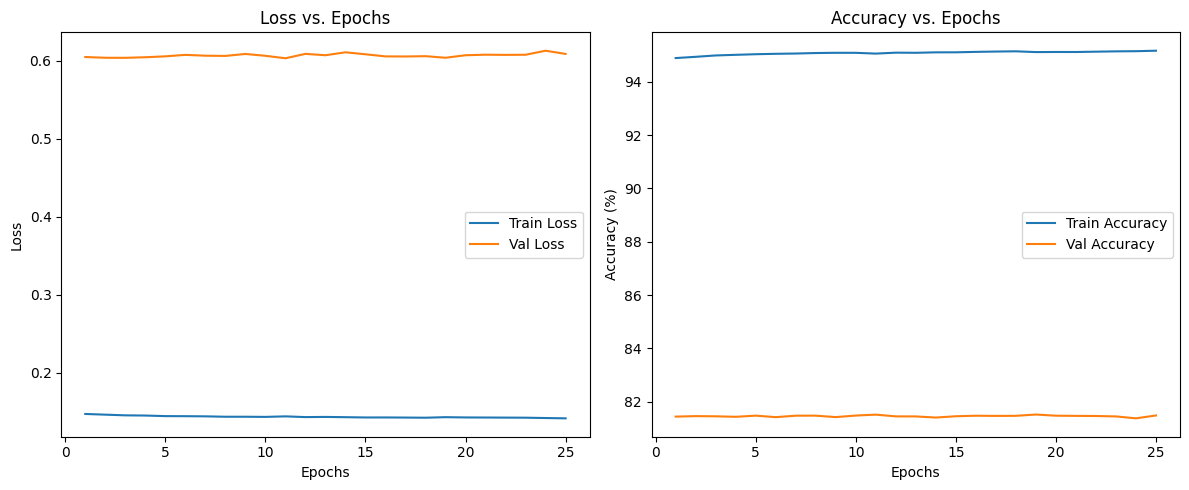

In [31]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,25)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


Epoch 1 | Train Loss:   0.1418 | Train Accuracy:   95.1757% | Train mIOU:   0.9097 | Train mF1:   0.9520 | Train Precision:   0.9523 | Train Recall:   0.9518


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 1 | Val Loss:   0.6060 | Val Accuracy:   81.5081% | Val mIOU:   0.6959 | Val mF1:   0.8148 | Val Precision:   0.8145 | Val Recall:   0.8151


100%|██████████| 12/12 [00:01<00:00,  9.32it/s]


Epoch 2 | Train Loss:   0.1415 | Train Accuracy:   95.1852% | Train mIOU:   0.9099 | Train mF1:   0.9521 | Train Precision:   0.9524 | Train Recall:   0.9519


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 2 | Val Loss:   0.6086 | Val Accuracy:   81.4750% | Val mIOU:   0.6954 | Val mF1:   0.8145 | Val Precision:   0.8142 | Val Recall:   0.8148


100%|██████████| 12/12 [00:01<00:00,  9.32it/s]


Epoch 3 | Train Loss:   0.1413 | Train Accuracy:   95.1885% | Train mIOU:   0.9099 | Train mF1:   0.9521 | Train Precision:   0.9523 | Train Recall:   0.9519


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 3 | Val Loss:   0.6106 | Val Accuracy:   81.4740% | Val mIOU:   0.6951 | Val mF1:   0.8143 | Val Precision:   0.8138 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 4 | Train Loss:   0.1419 | Train Accuracy:   95.1726% | Train mIOU:   0.9096 | Train mF1:   0.9520 | Train Precision:   0.9523 | Train Recall:   0.9517


100%|██████████| 3/3 [00:00<00:00, 16.36it/s]


Epoch 4 | Val Loss:   0.6081 | Val Accuracy:   81.4842% | Val mIOU:   0.6953 | Val mF1:   0.8144 | Val Precision:   0.8140 | Val Recall:   0.8148


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 5 | Train Loss:   0.1417 | Train Accuracy:   95.1708% | Train mIOU:   0.9097 | Train mF1:   0.9520 | Train Precision:   0.9524 | Train Recall:   0.9517


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 5 | Val Loss:   0.6089 | Val Accuracy:   81.4715% | Val mIOU:   0.6954 | Val mF1:   0.8145 | Val Precision:   0.8143 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 6 | Train Loss:   0.1416 | Train Accuracy:   95.1840% | Train mIOU:   0.9098 | Train mF1:   0.9521 | Train Precision:   0.9524 | Train Recall:   0.9518


100%|██████████| 3/3 [00:00<00:00, 16.98it/s]


Epoch 6 | Val Loss:   0.6085 | Val Accuracy:   81.4920% | Val mIOU:   0.6956 | Val mF1:   0.8146 | Val Precision:   0.8143 | Val Recall:   0.8149


100%|██████████| 12/12 [00:01<00:00,  9.75it/s]


Epoch 7 | Train Loss:   0.1414 | Train Accuracy:   95.1856% | Train mIOU:   0.9099 | Train mF1:   0.9522 | Train Precision:   0.9525 | Train Recall:   0.9519


100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


Epoch 7 | Val Loss:   0.6081 | Val Accuracy:   81.4908% | Val mIOU:   0.6956 | Val mF1:   0.8146 | Val Precision:   0.8144 | Val Recall:   0.8149


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 8 | Train Loss:   0.1410 | Train Accuracy:   95.2049% | Train mIOU:   0.9103 | Train mF1:   0.9523 | Train Precision:   0.9526 | Train Recall:   0.9520


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 8 | Val Loss:   0.6091 | Val Accuracy:   81.4794% | Val mIOU:   0.6956 | Val mF1:   0.8144 | Val Precision:   0.8141 | Val Recall:   0.8148


100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Epoch 9 | Train Loss:   0.1418 | Train Accuracy:   95.1773% | Train mIOU:   0.9097 | Train mF1:   0.9521 | Train Precision:   0.9523 | Train Recall:   0.9518


100%|██████████| 3/3 [00:00<00:00, 16.07it/s]


Epoch 9 | Val Loss:   0.6093 | Val Accuracy:   81.3971% | Val mIOU:   0.6945 | Val mF1:   0.8137 | Val Precision:   0.8134 | Val Recall:   0.8140


100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


Epoch 10 | Train Loss:   0.1411 | Train Accuracy:   95.2067% | Train mIOU:   0.9102 | Train mF1:   0.9523 | Train Precision:   0.9526 | Train Recall:   0.9521


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


Epoch 10 | Val Loss:   0.6099 | Val Accuracy:   81.4455% | Val mIOU:   0.6951 | Val mF1:   0.8141 | Val Precision:   0.8137 | Val Recall:   0.8145


100%|██████████| 12/12 [00:01<00:00,  9.67it/s]


Epoch 11 | Train Loss:   0.1409 | Train Accuracy:   95.2175% | Train mIOU:   0.9104 | Train mF1:   0.9524 | Train Precision:   0.9527 | Train Recall:   0.9522


100%|██████████| 3/3 [00:00<00:00, 16.52it/s]


Epoch 11 | Val Loss:   0.6097 | Val Accuracy:   81.4683% | Val mIOU:   0.6951 | Val mF1:   0.8143 | Val Precision:   0.8139 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.49it/s]


Epoch 12 | Train Loss:   0.1405 | Train Accuracy:   95.2307% | Train mIOU:   0.9106 | Train mF1:   0.9525 | Train Precision:   0.9528 | Train Recall:   0.9523


100%|██████████| 3/3 [00:00<00:00, 15.91it/s]


Epoch 12 | Val Loss:   0.6106 | Val Accuracy:   81.4541% | Val mIOU:   0.6951 | Val mF1:   0.8141 | Val Precision:   0.8137 | Val Recall:   0.8145


100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


Epoch 13 | Train Loss:   0.1405 | Train Accuracy:   95.2256% | Train mIOU:   0.9106 | Train mF1:   0.9525 | Train Precision:   0.9528 | Train Recall:   0.9523


100%|██████████| 3/3 [00:00<00:00, 16.37it/s]


Epoch 13 | Val Loss:   0.6132 | Val Accuracy:   81.4332% | Val mIOU:   0.6949 | Val mF1:   0.8140 | Val Precision:   0.8136 | Val Recall:   0.8143


100%|██████████| 12/12 [00:01<00:00,  9.65it/s]


Epoch 14 | Train Loss:   0.1405 | Train Accuracy:   95.2299% | Train mIOU:   0.9106 | Train mF1:   0.9526 | Train Precision:   0.9528 | Train Recall:   0.9523


100%|██████████| 3/3 [00:00<00:00, 16.50it/s]


Epoch 14 | Val Loss:   0.6092 | Val Accuracy:   81.4935% | Val mIOU:   0.6957 | Val mF1:   0.8145 | Val Precision:   0.8140 | Val Recall:   0.8149


100%|██████████| 12/12 [00:01<00:00,  9.50it/s]


Epoch 15 | Train Loss:   0.1405 | Train Accuracy:   95.2259% | Train mIOU:   0.9106 | Train mF1:   0.9526 | Train Precision:   0.9528 | Train Recall:   0.9523


100%|██████████| 3/3 [00:00<00:00, 16.34it/s]


Epoch 15 | Val Loss:   0.6112 | Val Accuracy:   81.4684% | Val mIOU:   0.6952 | Val mF1:   0.8143 | Val Precision:   0.8140 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Epoch 16 | Train Loss:   0.1401 | Train Accuracy:   95.2397% | Train mIOU:   0.9108 | Train mF1:   0.9527 | Train Precision:   0.9530 | Train Recall:   0.9524


100%|██████████| 3/3 [00:00<00:00, 16.23it/s]


Epoch 16 | Val Loss:   0.6113 | Val Accuracy:   81.4297% | Val mIOU:   0.6948 | Val mF1:   0.8140 | Val Precision:   0.8136 | Val Recall:   0.8143


100%|██████████| 12/12 [00:01<00:00,  9.59it/s]


Epoch 17 | Train Loss:   0.1402 | Train Accuracy:   95.2398% | Train mIOU:   0.9108 | Train mF1:   0.9527 | Train Precision:   0.9529 | Train Recall:   0.9524


100%|██████████| 3/3 [00:00<00:00, 16.77it/s]


Epoch 17 | Val Loss:   0.6130 | Val Accuracy:   81.4387% | Val mIOU:   0.6948 | Val mF1:   0.8140 | Val Precision:   0.8136 | Val Recall:   0.8144


100%|██████████| 12/12 [00:01<00:00,  9.66it/s]


Epoch 18 | Train Loss:   0.1399 | Train Accuracy:   95.2472% | Train mIOU:   0.9110 | Train mF1:   0.9528 | Train Precision:   0.9531 | Train Recall:   0.9525


100%|██████████| 3/3 [00:00<00:00, 15.86it/s]


Epoch 18 | Val Loss:   0.6106 | Val Accuracy:   81.4646% | Val mIOU:   0.6953 | Val mF1:   0.8144 | Val Precision:   0.8141 | Val Recall:   0.8146


100%|██████████| 12/12 [00:01<00:00,  9.56it/s]


Epoch 19 | Train Loss:   0.1403 | Train Accuracy:   95.2323% | Train mIOU:   0.9108 | Train mF1:   0.9527 | Train Precision:   0.9530 | Train Recall:   0.9523


100%|██████████| 3/3 [00:00<00:00, 16.27it/s]


Epoch 19 | Val Loss:   0.6075 | Val Accuracy:   81.5205% | Val mIOU:   0.6962 | Val mF1:   0.8149 | Val Precision:   0.8146 | Val Recall:   0.8152


100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


Epoch 20 | Train Loss:   0.1396 | Train Accuracy:   95.2569% | Train mIOU:   0.9111 | Train mF1:   0.9528 | Train Precision:   0.9531 | Train Recall:   0.9526


100%|██████████| 3/3 [00:00<00:00, 15.78it/s]


Epoch 20 | Val Loss:   0.6115 | Val Accuracy:   81.4782% | Val mIOU:   0.6955 | Val mF1:   0.8144 | Val Precision:   0.8140 | Val Recall:   0.8148


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 21 | Train Loss:   0.1396 | Train Accuracy:   95.2588% | Train mIOU:   0.9112 | Train mF1:   0.9528 | Train Precision:   0.9531 | Train Recall:   0.9526


100%|██████████| 3/3 [00:00<00:00, 15.94it/s]


Epoch 21 | Val Loss:   0.6123 | Val Accuracy:   81.4708% | Val mIOU:   0.6952 | Val mF1:   0.8143 | Val Precision:   0.8140 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 22 | Train Loss:   0.1401 | Train Accuracy:   95.2409% | Train mIOU:   0.9109 | Train mF1:   0.9527 | Train Precision:   0.9530 | Train Recall:   0.9524


100%|██████████| 3/3 [00:00<00:00, 14.56it/s]


Epoch 22 | Val Loss:   0.6096 | Val Accuracy:   81.4581% | Val mIOU:   0.6953 | Val mF1:   0.8143 | Val Precision:   0.8141 | Val Recall:   0.8146


100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


Epoch 23 | Train Loss:   0.1397 | Train Accuracy:   95.2562% | Train mIOU:   0.9111 | Train mF1:   0.9528 | Train Precision:   0.9530 | Train Recall:   0.9526


100%|██████████| 3/3 [00:00<00:00, 16.51it/s]


Epoch 23 | Val Loss:   0.6138 | Val Accuracy:   81.4164% | Val mIOU:   0.6945 | Val mF1:   0.8138 | Val Precision:   0.8134 | Val Recall:   0.8142


100%|██████████| 12/12 [00:01<00:00,  9.37it/s]


Epoch 24 | Train Loss:   0.1395 | Train Accuracy:   95.2713% | Train mIOU:   0.9114 | Train mF1:   0.9530 | Train Precision:   0.9532 | Train Recall:   0.9527


100%|██████████| 3/3 [00:00<00:00, 16.04it/s]


Epoch 24 | Val Loss:   0.6117 | Val Accuracy:   81.4489% | Val mIOU:   0.6950 | Val mF1:   0.8140 | Val Precision:   0.8136 | Val Recall:   0.8145


100%|██████████| 12/12 [00:01<00:00,  9.21it/s]


Epoch 25 | Train Loss:   0.1396 | Train Accuracy:   95.2615% | Train mIOU:   0.9112 | Train mF1:   0.9529 | Train Precision:   0.9532 | Train Recall:   0.9526


100%|██████████| 3/3 [00:00<00:00, 16.35it/s]


Epoch 25 | Val Loss:   0.6118 | Val Accuracy:   81.4570% | Val mIOU:   0.6953 | Val mF1:   0.8144 | Val Precision:   0.8141 | Val Recall:   0.8146


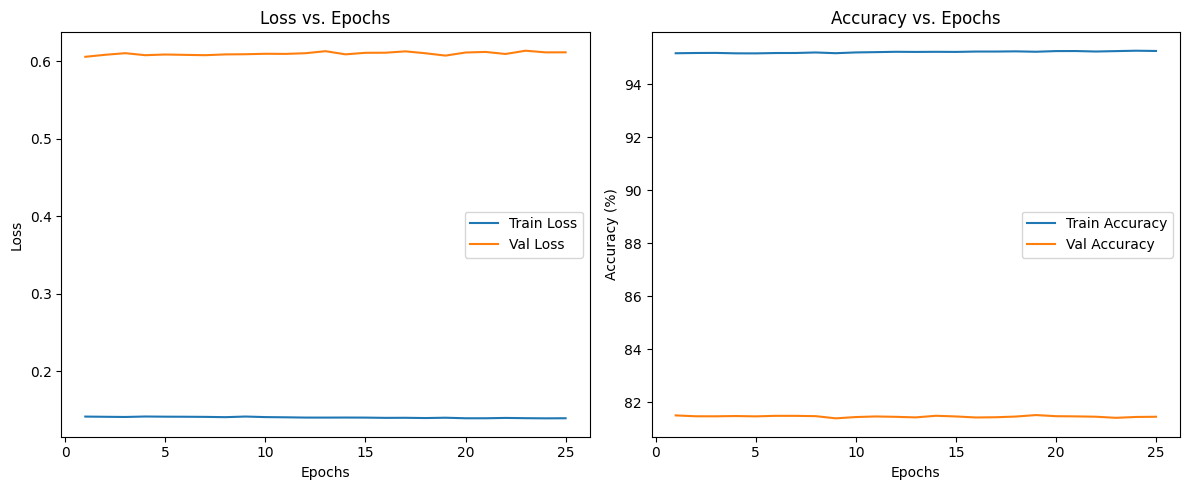

In [32]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,25)

  0%|          | 0/12 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch 1 | Train Loss:   0.1405 | Train Accuracy:   95.1238% | Train mIOU:   0.9087 | Train mF1:   0.9515 | Train Precision:   0.9518 | Train Recall:   0.9512


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Epoch 1 | Val Loss:   0.6273 | Val Accuracy:   81.1949% | Val mIOU:   0.6910 | Val mF1:   0.8115 | Val Precision:   0.8110 | Val Recall:   0.8119


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 2 | Train Loss:   0.1386 | Train Accuracy:   95.1448% | Train mIOU:   0.9092 | Train mF1:   0.9517 | Train Precision:   0.9520 | Train Recall:   0.9514


100%|██████████| 3/3 [00:00<00:00, 16.32it/s]


Epoch 2 | Val Loss:   0.6219 | Val Accuracy:   81.4201% | Val mIOU:   0.6950 | Val mF1:   0.8139 | Val Precision:   0.8135 | Val Recall:   0.8142


100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


Epoch 3 | Train Loss:   0.1378 | Train Accuracy:   95.2091% | Train mIOU:   0.9103 | Train mF1:   0.9524 | Train Precision:   0.9528 | Train Recall:   0.9521


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Epoch 3 | Val Loss:   0.6299 | Val Accuracy:   81.2106% | Val mIOU:   0.6917 | Val mF1:   0.8120 | Val Precision:   0.8119 | Val Recall:   0.8121


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 4 | Train Loss:   0.1396 | Train Accuracy:   95.0845% | Train mIOU:   0.9080 | Train mF1:   0.9511 | Train Precision:   0.9514 | Train Recall:   0.9508


100%|██████████| 3/3 [00:00<00:00, 15.44it/s]


Epoch 4 | Val Loss:   0.6306 | Val Accuracy:   81.2657% | Val mIOU:   0.6922 | Val mF1:   0.8124 | Val Precision:   0.8122 | Val Recall:   0.8127


100%|██████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 5 | Train Loss:   0.1367 | Train Accuracy:   95.2766% | Train mIOU:   0.9115 | Train mF1:   0.9531 | Train Precision:   0.9534 | Train Recall:   0.9528


100%|██████████| 3/3 [00:00<00:00, 15.93it/s]


Epoch 5 | Val Loss:   0.6197 | Val Accuracy:   81.4330% | Val mIOU:   0.6950 | Val mF1:   0.8143 | Val Precision:   0.8142 | Val Recall:   0.8143


100%|██████████| 12/12 [00:01<00:00,  9.23it/s]


Epoch 6 | Train Loss:   0.1354 | Train Accuracy:   95.3325% | Train mIOU:   0.9124 | Train mF1:   0.9535 | Train Precision:   0.9537 | Train Recall:   0.9533


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 6 | Val Loss:   0.6246 | Val Accuracy:   81.4014% | Val mIOU:   0.6940 | Val mF1:   0.8134 | Val Precision:   0.8128 | Val Recall:   0.8140


100%|██████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch 7 | Train Loss:   0.1340 | Train Accuracy:   95.4121% | Train mIOU:   0.9138 | Train mF1:   0.9544 | Train Precision:   0.9546 | Train Recall:   0.9541


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 7 | Val Loss:   0.6234 | Val Accuracy:   81.3778% | Val mIOU:   0.6943 | Val mF1:   0.8135 | Val Precision:   0.8132 | Val Recall:   0.8138


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


Epoch 8 | Train Loss:   0.1332 | Train Accuracy:   95.4112% | Train mIOU:   0.9138 | Train mF1:   0.9543 | Train Precision:   0.9545 | Train Recall:   0.9541


100%|██████████| 3/3 [00:00<00:00, 15.98it/s]


Epoch 8 | Val Loss:   0.6305 | Val Accuracy:   81.4601% | Val mIOU:   0.6950 | Val mF1:   0.8140 | Val Precision:   0.8133 | Val Recall:   0.8146


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 9 | Train Loss:   0.1335 | Train Accuracy:   95.4134% | Train mIOU:   0.9138 | Train mF1:   0.9544 | Train Precision:   0.9546 | Train Recall:   0.9541


100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Epoch 9 | Val Loss:   0.6305 | Val Accuracy:   81.3936% | Val mIOU:   0.6943 | Val mF1:   0.8134 | Val Precision:   0.8128 | Val Recall:   0.8139


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 10 | Train Loss:   0.1329 | Train Accuracy:   95.4338% | Train mIOU:   0.9142 | Train mF1:   0.9546 | Train Precision:   0.9549 | Train Recall:   0.9543


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Epoch 10 | Val Loss:   0.6334 | Val Accuracy:   81.2897% | Val mIOU:   0.6924 | Val mF1:   0.8127 | Val Precision:   0.8124 | Val Recall:   0.8129


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


Epoch 11 | Train Loss:   0.1322 | Train Accuracy:   95.4603% | Train mIOU:   0.9146 | Train mF1:   0.9549 | Train Precision:   0.9551 | Train Recall:   0.9546


100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


Epoch 11 | Val Loss:   0.6321 | Val Accuracy:   81.3171% | Val mIOU:   0.6931 | Val mF1:   0.8128 | Val Precision:   0.8125 | Val Recall:   0.8132


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 12 | Train Loss:   0.1312 | Train Accuracy:   95.5128% | Train mIOU:   0.9155 | Train mF1:   0.9553 | Train Precision:   0.9554 | Train Recall:   0.9551


100%|██████████| 3/3 [00:00<00:00, 16.02it/s]


Epoch 12 | Val Loss:   0.6357 | Val Accuracy:   81.3464% | Val mIOU:   0.6931 | Val mF1:   0.8127 | Val Precision:   0.8120 | Val Recall:   0.8135


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


Epoch 13 | Train Loss:   0.1300 | Train Accuracy:   95.5822% | Train mIOU:   0.9168 | Train mF1:   0.9561 | Train Precision:   0.9563 | Train Recall:   0.9558


100%|██████████| 3/3 [00:00<00:00, 16.54it/s]


Epoch 13 | Val Loss:   0.6308 | Val Accuracy:   81.3611% | Val mIOU:   0.6937 | Val mF1:   0.8132 | Val Precision:   0.8129 | Val Recall:   0.8136


100%|██████████| 12/12 [00:01<00:00,  9.62it/s]


Epoch 14 | Train Loss:   0.1297 | Train Accuracy:   95.5588% | Train mIOU:   0.9164 | Train mF1:   0.9558 | Train Precision:   0.9561 | Train Recall:   0.9556


100%|██████████| 3/3 [00:00<00:00, 16.16it/s]


Epoch 14 | Val Loss:   0.6362 | Val Accuracy:   81.3673% | Val mIOU:   0.6936 | Val mF1:   0.8134 | Val Precision:   0.8131 | Val Recall:   0.8137


100%|██████████| 12/12 [00:01<00:00,  9.29it/s]


Epoch 15 | Train Loss:   0.1320 | Train Accuracy:   95.4206% | Train mIOU:   0.9141 | Train mF1:   0.9546 | Train Precision:   0.9550 | Train Recall:   0.9542


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Epoch 15 | Val Loss:   0.6330 | Val Accuracy:   81.2984% | Val mIOU:   0.6931 | Val mF1:   0.8129 | Val Precision:   0.8129 | Val Recall:   0.8130


100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


Epoch 16 | Train Loss:   0.1290 | Train Accuracy:   95.5708% | Train mIOU:   0.9166 | Train mF1:   0.9559 | Train Precision:   0.9561 | Train Recall:   0.9557


100%|██████████| 3/3 [00:00<00:00, 15.73it/s]


Epoch 16 | Val Loss:   0.6353 | Val Accuracy:   81.4685% | Val mIOU:   0.6951 | Val mF1:   0.8141 | Val Precision:   0.8134 | Val Recall:   0.8147


100%|██████████| 12/12 [00:01<00:00,  9.38it/s]


Epoch 17 | Train Loss:   0.1298 | Train Accuracy:   95.5369% | Train mIOU:   0.9161 | Train mF1:   0.9557 | Train Precision:   0.9560 | Train Recall:   0.9554


100%|██████████| 3/3 [00:00<00:00, 16.06it/s]


Epoch 17 | Val Loss:   0.6331 | Val Accuracy:   81.4102% | Val mIOU:   0.6947 | Val mF1:   0.8139 | Val Precision:   0.8138 | Val Recall:   0.8141


100%|██████████| 12/12 [00:01<00:00,  9.42it/s]


Epoch 18 | Train Loss:   0.1285 | Train Accuracy:   95.5858% | Train mIOU:   0.9168 | Train mF1:   0.9560 | Train Precision:   0.9562 | Train Recall:   0.9559


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


Epoch 18 | Val Loss:   0.6403 | Val Accuracy:   81.3743% | Val mIOU:   0.6935 | Val mF1:   0.8132 | Val Precision:   0.8127 | Val Recall:   0.8137


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


Epoch 19 | Train Loss:   0.1281 | Train Accuracy:   95.5979% | Train mIOU:   0.9172 | Train mF1:   0.9563 | Train Precision:   0.9566 | Train Recall:   0.9560


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]


Epoch 19 | Val Loss:   0.6364 | Val Accuracy:   81.3478% | Val mIOU:   0.6939 | Val mF1:   0.8133 | Val Precision:   0.8131 | Val Recall:   0.8135


100%|██████████| 12/12 [00:01<00:00,  9.17it/s]


Epoch 20 | Train Loss:   0.1267 | Train Accuracy:   95.6758% | Train mIOU:   0.9185 | Train mF1:   0.9570 | Train Precision:   0.9572 | Train Recall:   0.9568


100%|██████████| 3/3 [00:00<00:00, 16.54it/s]


Epoch 20 | Val Loss:   0.6356 | Val Accuracy:   81.3942% | Val mIOU:   0.6944 | Val mF1:   0.8135 | Val Precision:   0.8131 | Val Recall:   0.8139


100%|██████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 21 | Train Loss:   0.1261 | Train Accuracy:   95.7037% | Train mIOU:   0.9189 | Train mF1:   0.9572 | Train Precision:   0.9574 | Train Recall:   0.9570


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Epoch 21 | Val Loss:   0.6397 | Val Accuracy:   81.4212% | Val mIOU:   0.6945 | Val mF1:   0.8137 | Val Precision:   0.8131 | Val Recall:   0.8142


100%|██████████| 12/12 [00:01<00:00,  9.55it/s]


Epoch 22 | Train Loss:   0.1266 | Train Accuracy:   95.6630% | Train mIOU:   0.9184 | Train mF1:   0.9569 | Train Precision:   0.9573 | Train Recall:   0.9566


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Epoch 22 | Val Loss:   0.6323 | Val Accuracy:   81.5194% | Val mIOU:   0.6963 | Val mF1:   0.8149 | Val Precision:   0.8147 | Val Recall:   0.8152


100%|██████████| 12/12 [00:01<00:00,  9.45it/s]


Epoch 23 | Train Loss:   0.1258 | Train Accuracy:   95.6606% | Train mIOU:   0.9181 | Train mF1:   0.9568 | Train Precision:   0.9570 | Train Recall:   0.9566


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Epoch 23 | Val Loss:   0.6488 | Val Accuracy:   81.3619% | Val mIOU:   0.6933 | Val mF1:   0.8131 | Val Precision:   0.8126 | Val Recall:   0.8136


100%|██████████| 12/12 [00:01<00:00,  9.29it/s]


Epoch 24 | Train Loss:   0.1260 | Train Accuracy:   95.6744% | Train mIOU:   0.9185 | Train mF1:   0.9570 | Train Precision:   0.9572 | Train Recall:   0.9567


100%|██████████| 3/3 [00:00<00:00, 15.56it/s]


Epoch 24 | Val Loss:   0.6377 | Val Accuracy:   81.4850% | Val mIOU:   0.6958 | Val mF1:   0.8144 | Val Precision:   0.8140 | Val Recall:   0.8149


100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Epoch 25 | Train Loss:   0.1242 | Train Accuracy:   95.7476% | Train mIOU:   0.9197 | Train mF1:   0.9577 | Train Precision:   0.9578 | Train Recall:   0.9575


100%|██████████| 3/3 [00:00<00:00, 16.03it/s]


Epoch 25 | Val Loss:   0.6437 | Val Accuracy:   81.4499% | Val mIOU:   0.6946 | Val mF1:   0.8138 | Val Precision:   0.8131 | Val Recall:   0.8145


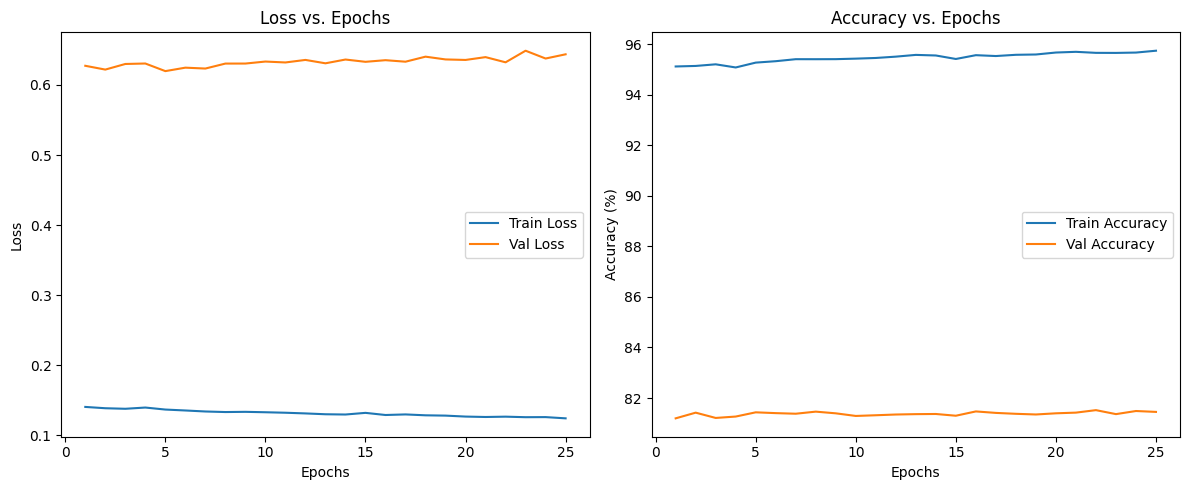

In [41]:
train_0(model_unet, train_dataloader, val_dataloader, loss_fn, optimizer,25,scheduler)

In [35]:


import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

import numpy as np
label_map = np.array([
      (0, 0, 0),          # 0 - Background (Black)
      (0, 0, 255),        # 1 - Surface water (Blue)
      (135, 206, 250),    # 2 - Street (Light Sky Blue)
      (255, 255, 0),      # 3 - Urban Fabric (Yellow)
      (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
      (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
      (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
      (255, 165, 0),      # 7 - Arable Land (Orange)
      (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
      (154, 205, 50),     # 9 - Pastures (Yellow Green)
      (34, 139, 34),      # 10 - Forests (Forest Green)
      (139, 69, 19),      # 11 - Shrub (Saddle Brown)
      (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
      (0, 255, 255),      # 13 - Inland wetlands (Cyan)
  ])


labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

def predict_and_show(model, dataset, index):
  X, mask = dataset[index]
  X = X.to(device)
  model.eval()
  with torch.inference_mode():
    output = model(X.unsqueeze(dim=0)).to(device)

  W, H = output.shape[2], output.shape[3]

  # Get RGB segmentation map
  segmented_image = draw_segmentation_map(output)

  # Resize to original image size
  segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)

  # Plot
  plt.figure(figsize=(20, 20))

  plt.subplot(1, 3, 1)
  # Create a custom colormap using the colors defined above
  cmap = ListedColormap(label_map / 255.0)

  # Display the mask using the custom colormap
  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  plt.title("Ground Truth")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.title("Segmentation")
  plt.axis("off")
  plt.imshow(segmented_image)

  plt.show()
  plt.close()
  # Save Segmented and overlayed images
  if False:
      cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
      cv2.imwrite(overlayed_save_dir, overlayed_image)



def predict_random_and_show(model, dataset):
    indices = random.sample(range(len(dataset)), 6)  # Change max_index to the maximum index available in your dataset

    plt.figure(figsize=(20, 20))

    for idx, index in enumerate(indices, 1):
        X, mask = dataset[index]
        X = X.to(device)
        model.eval()
        with torch.inference_mode():
            output = model(X.unsqueeze(dim=0)).to(device)

        W, H = output.shape[2], output.shape[3]

        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)

        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)

        plt.subplot(6, 3, 3 * (idx - 1) + 1)
        cmap = ListedColormap(label_map / 255.0)
        plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)
        plt.title(f"Ground Truth - Image {index}")
        plt.axis("off")

        plt.subplot(6, 3, 3 * (idx - 1) + 2)
        plt.title(f"Segmentation - Image {index}")
        plt.axis("off")
        plt.imshow(segmented_image)

    plt.tight_layout()
    plt.show()
    plt.close()



def show_mask(mask):
  cmap = ListedColormap(label_map / 255.0)

  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  num_labels = len(label_map)
  ticks = np.arange(num_labels)

  cbar = plt.colorbar(ticks=ticks)
  cbar.ax.set_yticklabels(labels, fontsize=8)
  plt.axis("off")
  plt.show()


def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).cpu().numpy()

    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(label_map)):
        index = labels == label_num

        R, G, B = label_map[label_num]

        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


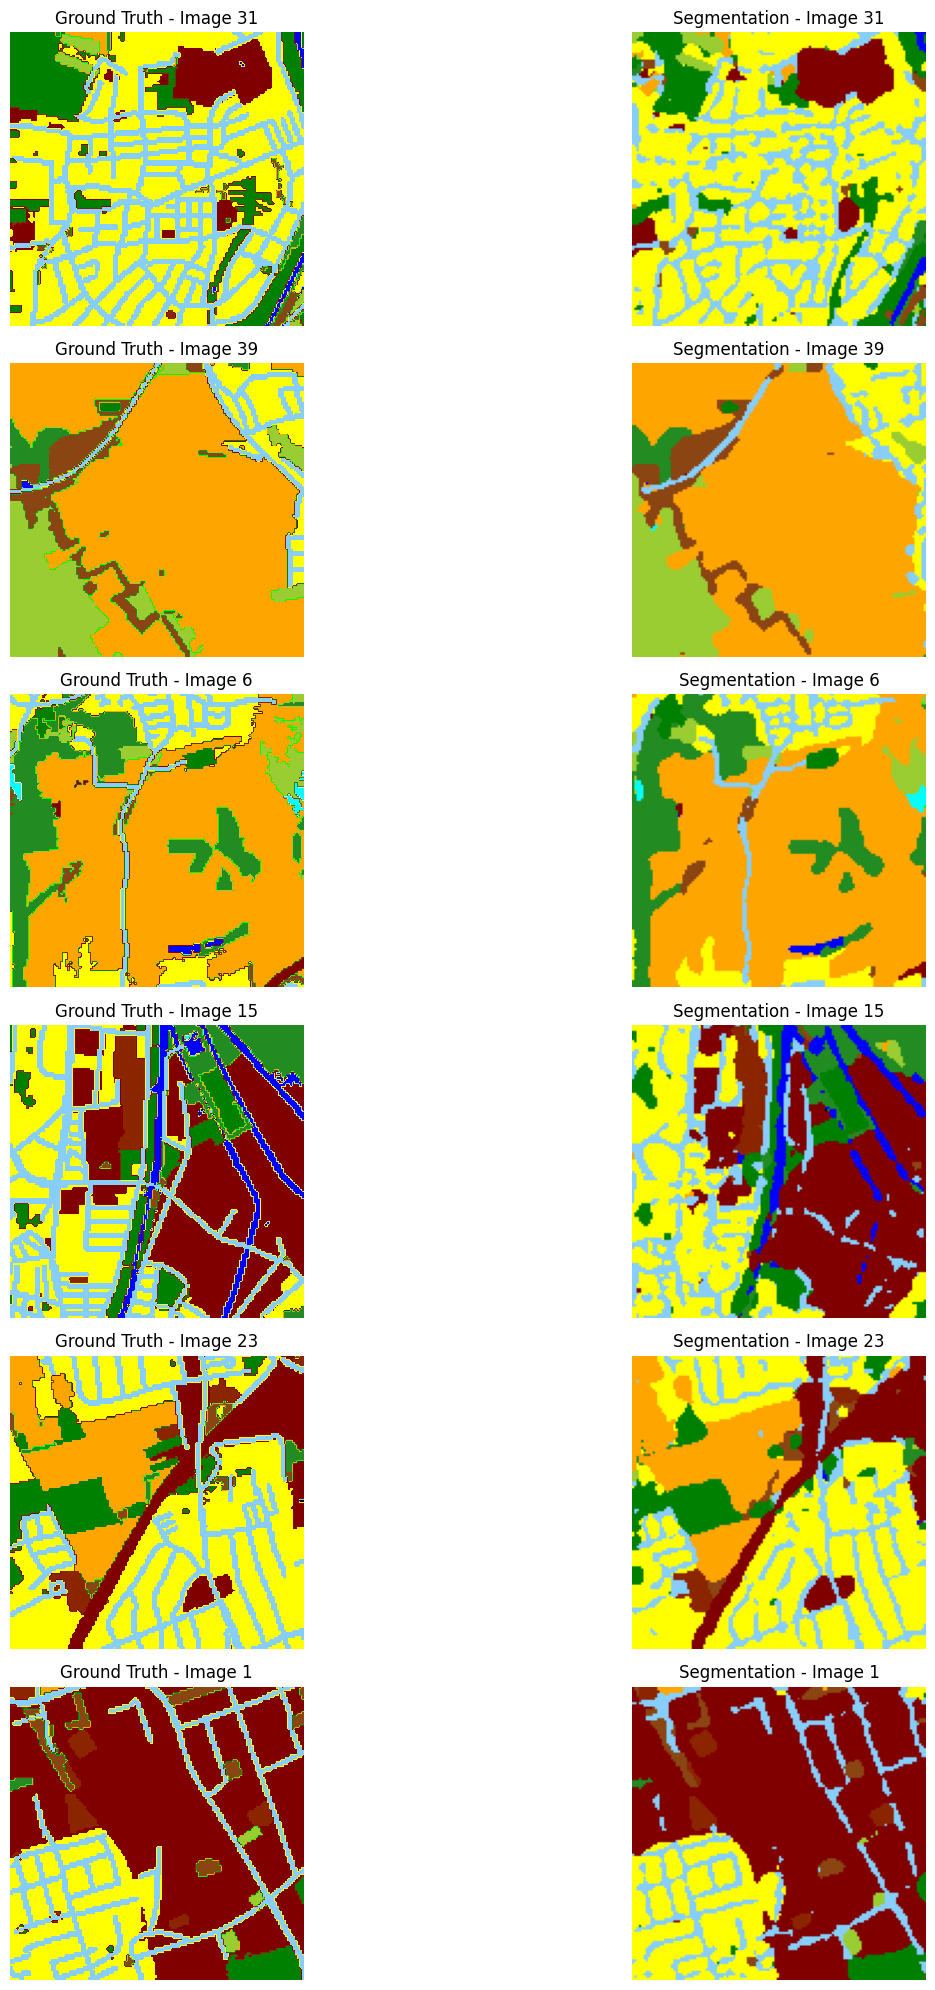

In [38]:
predict_random_and_show(model_unet, test_dataset)

In [43]:
model_path = '/teamspace/studios/this_studio/model_unet.pth'
torch.save({
    'model_state_dict': model_unet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_path)